## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
# Camera Calibration

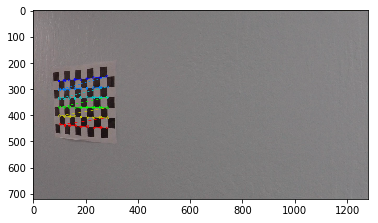

In [13]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from helpers import *

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)

## Step 1) Create the calibration matrix

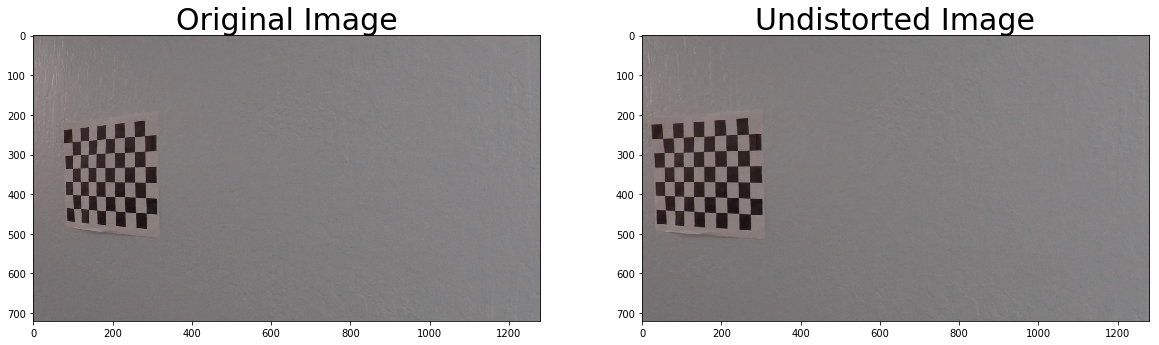

In [4]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration11.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('calibration_wide/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_calibration_result.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## 2) Apply distortion correction to the image

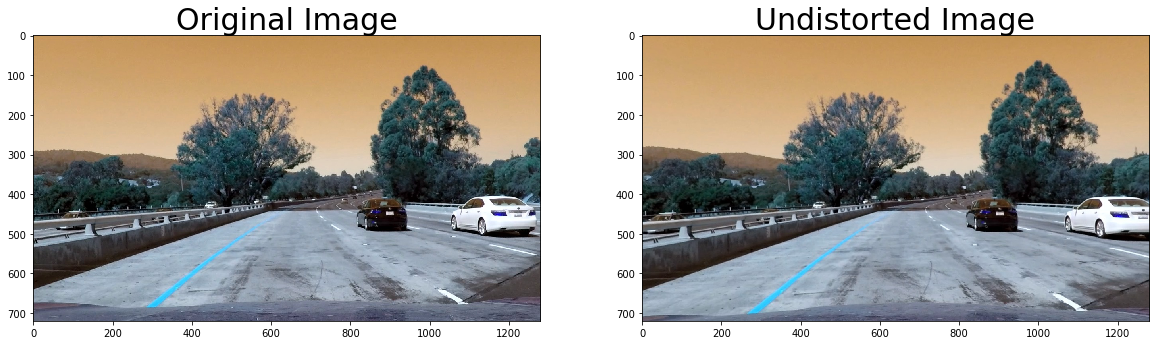

In [9]:
raw = cv2.imread("test_images/test1.jpg")

image = cv2.undistort(raw, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(raw)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(image)
ax2.set_title('Undistorted Image', fontsize=30)

In [10]:
# Parameters
imshape = raw.shape

height = raw.shape[0]
offset = 50
offset_height = height - offset
half_frame = raw.shape[1] // 2
steps = 6
pixels_per_step = offset_height / steps
window_radius = 200
medianfilt_kernel_size = 51
horizontal_offset = 40

blank_canvas = np.zeros((720, 1280))
colour_canvas = cv2.cvtColor(blank_canvas.astype(np.uint8), cv2.COLOR_GRAY2RGB)

## Step 3) Create a thresholded binary image

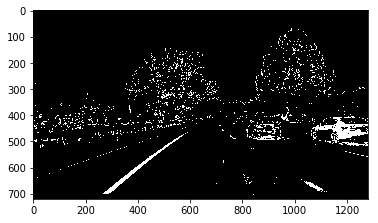

In [14]:
xgrad_thresh_temp = (40,100)
s_thresh_temp=(150,255)

combined_binary = apply_threshold_v2(image, xgrad_thresh=xgrad_thresh_temp, s_thresh=s_thresh_temp)
plt.imshow(combined_binary, cmap="gray")

## Step 4) Apply a perspective transform to rectify the binary image

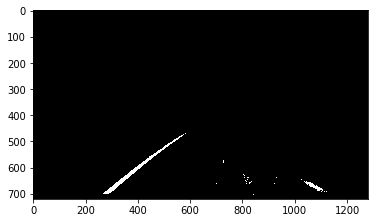

In [15]:
vertices = np.array([[(0,imshape[0]),(550, 470), (700, 470), (imshape[1],imshape[0])]], dtype=np.int32)
masked_image = region_of_interest(combined_binary, vertices)
plt.imshow(masked_image, cmap="gray")

In [16]:
src = np.float32(
    [[120, 720],
     [550, 470],
     [700, 470],
     [1160, 720]])

dst = np.float32(
    [[200,720],
     [200,0],
     [1080,0],
     [1080,720]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

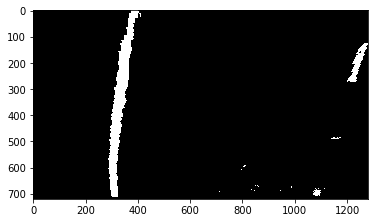

In [17]:
# Warp onto birds-eye-view
# Previous region-of-interest mask's function is absorbed by the warp
warped = cv2.warpPerspective(combined_binary, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
plt.imshow(warped, cmap="gray")

## Step 5) Detect lane pixels and fit to lane boundary

Left coeffs: [  1.39312274e-04  -2.14966581e-01   3.85577895e+02]
righty[0]: , 489.0 , rightx[0]:  1140
Right coeffs:  [  1.21529364e-04  -3.62144057e-01   1.30684284e+03]


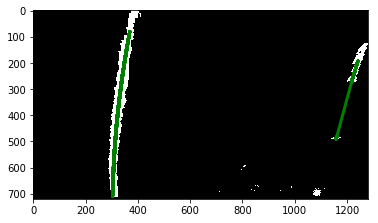

In [19]:
from scipy import signal

# Histogram and get pixels in window
leftx, lefty, rightx, righty = histogram_pixels(warped, horizontal_offset=horizontal_offset)

# Fit a second order polynomial to each fake lane line
left_fit, left_coeffs = fit_second_order_poly(lefty, leftx, return_coeffs=True)
print("Left coeffs:", left_coeffs)
print("righty[0]: ,", righty[0], ", rightx[0]: ", rightx[0])
right_fit, right_coeffs = fit_second_order_poly(righty, rightx, return_coeffs=True)
print("Right coeffs: ", right_coeffs)

# Plot data
plt.plot(left_fit, lefty, color='green', linewidth=3)
plt.plot(right_fit, righty, color='green', linewidth=3)
plt.imshow(warped, cmap="gray")

Left coeffs:  [  1.39312274e-04  -2.14966581e-01   3.85577895e+02]
Right fit:  [  1.21529364e-04  -3.62144057e-01   1.30684284e+03]


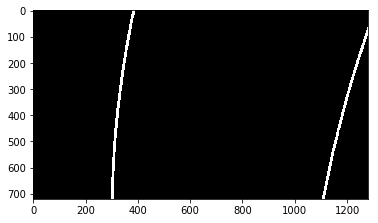

In [20]:
print("Left coeffs: ", left_coeffs)
print("Right fit: ", right_coeffs)
polyfit_left = draw_poly(blank_canvas, lane_poly, left_coeffs, 30)
polyfit_drawn = draw_poly(polyfit_left, lane_poly, right_coeffs, 30)
plt.imshow(polyfit_drawn, cmap="gray")

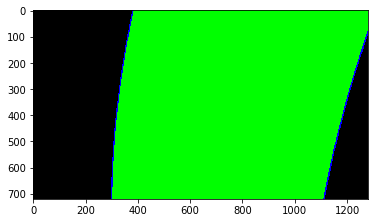

In [21]:
trace = colour_canvas
trace[polyfit_drawn > 1] = [0,0,255]
area = highlight_lane_line_area(blank_canvas, left_coeffs, right_coeffs)
trace[area == 1] = [0,255,0]
plt.imshow(trace)

## Step 6) Determine curvature of the lane and vehicle position in lane

In [22]:
# Determine curvature of the lane
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = 500
left_curverad = np.absolute(((1 + (2 * left_coeffs[0] * y_eval + left_coeffs[1])**2) ** 1.5) \
                /(2 * left_coeffs[0]))
right_curverad = np.absolute(((1 + (2 * right_coeffs[0] * y_eval + right_coeffs[1]) ** 2) ** 1.5) \
                 /(2 * right_coeffs[0]))
print("Left lane curve radius: ", left_curverad, "pixels")
print("Right lane curve radius: ", right_curverad, "pixels")
curvature = (left_curverad + right_curverad) / 2
centre = center(719, left_coeffs, right_coeffs)
min_curvature = min(left_curverad, right_curverad)

Left lane curve radius:  3619.91661591 pixels
Right lane curve radius:  4476.64740357 pixels


## Step 7) Map the detected lane boundaries back to original image

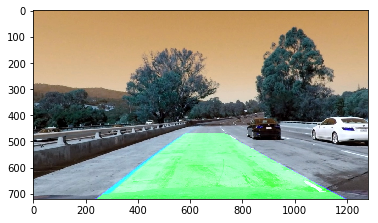

In [23]:
# Warp lane boundaries back onto original image
lane_lines = cv2.warpPerspective(trace, Minv, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)

# Convert to colour
combined_img = cv2.add(lane_lines, image)
plt.imshow(combined_img)

## Step 8) Output stats on the image

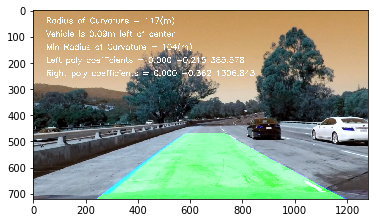

In [24]:
add_figures_to_image(combined_img, curvature=curvature, 
                     vehicle_position=centre, 
                     min_curvature=min_curvature,
                     left_coeffs=left_coeffs,
                     right_coeffs=right_coeffs)
plt.imshow(combined_img)

# Full Pipeline

Left coeffs: [ -1.39900838e-04   1.70557415e-01   2.94721357e+02]
righty[0]: , 664.0 , rightx[0]:  1063
Right coeffs:  [ -2.09611369e-04   5.21176043e-02   1.16680523e+03]
Left lane curve radius:  3578.99953128
Right lane curve radius:  2474.66587306
Left coeffs:  [ -1.39900838e-04   1.70557415e-01   2.94721357e+02]
Right fit:  [ -2.09611369e-04   5.21176043e-02   1.16680523e+03]
polyfit shape:  (720, 1280)


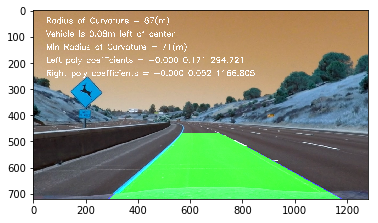

In [25]:
prev_left_coeffs = None
prev_right_coeffs = None

def image_pipeline(file, filepath=False):
    global prev_left_coeffs
    global prev_right_coeffs
    
    plt.clf()
    
    if filepath == True:
        # Read in image
        raw = cv2.imread(file)
    else:
        raw = file

    # Parameters
    imshape = raw.shape
    
    src = np.float32(
        [[120, 720],
         [550, 470],
         [700, 470],
         [1160, 720]])

    dst = np.float32(
        [[200,720],
         [200,0],
         [1080,0],
         [1080,720]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    height = raw.shape[0]
    offset = 50
    offset_height = height - offset
    half_frame = raw.shape[1] // 2
    steps = 6
    pixels_per_step = offset_height / steps
    window_radius = 200
    medianfilt_kernel_size = 51

    blank_canvas = np.zeros((720, 1280))
    colour_canvas = cv2.cvtColor(blank_canvas.astype(np.uint8), cv2.COLOR_GRAY2RGB)

    # Apply distortion correction to raw image
    image = cv2.undistort(raw, mtx, dist, None, mtx)

    ## Option I
    combined = apply_thresholds(image)

    ## Option II

    have_fit = False
    curvature_checked = False
    
    xgrad_thresh_temp = (40,100)
    s_thresh_temp=(150,255)
    
    while have_fit == False:
        combined_binary = apply_threshold_v2(image, xgrad_thresh=xgrad_thresh_temp, s_thresh=s_thresh_temp)
    #    plt.imshow(combined_binary, cmap="gray")

        # Plotting thresholded images
        """
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.set_title('Option 1')
        ax1.imshow(combined, cmap="gray")

        ax2.set_title('Option 2: Combined S channel and gradient thresholds')
        ax2.imshow(combined_binary, cmap='gray')
        """

        # Warp onto birds-eye-view
        # Previous region-of-interest mask's function is absorbed by the warp
        warped = cv2.warpPerspective(combined_binary, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
        # plt.imshow(warped, cmap="gray")

        # Histogram and get pixels in window

        leftx, lefty, rightx, righty = histogram_pixels(warped, horizontal_offset=40)

        plt.imshow(warped, cmap="gray")

        if len(leftx) > 1 and len(rightx) > 1:
            have_fit = True
        xgrad_thresh_temp = (xgrad_thresh_temp[0] - 2, xgrad_thresh_temp[1] + 2)
        s_thresh_temp = (s_thresh_temp[0] - 2, s_thresh_temp[1] + 2)

    left_fit, left_coeffs = fit_second_order_poly(lefty, leftx, return_coeffs=True)
    print("Left coeffs:", left_coeffs)
    print("righty[0]: ,", righty[0], ", rightx[0]: ", rightx[0])
    right_fit, right_coeffs = fit_second_order_poly(righty, rightx, return_coeffs=True)
    print("Right coeffs: ", right_coeffs)

    # Plot data
    """
    plt.plot(left_fit, lefty, color='green', linewidth=3)
    plt.plot(right_fit, righty, color='green', linewidth=3)
    plt.imshow(warped, cmap="gray")
    """

    # Determine curvature of the lane
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = 500
    left_curverad = np.absolute(((1 + (2 * left_coeffs[0] * y_eval + left_coeffs[1])**2) ** 1.5) \
                    /(2 * left_coeffs[0]))
    right_curverad = np.absolute(((1 + (2 * right_coeffs[0] * y_eval + right_coeffs[1]) ** 2) ** 1.5) \
                     /(2 * right_coeffs[0]))
    print("Left lane curve radius: ", left_curverad)
    print("Right lane curve radius: ", right_curverad)
    curvature = (left_curverad + right_curverad) / 2
    min_curverad = min(left_curverad, right_curverad)

    # TODO: if plausible parallel, continue. Else don't make `curvature_checked` = True
    if not plausible_curvature(left_curverad, right_curverad) or \
        not plausible_continuation_of_traces(left_coeffs, right_coeffs, prev_left_coeffs, prev_right_coeffs):
            if prev_left_coeffs is not None and prev_right_coeffs is not None:
                left_coeffs = prev_left_coeffs
                right_coeffs = prev_right_coeffs

    prev_left_coeffs = left_coeffs
    prev_right_coeffs = right_coeffs
    
    # Det vehicle position wrt centre
    centre = center(719, left_coeffs, right_coeffs)
        
    ## 7. Warp the detected lane boundaries back onto the original image.

    print("Left coeffs: ", left_coeffs)
    print("Right fit: ", right_coeffs)
    polyfit_left = draw_poly(blank_canvas, lane_poly, left_coeffs, 30)
    polyfit_drawn = draw_poly(polyfit_left, lane_poly, right_coeffs, 30)
#    plt.imshow(polyfit_drawn, cmap="gray")
#    plt.imshow(warped)

    # Convert to colour and highlight lane line area
    trace = colour_canvas
    trace[polyfit_drawn > 1] = [0,0,255]
    print("polyfit shape: ", polyfit_drawn.shape)
    area = highlight_lane_line_area(blank_canvas, left_coeffs, right_coeffs)
    trace[area == 1] = [0,255,0]
    # plt.imshow(trace)
    lane_lines = cv2.warpPerspective(trace, Minv, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
    # plt.imshow(trace)

    combined_img = cv2.add(lane_lines, image)
    add_figures_to_image(combined_img, curvature=curvature, 
                         vehicle_position=centre, 
                         min_curvature=min_curverad,
                         left_coeffs=left_coeffs,
                         right_coeffs=right_coeffs)
    plt.imshow(combined_img)
    return combined_img

combined_img = image_pipeline("test_images/test2.jpg", filepath=True)


# Video Pipeline

Left coeffs: [ -1.46971310e-04   1.67827157e-01   2.94415276e+02]
righty[0]: , 587.0 , rightx[0]:  1114
Right coeffs:  [ -1.28901562e-04   1.95822949e-02   1.17004163e+03]
Left lane curve radius:  3404.24440065
Right lane curve radius:  3948.67015199
Left coeffs:  [ -1.46971310e-04   1.67827157e-01   2.94415276e+02]
Right fit:  [ -1.28901562e-04   1.95822949e-02   1.17004163e+03]
polyfit shape:  (720, 1280)
[MoviePy] >>>> Building video project_output_colour.mp4
[MoviePy] Writing video project_output_colour.mp4


  0%|          | 1/1261 [00:00<11:13,  1.87it/s]

Left coeffs: [ -1.46971310e-04   1.67827157e-01   2.94415276e+02]
righty[0]: , 587.0 , rightx[0]:  1114
Right coeffs:  [ -1.28901562e-04   1.95822949e-02   1.17004163e+03]
Left lane curve radius:  3404.24440065
Right lane curve radius:  3948.67015199
Left coeffs:  [ -1.46971310e-04   1.67827157e-01   2.94415276e+02]
Right fit:  [ -1.28901562e-04   1.95822949e-02   1.17004163e+03]
polyfit shape:  (720, 1280)


  0%|          | 2/1261 [00:01<10:51,  1.93it/s]

Left coeffs: [ -1.65606032e-04   1.85887377e-01   2.91486807e+02]
righty[0]: , 623.0 , rightx[0]:  1107
Right coeffs:  [ -1.18603468e-05  -6.36760031e-02   1.17639947e+03]
Left lane curve radius:  3021.07673517
Right lane curve radius:  42518.6051313
Left coeffs:  [ -1.65606032e-04   1.85887377e-01   2.91486807e+02]
Right fit:  [ -1.18603468e-05  -6.36760031e-02   1.17639947e+03]
polyfit shape:  (720, 1280)


  0%|          | 3/1261 [00:01<10:22,  2.02it/s]

Left coeffs: [ -2.04923251e-04   2.15920856e-01   2.87822189e+02]
righty[0]: , 655.0 , rightx[0]:  1103
Right coeffs:  [ -1.61780610e-05  -5.88569113e-02   1.17257152e+03]
Left lane curve radius:  2440.38053602
Right lane curve radius:  31167.4324865
Left coeffs:  [ -2.04923251e-04   2.15920856e-01   2.87822189e+02]
Right fit:  [ -1.61780610e-05  -5.88569113e-02   1.17257152e+03]
polyfit shape:  (720, 1280)


  0%|          | 4/1261 [00:01<09:48,  2.14it/s]

Left coeffs: [ -2.30487387e-04   2.38110238e-01   2.84964453e+02]
righty[0]: , 686.0 , rightx[0]:  1099
Right coeffs:  [  4.30990839e-05  -1.11593853e-01   1.17902867e+03]
Left lane curve radius:  2169.50518834
Right lane curve radius:  11682.9112866
Left coeffs:  [ -2.30487387e-04   2.38110238e-01   2.84964453e+02]
Right fit:  [  4.30990839e-05  -1.11593853e-01   1.17902867e+03]
polyfit shape:  (720, 1280)


  0%|          | 5/1261 [00:02<09:24,  2.23it/s]

Left coeffs: [ -2.09764708e-04   2.28198026e-01   2.85486624e+02]
righty[0]: , 685.0 , rightx[0]:  1098
Right coeffs:  [  3.16056844e-05  -1.05790722e-01   1.17808344e+03]
Left lane curve radius:  2384.83807529
Right lane curve radius:  15950.7142087
Left coeffs:  [ -2.09764708e-04   2.28198026e-01   2.85486624e+02]
Right fit:  [  3.16056844e-05  -1.05790722e-01   1.17808344e+03]
polyfit shape:  (720, 1280)


  0%|          | 6/1261 [00:02<09:06,  2.30it/s]

Left coeffs: [ -1.90606867e-04   2.18260284e-01   2.86092259e+02]
righty[0]: , 680.0 , rightx[0]:  1098
Right coeffs:  [  1.10015873e-04  -1.85545531e-01   1.19452417e+03]
Left lane curve radius:  2626.20991672
Right lane curve radius:  4583.74442668
Left coeffs:  [ -1.90606867e-04   2.18260284e-01   2.86092259e+02]
Right fit:  [  1.10015873e-04  -1.85545531e-01   1.19452417e+03]
polyfit shape:  (720, 1280)


  1%|          | 7/1261 [00:03<08:56,  2.34it/s]

Left coeffs: [ -1.81320000e-04   2.17810287e-01   2.83438535e+02]
righty[0]: , 534.0 , rightx[0]:  1115
Right coeffs:  [  2.95639647e-04  -2.95727917e-01   1.21474570e+03]
Left lane curve radius:  2763.06523944
Right lane curve radius:  1691.24815205
Left coeffs:  [ -1.81320000e-04   2.17810287e-01   2.83438535e+02]
Right fit:  [  2.95639647e-04  -2.95727917e-01   1.21474570e+03]
polyfit shape:  (720, 1280)


  1%|          | 8/1261 [00:03<08:49,  2.37it/s]

Left coeffs: [ -1.83764554e-04   2.24611470e-01   2.82122137e+02]
righty[0]: , 309.0 , rightx[0]:  1117
Right coeffs:  [  6.27250876e-04  -5.22649033e-01   1.25038772e+03]
Left lane curve radius:  2727.68530385
Right lane curve radius:  810.247677608
Left coeffs:  [ -1.83764554e-04   2.24611470e-01   2.82122137e+02]
Right fit:  [  6.27250876e-04  -5.22649033e-01   1.25038772e+03]
polyfit shape:  (720, 1280)


  1%|          | 9/1261 [00:03<08:59,  2.32it/s]

Left coeffs: [ -1.58253329e-04   2.05488920e-01   2.82622035e+02]
righty[0]: , 371.0 , rightx[0]:  1118
Right coeffs:  [ -2.63638719e-04   1.17266251e-01   1.14029679e+03]
Left lane curve radius:  3170.07128221
Right lane curve radius:  1957.80968181
Left coeffs:  [ -1.83764554e-04   2.24611470e-01   2.82122137e+02]
Right fit:  [  6.27250876e-04  -5.22649033e-01   1.25038772e+03]
polyfit shape:  (720, 1280)


  1%|          | 10/1261 [00:04<09:41,  2.15it/s]

Left coeffs: [ -1.55084207e-04   2.05890807e-01   2.80069828e+02]
righty[0]: , 623.0 , rightx[0]:  1107
Right coeffs:  [ -1.15312166e-04   3.01448587e-02   1.15190502e+03]
Left lane curve radius:  3236.54639356
Right lane curve radius:  4383.31855507
Left coeffs:  [ -1.83764554e-04   2.24611470e-01   2.82122137e+02]
Right fit:  [  6.27250876e-04  -5.22649033e-01   1.25038772e+03]
polyfit shape:  (720, 1280)


  1%|          | 11/1261 [00:04<09:41,  2.15it/s]

Left coeffs: [ -1.90978745e-04   2.43586565e-01   2.70305921e+02]
righty[0]: , 655.0 , rightx[0]:  1103
Right coeffs:  [  7.54910019e-05  -1.53863831e-01   1.19353163e+03]
Left lane curve radius:  2628.96859301
Right lane curve radius:  6684.42303356
Left coeffs:  [ -1.90978745e-04   2.43586565e-01   2.70305921e+02]
Right fit:  [  7.54910019e-05  -1.53863831e-01   1.19353163e+03]
polyfit shape:  (720, 1280)


  1%|          | 12/1261 [00:05<09:24,  2.21it/s]

Left coeffs: [ -1.70661046e-04   2.36253449e-01   2.63708525e+02]
righty[0]: , 537.0 , rightx[0]:  1117
Right coeffs:  [ -3.07076848e-04   2.03750265e-01   1.11795266e+03]
Left lane curve radius:  2948.71179905
Right lane curve radius:  1654.40222854
Left coeffs:  [ -1.70661046e-04   2.36253449e-01   2.63708525e+02]
Right fit:  [ -3.07076848e-04   2.03750265e-01   1.11795266e+03]
polyfit shape:  (720, 1280)


  1%|          | 13/1261 [00:05<09:30,  2.19it/s]

Left coeffs: [ -1.77274419e-04   2.44062499e-01   2.61520559e+02]
righty[0]: , 585.0 , rightx[0]:  1112
Right coeffs:  [ -2.60869087e-04   1.72638455e-01   1.11968376e+03]
Left lane curve radius:  2839.37872704
Right lane curve radius:  1939.09457642
Left coeffs:  [ -1.77274419e-04   2.44062499e-01   2.61520559e+02]
Right fit:  [ -2.60869087e-04   1.72638455e-01   1.11968376e+03]
polyfit shape:  (720, 1280)


  1%|          | 14/1261 [00:06<09:20,  2.23it/s]

Left coeffs: [ -2.00931208e-04   2.70927046e-01   2.54864264e+02]
righty[0]: , 615.0 , rightx[0]:  1109
Right coeffs:  [ -7.11009632e-05   2.61240282e-02   1.14095811e+03]
Left lane curve radius:  2506.72389843
Right lane curve radius:  7053.60290391
Left coeffs:  [ -2.00931208e-04   2.70927046e-01   2.54864264e+02]
Right fit:  [ -7.11009632e-05   2.61240282e-02   1.14095811e+03]
polyfit shape:  (720, 1280)


  1%|          | 15/1261 [00:06<09:19,  2.23it/s]

Left coeffs: [ -2.06817104e-04   2.71783410e-01   2.57004252e+02]
righty[0]: , 638.0 , rightx[0]:  1101
Right coeffs:  [  8.88495283e-06  -2.23113394e-02   1.13542648e+03]
Left lane curve radius:  2432.91677819
Right lane curve radius:  56290.1364058
Left coeffs:  [ -2.06817104e-04   2.71783410e-01   2.57004252e+02]
Right fit:  [  8.88495283e-06  -2.23113394e-02   1.13542648e+03]
polyfit shape:  (720, 1280)


  1%|▏         | 16/1261 [00:07<09:29,  2.18it/s]

Left coeffs: [ -1.97865058e-04   2.64923993e-01   2.58150541e+02]
righty[0]: , 684.0 , rightx[0]:  1094
Right coeffs:  [  1.49951531e-04  -1.40325197e-01   1.14510587e+03]
Left lane curve radius:  2544.03920763
Right lane curve radius:  3334.87425346
Left coeffs:  [ -1.97865058e-04   2.64923993e-01   2.58150541e+02]
Right fit:  [  1.49951531e-04  -1.40325197e-01   1.14510587e+03]
polyfit shape:  (720, 1280)


  1%|▏         | 17/1261 [00:07<09:15,  2.24it/s]

Left coeffs: [ -1.68831358e-04   2.43726994e-01   2.59925094e+02]
righty[0]: , 701.0 , rightx[0]:  1091
Right coeffs:  [  1.10232686e-04  -1.20047031e-01   1.14320615e+03]
Left lane curve radius:  2986.48850848
Right lane curve radius:  4536.51509163
Left coeffs:  [ -1.68831358e-04   2.43726994e-01   2.59925094e+02]
Right fit:  [  1.10232686e-04  -1.20047031e-01   1.14320615e+03]
polyfit shape:  (720, 1280)


  1%|▏         | 18/1261 [00:08<09:28,  2.18it/s]

Left coeffs: [ -1.57631815e-04   2.36516031e-01   2.60109638e+02]
righty[0]: , 697.0 , rightx[0]:  1090
Right coeffs:  [  1.51755371e-04  -1.64873024e-01   1.15102423e+03]
Left lane curve radius:  3201.60173868
Right lane curve radius:  3295.62675793
Left coeffs:  [ -1.57631815e-04   2.36516031e-01   2.60109638e+02]
Right fit:  [  1.51755371e-04  -1.64873024e-01   1.15102423e+03]
polyfit shape:  (720, 1280)


  2%|▏         | 19/1261 [00:08<09:19,  2.22it/s]

Left coeffs: [ -1.25352075e-04   2.12813674e-01   2.60214677e+02]
righty[0]: , 517.0 , rightx[0]:  1094
Right coeffs:  [  2.55334824e-04  -2.42737179e-01   1.17220852e+03]
Left lane curve radius:  4034.62093563
Right lane curve radius:  1958.67928532
Left coeffs:  [ -1.25352075e-04   2.12813674e-01   2.60214677e+02]
Right fit:  [  2.55334824e-04  -2.42737179e-01   1.17220852e+03]
polyfit shape:  (720, 1280)


  2%|▏         | 20/1261 [00:09<09:29,  2.18it/s]

Left coeffs: [ -1.18897613e-04   2.13839742e-01   2.55631595e+02]
righty[0]: , 544.0 , rightx[0]:  1096
Right coeffs:  [  2.57269744e-04  -2.58101963e-01   1.18261128e+03]
Left lane curve radius:  4262.28674078
Right lane curve radius:  1943.48745259
Left coeffs:  [ -1.18897613e-04   2.13839742e-01   2.55631595e+02]
Right fit:  [  2.57269744e-04  -2.58101963e-01   1.18261128e+03]
polyfit shape:  (720, 1280)


  2%|▏         | 21/1261 [00:09<09:59,  2.07it/s]

Left coeffs: [ -9.03554836e-05   1.93526648e-01   2.54777247e+02]
righty[0]: , 330.0 , rightx[0]:  1100
Right coeffs:  [  3.89546995e-04  -3.87843448e-01   1.21972902e+03]
Left lane curve radius:  5622.28658648
Right lane curve radius:  1283.54776992
Left coeffs:  [ -9.03554836e-05   1.93526648e-01   2.54777247e+02]
Right fit:  [  3.89546995e-04  -3.87843448e-01   1.21972902e+03]
polyfit shape:  (720, 1280)


  2%|▏         | 22/1261 [00:10<10:39,  1.94it/s]

Left coeffs: [ -7.18577127e-05   1.81100187e-01   2.52401557e+02]
righty[0]: , 607.0 , rightx[0]:  1096
Right coeffs:  [ -6.49714365e-05  -4.23303543e-02   1.16162566e+03]
Left lane curve radius:  7083.12400067
Right lane curve radius:  7828.97980064
Left coeffs:  [ -7.18577127e-05   1.81100187e-01   2.52401557e+02]
Right fit:  [ -6.49714365e-05  -4.23303543e-02   1.16162566e+03]
polyfit shape:  (720, 1280)


  2%|▏         | 23/1261 [00:10<10:14,  2.01it/s]

Left coeffs: [ -6.27533754e-05   1.74880636e-01   2.49216245e+02]
righty[0]: , 638.0 , rightx[0]:  1095
Right coeffs:  [ -2.41513616e-05  -8.44264915e-02   1.17601490e+03]
Left lane curve radius:  8118.43131949
Right lane curve radius:  21069.9454363
Left coeffs:  [ -6.27533754e-05   1.74880636e-01   2.49216245e+02]
Right fit:  [ -2.41513616e-05  -8.44264915e-02   1.17601490e+03]
polyfit shape:  (720, 1280)


  2%|▏         | 24/1261 [00:11<09:49,  2.10it/s]

Left coeffs: [ -4.93795755e-05   1.51185462e-01   2.57618640e+02]
righty[0]: , 532.0 , rightx[0]:  1101
Right coeffs:  [ -5.65990098e-05  -6.99874565e-02   1.17474850e+03]
Left lane curve radius:  10283.4710573
Right lane curve radius:  9047.26282272
Left coeffs:  [ -4.93795755e-05   1.51185462e-01   2.57618640e+02]
Right fit:  [ -5.65990098e-05  -6.99874565e-02   1.17474850e+03]
polyfit shape:  (720, 1280)


  2%|▏         | 25/1261 [00:11<09:28,  2.17it/s]

Left coeffs: [ -7.64660137e-05   1.66943663e-01   2.56566978e+02]
righty[0]: , 559.0 , rightx[0]:  1099
Right coeffs:  [ -6.71852419e-05  -3.92794731e-02   1.16240007e+03]
Left lane curve radius:  6619.30937714
Right lane curve radius:  7568.99999904
Left coeffs:  [ -7.64660137e-05   1.66943663e-01   2.56566978e+02]
Right fit:  [ -6.71852419e-05  -3.92794731e-02   1.16240007e+03]
polyfit shape:  (720, 1280)


  2%|▏         | 26/1261 [00:11<09:15,  2.22it/s]

Left coeffs: [ -7.86649542e-05   1.65665552e-01   2.54852706e+02]
righty[0]: , 580.0 , rightx[0]:  1100
Right coeffs:  [ -5.98037129e-05  -7.71521918e-02   1.18533668e+03]
Left lane curve radius:  6428.37159349
Right lane curve radius:  8597.0155863
Left coeffs:  [ -7.86649542e-05   1.65665552e-01   2.54852706e+02]
Right fit:  [ -5.98037129e-05  -7.71521918e-02   1.18533668e+03]
polyfit shape:  (720, 1280)


  2%|▏         | 27/1261 [00:12<09:43,  2.12it/s]

Left coeffs: [ -8.44239696e-05   1.67559247e-01   2.55016180e+02]
righty[0]: , 623.0 , rightx[0]:  1098
Right coeffs:  [ -4.73349759e-05  -3.00317619e-02   1.15712878e+03]
Left lane curve radius:  5983.9942922
Right lane curve radius:  10657.9946573
Left coeffs:  [ -8.44239696e-05   1.67559247e-01   2.55016180e+02]
Right fit:  [ -4.73349759e-05  -3.00317619e-02   1.15712878e+03]
polyfit shape:  (720, 1280)


  2%|▏         | 28/1261 [00:12<09:30,  2.16it/s]

Left coeffs: [ -8.11460898e-05   1.61381759e-01   2.53376489e+02]
righty[0]: , 657.0 , rightx[0]:  1098
Right coeffs:  [ -7.57216384e-05  -2.40555687e-02   1.16701760e+03]
Left lane curve radius:  6221.32361391
Right lane curve radius:  6701.98350232
Left coeffs:  [ -8.11460898e-05   1.61381759e-01   2.53376489e+02]
Right fit:  [ -7.57216384e-05  -2.40555687e-02   1.16701760e+03]
polyfit shape:  (720, 1280)


  2%|▏         | 29/1261 [00:13<09:11,  2.24it/s]

Left coeffs: [ -1.08956586e-04   1.80964113e-01   2.52355401e+02]
righty[0]: , 690.0 , rightx[0]:  1093
Right coeffs:  [ -8.86331653e-05  -1.24075212e-02   1.16225399e+03]
Left lane curve radius:  4624.72137093
Right lane curve radius:  5727.8381428
Left coeffs:  [ -1.08956586e-04   1.80964113e-01   2.52355401e+02]
Right fit:  [ -8.86331653e-05  -1.24075212e-02   1.16225399e+03]
polyfit shape:  (720, 1280)


  2%|▏         | 30/1261 [00:13<08:56,  2.30it/s]

Left coeffs: [ -1.32034289e-04   1.90041794e-01   2.56636692e+02]
righty[0]: , 702.0 , rightx[0]:  1090
Right coeffs:  [  5.12213078e-06  -8.46528390e-02   1.16652809e+03]
Left lane curve radius:  3806.02477552
Right lane curve radius:  98543.2361771
Left coeffs:  [ -1.32034289e-04   1.90041794e-01   2.56636692e+02]
Right fit:  [  5.12213078e-06  -8.46528390e-02   1.16652809e+03]
polyfit shape:  (720, 1280)


  2%|▏         | 31/1261 [00:14<09:05,  2.26it/s]

Left coeffs: [ -1.43064503e-04   1.92979396e-01   2.60541034e+02]
righty[0]: , 701.0 , rightx[0]:  1091
Right coeffs:  [ -2.01952268e-05  -5.57846520e-02   1.15731497e+03]
Left lane curve radius:  3507.99657557
Right lane curve radius:  24973.0272804
Left coeffs:  [ -1.43064503e-04   1.92979396e-01   2.60541034e+02]
Right fit:  [ -2.01952268e-05  -5.57846520e-02   1.15731497e+03]
polyfit shape:  (720, 1280)


  3%|▎         | 32/1261 [00:14<09:19,  2.20it/s]

Left coeffs: [ -1.53036726e-04   1.91163465e-01   2.67431706e+02]
righty[0]: , 526.0 , rightx[0]:  1106
Right coeffs:  [  1.31210168e-04  -1.53341614e-01   1.16829058e+03]
Left lane curve radius:  3274.31621697
Right lane curve radius:  3813.48032555
Left coeffs:  [ -1.53036726e-04   1.91163465e-01   2.67431706e+02]
Right fit:  [  1.31210168e-04  -1.53341614e-01   1.16829058e+03]
polyfit shape:  (720, 1280)


  3%|▎         | 33/1261 [00:15<09:17,  2.20it/s]

Left coeffs: [ -1.44955433e-04   1.87439593e-01   2.65840031e+02]
righty[0]: , 308.0 , rightx[0]:  1110
Right coeffs:  [  5.89606277e-04  -4.50343043e-01   1.22307886e+03]
Left lane curve radius:  3458.67882631
Right lane curve radius:  872.812935129
Left coeffs:  [ -1.44955433e-04   1.87439593e-01   2.65840031e+02]
Right fit:  [  5.89606277e-04  -4.50343043e-01   1.22307886e+03]
polyfit shape:  (720, 1280)


  3%|▎         | 34/1261 [00:15<09:26,  2.17it/s]

Left coeffs: [ -1.47778626e-04   1.87020276e-01   2.68193536e+02]
righty[0]: , 331.0 , rightx[0]:  1107
Right coeffs:  [ -6.14588675e-05   2.24281601e-03   1.14199129e+03]
Left lane curve radius:  3391.25751509
Right lane curve radius:  8178.35131696
Left coeffs:  [ -1.47778626e-04   1.87020276e-01   2.68193536e+02]
Right fit:  [ -6.14588675e-05   2.24281601e-03   1.14199129e+03]
polyfit shape:  (720, 1280)


  3%|▎         | 35/1261 [00:16<09:41,  2.11it/s]

Left coeffs: [ -1.74181610e-04   2.08183938e-01   2.66806075e+02]
righty[0]: , 623.0 , rightx[0]:  1101
Right coeffs:  [ -5.06827275e-05  -1.93999533e-02   1.14896347e+03]
Left lane curve radius:  2875.54679589
Right lane curve radius:  9938.06433055
Left coeffs:  [ -1.74181610e-04   2.08183938e-01   2.66806075e+02]
Right fit:  [ -5.06827275e-05  -1.93999533e-02   1.14896347e+03]
polyfit shape:  (720, 1280)


  3%|▎         | 36/1261 [00:16<10:05,  2.02it/s]

Left coeffs: [ -1.68796767e-04   2.00548634e-01   2.72459892e+02]
righty[0]: , 673.0 , rightx[0]:  1086
Right coeffs:  [ -1.78678665e-04   9.99562009e-02   1.11971554e+03]
Left lane curve radius:  2966.62274094
Right lane curve radius:  2824.37252763
Left coeffs:  [ -1.68796767e-04   2.00548634e-01   2.72459892e+02]
Right fit:  [ -1.78678665e-04   9.99562009e-02   1.11971554e+03]
polyfit shape:  (720, 1280)


  3%|▎         | 37/1261 [00:17<09:38,  2.11it/s]

Left coeffs: [ -1.74689364e-04   2.05990734e-01   2.71991397e+02]
righty[0]: , 534.0 , rightx[0]:  1100
Right coeffs:  [ -1.94156625e-04   1.11920731e-01   1.11563783e+03]
Left lane curve radius:  2866.43102161
Right lane curve radius:  2601.40812973
Left coeffs:  [ -1.74689364e-04   2.05990734e-01   2.71991397e+02]
Right fit:  [ -1.94156625e-04   1.11920731e-01   1.11563783e+03]
polyfit shape:  (720, 1280)


  3%|▎         | 38/1261 [00:17<09:16,  2.20it/s]

Left coeffs: [ -1.85637405e-04   2.12133511e-01   2.74001041e+02]
righty[0]: , 563.0 , rightx[0]:  1098
Right coeffs:  [ -2.13187121e-04   1.55313399e-01   1.09806587e+03]
Left lane curve radius:  2696.25953937
Right lane curve radius:  2357.1504919
Left coeffs:  [ -1.85637405e-04   2.12133511e-01   2.74001041e+02]
Right fit:  [ -2.13187121e-04   1.55313399e-01   1.09806587e+03]
polyfit shape:  (720, 1280)


  3%|▎         | 39/1261 [00:17<08:51,  2.30it/s]

Left coeffs: [ -2.04054914e-04   2.30602925e-01   2.71261603e+02]
righty[0]: , 596.0 , rightx[0]:  1093
Right coeffs:  [ -1.03378934e-04   8.53139759e-02   1.09906243e+03]
Left lane curve radius:  2452.91171902
Right lane curve radius:  4838.94309986
Left coeffs:  [ -2.04054914e-04   2.30602925e-01   2.71261603e+02]
Right fit:  [ -1.03378934e-04   8.53139759e-02   1.09906243e+03]
polyfit shape:  (720, 1280)


  3%|▎         | 40/1261 [00:18<09:02,  2.25it/s]

Left coeffs: [ -2.15955411e-04   2.45213336e-01   2.66678207e+02]
righty[0]: , 639.0 , rightx[0]:  1091
Right coeffs:  [ -4.55840294e-05   2.82365796e-02   1.11285151e+03]
Left lane curve radius:  2318.26632719
Right lane curve radius:  10973.7055798
Left coeffs:  [ -2.15955411e-04   2.45213336e-01   2.66678207e+02]
Right fit:  [ -4.55840294e-05   2.82365796e-02   1.11285151e+03]
polyfit shape:  (720, 1280)


  3%|▎         | 41/1261 [00:18<08:50,  2.30it/s]

Left coeffs: [ -2.26154603e-04   2.54268179e-01   2.65571193e+02]
righty[0]: , 668.0 , rightx[0]:  1089
Right coeffs:  [  2.79966317e-05  -3.62345149e-02   1.12237289e+03]
Left lane curve radius:  2213.4985998
Right lane curve radius:  17861.1092594
Left coeffs:  [ -2.26154603e-04   2.54268179e-01   2.65571193e+02]
Right fit:  [  2.79966317e-05  -3.62345149e-02   1.12237289e+03]
polyfit shape:  (720, 1280)


  3%|▎         | 42/1261 [00:19<08:56,  2.27it/s]

Left coeffs: [ -2.29298406e-04   2.58681727e-01   2.65312264e+02]
righty[0]: , 702.0 , rightx[0]:  1086
Right coeffs:  [  1.98778293e-05  -4.59700490e-02   1.12995816e+03]
Left lane curve radius:  2183.38924605
Right lane curve radius:  25179.3433425
Left coeffs:  [ -2.29298406e-04   2.58681727e-01   2.65312264e+02]
Right fit:  [  1.98778293e-05  -4.59700490e-02   1.12995816e+03]
polyfit shape:  (720, 1280)


  3%|▎         | 43/1261 [00:19<09:21,  2.17it/s]

Left coeffs: [ -2.11811648e-04   2.53159072e-01   2.63321408e+02]
righty[0]: , 707.0 , rightx[0]:  1088
Right coeffs:  [  2.90284258e-05  -6.68161251e-02   1.14048489e+03]
Left lane curve radius:  2366.64394984
Right lane curve radius:  17261.4015502
Left coeffs:  [ -2.11811648e-04   2.53159072e-01   2.63321408e+02]
Right fit:  [  2.90284258e-05  -6.68161251e-02   1.14048489e+03]
polyfit shape:  (720, 1280)


  3%|▎         | 44/1261 [00:20<09:23,  2.16it/s]

Left coeffs: [ -2.32799268e-04   2.80756496e-01   2.53397992e+02]
righty[0]: , 706.0 , rightx[0]:  1090
Right coeffs:  [  2.46786640e-05  -7.91966839e-02   1.15121850e+03]
Left lane curve radius:  2155.1868119
Right lane curve radius:  20350.8106158
Left coeffs:  [ -2.32799268e-04   2.80756496e-01   2.53397992e+02]
Right fit:  [  2.46786640e-05  -7.91966839e-02   1.15121850e+03]
polyfit shape:  (720, 1280)


  4%|▎         | 45/1261 [00:20<09:31,  2.13it/s]

Left coeffs: [ -2.20144748e-04   2.74991064e-01   2.52133784e+02]
righty[0]: , 534.0 , rightx[0]:  1106
Right coeffs:  [  2.62996654e-04  -2.41520003e-01   1.18443389e+03]
Left lane curve radius:  2281.48883391
Right lane curve radius:  1902.48037907
Left coeffs:  [ -2.20144748e-04   2.74991064e-01   2.52133784e+02]
Right fit:  [  2.62996654e-04  -2.41520003e-01   1.18443389e+03]
polyfit shape:  (720, 1280)


  4%|▎         | 46/1261 [00:21<09:12,  2.20it/s]

Left coeffs: [ -2.23906307e-04   2.81736042e-01   2.48947101e+02]
righty[0]: , 309.0 , rightx[0]:  1106
Right coeffs:  [  7.58682029e-04  -5.81570874e-01   1.24328691e+03]
Left lane curve radius:  2244.28829926
Right lane curve radius:  690.288938566
Left coeffs:  [ -2.23906307e-04   2.81736042e-01   2.48947101e+02]
Right fit:  [  7.58682029e-04  -5.81570874e-01   1.24328691e+03]
polyfit shape:  (720, 1280)


  4%|▎         | 47/1261 [00:21<08:55,  2.27it/s]

Left coeffs: [ -2.30878272e-04   2.93153657e-01   2.43795627e+02]
righty[0]: , 706.0 , rightx[0]:  1079
Right coeffs:  [ -1.96001787e-04   9.62239198e-02   1.12881254e+03]
Left lane curve radius:  2178.25385291
Right lane curve radius:  2589.18695148
Left coeffs:  [ -2.23906307e-04   2.81736042e-01   2.48947101e+02]
Right fit:  [  7.58682029e-04  -5.81570874e-01   1.24328691e+03]
polyfit shape:  (720, 1280)


  4%|▍         | 48/1261 [00:21<08:40,  2.33it/s]

Left coeffs: [ -2.31392878e-04   2.95675545e-01   2.42749523e+02]
righty[0]: , 674.0 , rightx[0]:  1078
Right coeffs:  [ -1.34780628e-04   5.86758338e-02   1.13100853e+03]
Left lane curve radius:  2174.23457187
Right lane curve radius:  3742.00837056
Left coeffs:  [ -2.23906307e-04   2.81736042e-01   2.48947101e+02]
Right fit:  [  7.58682029e-04  -5.81570874e-01   1.24328691e+03]
polyfit shape:  (720, 1280)


  4%|▍         | 49/1261 [00:22<08:31,  2.37it/s]

Left coeffs: [ -2.12468055e-04   2.86633128e-01   2.39502349e+02]
righty[0]: , 518.0 , rightx[0]:  1107
Right coeffs:  [ -1.09592263e-04   3.46526589e-02   1.14040636e+03]
Left lane curve radius:  2372.73792647
Right lane curve radius:  4600.85278363
Left coeffs:  [ -2.23906307e-04   2.81736042e-01   2.48947101e+02]
Right fit:  [  7.58682029e-04  -5.81570874e-01   1.24328691e+03]
polyfit shape:  (720, 1280)


  4%|▍         | 50/1261 [00:22<08:24,  2.40it/s]

Left coeffs: [ -2.21920765e-04   3.01454352e-01   2.34231017e+02]
righty[0]: , 554.0 , rightx[0]:  1105
Right coeffs:  [ -1.72369380e-04   8.45192505e-02   1.13041449e+03]
Left lane curve radius:  2274.46803909
Right lane curve radius:  2934.3923288
Left coeffs:  [ -2.23906307e-04   2.81736042e-01   2.48947101e+02]
Right fit:  [  7.58682029e-04  -5.81570874e-01   1.24328691e+03]
polyfit shape:  (720, 1280)


  4%|▍         | 51/1261 [00:23<08:47,  2.29it/s]

Left coeffs: [ -2.32983620e-04   3.17643764e-01   2.28247687e+02]
righty[0]: , 591.0 , rightx[0]:  1101
Right coeffs:  [ -1.97044980e-04   1.24668646e-01   1.11612824e+03]
Left lane curve radius:  2169.18736448
Right lane curve radius:  2557.45612652
Left coeffs:  [ -2.23906307e-04   2.81736042e-01   2.48947101e+02]
Right fit:  [  7.58682029e-04  -5.81570874e-01   1.24328691e+03]
polyfit shape:  (720, 1280)


  4%|▍         | 52/1261 [00:23<08:47,  2.29it/s]

Left coeffs: [ -2.28279127e-04   3.16698460e-01   2.28199742e+02]
righty[0]: , 623.0 , rightx[0]:  1096
Right coeffs:  [ -1.15609346e-04   8.34887025e-02   1.10963370e+03]
Left lane curve radius:  2216.036723
Right lane curve radius:  4331.60481511
Left coeffs:  [ -2.23906307e-04   2.81736042e-01   2.48947101e+02]
Right fit:  [  7.58682029e-04  -5.81570874e-01   1.24328691e+03]
polyfit shape:  (720, 1280)


  4%|▍         | 53/1261 [00:23<08:37,  2.33it/s]

Left coeffs: [ -2.26547795e-04   3.13596137e-01   2.29310361e+02]
righty[0]: , 656.0 , rightx[0]:  1092
Right coeffs:  [ -8.16861099e-05   5.40534761e-02   1.11214877e+03]
Left lane curve radius:  2232.17273627
Right lane curve radius:  6128.00366642
Left coeffs:  [ -2.23906307e-04   2.81736042e-01   2.48947101e+02]
Right fit:  [  7.58682029e-04  -5.81570874e-01   1.24328691e+03]
polyfit shape:  (720, 1280)


  4%|▍         | 54/1261 [00:24<08:30,  2.37it/s]

Left coeffs: [ -2.19633522e-04   3.11256355e-01   2.27337969e+02]
righty[0]: , 683.0 , rightx[0]:  1064
Right coeffs:  [ -5.16367872e-05   2.83225746e-02   1.11306409e+03]
Left lane curve radius:  2305.24578896
Right lane curve radius:  9690.91507559
Left coeffs:  [ -2.23906307e-04   2.81736042e-01   2.48947101e+02]
Right fit:  [  7.58682029e-04  -5.81570874e-01   1.24328691e+03]
polyfit shape:  (720, 1280)


  4%|▍         | 55/1261 [00:24<08:18,  2.42it/s]

Left coeffs: [ -1.86444072e-04   2.89933641e-01   2.27421085e+02]
righty[0]: , 704.0 , rightx[0]:  1088
Right coeffs:  [ -3.83226902e-05   6.50545004e-03   1.12065246e+03]
Left lane curve radius:  2724.96750863
Right lane curve radius:  13066.9178631
Left coeffs:  [ -2.23906307e-04   2.81736042e-01   2.48947101e+02]
Right fit:  [  7.58682029e-04  -5.81570874e-01   1.24328691e+03]
polyfit shape:  (720, 1280)


  4%|▍         | 56/1261 [00:25<08:13,  2.44it/s]

Left coeffs: [ -1.55141585e-04   2.66848502e-01   2.28535013e+02]
righty[0]: , 647.0 , rightx[0]:  1068
Right coeffs:  [ -6.28055852e-05   1.95128519e-02   1.12260749e+03]
Left lane curve radius:  3283.37473805
Right lane curve radius:  7983.46759791
Left coeffs:  [ -2.23906307e-04   2.81736042e-01   2.48947101e+02]
Right fit:  [  7.58682029e-04  -5.81570874e-01   1.24328691e+03]
polyfit shape:  (720, 1280)


  5%|▍         | 57/1261 [00:25<08:09,  2.46it/s]

Left coeffs: [ -1.28165427e-04   2.44762755e-01   2.31416346e+02]
righty[0]: , 518.0 , rightx[0]:  1100
Right coeffs:  [  2.13805642e-04  -1.83594803e-01   1.15806772e+03]
Left lane curve radius:  3981.03288302
Right lane curve radius:  2341.77485954
Left coeffs:  [ -1.28165427e-04   2.44762755e-01   2.31416346e+02]
Right fit:  [  2.13805642e-04  -1.83594803e-01   1.15806772e+03]
polyfit shape:  (720, 1280)


  5%|▍         | 58/1261 [00:25<08:07,  2.47it/s]

Left coeffs: [ -1.12896185e-04   2.29674084e-01   2.33561213e+02]
righty[0]: , 308.0 , rightx[0]:  1095
Right coeffs:  [  6.12263877e-04  -4.39633444e-01   1.20064425e+03]
Left lane curve radius:  4519.75059391
Right lane curve radius:  853.41741244
Left coeffs:  [ -1.12896185e-04   2.29674084e-01   2.33561213e+02]
Right fit:  [  6.12263877e-04  -4.39633444e-01   1.20064425e+03]
polyfit shape:  (720, 1280)


  5%|▍         | 59/1261 [00:26<08:00,  2.50it/s]

Left coeffs: [ -8.02602538e-05   1.91238731e-01   2.45506193e+02]
righty[0]: , 338.0 , rightx[0]:  1086
Right coeffs:  [ -1.48546224e-04   9.42793521e-02   1.10050754e+03]
Left lane curve radius:  6345.17742143
Right lane curve radius:  3380.83514108
Left coeffs:  [ -1.12896185e-04   2.29674084e-01   2.33561213e+02]
Right fit:  [  6.12263877e-04  -4.39633444e-01   1.20064425e+03]
polyfit shape:  (720, 1280)


  5%|▍         | 60/1261 [00:26<08:25,  2.38it/s]

Left coeffs: [ -6.26032300e-05   1.66278607e-01   2.53840786e+02]
righty[0]: , 623.0 , rightx[0]:  1086
Right coeffs:  [ -8.80172699e-05   6.35957087e-02   1.09648985e+03]
Left lane curve radius:  8115.92407389
Right lane curve radius:  5685.78617097
Left coeffs:  [ -1.12896185e-04   2.29674084e-01   2.33561213e+02]
Right fit:  [  6.12263877e-04  -4.39633444e-01   1.20064425e+03]
polyfit shape:  (720, 1280)


  5%|▍         | 61/1261 [00:27<08:18,  2.41it/s]

Left coeffs: [ -6.11809090e-05   1.57896653e-01   2.57104130e+02]
righty[0]: , 653.0 , rightx[0]:  1083
Right coeffs:  [ -9.90252007e-05   7.57895542e-02   1.09121322e+03]
Left lane curve radius:  8287.41905918
Right lane curve radius:  5053.30938612
Left coeffs:  [ -1.12896185e-04   2.29674084e-01   2.33561213e+02]
Right fit:  [  6.12263877e-04  -4.39633444e-01   1.20064425e+03]
polyfit shape:  (720, 1280)


  5%|▍         | 62/1261 [00:27<08:10,  2.45it/s]

Left coeffs: [ -5.77168344e-05   1.43262405e-01   2.63928670e+02]
righty[0]: , 444.0 , rightx[0]:  1077
Right coeffs:  [ -5.70645329e-05   4.43740858e-02   1.09345685e+03]
Left lane curve radius:  8758.25170088
Right lane curve radius:  8764.12660225
Left coeffs:  [ -5.77168344e-05   1.43262405e-01   2.63928670e+02]
Right fit:  [ -5.70645329e-05   4.43740858e-02   1.09345685e+03]
polyfit shape:  (720, 1280)


  5%|▍         | 63/1261 [00:28<08:05,  2.47it/s]

Left coeffs: [ -6.32213949e-05   1.44837453e-01   2.62656559e+02]
righty[0]: , 481.0 , rightx[0]:  1081
Right coeffs:  [ -1.41915714e-04   1.50767160e-01   1.06247005e+03]
Left lane curve radius:  7987.86861948
Right lane curve radius:  3523.6320764
Left coeffs:  [ -6.32213949e-05   1.44837453e-01   2.62656559e+02]
Right fit:  [ -1.41915714e-04   1.50767160e-01   1.06247005e+03]
polyfit shape:  (720, 1280)


  5%|▌         | 64/1261 [00:28<08:13,  2.43it/s]

Left coeffs: [ -7.79304245e-05   1.47200268e-01   2.66101512e+02]
righty[0]: , 616.0 , rightx[0]:  1078
Right coeffs:  [  1.12133764e-05   3.74535832e-02   1.07437840e+03]
Left lane curve radius:  6462.21357515
Right lane curve radius:  44748.1102954
Left coeffs:  [ -7.79304245e-05   1.47200268e-01   2.66101512e+02]
Right fit:  [  1.12133764e-05   3.74535832e-02   1.07437840e+03]
polyfit shape:  (720, 1280)


  5%|▌         | 65/1261 [00:28<08:26,  2.36it/s]

Left coeffs: [ -1.04206881e-04   1.67516013e-01   2.61181562e+02]
righty[0]: , 645.0 , rightx[0]:  1078
Right coeffs:  [  1.06945605e-05   1.39778455e-02   1.08713400e+03]
Left lane curve radius:  4827.02331618
Right lane curve radius:  46795.4355343
Left coeffs:  [ -1.04206881e-04   1.67516013e-01   2.61181562e+02]
Right fit:  [  1.06945605e-05   1.39778455e-02   1.08713400e+03]
polyfit shape:  (720, 1280)


  5%|▌         | 66/1261 [00:29<08:18,  2.40it/s]

Left coeffs: [ -1.31172567e-04   1.82043356e-01   2.61659081e+02]
righty[0]: , 679.0 , rightx[0]:  1075
Right coeffs:  [  5.14498803e-05  -2.69885052e-02   1.09193220e+03]
Left lane curve radius:  3826.57856849
Right lane curve radius:  9726.91935595
Left coeffs:  [ -1.31172567e-04   1.82043356e-01   2.61659081e+02]
Right fit:  [  5.14498803e-05  -2.69885052e-02   1.09193220e+03]
polyfit shape:  (720, 1280)


  5%|▌         | 67/1261 [00:29<08:08,  2.44it/s]

Left coeffs: [ -1.37700649e-04   1.86771583e-01   2.60195366e+02]
righty[0]: , 703.0 , rightx[0]:  1072
Right coeffs:  [  5.19592338e-05  -4.43323421e-02   1.09801471e+03]
Left lane curve radius:  3644.18800282
Right lane curve radius:  9623.76830922
Left coeffs:  [ -1.37700649e-04   1.86771583e-01   2.60195366e+02]
Right fit:  [  5.19592338e-05  -4.43323421e-02   1.09801471e+03]
polyfit shape:  (720, 1280)


  5%|▌         | 68/1261 [00:30<08:14,  2.41it/s]

Left coeffs: [ -1.58661391e-04   2.06320424e-01   2.54331426e+02]
righty[0]: , 701.0 , rightx[0]:  1072
Right coeffs:  [  1.25159346e-04  -1.30540495e-01   1.12110134e+03]
Left lane curve radius:  3162.10832248
Right lane curve radius:  3995.08093934
Left coeffs:  [ -1.58661391e-04   2.06320424e-01   2.54331426e+02]
Right fit:  [  1.25159346e-04  -1.30540495e-01   1.12110134e+03]
polyfit shape:  (720, 1280)


  5%|▌         | 69/1261 [00:30<08:13,  2.42it/s]

Left coeffs: [ -1.82326922e-04   2.22013100e-01   2.54005192e+02]
righty[0]: , 512.0 , rightx[0]:  1079
Right coeffs:  [  4.77639577e-04  -3.61166601e-01   1.15647921e+03]
Left lane curve radius:  2748.80804725
Right lane curve radius:  1068.18806248
Left coeffs:  [ -1.82326922e-04   2.22013100e-01   2.54005192e+02]
Right fit:  [  4.77639577e-04  -3.61166601e-01   1.15647921e+03]
polyfit shape:  (720, 1280)


  6%|▌         | 70/1261 [00:30<08:07,  2.44it/s]

Left coeffs: [ -2.00724630e-04   2.43268590e-01   2.45924936e+02]
righty[0]: , 542.0 , rightx[0]:  1081
Right coeffs:  [  2.13729215e-04  -1.94081631e-01   1.13816711e+03]
Left lane curve radius:  2497.74083258
Right lane curve radius:  2340.76350985
Left coeffs:  [ -2.00724630e-04   2.43268590e-01   2.45924936e+02]
Right fit:  [  2.13729215e-04  -1.94081631e-01   1.13816711e+03]
polyfit shape:  (720, 1280)


  6%|▌         | 71/1261 [00:31<08:33,  2.32it/s]

Left coeffs: [ -2.10149947e-04   2.52017040e-01   2.44352424e+02]
righty[0]: , 352.0 , rightx[0]:  1070
Right coeffs:  [ -1.07846117e-04   2.50178334e-02   1.10065807e+03]
Left lane curve radius:  2385.5119795
Right lane curve radius:  4684.02779992
Left coeffs:  [ -2.10149947e-04   2.52017040e-01   2.44352424e+02]
Right fit:  [ -1.07846117e-04   2.50178334e-02   1.10065807e+03]
polyfit shape:  (720, 1280)


  6%|▌         | 72/1261 [00:31<08:32,  2.32it/s]

Left coeffs: [ -2.09389865e-04   2.58122618e-01   2.39250338e+02]
righty[0]: , 606.0 , rightx[0]:  1076
Right coeffs:  [ -2.01768652e-06  -4.59448340e-02   1.11575386e+03]
Left lane curve radius:  2396.40165391
Right lane curve radius:  248664.145905
Left coeffs:  [ -2.09389865e-04   2.58122618e-01   2.39250338e+02]
Right fit:  [ -2.01768652e-06  -4.59448340e-02   1.11575386e+03]
polyfit shape:  (720, 1280)


  6%|▌         | 73/1261 [00:32<08:26,  2.35it/s]

Left coeffs: [ -2.05210179e-04   2.60277262e-01   2.35449007e+02]
righty[0]: , 637.0 , rightx[0]:  1075
Right coeffs:  [  7.25642672e-06  -4.97812798e-02   1.11689445e+03]
Left lane curve radius:  2447.61743244
Right lane curve radius:  69091.4281361
Left coeffs:  [ -2.05210179e-04   2.60277262e-01   2.35449007e+02]
Right fit:  [  7.25642672e-06  -4.97812798e-02   1.11689445e+03]
polyfit shape:  (720, 1280)


  6%|▌         | 74/1261 [00:32<08:14,  2.40it/s]

Left coeffs: [ -1.91143591e-04   2.52526098e-01   2.34663112e+02]
righty[0]: , 520.0 , rightx[0]:  1070
Right coeffs:  [ -2.61446102e-05  -6.15698449e-02   1.12897041e+03]
Left lane curve radius:  2630.6323792
Right lane curve radius:  19345.5343464
Left coeffs:  [ -1.91143591e-04   2.52526098e-01   2.34663112e+02]
Right fit:  [ -2.61446102e-05  -6.15698449e-02   1.12897041e+03]
polyfit shape:  (720, 1280)


  6%|▌         | 75/1261 [00:33<08:50,  2.24it/s]

Left coeffs: [ -1.80619804e-04   2.51527692e-01   2.29336674e+02]
righty[0]: , 559.0 , rightx[0]:  1071
Right coeffs:  [ -8.48305279e-05  -8.04998732e-03   1.12119696e+03]
Left lane curve radius:  2789.14974964
Right lane curve radius:  5970.53960561
Left coeffs:  [ -1.80619804e-04   2.51527692e-01   2.29336674e+02]
Right fit:  [ -8.48305279e-05  -8.04998732e-03   1.12119696e+03]
polyfit shape:  (720, 1280)


  6%|▌         | 76/1261 [00:33<08:45,  2.26it/s]

Left coeffs: [ -1.48536081e-04   2.24714416e-01   2.34351064e+02]
righty[0]: , 592.0 , rightx[0]:  1069
Right coeffs:  [ -2.08056211e-04   1.26385761e-01   1.08441172e+03]
Left lane curve radius:  3395.5296139
Right lane curve radius:  2427.28096049
Left coeffs:  [ -1.48536081e-04   2.24714416e-01   2.34351064e+02]
Right fit:  [ -2.08056211e-04   1.26385761e-01   1.08441172e+03]
polyfit shape:  (720, 1280)


  6%|▌         | 77/1261 [00:34<09:21,  2.11it/s]

Left coeffs: [ -1.26545363e-04   2.16078492e-01   2.27402090e+02]
righty[0]: , 622.0 , rightx[0]:  1071
Right coeffs:  [ -7.42785435e-05   1.15702303e-02   1.11157244e+03]
Left lane curve radius:  3998.75708668
Right lane curve radius:  6771.16328679
Left coeffs:  [ -1.26545363e-04   2.16078492e-01   2.27402090e+02]
Right fit:  [ -7.42785435e-05   1.15702303e-02   1.11157244e+03]
polyfit shape:  (720, 1280)


  6%|▌         | 78/1261 [00:34<09:08,  2.16it/s]

Left coeffs: [ -9.61404918e-05   1.94004812e-01   2.27834708e+02]
righty[0]: , 700.0 , rightx[0]:  1055
Right coeffs:  [ -9.38987164e-05   1.34328459e-02   1.11829943e+03]
Left lane curve radius:  5275.61520412
Right lane curve radius:  5376.68605879
Left coeffs:  [ -9.61404918e-05   1.94004812e-01   2.27834708e+02]
Right fit:  [ -9.38987164e-05   1.34328459e-02   1.11829943e+03]
polyfit shape:  (720, 1280)


  6%|▋         | 79/1261 [00:35<09:02,  2.18it/s]

Left coeffs: [ -8.48554998e-05   1.83565580e-01   2.27004314e+02]
righty[0]: , 684.0 , rightx[0]:  1058
Right coeffs:  [ -2.73065536e-05  -5.08124987e-02   1.13213739e+03]
Left lane curve radius:  5978.69947869
Right lane curve radius:  18478.4914127
Left coeffs:  [ -8.48554998e-05   1.83565580e-01   2.27004314e+02]
Right fit:  [ -2.73065536e-05  -5.08124987e-02   1.13213739e+03]
polyfit shape:  (720, 1280)


  6%|▋         | 80/1261 [00:35<09:28,  2.08it/s]

Left coeffs: [ -8.08938043e-05   1.74956785e-01   2.28434699e+02]
righty[0]: , 696.0 , rightx[0]:  1063
Right coeffs:  [  7.12947003e-05  -1.45607852e-01   1.14899344e+03]
Left lane curve radius:  6263.15630345
Right lane curve radius:  7071.31868807
Left coeffs:  [ -8.08938043e-05   1.74956785e-01   2.28434699e+02]
Right fit:  [  7.12947003e-05  -1.45607852e-01   1.14899344e+03]
polyfit shape:  (720, 1280)


  6%|▋         | 81/1261 [00:36<09:11,  2.14it/s]

Left coeffs: [ -4.69872280e-05   1.42048412e-01   2.35759408e+02]
righty[0]: , 704.0 , rightx[0]:  1062
Right coeffs:  [ -3.80562115e-05  -4.71669174e-02   1.12922535e+03]
Left lane curve radius:  10785.7556565
Right lane curve radius:  13281.8558344
Left coeffs:  [ -4.69872280e-05   1.42048412e-01   2.35759408e+02]
Right fit:  [ -3.80562115e-05  -4.71669174e-02   1.12922535e+03]
polyfit shape:  (720, 1280)


  7%|▋         | 82/1261 [00:36<08:53,  2.21it/s]

Left coeffs: [ -3.58407889e-05   1.30990006e-01   2.35591845e+02]
righty[0]: , 517.0 , rightx[0]:  1083
Right coeffs:  [  2.95434211e-04  -2.74056467e-01   1.16958530e+03]
Left lane curve radius:  14140.4637349
Right lane curve radius:  1693.58448356
Left coeffs:  [ -3.58407889e-05   1.30990006e-01   2.35591845e+02]
Right fit:  [  2.95434211e-04  -2.74056467e-01   1.16958530e+03]
polyfit shape:  (720, 1280)


  7%|▋         | 83/1261 [00:36<08:33,  2.29it/s]

Left coeffs: [ -4.29204981e-05   1.30743555e-01   2.35953595e+02]
righty[0]: , 390.0 , rightx[0]:  1086
Right coeffs:  [ -5.78524642e-04   2.69935247e-01   1.08868684e+03]
Left lane curve radius:  11784.4812972
Right lane curve radius:  990.61431897
Left coeffs:  [ -3.58407889e-05   1.30990006e-01   2.35591845e+02]
Right fit:  [  2.95434211e-04  -2.74056467e-01   1.16958530e+03]
polyfit shape:  (720, 1280)


  7%|▋         | 84/1261 [00:37<08:22,  2.34it/s]

Left coeffs: [ -3.18031101e-05   1.27757986e-01   2.29208396e+02]
righty[0]: , 421.0 , rightx[0]:  1092
Right coeffs:  [  2.47174989e-04  -2.75648461e-01   1.18840425e+03]
Left lane curve radius:  15939.3648321
Right lane curve radius:  2025.31890314
Left coeffs:  [ -3.18031101e-05   1.27757986e-01   2.29208396e+02]
Right fit:  [  2.47174989e-04  -2.75648461e-01   1.18840425e+03]
polyfit shape:  (720, 1280)


  7%|▋         | 85/1261 [00:37<08:11,  2.39it/s]

Left coeffs: [ -3.16405778e-05   1.19582103e-01   2.32872277e+02]
righty[0]: , 615.0 , rightx[0]:  1079
Right coeffs:  [ -9.80183819e-05  -2.15605270e-02   1.14355197e+03]
Left lane curve radius:  15986.1645723
Right lane curve radius:  5210.88568365
Left coeffs:  [ -3.16405778e-05   1.19582103e-01   2.32872277e+02]
Right fit:  [ -9.80183819e-05  -2.15605270e-02   1.14355197e+03]
polyfit shape:  (720, 1280)


  7%|▋         | 86/1261 [00:38<08:15,  2.37it/s]

Left coeffs: [ -4.70173153e-05   1.24043456e-01   2.35266184e+02]
righty[0]: , 653.0 , rightx[0]:  1074
Right coeffs:  [ -7.90152286e-05  -4.45720319e-02   1.15004163e+03]
Left lane curve radius:  10729.1613676
Right lane curve radius:  6473.42288821
Left coeffs:  [ -4.70173153e-05   1.24043456e-01   2.35266184e+02]
Right fit:  [ -7.90152286e-05  -4.45720319e-02   1.15004163e+03]
polyfit shape:  (720, 1280)


  7%|▋         | 87/1261 [00:38<08:38,  2.27it/s]

Left coeffs: [ -4.99829867e-05   1.05852400e-01   2.50058184e+02]
righty[0]: , 518.0 , rightx[0]:  1080
Right coeffs:  [ -5.20239257e-04   3.92846231e-01   1.03743623e+03]
Left lane curve radius:  10050.277154
Right lane curve radius:  984.587343801
Left coeffs:  [ -4.99829867e-05   1.05852400e-01   2.50058184e+02]
Right fit:  [ -5.20239257e-04   3.92846231e-01   1.03743623e+03]
polyfit shape:  (720, 1280)


  7%|▋         | 88/1261 [00:39<08:49,  2.21it/s]

Left coeffs: [ -7.83783652e-05   1.16310866e-01   2.56160724e+02]
righty[0]: , 567.0 , rightx[0]:  1073
Right coeffs:  [ -7.42154968e-05  -2.51274080e-02   1.13009091e+03]
Left lane curve radius:  6393.08491475
Right lane curve radius:  6837.11641889
Left coeffs:  [ -7.83783652e-05   1.16310866e-01   2.56160724e+02]
Right fit:  [ -7.42154968e-05  -2.51274080e-02   1.13009091e+03]
polyfit shape:  (720, 1280)


  7%|▋         | 89/1261 [00:39<08:40,  2.25it/s]

Left coeffs: [ -9.74257932e-05   1.21336283e-01   2.61531949e+02]
righty[0]: , 596.0 , rightx[0]:  1069
Right coeffs:  [ -1.79192676e-04   1.20296474e-01   1.08080588e+03]
Left lane curve radius:  5136.51291182
Right lane curve radius:  2804.82348966
Left coeffs:  [ -9.74257932e-05   1.21336283e-01   2.61531949e+02]
Right fit:  [ -1.79192676e-04   1.20296474e-01   1.08080588e+03]
polyfit shape:  (720, 1280)


  7%|▋         | 90/1261 [00:39<08:40,  2.25it/s]

Left coeffs: [ -1.05665109e-04   1.18509788e-01   2.70842491e+02]
righty[0]: , 633.0 , rightx[0]:  1064
Right coeffs:  [  6.53814296e-05  -5.54464611e-02   1.09661312e+03]
Left lane curve radius:  4733.10204723
Right lane curve radius:  7648.56370888
Left coeffs:  [ -1.05665109e-04   1.18509788e-01   2.70842491e+02]
Right fit:  [  6.53814296e-05  -5.54464611e-02   1.09661312e+03]
polyfit shape:  (720, 1280)


  7%|▋         | 91/1261 [00:40<08:35,  2.27it/s]

Left coeffs: [ -1.22568311e-04   1.35182328e-01   2.66046884e+02]
righty[0]: , 666.0 , rightx[0]:  1062
Right coeffs:  [  7.63570291e-05  -9.03730701e-02   1.11243429e+03]
Left lane curve radius:  4080.33149723
Right lane curve radius:  6550.11529623
Left coeffs:  [ -1.22568311e-04   1.35182328e-01   2.66046884e+02]
Right fit:  [  7.63570291e-05  -9.03730701e-02   1.11243429e+03]
polyfit shape:  (720, 1280)


  7%|▋         | 92/1261 [00:40<08:31,  2.29it/s]

Left coeffs: [ -1.33565203e-04   1.46548283e-01   2.64088341e+02]
righty[0]: , 698.0 , rightx[0]:  1059
Right coeffs:  [  5.64845809e-05  -9.06026308e-02   1.11729812e+03]
Left lane curve radius:  3744.43652602
Right lane curve radius:  8867.43385452
Left coeffs:  [ -1.33565203e-04   1.46548283e-01   2.64088341e+02]
Right fit:  [  5.64845809e-05  -9.06026308e-02   1.11729812e+03]
polyfit shape:  (720, 1280)


  7%|▋         | 93/1261 [00:41<08:58,  2.17it/s]

Left coeffs: [ -1.41830614e-04   1.48746726e-01   2.68150363e+02]
righty[0]: , 707.0 , rightx[0]:  1058
Right coeffs:  [  1.80841825e-04  -2.10813490e-01   1.13852224e+03]
Left lane curve radius:  3525.58492158
Right lane curve radius:  2768.57346388
Left coeffs:  [ -1.41830614e-04   1.48746726e-01   2.68150363e+02]
Right fit:  [  1.80841825e-04  -2.10813490e-01   1.13852224e+03]
polyfit shape:  (720, 1280)


  7%|▋         | 94/1261 [00:41<08:52,  2.19it/s]

Left coeffs: [ -1.73981128e-04   1.76347896e-01   2.65376163e+02]
righty[0]: , 707.0 , rightx[0]:  1058
Right coeffs:  [  6.95295512e-05  -1.18841154e-01   1.12491297e+03]
Left lane curve radius:  2873.89906441
Right lane curve radius:  7217.43237183
Left coeffs:  [ -1.73981128e-04   1.76347896e-01   2.65376163e+02]
Right fit:  [  6.95295512e-05  -1.18841154e-01   1.12491297e+03]
polyfit shape:  (720, 1280)


  8%|▊         | 95/1261 [00:42<08:35,  2.26it/s]

Left coeffs: [ -1.73435178e-04   1.79419493e-01   2.62623875e+02]
righty[0]: , 540.0 , rightx[0]:  1072
Right coeffs:  [  4.05768931e-04  -3.65483657e-01   1.17366426e+03]
Left lane curve radius:  2883.0763502
Right lane curve radius:  1235.22929714
Left coeffs:  [ -1.73435178e-04   1.79419493e-01   2.62623875e+02]
Right fit:  [  4.05768931e-04  -3.65483657e-01   1.17366426e+03]
polyfit shape:  (720, 1280)


  8%|▊         | 96/1261 [00:42<08:19,  2.33it/s]

Left coeffs: [ -1.81481857e-04   1.88459721e-01   2.60593031e+02]
righty[0]: , 432.0 , rightx[0]:  1069
Right coeffs:  [  7.61624041e-04  -6.63922960e-01   1.23682917e+03]
Left lane curve radius:  2755.29755754
Right lane curve radius:  665.914094177
Left coeffs:  [ -1.81481857e-04   1.88459721e-01   2.60593031e+02]
Right fit:  [  7.61624041e-04  -6.63922960e-01   1.23682917e+03]
polyfit shape:  (720, 1280)


  8%|▊         | 97/1261 [00:42<08:09,  2.38it/s]

Left coeffs: [ -1.79596269e-04   1.89404954e-01   2.60697250e+02]
righty[0]: , 597.0 , rightx[0]:  1067
Right coeffs:  [ -4.30206676e-05  -4.30092355e-02   1.12030442e+03]
Left lane curve radius:  2784.42399062
Right lane curve radius:  11751.5869632
Left coeffs:  [ -1.81481857e-04   1.88459721e-01   2.60593031e+02]
Right fit:  [  7.61624041e-04  -6.63922960e-01   1.23682917e+03]
polyfit shape:  (720, 1280)


  8%|▊         | 98/1261 [00:43<07:58,  2.43it/s]

Left coeffs: [ -1.69039588e-04   1.87150492e-01   2.57755269e+02]
righty[0]: , 628.0 , rightx[0]:  1066
Right coeffs:  [ -4.02405760e-05  -6.45131067e-02   1.13353253e+03]
Left lane curve radius:  2959.3424138
Right lane curve radius:  12630.3494447
Left coeffs:  [ -1.81481857e-04   1.88459721e-01   2.60593031e+02]
Right fit:  [  7.61624041e-04  -6.63922960e-01   1.23682917e+03]
polyfit shape:  (720, 1280)


  8%|▊         | 99/1261 [00:43<07:55,  2.44it/s]

Left coeffs: [ -1.65853946e-04   1.84184467e-01   2.60418728e+02]
righty[0]: , 529.0 , rightx[0]:  1066
Right coeffs:  [  4.23771254e-04  -5.09470932e-01   1.23837711e+03]
Left lane curve radius:  3016.22023819
Right lane curve radius:  1192.90400757
Left coeffs:  [ -1.65853946e-04   1.84184467e-01   2.60418728e+02]
Right fit:  [  4.23771254e-04  -5.09470932e-01   1.23837711e+03]
polyfit shape:  (720, 1280)


  8%|▊         | 100/1261 [00:44<07:50,  2.47it/s]

Left coeffs: [ -1.64364736e-04   1.86156576e-01   2.58426929e+02]
righty[0]: , 559.0 , rightx[0]:  1067
Right coeffs:  [ -2.04066224e-04   5.56414705e-02   1.11667552e+03]
Left lane curve radius:  3044.18220645
Right lane curve radius:  2531.59531041
Left coeffs:  [ -1.65853946e-04   1.84184467e-01   2.60418728e+02]
Right fit:  [  4.23771254e-04  -5.09470932e-01   1.23837711e+03]
polyfit shape:  (720, 1280)


  8%|▊         | 101/1261 [00:44<07:52,  2.45it/s]

Left coeffs: [ -1.52661891e-04   1.75840244e-01   2.61957475e+02]
righty[0]: , 589.0 , rightx[0]:  1066
Right coeffs:  [ -2.37308780e-04   1.18679694e-01   1.09528864e+03]
Left lane curve radius:  3277.8513274
Right lane curve radius:  2151.59207746
Left coeffs:  [ -1.65853946e-04   1.84184467e-01   2.60418728e+02]
Right fit:  [  4.23771254e-04  -5.09470932e-01   1.23837711e+03]
polyfit shape:  (720, 1280)


  8%|▊         | 102/1261 [00:44<07:46,  2.48it/s]

Left coeffs: [ -1.52658300e-04   1.76400540e-01   2.63485487e+02]
righty[0]: , 623.0 , rightx[0]:  1061
Right coeffs:  [ -1.65482366e-04   7.09383706e-02   1.09821130e+03]
Left lane curve radius:  3278.05844102
Right lane curve radius:  3062.071782
Left coeffs:  [ -1.65853946e-04   1.84184467e-01   2.60418728e+02]
Right fit:  [  4.23771254e-04  -5.09470932e-01   1.23837711e+03]
polyfit shape:  (720, 1280)


  8%|▊         | 103/1261 [00:45<08:09,  2.36it/s]

Left coeffs: [ -1.46622436e-04   1.70734015e-01   2.65075890e+02]
righty[0]: , 654.0 , rightx[0]:  1059
Right coeffs:  [ -1.18938303e-04   2.95977107e-02   1.10920581e+03]
Left lane curve radius:  3413.09354966
Right lane curve radius:  4254.29169891
Left coeffs:  [ -1.65853946e-04   1.84184467e-01   2.60418728e+02]
Right fit:  [  4.23771254e-04  -5.09470932e-01   1.23837711e+03]
polyfit shape:  (720, 1280)


  8%|▊         | 104/1261 [00:45<08:25,  2.29it/s]

Left coeffs: [ -1.47567539e-04   1.70901860e-01   2.66649930e+02]
righty[0]: , 686.0 , rightx[0]:  1057
Right coeffs:  [ -8.49462826e-05   5.07921271e-04   1.11417567e+03]
Left lane curve radius:  3391.04674344
Right lane curve radius:  5949.1349428
Left coeffs:  [ -1.65853946e-04   1.84184467e-01   2.60418728e+02]
Right fit:  [  4.23771254e-04  -5.09470932e-01   1.23837711e+03]
polyfit shape:  (720, 1280)


  8%|▊         | 105/1261 [00:46<08:19,  2.32it/s]

Left coeffs: [ -1.38338555e-04   1.66851463e-01   2.64154834e+02]
righty[0]: , 702.0 , rightx[0]:  1058
Right coeffs:  [ -5.40194748e-05  -4.34863559e-02   1.13299148e+03]
Left lane curve radius:  3618.72989462
Right lane curve radius:  9388.23383924
Left coeffs:  [ -1.38338555e-04   1.66851463e-01   2.64154834e+02]
Right fit:  [ -5.40194748e-05  -4.34863559e-02   1.13299148e+03]
polyfit shape:  (720, 1280)


  8%|▊         | 106/1261 [00:46<08:04,  2.39it/s]

Left coeffs: [ -1.29248193e-04   1.63867437e-01   2.63286284e+02]
righty[0]: , 704.0 , rightx[0]:  1061
Right coeffs:  [ -6.64938170e-05  -4.15947961e-02   1.13971474e+03]
Left lane curve radius:  3875.48271972
Right lane curve radius:  7651.65736358
Left coeffs:  [ -1.29248193e-04   1.63867437e-01   2.63286284e+02]
Right fit:  [ -6.64938170e-05  -4.15947961e-02   1.13971474e+03]
polyfit shape:  (720, 1280)


  8%|▊         | 107/1261 [00:47<07:51,  2.45it/s]

Left coeffs: [ -1.33608394e-04   1.70192735e-01   2.60717743e+02]
righty[0]: , 502.0 , rightx[0]:  1095
Right coeffs:  [  2.10200914e-04  -2.11682623e-01   1.17378885e+03]
Left lane curve radius:  3749.79543127
Right lane curve radius:  2378.68445087
Left coeffs:  [ -1.33608394e-04   1.70192735e-01   2.60717743e+02]
Right fit:  [  2.10200914e-04  -2.11682623e-01   1.17378885e+03]
polyfit shape:  (720, 1280)


  9%|▊         | 108/1261 [00:47<07:41,  2.50it/s]

Left coeffs: [ -1.46127178e-04   1.74905068e-01   2.65680477e+02]
righty[0]: , 540.0 , rightx[0]:  1087
Right coeffs:  [  1.46478453e-05  -9.34592286e-02   1.15381144e+03]
Left lane curve radius:  3425.92844337
Right lane curve radius:  34453.2346366
Left coeffs:  [ -1.46127178e-04   1.74905068e-01   2.65680477e+02]
Right fit:  [  1.46478453e-05  -9.34592286e-02   1.15381144e+03]
polyfit shape:  (720, 1280)


  9%|▊         | 109/1261 [00:47<07:49,  2.45it/s]

Left coeffs: [ -1.48945132e-04   1.76579555e-01   2.66225142e+02]
righty[0]: , 331.0 , rightx[0]:  1096
Right coeffs:  [  6.46691335e-04  -5.35987315e-01   1.23111524e+03]
Left lane curve radius:  3360.78693507
Right lane curve radius:  787.423012154
Left coeffs:  [ -1.48945132e-04   1.76579555e-01   2.66225142e+02]
Right fit:  [  6.46691335e-04  -5.35987315e-01   1.23111524e+03]
polyfit shape:  (720, 1280)


  9%|▊         | 110/1261 [00:48<08:18,  2.31it/s]

Left coeffs: [ -1.31428865e-04   1.61092080e-01   2.69587845e+02]
righty[0]: , 604.0 , rightx[0]:  1081
Right coeffs:  [ -5.43128951e-05  -4.61746988e-02   1.14940335e+03]
Left lane curve radius:  3809.36162242
Right lane curve radius:  9345.70699146
Left coeffs:  [ -1.31428865e-04   1.61092080e-01   2.69587845e+02]
Right fit:  [ -5.43128951e-05  -4.61746988e-02   1.14940335e+03]
polyfit shape:  (720, 1280)


  9%|▉         | 111/1261 [00:48<08:05,  2.37it/s]

Left coeffs: [ -1.48107832e-04   1.70900239e-01   2.70785405e+02]
righty[0]: , 636.0 , rightx[0]:  1077
Right coeffs:  [ -4.76049898e-05  -5.94954826e-02   1.15390449e+03]
Left lane curve radius:  3378.54969833
Right lane curve radius:  10684.3318034
Left coeffs:  [ -1.48107832e-04   1.70900239e-01   2.70785405e+02]
Right fit:  [ -4.76049898e-05  -5.94954826e-02   1.15390449e+03]
polyfit shape:  (720, 1280)


  9%|▉         | 112/1261 [00:49<07:55,  2.42it/s]

Left coeffs: [ -1.45499883e-04   1.74959470e-01   2.65391284e+02]
righty[0]: , 514.0 , rightx[0]:  1096
Right coeffs:  [  3.80617010e-05  -1.40883395e-01   1.18049462e+03]
Left lane curve radius:  3440.90339109
Right lane curve radius:  13345.4399798
Left coeffs:  [ -1.45499883e-04   1.74959470e-01   2.65391284e+02]
Right fit:  [  3.80617010e-05  -1.40883395e-01   1.18049462e+03]
polyfit shape:  (720, 1280)


  9%|▉         | 113/1261 [00:49<07:49,  2.45it/s]

Left coeffs: [ -1.69060628e-04   1.90704854e-01   2.67174527e+02]
righty[0]: , 561.0 , rightx[0]:  1091
Right coeffs:  [  4.88532412e-05  -1.43937581e-01   1.17589324e+03]
Left lane curve radius:  2959.59740657
Right lane curve radius:  10373.8475574
Left coeffs:  [ -1.69060628e-04   1.90704854e-01   2.67174527e+02]
Right fit:  [  4.88532412e-05  -1.43937581e-01   1.17589324e+03]
polyfit shape:  (720, 1280)


  9%|▉         | 114/1261 [00:49<07:48,  2.45it/s]

Left coeffs: [ -1.59995726e-04   1.82396079e-01   2.70927057e+02]
righty[0]: , 580.0 , rightx[0]:  1089
Right coeffs:  [  8.55220254e-05  -1.95825945e-01   1.19285506e+03]
Left lane curve radius:  3127.43590297
Right lane curve radius:  5953.47121768
Left coeffs:  [ -1.59995726e-04   1.82396079e-01   2.70927057e+02]
Right fit:  [  8.55220254e-05  -1.95825945e-01   1.19285506e+03]
polyfit shape:  (720, 1280)


  9%|▉         | 115/1261 [00:50<08:02,  2.37it/s]

Left coeffs: [ -1.77881365e-04   1.94157814e-01   2.73023144e+02]
righty[0]: , 627.0 , rightx[0]:  1083
Right coeffs:  [ -3.76147787e-05  -2.07517208e-02   1.13066258e+03]
Left lane curve radius:  2811.97924468
Right lane curve radius:  13360.6305528
Left coeffs:  [ -1.77881365e-04   1.94157814e-01   2.73023144e+02]
Right fit:  [ -3.76147787e-05  -2.07517208e-02   1.13066258e+03]
polyfit shape:  (720, 1280)


  9%|▉         | 116/1261 [00:50<08:10,  2.33it/s]

Left coeffs: [ -1.95664096e-04   2.05559087e-01   2.73118170e+02]
righty[0]: , 660.0 , rightx[0]:  1077
Right coeffs:  [ -4.59257781e-05  -2.65048961e-02   1.13414261e+03]
Left lane curve radius:  2555.77515136
Right lane curve radius:  10972.9182269
Left coeffs:  [ -1.95664096e-04   2.05559087e-01   2.73118170e+02]
Right fit:  [ -4.59257781e-05  -2.65048961e-02   1.13414261e+03]
polyfit shape:  (720, 1280)


  9%|▉         | 117/1261 [00:51<08:10,  2.33it/s]

Left coeffs: [ -1.95513769e-04   2.08004931e-01   2.71963421e+02]
righty[0]: , 679.0 , rightx[0]:  1076
Right coeffs:  [ -5.88754125e-05  -2.33249957e-02   1.13636555e+03]
Left lane curve radius:  2557.9631992
Right lane curve radius:  8578.72938175
Left coeffs:  [ -1.95513769e-04   2.08004931e-01   2.71963421e+02]
Right fit:  [ -5.88754125e-05  -2.33249957e-02   1.13636555e+03]
polyfit shape:  (720, 1280)


  9%|▉         | 118/1261 [00:51<07:59,  2.38it/s]

Left coeffs: [ -1.78774382e-04   1.97231143e-01   2.74142227e+02]
righty[0]: , 701.0 , rightx[0]:  1075
Right coeffs:  [ -5.61224755e-05  -3.20164470e-02   1.13961801e+03]
Left lane curve radius:  2798.25053862
Right lane curve radius:  9013.10302155
Left coeffs:  [ -1.78774382e-04   1.97231143e-01   2.74142227e+02]
Right fit:  [ -5.61224755e-05  -3.20164470e-02   1.13961801e+03]
polyfit shape:  (720, 1280)


  9%|▉         | 119/1261 [00:52<08:07,  2.34it/s]

Left coeffs: [ -1.79903977e-04   1.99385781e-01   2.74300044e+02]
righty[0]: , 707.0 , rightx[0]:  1074
Right coeffs:  [  1.53002069e-05  -1.02421398e-01   1.15502102e+03]
Left lane curve radius:  2780.84282645
Right lane curve radius:  33052.0604445
Left coeffs:  [ -1.79903977e-04   1.99385781e-01   2.74300044e+02]
Right fit:  [  1.53002069e-05  -1.02421398e-01   1.15502102e+03]
polyfit shape:  (720, 1280)


 10%|▉         | 120/1261 [00:52<08:08,  2.34it/s]

Left coeffs: [ -1.78925692e-04   1.96488910e-01   2.78442728e+02]
righty[0]: , 526.0 , rightx[0]:  1092
Right coeffs:  [  1.22135031e-04  -1.59506484e-01   1.16038406e+03]
Left lane curve radius:  2795.74924748
Right lane curve radius:  4102.40888243
Left coeffs:  [ -1.78925692e-04   1.96488910e-01   2.78442728e+02]
Right fit:  [  1.22135031e-04  -1.59506484e-01   1.16038406e+03]
polyfit shape:  (720, 1280)


 10%|▉         | 121/1261 [00:52<08:05,  2.35it/s]

Left coeffs: [ -1.82458300e-04   2.04082049e-01   2.75709182e+02]
righty[0]: , 406.0 , rightx[0]:  1097
Right coeffs:  [  3.43705477e-04  -3.14311203e-01   1.19343976e+03]
Left lane curve radius:  2742.27443891
Right lane curve radius:  1456.61966681
Left coeffs:  [ -1.82458300e-04   2.04082049e-01   2.75709182e+02]
Right fit:  [  3.43705477e-04  -3.14311203e-01   1.19343976e+03]
polyfit shape:  (720, 1280)


 10%|▉         | 122/1261 [00:53<07:57,  2.38it/s]

Left coeffs: [ -1.94729103e-04   2.15046049e-01   2.75273982e+02]
righty[0]: , 411.0 , rightx[0]:  1097
Right coeffs:  [ -2.93018322e-04   1.32814883e-01   1.11629410e+03]
Left lane curve radius:  2569.25959802
Right lane curve radius:  1772.48929369
Left coeffs:  [ -1.94729103e-04   2.15046049e-01   2.75273982e+02]
Right fit:  [ -2.93018322e-04   1.32814883e-01   1.11629410e+03]
polyfit shape:  (720, 1280)


 10%|▉         | 123/1261 [00:53<07:50,  2.42it/s]

Left coeffs: [ -1.83107715e-04   2.02605233e-01   2.80454002e+02]
righty[0]: , 620.0 , rightx[0]:  1086
Right coeffs:  [ -1.64362533e-04   7.32513194e-02   1.11688629e+03]
Left lane curve radius:  2732.19039965
Right lane curve radius:  3080.01363841
Left coeffs:  [ -1.83107715e-04   2.02605233e-01   2.80454002e+02]
Right fit:  [ -1.64362533e-04   7.32513194e-02   1.11688629e+03]
polyfit shape:  (720, 1280)


 10%|▉         | 124/1261 [00:54<07:44,  2.45it/s]

Left coeffs: [ -2.05258060e-04   2.24234499e-01   2.76735117e+02]
righty[0]: , 655.0 , rightx[0]:  1083
Right coeffs:  [ -3.29255127e-05  -5.60189434e-02   1.14888446e+03]
Left lane curve radius:  2437.27385868
Right lane curve radius:  15366.353196
Left coeffs:  [ -2.05258060e-04   2.24234499e-01   2.76735117e+02]
Right fit:  [ -3.29255127e-05  -5.60189434e-02   1.14888446e+03]
polyfit shape:  (720, 1280)


 10%|▉         | 125/1261 [00:54<07:44,  2.45it/s]

Left coeffs: [ -2.01718234e-04   2.21192906e-01   2.78152935e+02]
righty[0]: , 542.0 , rightx[0]:  1090
Right coeffs:  [ -2.60634156e-04   1.60603597e-01   1.09816837e+03]
Left lane curve radius:  2480.11527963
Right lane curve radius:  1947.26329821
Left coeffs:  [ -2.01718234e-04   2.21192906e-01   2.78152935e+02]
Right fit:  [ -2.60634156e-04   1.60603597e-01   1.09816837e+03]
polyfit shape:  (720, 1280)


 10%|▉         | 126/1261 [00:55<07:58,  2.37it/s]

Left coeffs: [ -2.01109338e-04   2.29718096e-01   2.71989387e+02]
righty[0]: , 570.0 , rightx[0]:  1092
Right coeffs:  [ -2.49461855e-04   1.51721526e-01   1.10626561e+03]
Left lane curve radius:  2489.26268584
Right lane curve radius:  2033.10427524
Left coeffs:  [ -2.01109338e-04   2.29718096e-01   2.71989387e+02]
Right fit:  [ -2.49461855e-04   1.51721526e-01   1.10626561e+03]
polyfit shape:  (720, 1280)


 10%|█         | 127/1261 [00:55<07:48,  2.42it/s]

Left coeffs: [ -2.02363998e-04   2.31393477e-01   2.72954386e+02]
righty[0]: , 601.0 , rightx[0]:  1090
Right coeffs:  [ -1.64103017e-04   1.04377050e-01   1.10674730e+03]
Left lane curve radius:  2473.91913649
Right lane curve radius:  3063.18425676
Left coeffs:  [ -2.02363998e-04   2.31393477e-01   2.72954386e+02]
Right fit:  [ -1.64103017e-04   1.04377050e-01   1.10674730e+03]
polyfit shape:  (720, 1280)


 10%|█         | 128/1261 [00:55<07:50,  2.41it/s]

Left coeffs: [ -2.02366963e-04   2.35559048e-01   2.70283065e+02]
righty[0]: , 633.0 , rightx[0]:  1089
Right coeffs:  [ -1.37473246e-04   7.64526232e-02   1.11581143e+03]
Left lane curve radius:  2474.84325157
Right lane curve radius:  3657.40426078
Left coeffs:  [ -2.02366963e-04   2.35559048e-01   2.70283065e+02]
Right fit:  [ -1.37473246e-04   7.64526232e-02   1.11581143e+03]
polyfit shape:  (720, 1280)


 10%|█         | 129/1261 [00:56<08:25,  2.24it/s]

Left coeffs: [ -2.22901224e-04   2.51620130e-01   2.71190934e+02]
righty[0]: , 666.0 , rightx[0]:  1083
Right coeffs:  [ -4.44300331e-05   1.75876031e-02   1.11305471e+03]
Left lane curve radius:  2245.92175738
Right lane curve radius:  11265.8138942
Left coeffs:  [ -2.22901224e-04   2.51620130e-01   2.71190934e+02]
Right fit:  [ -4.44300331e-05   1.75876031e-02   1.11305471e+03]
polyfit shape:  (720, 1280)


 10%|█         | 130/1261 [00:56<08:20,  2.26it/s]

Left coeffs: [ -2.20371848e-04   2.53610311e-01   2.68040420e+02]
righty[0]: , 698.0 , rightx[0]:  1080
Right coeffs:  [ -1.33517917e-04   8.15067080e-02   1.10668269e+03]
Left lane curve radius:  2272.65338247
Right lane curve radius:  3760.02156832
Left coeffs:  [ -2.20371848e-04   2.53610311e-01   2.68040420e+02]
Right fit:  [ -1.33517917e-04   8.15067080e-02   1.10668269e+03]
polyfit shape:  (720, 1280)


 10%|█         | 131/1261 [00:57<08:15,  2.28it/s]

Left coeffs: [ -2.06054204e-04   2.45842521e-01   2.69225449e+02]
righty[0]: , 706.0 , rightx[0]:  1081
Right coeffs:  [ -1.01021924e-04   5.38015765e-02   1.11073630e+03]
Left lane curve radius:  2432.31049518
Right lane curve radius:  4965.98394881
Left coeffs:  [ -2.06054204e-04   2.45842521e-01   2.69225449e+02]
Right fit:  [ -1.01021924e-04   5.38015765e-02   1.11073630e+03]
polyfit shape:  (720, 1280)


 10%|█         | 132/1261 [00:57<08:00,  2.35it/s]

Left coeffs: [ -2.00984330e-04   2.42421598e-01   2.71684922e+02]
righty[0]: , 701.0 , rightx[0]:  1082
Right coeffs:  [ -1.13924385e-04   6.91476572e-02   1.10560837e+03]
Left lane curve radius:  2494.16627505
Right lane curve radius:  4402.08188588
Left coeffs:  [ -2.00984330e-04   2.42421598e-01   2.71684922e+02]
Right fit:  [ -1.13924385e-04   6.91476572e-02   1.10560837e+03]
polyfit shape:  (720, 1280)


 11%|█         | 133/1261 [00:58<07:50,  2.40it/s]

Left coeffs: [ -1.83870125e-04   2.29341207e-01   2.73405430e+02]
righty[0]: , 540.0 , rightx[0]:  1095
Right coeffs:  [ -8.56835652e-05   3.70704034e-02   1.11805073e+03]
Left lane curve radius:  2727.74881264
Right lane curve radius:  5856.12275959
Left coeffs:  [ -1.83870125e-04   2.29341207e-01   2.73405430e+02]
Right fit:  [ -8.56835652e-05   3.70704034e-02   1.11805073e+03]
polyfit shape:  (720, 1280)


 11%|█         | 134/1261 [00:58<07:50,  2.40it/s]

Left coeffs: [ -1.69201942e-04   2.17511366e-01   2.76613070e+02]
righty[0]: , 330.0 , rightx[0]:  1093
Right coeffs:  [ -6.12131899e-05   3.09064459e-02   1.11680043e+03]
Left lane curve radius:  2965.39959285
Right lane curve radius:  8179.43049644
Left coeffs:  [ -1.69201942e-04   2.17511366e-01   2.76613070e+02]
Right fit:  [ -6.12131899e-05   3.09064459e-02   1.11680043e+03]
polyfit shape:  (720, 1280)


 11%|█         | 135/1261 [00:58<08:14,  2.28it/s]

Left coeffs: [ -1.54250525e-04   2.06391929e-01   2.78269129e+02]
righty[0]: , 698.0 , rightx[0]:  1074
Right coeffs:  [ -1.76033976e-04   1.08447579e-01   1.10791459e+03]
Left lane curve radius:  3254.70807495
Right lane curve radius:  2859.84480131
Left coeffs:  [ -1.54250525e-04   2.06391929e-01   2.78269129e+02]
Right fit:  [ -1.76033976e-04   1.08447579e-01   1.10791459e+03]
polyfit shape:  (720, 1280)


 11%|█         | 136/1261 [00:59<08:11,  2.29it/s]

Left coeffs: [ -1.69720441e-04   2.20967504e-01   2.75535047e+02]
righty[0]: , 676.0 , rightx[0]:  1078
Right coeffs:  [ -1.94770275e-04   1.21899474e-01   1.10940991e+03]
Left lane curve radius:  2957.63424802
Right lane curve radius:  2587.6017099
Left coeffs:  [ -1.69720441e-04   2.20967504e-01   2.75535047e+02]
Right fit:  [ -1.94770275e-04   1.21899474e-01   1.10940991e+03]
polyfit shape:  (720, 1280)


 11%|█         | 137/1261 [00:59<08:01,  2.34it/s]

Left coeffs: [ -1.40911259e-04   1.99832151e-01   2.76001268e+02]
righty[0]: , 515.0 , rightx[0]:  1102
Right coeffs:  [ -1.29400657e-04   6.63309532e-02   1.12445948e+03]
Left lane curve radius:  3566.82650684
Right lane curve radius:  3887.04599404
Left coeffs:  [ -1.40911259e-04   1.99832151e-01   2.76001268e+02]
Right fit:  [ -1.29400657e-04   6.63309532e-02   1.12445948e+03]
polyfit shape:  (720, 1280)


 11%|█         | 138/1261 [01:00<07:54,  2.37it/s]

Left coeffs: [ -1.44874282e-04   2.04972483e-01   2.72169697e+02]
righty[0]: , 542.0 , rightx[0]:  1106
Right coeffs:  [  2.39479259e-05  -9.14490546e-02   1.16935424e+03]
Left lane curve radius:  3469.98295741
Right lane curve radius:  21021.494454
Left coeffs:  [ -1.44874282e-04   2.04972483e-01   2.72169697e+02]
Right fit:  [  2.39479259e-05  -9.14490546e-02   1.16935424e+03]
polyfit shape:  (720, 1280)


 11%|█         | 139/1261 [01:00<07:46,  2.41it/s]

Left coeffs: [ -1.54930699e-04   2.10252673e-01   2.71495402e+02]
righty[0]: , 578.0 , rightx[0]:  1102
Right coeffs:  [ -2.29155644e-04   1.44364182e-01   1.11585874e+03]
Left lane curve radius:  3242.07628772
Right lane curve radius:  2205.4960807
Left coeffs:  [ -1.54930699e-04   2.10252673e-01   2.71495402e+02]
Right fit:  [ -2.29155644e-04   1.44364182e-01   1.11585874e+03]
polyfit shape:  (720, 1280)


 11%|█         | 140/1261 [01:00<07:37,  2.45it/s]

Left coeffs: [ -1.33224598e-04   1.97694498e-01   2.68746098e+02]
righty[0]: , 706.0 , rightx[0]:  1087
Right coeffs:  [ -6.03865755e-05   1.09975500e-02   1.14059068e+03]
Left lane curve radius:  3776.48361657
Right lane curve radius:  8310.30022201
Left coeffs:  [ -1.33224598e-04   1.97694498e-01   2.68746098e+02]
Right fit:  [ -6.03865755e-05   1.09975500e-02   1.14059068e+03]
polyfit shape:  (720, 1280)


 11%|█         | 141/1261 [01:01<07:39,  2.44it/s]

Left coeffs: [ -1.37334990e-04   1.95087741e-01   2.70817693e+02]
righty[0]: , 670.0 , rightx[0]:  1080
Right coeffs:  [ -8.17631480e-05   2.68587078e-02   1.13663607e+03]
Left lane curve radius:  3658.96280779
Right lane curve radius:  6142.89674952
Left coeffs:  [ -1.37334990e-04   1.95087741e-01   2.70817693e+02]
Right fit:  [ -8.17631480e-05   2.68587078e-02   1.13663607e+03]
polyfit shape:  (720, 1280)


 11%|█▏        | 142/1261 [01:01<07:38,  2.44it/s]

Left coeffs: [ -1.37261654e-04   1.93625282e-01   2.70807094e+02]
righty[0]: , 703.0 , rightx[0]:  1074
Right coeffs:  [ -4.63551092e-05  -1.10873173e-02   1.14387036e+03]
Left lane curve radius:  3660.05013184
Right lane curve radius:  10839.727779
Left coeffs:  [ -1.37261654e-04   1.93625282e-01   2.70807094e+02]
Right fit:  [ -4.63551092e-05  -1.10873173e-02   1.14387036e+03]
polyfit shape:  (720, 1280)


 11%|█▏        | 143/1261 [01:02<07:54,  2.36it/s]

Left coeffs: [ -1.35968681e-04   1.86757089e-01   2.76161953e+02]
righty[0]: , 704.0 , rightx[0]:  1090
Right coeffs:  [ -8.00222978e-05   2.48952795e-02   1.13065146e+03]
Left lane curve radius:  3691.55485582
Right lane curve radius:  6276.76267497
Left coeffs:  [ -1.35968681e-04   1.86757089e-01   2.76161953e+02]
Right fit:  [ -8.00222978e-05   2.48952795e-02   1.13065146e+03]
polyfit shape:  (720, 1280)


 11%|█▏        | 144/1261 [01:02<07:50,  2.38it/s]

Left coeffs: [ -1.54389923e-04   2.00207008e-01   2.73701574e+02]
righty[0]: , 695.0 , rightx[0]:  1077
Right coeffs:  [ -3.17496821e-05  -2.31872243e-02   1.13866169e+03]
Left lane curve radius:  3248.75627626
Right lane curve radius:  15819.5365214
Left coeffs:  [ -1.54389923e-04   2.00207008e-01   2.73701574e+02]
Right fit:  [ -3.17496821e-05  -2.31872243e-02   1.13866169e+03]
polyfit shape:  (720, 1280)


 11%|█▏        | 145/1261 [01:03<07:47,  2.39it/s]

Left coeffs: [ -1.55920523e-04   2.01558966e-01   2.72503897e+02]
righty[0]: , 523.0 , rightx[0]:  1108
Right coeffs:  [  2.07297981e-04  -1.85316580e-01   1.16819215e+03]
Left lane curve radius:  3216.7860455
Right lane curve radius:  2413.73518023
Left coeffs:  [ -1.55920523e-04   2.01558966e-01   2.72503897e+02]
Right fit:  [  2.07297981e-04  -1.85316580e-01   1.16819215e+03]
polyfit shape:  (720, 1280)


 12%|█▏        | 146/1261 [01:03<07:48,  2.38it/s]

Left coeffs: [ -1.77143169e-04   2.16572120e-01   2.72202628e+02]
righty[0]: , 307.0 , rightx[0]:  1103
Right coeffs:  [  4.39629989e-04  -3.16451472e-01   1.18452803e+03]
Left lane curve radius:  2829.16038102
Right lane curve radius:  1163.3027317
Left coeffs:  [ -1.77143169e-04   2.16572120e-01   2.72202628e+02]
Right fit:  [  4.39629989e-04  -3.16451472e-01   1.18452803e+03]
polyfit shape:  (720, 1280)


 12%|█▏        | 147/1261 [01:04<08:28,  2.19it/s]

Left coeffs: [ -1.78515280e-04   2.18974209e-01   2.71147997e+02]
righty[0]: , 331.0 , rightx[0]:  1103
Right coeffs:  [ -6.19613081e-05  -9.69809960e-03   1.14213944e+03]
Left lane curve radius:  2807.76075115
Right lane curve radius:  8131.7883457
Left coeffs:  [ -1.78515280e-04   2.18974209e-01   2.71147997e+02]
Right fit:  [ -6.19613081e-05  -9.69809960e-03   1.14213944e+03]
polyfit shape:  (720, 1280)


 12%|█▏        | 148/1261 [01:04<08:16,  2.24it/s]

Left coeffs: [ -1.70158603e-04   2.04681741e-01   2.80674794e+02]
righty[0]: , 619.0 , rightx[0]:  1097
Right coeffs:  [ -9.51408730e-05   4.97924444e-02   1.11640726e+03]
Left lane curve radius:  2943.68984347
Right lane curve radius:  5271.58451034
Left coeffs:  [ -1.70158603e-04   2.04681741e-01   2.80674794e+02]
Right fit:  [ -9.51408730e-05   4.97924444e-02   1.11640726e+03]
polyfit shape:  (720, 1280)


 12%|█▏        | 149/1261 [01:04<08:05,  2.29it/s]

Left coeffs: [ -1.62453666e-04   1.98745215e-01   2.81447017e+02]
righty[0]: , 649.0 , rightx[0]:  1095
Right coeffs:  [ -2.74900754e-04   2.41736691e-01   1.06707370e+03]
Left lane curve radius:  3083.8831984
Right lane curve radius:  1821.83974074
Left coeffs:  [ -1.62453666e-04   1.98745215e-01   2.81447017e+02]
Right fit:  [ -2.74900754e-04   2.41736691e-01   1.06707370e+03]
polyfit shape:  (720, 1280)


 12%|█▏        | 150/1261 [01:05<07:52,  2.35it/s]

Left coeffs: [ -1.39260255e-04   1.81346207e-01   2.82356725e+02]
righty[0]: , 532.0 , rightx[0]:  1099
Right coeffs:  [  1.35532933e-04  -1.74380536e-01   1.17430417e+03]
Left lane curve radius:  3599.94320957
Right lane curve radius:  3697.49454513
Left coeffs:  [ -1.39260255e-04   1.81346207e-01   2.82356725e+02]
Right fit:  [  1.35532933e-04  -1.74380536e-01   1.17430417e+03]
polyfit shape:  (720, 1280)


 12%|█▏        | 151/1261 [01:05<07:46,  2.38it/s]

Left coeffs: [ -1.20828953e-04   1.67743465e-01   2.82655546e+02]
righty[0]: , 572.0 , rightx[0]:  1098
Right coeffs:  [ -1.07287057e-04   4.24313324e-02   1.12732854e+03]
Left lane curve radius:  4151.75026243
Right lane curve radius:  4689.8295695
Left coeffs:  [ -1.20828953e-04   1.67743465e-01   2.82655546e+02]
Right fit:  [ -1.07287057e-04   4.24313324e-02   1.12732854e+03]
polyfit shape:  (720, 1280)


 12%|█▏        | 152/1261 [01:06<07:39,  2.41it/s]

Left coeffs: [ -1.14128049e-04   1.66194145e-01   2.79092733e+02]
righty[0]: , 604.0 , rightx[0]:  1096
Right coeffs:  [ -3.80768238e-05  -1.40889008e-02   1.13789926e+03]
Left lane curve radius:  4398.87072991
Right lane curve radius:  13184.9845778
Left coeffs:  [ -1.14128049e-04   1.66194145e-01   2.79092733e+02]
Right fit:  [ -3.80768238e-05  -1.40889008e-02   1.13789926e+03]
polyfit shape:  (720, 1280)


 12%|█▏        | 153/1261 [01:06<07:35,  2.43it/s]

Left coeffs: [ -1.06492494e-04   1.55305032e-01   2.83533986e+02]
righty[0]: , 627.0 , rightx[0]:  1092
Right coeffs:  [  1.58025480e-05  -5.09908939e-02   1.13685046e+03]
Left lane curve radius:  4711.95709723
Right lane curve radius:  31699.2520465
Left coeffs:  [ -1.06492494e-04   1.55305032e-01   2.83533986e+02]
Right fit:  [  1.58025480e-05  -5.09908939e-02   1.13685046e+03]
polyfit shape:  (720, 1280)


 12%|█▏        | 154/1261 [01:06<07:34,  2.44it/s]

Left coeffs: [ -1.15642820e-04   1.68281079e-01   2.76100542e+02]
righty[0]: , 668.0 , rightx[0]:  1090
Right coeffs:  [ -1.64022538e-05  -4.79050423e-02   1.14851090e+03]
Left lane curve radius:  4341.64028895
Right lane curve radius:  30672.9051286
Left coeffs:  [ -1.15642820e-04   1.68281079e-01   2.76100542e+02]
Right fit:  [ -1.64022538e-05  -4.79050423e-02   1.14851090e+03]
polyfit shape:  (720, 1280)


 12%|█▏        | 155/1261 [01:07<07:30,  2.45it/s]

Left coeffs: [ -7.35380518e-05   1.36306537e-01   2.78258763e+02]
righty[0]: , 699.0 , rightx[0]:  1089
Right coeffs:  [ -6.96950618e-05  -1.18920340e-02   1.14693153e+03]
Left lane curve radius:  6839.42269655
Right lane curve radius:  7245.85970061
Left coeffs:  [ -7.35380518e-05   1.36306537e-01   2.78258763e+02]
Right fit:  [ -6.96950618e-05  -1.18920340e-02   1.14693153e+03]
polyfit shape:  (720, 1280)


 12%|█▏        | 156/1261 [01:07<07:28,  2.46it/s]

Left coeffs: [ -9.14892626e-05   1.51532852e-01   2.74470952e+02]
righty[0]: , 702.0 , rightx[0]:  1087
Right coeffs:  [ -1.00041401e-04   1.24121961e-02   1.14221616e+03]
Left lane curve radius:  5494.70337416
Right lane curve radius:  5055.60891831
Left coeffs:  [ -9.14892626e-05   1.51532852e-01   2.74470952e+02]
Right fit:  [ -1.00041401e-04   1.24121961e-02   1.14221616e+03]
polyfit shape:  (720, 1280)


 12%|█▏        | 157/1261 [01:08<07:33,  2.43it/s]

Left coeffs: [ -9.11393014e-05   1.50762336e-01   2.73412453e+02]
righty[0]: , 701.0 , rightx[0]:  1086
Right coeffs:  [ -1.30185587e-04   4.06471194e-02   1.13586414e+03]
Left lane curve radius:  5515.38732724
Right lane curve radius:  3886.95014924
Left coeffs:  [ -9.11393014e-05   1.50762336e-01   2.73412453e+02]
Right fit:  [ -1.30185587e-04   4.06471194e-02   1.13586414e+03]
polyfit shape:  (720, 1280)


 13%|█▎        | 158/1261 [01:08<07:38,  2.41it/s]

Left coeffs: [ -9.47486815e-05   1.45610869e-01   2.77868014e+02]
righty[0]: , 544.0 , rightx[0]:  1096
Right coeffs:  [ -2.19088356e-04   1.30959607e-01   1.10667745e+03]
Left lane curve radius:  5297.60908723
Right lane curve radius:  2308.82330705
Left coeffs:  [ -9.47486815e-05   1.45610869e-01   2.77868014e+02]
Right fit:  [ -2.19088356e-04   1.30959607e-01   1.10667745e+03]
polyfit shape:  (720, 1280)


 13%|█▎        | 159/1261 [01:08<07:41,  2.39it/s]

Left coeffs: [ -1.03859452e-04   1.55123581e-01   2.72678140e+02]
righty[0]: , 422.0 , rightx[0]:  1097
Right coeffs:  [ -1.76637890e-04   8.55813568e-02   1.11983231e+03]
Left lane curve radius:  4833.18841731
Right lane curve radius:  2865.92724865
Left coeffs:  [ -1.03859452e-04   1.55123581e-01   2.72678140e+02]
Right fit:  [ -1.76637890e-04   8.55813568e-02   1.11983231e+03]
polyfit shape:  (720, 1280)


 13%|█▎        | 160/1261 [01:09<07:49,  2.34it/s]

Left coeffs: [ -1.30342896e-04   1.75325888e-01   2.69483296e+02]
righty[0]: , 604.0 , rightx[0]:  1089
Right coeffs:  [ -2.39163576e-04   1.47425206e-01   1.10097709e+03]
Left lane curve radius:  3847.68471687
Right lane curve radius:  2117.06655195
Left coeffs:  [ -1.30342896e-04   1.75325888e-01   2.69483296e+02]
Right fit:  [ -2.39163576e-04   1.47425206e-01   1.10097709e+03]
polyfit shape:  (720, 1280)


 13%|█▎        | 161/1261 [01:09<08:00,  2.29it/s]

Left coeffs: [ -1.48696151e-04   1.98566885e-01   2.59775357e+02]
righty[0]: , 633.0 , rightx[0]:  1089
Right coeffs:  [ -2.27439713e-04   1.36623053e-01   1.10876837e+03]
Left lane curve radius:  3375.114105
Right lane curve radius:  2225.63807641
Left coeffs:  [ -1.48696151e-04   1.98566885e-01   2.59775357e+02]
Right fit:  [ -2.27439713e-04   1.36623053e-01   1.10876837e+03]
polyfit shape:  (720, 1280)


 13%|█▎        | 162/1261 [01:10<07:57,  2.30it/s]

Left coeffs: [ -1.46979941e-04   1.99967534e-01   2.56618520e+02]
righty[0]: , 514.0 , rightx[0]:  1096
Right coeffs:  [ -2.37232835e-04   1.59655440e-01   1.10075426e+03]
Left lane curve radius:  3416.16168051
Right lane curve radius:  2126.68905506
Left coeffs:  [ -1.46979941e-04   1.99967534e-01   2.56618520e+02]
Right fit:  [ -2.37232835e-04   1.59655440e-01   1.10075426e+03]
polyfit shape:  (720, 1280)


 13%|█▎        | 163/1261 [01:10<08:22,  2.19it/s]

Left coeffs: [ -1.57677011e-04   2.12607908e-01   2.50656133e+02]
righty[0]: , 547.0 , rightx[0]:  1096
Right coeffs:  [ -1.16218824e-04   4.23050589e-02   1.13215382e+03]
Left lane curve radius:  3185.40257883
Right lane curve radius:  4337.5333388
Left coeffs:  [ -1.57677011e-04   2.12607908e-01   2.50656133e+02]
Right fit:  [ -1.16218824e-04   4.23050589e-02   1.13215382e+03]
polyfit shape:  (720, 1280)


 13%|█▎        | 164/1261 [01:11<08:16,  2.21it/s]

Left coeffs: [ -1.68569795e-04   2.19453087e-01   2.51507090e+02]
righty[0]: , 581.0 , rightx[0]:  1092
Right coeffs:  [ -9.33172207e-05   6.71227494e-02   1.10848913e+03]
Left lane curve radius:  2977.65734997
Right lane curve radius:  5363.58345296
Left coeffs:  [ -1.68569795e-04   2.19453087e-01   2.51507090e+02]
Right fit:  [ -9.33172207e-05   6.71227494e-02   1.10848913e+03]
polyfit shape:  (720, 1280)


 13%|█▎        | 165/1261 [01:11<07:54,  2.31it/s]

Left coeffs: [ -1.74781148e-04   2.22961102e-01   2.52992722e+02]
righty[0]: , 688.0 , rightx[0]:  1069
Right coeffs:  [  3.78120345e-05  -2.57331918e-02   1.11142892e+03]
Left lane curve radius:  2870.68711861
Right lane curve radius:  13226.1972735
Left coeffs:  [ -1.74781148e-04   2.22961102e-01   2.52992722e+02]
Right fit:  [  3.78120345e-05  -2.57331918e-02   1.11142892e+03]
polyfit shape:  (720, 1280)


 13%|█▎        | 166/1261 [01:12<07:39,  2.38it/s]

Left coeffs: [ -1.77534102e-04   2.29443443e-01   2.48900473e+02]
righty[0]: , 701.0 , rightx[0]:  1063
Right coeffs:  [  9.45638121e-05  -8.55453312e-02   1.12414466e+03]
Left lane curve radius:  2827.75134078
Right lane curve radius:  5288.07997106
Left coeffs:  [ -1.77534102e-04   2.29443443e-01   2.48900473e+02]
Right fit:  [  9.45638121e-05  -8.55453312e-02   1.12414466e+03]
polyfit shape:  (720, 1280)


 13%|█▎        | 167/1261 [01:12<07:25,  2.45it/s]

Left coeffs: [ -1.89442363e-04   2.34631951e-01   2.50655028e+02]
righty[0]: , 681.0 , rightx[0]:  1078
Right coeffs:  [  5.83590062e-05  -5.70734242e-02   1.11376150e+03]
Left lane curve radius:  2647.41395764
Right lane curve radius:  8567.6791336
Left coeffs:  [ -1.89442363e-04   2.34631951e-01   2.50655028e+02]
Right fit:  [  5.83590062e-05  -5.70734242e-02   1.11376150e+03]
polyfit shape:  (720, 1280)


 13%|█▎        | 168/1261 [01:12<07:19,  2.49it/s]

Left coeffs: [ -1.64984770e-04   2.28591252e-01   2.44147077e+02]
righty[0]: , 700.0 , rightx[0]:  1069
Right coeffs:  [  8.26829654e-05  -1.07732679e-01   1.13662162e+03]
Left lane curve radius:  3048.99297709
Right lane curve radius:  6052.88752786
Left coeffs:  [ -1.64984770e-04   2.28591252e-01   2.44147077e+02]
Right fit:  [  8.26829654e-05  -1.07732679e-01   1.13662162e+03]
polyfit shape:  (720, 1280)


 13%|█▎        | 169/1261 [01:13<07:14,  2.52it/s]

Left coeffs: [ -1.63727904e-04   2.33760651e-01   2.38741148e+02]
righty[0]: , 690.0 , rightx[0]:  1064
Right coeffs:  [  1.23617900e-04  -1.63258335e-01   1.15446258e+03]
Left lane curve radius:  3076.34150164
Right lane curve radius:  4054.2590081
Left coeffs:  [ -1.63727904e-04   2.33760651e-01   2.38741148e+02]
Right fit:  [  1.23617900e-04  -1.63258335e-01   1.15446258e+03]
polyfit shape:  (720, 1280)


 13%|█▎        | 170/1261 [01:13<07:12,  2.52it/s]

Left coeffs: [ -1.62444339e-04   2.38533500e-01   2.32341986e+02]
righty[0]: , 317.0 , rightx[0]:  1095
Right coeffs:  [  9.91844652e-04  -7.17633021e-01   1.24941476e+03]
Left lane curve radius:  3104.7462321
Right lane curve radius:  562.024691683
Left coeffs:  [ -1.63727904e-04   2.33760651e-01   2.38741148e+02]
Right fit:  [  1.23617900e-04  -1.63258335e-01   1.15446258e+03]
polyfit shape:  (720, 1280)


 14%|█▎        | 171/1261 [01:13<07:10,  2.53it/s]

Left coeffs: [ -1.68049251e-04   2.47181635e-01   2.27929698e+02]
righty[0]: , 378.0 , rightx[0]:  1095
Right coeffs:  [  6.45951341e-04  -5.30447824e-01   1.22822308e+03]
Left lane curve radius:  3003.30880647
Right lane curve radius:  789.593677439
Left coeffs:  [ -1.68049251e-04   2.47181635e-01   2.27929698e+02]
Right fit:  [  6.45951341e-04  -5.30447824e-01   1.22822308e+03]
polyfit shape:  (720, 1280)


 14%|█▎        | 172/1261 [01:14<07:05,  2.56it/s]

Left coeffs: [ -1.61028801e-04   2.40501577e-01   2.28039976e+02]
righty[0]: , 401.0 , rightx[0]:  1093
Right coeffs:  [ -9.32286523e-05  -8.17860778e-03   1.13647338e+03]
Left lane curve radius:  3134.49773676
Right lane curve radius:  5446.09791108
Left coeffs:  [ -1.68049251e-04   2.47181635e-01   2.27929698e+02]
Right fit:  [  6.45951341e-04  -5.30447824e-01   1.22822308e+03]
polyfit shape:  (720, 1280)


 14%|█▎        | 173/1261 [01:14<07:04,  2.56it/s]

Left coeffs: [ -1.57940932e-04   2.36431387e-01   2.28473337e+02]
righty[0]: , 646.0 , rightx[0]:  1061
Right coeffs:  [ -8.55092638e-05  -1.12898825e-02   1.13412729e+03]
Left lane curve radius:  3195.0404804
Right lane curve radius:  5929.69661808
Left coeffs:  [ -1.68049251e-04   2.47181635e-01   2.27929698e+02]
Right fit:  [  6.45951341e-04  -5.30447824e-01   1.22822308e+03]
polyfit shape:  (720, 1280)


 14%|█▍        | 174/1261 [01:15<07:00,  2.58it/s]

Left coeffs: [ -1.61045576e-04   2.37028160e-01   2.30476127e+02]
righty[0]: , 474.0 , rightx[0]:  1082
Right coeffs:  [  5.44408113e-04  -5.75156383e-01   1.25405523e+03]
Left lane curve radius:  3131.6368458
Right lane curve radius:  919.731444221
Left coeffs:  [ -1.61045576e-04   2.37028160e-01   2.30476127e+02]
Right fit:  [  5.44408113e-04  -5.75156383e-01   1.25405523e+03]
polyfit shape:  (720, 1280)


 14%|█▍        | 175/1261 [01:15<06:58,  2.59it/s]

Left coeffs: [ -1.49279400e-04   2.22781930e-01   2.34450767e+02]
righty[0]: , 552.0 , rightx[0]:  1078
Right coeffs:  [ -5.80502695e-05  -2.08328574e-02   1.12634986e+03]
Left lane curve radius:  3376.60411055
Right lane curve radius:  8693.74367269
Left coeffs:  [ -1.61045576e-04   2.37028160e-01   2.30476127e+02]
Right fit:  [  5.44408113e-04  -5.75156383e-01   1.25405523e+03]
polyfit shape:  (720, 1280)


 14%|█▍        | 176/1261 [01:15<07:16,  2.48it/s]

Left coeffs: [ -1.27654572e-04   2.03442151e-01   2.37349542e+02]
righty[0]: , 585.0 , rightx[0]:  1076
Right coeffs:  [ -2.09400037e-04   1.44544460e-01   1.08189640e+03]
Left lane curve radius:  3950.61444215
Right lane curve radius:  2402.85534977
Left coeffs:  [ -1.61045576e-04   2.37028160e-01   2.30476127e+02]
Right fit:  [  5.44408113e-04  -5.75156383e-01   1.25405523e+03]
polyfit shape:  (720, 1280)


 14%|█▍        | 177/1261 [01:16<07:24,  2.44it/s]

Left coeffs: [ -9.55302542e-05   1.83485957e-01   2.34968329e+02]
righty[0]: , 668.0 , rightx[0]:  1051
Right coeffs:  [ -1.62831699e-04   9.26178799e-02   1.09994207e+03]
Left lane curve radius:  5294.79760572
Right lane curve radius:  3093.39054639
Left coeffs:  [ -1.61045576e-04   2.37028160e-01   2.30476127e+02]
Right fit:  [  5.44408113e-04  -5.75156383e-01   1.25405523e+03]
polyfit shape:  (720, 1280)


 14%|█▍        | 178/1261 [01:16<07:45,  2.32it/s]

Left coeffs: [ -7.68191423e-05   1.65136188e-01   2.37758658e+02]
righty[0]: , 647.0 , rightx[0]:  1077
Right coeffs:  [ -1.62432440e-04   8.01824800e-02   1.10996462e+03]
Left lane curve radius:  6585.0945787
Right lane curve radius:  3109.49193509
Left coeffs:  [ -1.61045576e-04   2.37028160e-01   2.30476127e+02]
Right fit:  [  5.44408113e-04  -5.75156383e-01   1.25405523e+03]
polyfit shape:  (720, 1280)


 14%|█▍        | 179/1261 [01:17<07:50,  2.30it/s]

Left coeffs: [ -5.73841207e-05   1.43478480e-01   2.43007719e+02]
righty[0]: , 700.0 , rightx[0]:  1050
Right coeffs:  [ -1.00746302e-04   2.71697581e-02   1.12170379e+03]
Left lane curve radius:  8810.26774295
Right lane curve radius:  5003.31636116
Left coeffs:  [ -1.61045576e-04   2.37028160e-01   2.30476127e+02]
Right fit:  [  5.44408113e-04  -5.75156383e-01   1.25405523e+03]
polyfit shape:  (720, 1280)


 14%|█▍        | 180/1261 [01:17<07:42,  2.34it/s]

Left coeffs: [ -4.99222921e-05   1.34768705e-01   2.44730549e+02]
righty[0]: , 707.0 , rightx[0]:  1076
Right coeffs:  [ -1.22050385e-04   3.05040597e-02   1.13123614e+03]
Left lane curve radius:  10123.9119712
Right lane curve radius:  4148.2761254
Left coeffs:  [ -1.61045576e-04   2.37028160e-01   2.30476127e+02]
Right fit:  [  5.44408113e-04  -5.75156383e-01   1.25405523e+03]
polyfit shape:  (720, 1280)


 14%|█▍        | 181/1261 [01:18<07:35,  2.37it/s]

Left coeffs: [ -6.59340131e-05   1.35792020e-01   2.50624196e+02]
righty[0]: , 707.0 , rightx[0]:  1076
Right coeffs:  [ -1.61582485e-04   7.50718408e-02   1.11880384e+03]
Left lane curve radius:  7638.91872636
Right lane curve radius:  3129.19781128
Left coeffs:  [ -1.61045576e-04   2.37028160e-01   2.30476127e+02]
Right fit:  [  5.44408113e-04  -5.75156383e-01   1.25405523e+03]
polyfit shape:  (720, 1280)


 14%|█▍        | 182/1261 [01:18<07:38,  2.35it/s]

Left coeffs: [ -5.77784459e-05   1.24394880e-01   2.51989042e+02]
righty[0]: , 508.0 , rightx[0]:  1103
Right coeffs:  [ -5.78417265e-05   8.22751632e-03   1.13616065e+03]
Left lane curve radius:  8711.41467276
Right lane curve radius:  8676.21600488
Left coeffs:  [ -1.61045576e-04   2.37028160e-01   2.30476127e+02]
Right fit:  [  5.44408113e-04  -5.75156383e-01   1.25405523e+03]
polyfit shape:  (720, 1280)


 15%|█▍        | 183/1261 [01:18<07:30,  2.40it/s]

Left coeffs: [ -9.87117429e-05   1.46329241e-01   2.54887839e+02]
righty[0]: , 545.0 , rightx[0]:  1098
Right coeffs:  [ -1.52908790e-04   7.82049134e-02   1.11909851e+03]
Left lane curve radius:  5082.49087907
Right lane curve radius:  3297.33389907
Left coeffs:  [ -1.61045576e-04   2.37028160e-01   2.30476127e+02]
Right fit:  [  5.44408113e-04  -5.75156383e-01   1.25405523e+03]
polyfit shape:  (720, 1280)


 15%|█▍        | 184/1261 [01:19<08:09,  2.20it/s]

Left coeffs: [ -1.25423954e-04   1.60442936e-01   2.57275413e+02]
righty[0]: , 359.0 , rightx[0]:  1094
Right coeffs:  [ -3.03981264e-04   2.20874363e-01   1.08248655e+03]
Left lane curve radius:  3993.81468707
Right lane curve radius:  1661.90835464
Left coeffs:  [ -1.61045576e-04   2.37028160e-01   2.30476127e+02]
Right fit:  [  5.44408113e-04  -5.75156383e-01   1.25405523e+03]
polyfit shape:  (720, 1280)


 15%|█▍        | 185/1261 [01:19<07:57,  2.25it/s]

Left coeffs: [ -1.50507814e-04   1.72948493e-01   2.59985356e+02]
righty[0]: , 612.0 , rightx[0]:  1089
Right coeffs:  [ -3.74022198e-04   3.00476350e-01   1.05887954e+03]
Left lane curve radius:  3324.59638429
Right lane curve radius:  1347.67997045
Left coeffs:  [ -1.61045576e-04   2.37028160e-01   2.30476127e+02]
Right fit:  [  5.44408113e-04  -5.75156383e-01   1.25405523e+03]
polyfit shape:  (720, 1280)


 15%|█▍        | 186/1261 [01:20<07:45,  2.31it/s]

Left coeffs: [ -2.21571959e-04   2.23751664e-01   2.60138398e+02]
righty[0]: , 650.0 , rightx[0]:  1082
Right coeffs:  [ -2.75606420e-04   2.52682695e-01   1.05139718e+03]
Left lane curve radius:  2256.61932388
Right lane curve radius:  1815.61146278
Left coeffs:  [ -1.61045576e-04   2.37028160e-01   2.30476127e+02]
Right fit:  [  5.44408113e-04  -5.75156383e-01   1.25405523e+03]
polyfit shape:  (720, 1280)


 15%|█▍        | 187/1261 [01:20<07:37,  2.35it/s]

Left coeffs: [ -2.42281702e-04   2.39106693e-01   2.59099230e+02]
righty[0]: , 440.0 , rightx[0]:  1082
Right coeffs:  [ -2.56106099e-04   2.63366480e-01   1.04198284e+03]
Left lane curve radius:  2063.74462912
Right lane curve radius:  1952.47023561
Left coeffs:  [ -1.61045576e-04   2.37028160e-01   2.30476127e+02]
Right fit:  [  5.44408113e-04  -5.75156383e-01   1.25405523e+03]
polyfit shape:  (720, 1280)


 15%|█▍        | 188/1261 [01:21<07:44,  2.31it/s]

Left coeffs: [ -2.62948052e-04   2.57375041e-01   2.58913305e+02]
righty[0]: , 473.0 , rightx[0]:  1080
Right coeffs:  [ -1.35101789e-04   1.88227853e-01   1.04442672e+03]
Left lane curve radius:  1901.60486127
Right lane curve radius:  3716.59236048
Left coeffs:  [ -1.61045576e-04   2.37028160e-01   2.30476127e+02]
Right fit:  [  5.44408113e-04  -5.75156383e-01   1.25405523e+03]
polyfit shape:  (720, 1280)


 15%|█▍        | 189/1261 [01:21<07:41,  2.32it/s]

Left coeffs: [ -2.61247206e-04   2.61131736e-01   2.58632888e+02]
righty[0]: , 615.0 , rightx[0]:  1084
Right coeffs:  [ -2.85075086e-05   9.31510571e-02   1.06141281e+03]
Left lane curve radius:  1913.89610803
Right lane curve radius:  17649.292678
Left coeffs:  [ -1.61045576e-04   2.37028160e-01   2.30476127e+02]
Right fit:  [  5.44408113e-04  -5.75156383e-01   1.25405523e+03]
polyfit shape:  (720, 1280)


 15%|█▌        | 190/1261 [01:22<07:45,  2.30it/s]

Left coeffs: [ -2.85669481e-04   2.85377482e-01   2.54950679e+02]
righty[0]: , 690.0 , rightx[0]:  1048
Right coeffs:  [ -8.35608404e-05   1.29922419e-01   1.05675034e+03]
Left lane curve radius:  1750.27469298
Right lane curve radius:  6002.96634469
Left coeffs:  [ -1.61045576e-04   2.37028160e-01   2.30476127e+02]
Right fit:  [  5.44408113e-04  -5.75156383e-01   1.25405523e+03]
polyfit shape:  (720, 1280)


 15%|█▌        | 191/1261 [01:22<07:58,  2.24it/s]

Left coeffs: [ -2.63307121e-04   2.68652572e-01   2.60747006e+02]
righty[0]: , 694.0 , rightx[0]:  1051
Right coeffs:  [ -9.55375941e-05   1.33951176e-01   1.05381542e+03]
Left lane curve radius:  1899.00458625
Right lane curve radius:  5245.13009955
Left coeffs:  [ -1.61045576e-04   2.37028160e-01   2.30476127e+02]
Right fit:  [  5.44408113e-04  -5.75156383e-01   1.25405523e+03]
polyfit shape:  (720, 1280)


 15%|█▌        | 192/1261 [01:22<07:56,  2.24it/s]

Left coeffs: [ -2.31106812e-04   2.52651475e-01   2.60293455e+02]
righty[0]: , 707.0 , rightx[0]:  1080
Right coeffs:  [ -8.34531213e-05   1.05872488e-01   1.06619473e+03]
Left lane curve radius:  2165.00831352
Right lane curve radius:  5995.90537074
Left coeffs:  [ -1.61045576e-04   2.37028160e-01   2.30476127e+02]
Right fit:  [  5.44408113e-04  -5.75156383e-01   1.25405523e+03]
polyfit shape:  (720, 1280)


 15%|█▌        | 193/1261 [01:23<08:07,  2.19it/s]

Left coeffs: [ -2.33525035e-04   2.57841677e-01   2.61899925e+02]
righty[0]: , 631.0 , rightx[0]:  1081
Right coeffs:  [ -2.16851659e-05   4.92519555e-02   1.07512870e+03]
Left lane curve radius:  2142.99738346
Right lane curve radius:  23083.5243272
Left coeffs:  [ -1.61045576e-04   2.37028160e-01   2.30476127e+02]
Right fit:  [  5.44408113e-04  -5.75156383e-01   1.25405523e+03]
polyfit shape:  (720, 1280)


 15%|█▌        | 194/1261 [01:23<07:59,  2.22it/s]

Left coeffs: [ -2.12224792e-04   2.45708063e-01   2.62899280e+02]
righty[0]: , 518.0 , rightx[0]:  1082
Right coeffs:  [  3.76900055e-05   1.72530667e-02   1.08308389e+03]
Left lane curve radius:  2359.95558537
Right lane curve radius:  13326.2321838
Left coeffs:  [ -1.61045576e-04   2.37028160e-01   2.30476127e+02]
Right fit:  [  5.44408113e-04  -5.75156383e-01   1.25405523e+03]
polyfit shape:  (720, 1280)


 15%|█▌        | 195/1261 [01:24<08:11,  2.17it/s]

Left coeffs: [ -2.05598485e-04   2.42316621e-01   2.62642932e+02]
righty[0]: , 421.0 , rightx[0]:  1077
Right coeffs:  [ -1.11383249e-04   1.26085504e-01   1.06498054e+03]
Left lane curve radius:  2436.84435251
Right lane curve radius:  4490.46090009
Left coeffs:  [ -1.61045576e-04   2.37028160e-01   2.30476127e+02]
Right fit:  [  5.44408113e-04  -5.75156383e-01   1.25405523e+03]
polyfit shape:  (720, 1280)


 16%|█▌        | 196/1261 [01:24<08:20,  2.13it/s]

Left coeffs: [ -1.89732235e-04   2.42844496e-01   2.51929393e+02]
righty[0]: , 345.0 , rightx[0]:  1083
Right coeffs:  [ -9.81464409e-05   8.52614489e-02   1.09271632e+03]
Left lane curve radius:  2646.45158971
Right lane curve radius:  5095.69698103
Left coeffs:  [ -1.61045576e-04   2.37028160e-01   2.30476127e+02]
Right fit:  [  5.44408113e-04  -5.75156383e-01   1.25405523e+03]
polyfit shape:  (720, 1280)


 16%|█▌        | 197/1261 [01:25<08:00,  2.21it/s]

Left coeffs: [ -1.74508348e-04   2.40581969e-01   2.42621363e+02]
righty[0]: , 604.0 , rightx[0]:  1094
Right coeffs:  [ -9.87496396e-05   4.69622949e-02   1.11963283e+03]
Left lane curve radius:  2883.97585832
Right lane curve radius:  5083.69242496
Left coeffs:  [ -1.61045576e-04   2.37028160e-01   2.30476127e+02]
Right fit:  [  5.44408113e-04  -5.75156383e-01   1.25405523e+03]
polyfit shape:  (720, 1280)


 16%|█▌        | 198/1261 [01:25<07:44,  2.29it/s]

Left coeffs: [ -1.69891936e-04   2.49008795e-01   2.30717098e+02]
righty[0]: , 672.0 , rightx[0]:  1078
Right coeffs:  [ -9.95233406e-05   1.66180316e-02   1.14313545e+03]
Left lane curve radius:  2970.72337501
Right lane curve radius:  5075.83259011
Left coeffs:  [ -1.61045576e-04   2.37028160e-01   2.30476127e+02]
Right fit:  [  5.44408113e-04  -5.75156383e-01   1.25405523e+03]
polyfit shape:  (720, 1280)


 16%|█▌        | 199/1261 [01:26<07:33,  2.34it/s]

Left coeffs: [ -1.62998931e-04   2.52970639e-01   2.20621743e+02]
righty[0]: , 512.0 , rightx[0]:  1111
Right coeffs:  [ -5.29438153e-05  -3.06206716e-02   1.16279178e+03]
Left lane curve radius:  3104.82681512
Right lane curve radius:  9543.06743307
Left coeffs:  [ -1.61045576e-04   2.37028160e-01   2.30476127e+02]
Right fit:  [  5.44408113e-04  -5.75156383e-01   1.25405523e+03]
polyfit shape:  (720, 1280)


 16%|█▌        | 200/1261 [01:26<07:26,  2.38it/s]

Left coeffs: [ -1.73020124e-04   2.61642223e-01   2.18491377e+02]
righty[0]: , 545.0 , rightx[0]:  1106
Right coeffs:  [  2.30581391e-04  -3.11879841e-01   1.22951397e+03]
Left lane curve radius:  2923.94864509
Right lane curve radius:  2189.96536372
Left coeffs:  [ -1.73020124e-04   2.61642223e-01   2.18491377e+02]
Right fit:  [  2.30581391e-04  -3.11879841e-01   1.22951397e+03]
polyfit shape:  (720, 1280)


 16%|█▌        | 201/1261 [01:26<07:21,  2.40it/s]

Left coeffs: [ -1.74872577e-04   2.67188483e-01   2.13234129e+02]
righty[0]: , 578.0 , rightx[0]:  1104
Right coeffs:  [ -3.97628352e-05  -5.05465737e-02   1.16708158e+03]
Left lane curve radius:  2895.85294627
Right lane curve radius:  12728.702418
Left coeffs:  [ -1.74872577e-04   2.67188483e-01   2.13234129e+02]
Right fit:  [ -3.97628352e-05  -5.05465737e-02   1.16708158e+03]
polyfit shape:  (720, 1280)


 16%|█▌        | 202/1261 [01:27<07:15,  2.43it/s]

Left coeffs: [ -1.73424451e-04   2.59930985e-01   2.17017746e+02]
righty[0]: , 613.0 , rightx[0]:  1097
Right coeffs:  [ -1.05069118e-04   3.57342577e-02   1.13387538e+03]
Left lane curve radius:  2915.5232741
Right lane curve radius:  4793.12886595
Left coeffs:  [ -1.73424451e-04   2.59930985e-01   2.17017746e+02]
Right fit:  [ -1.05069118e-04   3.57342577e-02   1.13387538e+03]
polyfit shape:  (720, 1280)


 16%|█▌        | 203/1261 [01:27<07:10,  2.46it/s]

Left coeffs: [ -1.75475882e-04   2.52867373e-01   2.21521130e+02]
righty[0]: , 648.0 , rightx[0]:  1091
Right coeffs:  [ -1.01255547e-04   3.96404631e-02   1.12616451e+03]
Left lane curve radius:  2875.03214429
Right lane curve radius:  4966.14780913
Left coeffs:  [ -1.75475882e-04   2.52867373e-01   2.21521130e+02]
Right fit:  [ -1.01255547e-04   3.96404631e-02   1.12616451e+03]
polyfit shape:  (720, 1280)


 16%|█▌        | 204/1261 [01:28<07:16,  2.42it/s]

Left coeffs: [ -1.81894452e-04   2.60291029e-01   2.18155971e+02]
righty[0]: , 682.0 , rightx[0]:  1088
Right coeffs:  [ -6.71809026e-05   1.06178792e-02   1.12919264e+03]
Left lane curve radius:  2774.22751306
Right lane curve radius:  7478.33730081
Left coeffs:  [ -1.81894452e-04   2.60291029e-01   2.18155971e+02]
Right fit:  [ -6.71809026e-05   1.06178792e-02   1.12919264e+03]
polyfit shape:  (720, 1280)


 16%|█▋        | 205/1261 [01:28<07:24,  2.37it/s]

Left coeffs: [ -1.39799673e-04   2.19370961e-01   2.29705047e+02]
righty[0]: , 702.0 , rightx[0]:  1084
Right coeffs:  [ -6.70874307e-05   1.85523702e-02   1.11994060e+03]
Left lane curve radius:  3610.56781521
Right lane curve radius:  7479.31131248
Left coeffs:  [ -1.39799673e-04   2.19370961e-01   2.29705047e+02]
Right fit:  [ -6.70874307e-05   1.85523702e-02   1.11994060e+03]
polyfit shape:  (720, 1280)


 16%|█▋        | 206/1261 [01:29<07:36,  2.31it/s]

Left coeffs: [ -1.34441668e-04   2.11036249e-01   2.33840242e+02]
righty[0]: , 705.0 , rightx[0]:  1062
Right coeffs:  [ -7.26279011e-05   2.37823119e-02   1.11748124e+03]
Left lane curve radius:  3751.86132409
Right lane curve radius:  6909.05943479
Left coeffs:  [ -1.34441668e-04   2.11036249e-01   2.33840242e+02]
Right fit:  [ -7.26279011e-05   2.37823119e-02   1.11748124e+03]
polyfit shape:  (720, 1280)


 16%|█▋        | 207/1261 [01:29<07:37,  2.31it/s]

Left coeffs: [ -1.25980081e-04   1.91107455e-01   2.46400622e+02]
righty[0]: , 529.0 , rightx[0]:  1088
Right coeffs:  [ -3.80730360e-05   2.18176367e-02   1.10579605e+03]
Left lane curve radius:  3994.15962327
Right lane curve radius:  13137.8593247
Left coeffs:  [ -1.25980081e-04   1.91107455e-01   2.46400622e+02]
Right fit:  [ -3.80730360e-05   2.18176367e-02   1.10579605e+03]
polyfit shape:  (720, 1280)


 16%|█▋        | 208/1261 [01:29<07:28,  2.35it/s]

Left coeffs: [ -1.41379432e-04   1.98870551e-01   2.49097661e+02]
righty[0]: , 317.0 , rightx[0]:  1073
Right coeffs:  [ -1.05687485e-05   2.87092116e-02   1.09583107e+03]
Left lane curve radius:  3554.130633
Right lane curve radius:  47332.6454316
Left coeffs:  [ -1.41379432e-04   1.98870551e-01   2.49097661e+02]
Right fit:  [ -1.05687485e-05   2.87092116e-02   1.09583107e+03]
polyfit shape:  (720, 1280)


 17%|█▋        | 209/1261 [01:30<07:44,  2.27it/s]

Left coeffs: [ -1.18807076e-04   1.82934053e-01   2.49314963e+02]
righty[0]: , 378.0 , rightx[0]:  1082
Right coeffs:  [ -6.55336497e-05   5.86826395e-02   1.09784668e+03]
Left lane curve radius:  4234.48996673
Right lane curve radius:  7630.20531961
Left coeffs:  [ -1.18807076e-04   1.82934053e-01   2.49314963e+02]
Right fit:  [ -6.55336497e-05   5.86826395e-02   1.09784668e+03]
polyfit shape:  (720, 1280)


 17%|█▋        | 210/1261 [01:30<07:52,  2.23it/s]

Left coeffs: [ -1.34853205e-04   2.01540380e-01   2.42927915e+02]
righty[0]: , 665.0 , rightx[0]:  1050
Right coeffs:  [ -8.01920826e-05   3.22072183e-02   1.11505860e+03]
Left lane curve radius:  3732.49632021
Right lane curve radius:  6256.57655492
Left coeffs:  [ -1.34853205e-04   2.01540380e-01   2.42927915e+02]
Right fit:  [ -8.01920826e-05   3.22072183e-02   1.11505860e+03]
polyfit shape:  (720, 1280)


 17%|█▋        | 211/1261 [01:31<07:48,  2.24it/s]

Left coeffs: [ -1.39005963e-04   2.11598021e-01   2.35762682e+02]
righty[0]: , 431.0 , rightx[0]:  1095
Right coeffs:  [ -2.59424771e-05  -3.25448483e-03   1.12817346e+03]
Left lane curve radius:  3625.43731939
Right lane curve radius:  19298.060156
Left coeffs:  [ -1.39005963e-04   2.11598021e-01   2.35762682e+02]
Right fit:  [ -2.59424771e-05  -3.25448483e-03   1.12817346e+03]
polyfit shape:  (720, 1280)


 17%|█▋        | 212/1261 [01:31<07:41,  2.27it/s]

Left coeffs: [ -1.54589728e-04   2.22729260e-01   2.35057817e+02]
righty[0]: , 501.0 , rightx[0]:  1093
Right coeffs:  [  3.90470140e-04  -4.27355306e-01   1.23269029e+03]
Left lane curve radius:  3256.91941748
Right lane curve radius:  1283.12175952
Left coeffs:  [ -1.54589728e-04   2.22729260e-01   2.35057817e+02]
Right fit:  [  3.90470140e-04  -4.27355306e-01   1.23269029e+03]
polyfit shape:  (720, 1280)


 17%|█▋        | 213/1261 [01:32<07:55,  2.20it/s]

Left coeffs: [ -1.71502509e-04   2.35883684e-01   2.32506089e+02]
righty[0]: , 572.0 , rightx[0]:  1090
Right coeffs:  [ -7.42963996e-05   2.59673205e-02   1.12178894e+03]
Left lane curve radius:  2933.55429104
Right lane curve radius:  6753.39316432
Left coeffs:  [ -1.71502509e-04   2.35883684e-01   2.32506089e+02]
Right fit:  [ -7.42963996e-05   2.59673205e-02   1.12178894e+03]
polyfit shape:  (720, 1280)


 17%|█▋        | 214/1261 [01:32<07:48,  2.24it/s]

Left coeffs: [ -1.87475513e-04   2.47344605e-01   2.31366229e+02]
righty[0]: , 698.0 , rightx[0]:  1054
Right coeffs:  [ -8.22007892e-05   7.22554232e-02   1.09511170e+03]
Left lane curve radius:  2681.36691222
Right lane curve radius:  6083.56914478
Left coeffs:  [ -1.87475513e-04   2.47344605e-01   2.31366229e+02]
Right fit:  [ -8.22007892e-05   7.22554232e-02   1.09511170e+03]
polyfit shape:  (720, 1280)


 17%|█▋        | 215/1261 [01:32<07:34,  2.30it/s]

Left coeffs: [ -2.18273855e-04   2.73434413e-01   2.25962127e+02]
righty[0]: , 637.0 , rightx[0]:  1082
Right coeffs:  [ -9.88920817e-05   7.93026612e-02   1.09186683e+03]
Left lane curve radius:  2301.16314123
Right lane curve radius:  5058.92714701
Left coeffs:  [ -2.18273855e-04   2.73434413e-01   2.25962127e+02]
Right fit:  [ -9.88920817e-05   7.93026612e-02   1.09186683e+03]
polyfit shape:  (720, 1280)


 17%|█▋        | 216/1261 [01:33<07:25,  2.34it/s]

Left coeffs: [ -2.37330893e-04   2.91273710e-01   2.21345260e+02]
righty[0]: , 694.0 , rightx[0]:  1051
Right coeffs:  [ -4.38060943e-05   3.14294619e-02   1.09658652e+03]
Left lane curve radius:  2115.9653991
Right lane curve radius:  11416.5596765
Left coeffs:  [ -2.37330893e-04   2.91273710e-01   2.21345260e+02]
Right fit:  [ -4.38060943e-05   3.14294619e-02   1.09658652e+03]
polyfit shape:  (720, 1280)


 17%|█▋        | 217/1261 [01:33<07:52,  2.21it/s]

Left coeffs: [ -2.32074711e-04   2.90872289e-01   2.20246319e+02]
righty[0]: , 707.0 , rightx[0]:  1072
Right coeffs:  [ -1.38564397e-04   1.14902403e-01   1.07822272e+03]
Left lane curve radius:  2165.66081041
Right lane curve radius:  3611.46143279
Left coeffs:  [ -2.32074711e-04   2.90872289e-01   2.20246319e+02]
Right fit:  [ -1.38564397e-04   1.14902403e-01   1.07822272e+03]
polyfit shape:  (720, 1280)


 17%|█▋        | 218/1261 [01:34<07:44,  2.24it/s]

Left coeffs: [ -2.22287665e-04   2.91055712e-01   2.14421570e+02]
righty[0]: , 701.0 , rightx[0]:  1071
Right coeffs:  [ -1.19833073e-04   8.26792773e-02   1.09063798e+03]
Left lane curve radius:  2265.31226069
Right lane curve radius:  4181.11335418
Left coeffs:  [ -2.22287665e-04   2.91055712e-01   2.14421570e+02]
Right fit:  [ -1.19833073e-04   8.26792773e-02   1.09063798e+03]
polyfit shape:  (720, 1280)


 17%|█▋        | 219/1261 [01:34<07:27,  2.33it/s]

Left coeffs: [ -2.24243751e-04   2.92403129e-01   2.15970409e+02]
righty[0]: , 517.0 , rightx[0]:  1078
Right coeffs:  [  1.15342931e-05   6.77303983e-03   1.09237314e+03]
Left lane curve radius:  2245.27246069
Right lane curve radius:  43370.7887515
Left coeffs:  [ -2.24243751e-04   2.92403129e-01   2.15970409e+02]
Right fit:  [  1.15342931e-05   6.77303983e-03   1.09237314e+03]
polyfit shape:  (720, 1280)


 17%|█▋        | 220/1261 [01:35<07:46,  2.23it/s]

Left coeffs: [ -1.92182581e-04   2.73272762e-01   2.13324572e+02]
righty[0]: , 331.0 , rightx[0]:  1071
Right coeffs:  [  4.01629897e-04  -2.55629561e-01   1.14163483e+03]
Left lane curve radius:  2627.39634968
Right lane curve radius:  1284.94410491
Left coeffs:  [ -1.92182581e-04   2.73272762e-01   2.13324572e+02]
Right fit:  [  4.01629897e-04  -2.55629561e-01   1.14163483e+03]
polyfit shape:  (720, 1280)


 18%|█▊        | 221/1261 [01:35<07:37,  2.27it/s]

Left coeffs: [ -1.95617694e-04   2.83061821e-01   2.08978302e+02]
righty[0]: , 322.0 , rightx[0]:  1071
Right coeffs:  [  8.24095659e-05  -3.69585646e-02   1.10314106e+03]
Left lane curve radius:  2585.37862868
Right lane curve radius:  6086.06706526
Left coeffs:  [ -1.95617694e-04   2.83061821e-01   2.08978302e+02]
Right fit:  [  8.24095659e-05  -3.69585646e-02   1.10314106e+03]
polyfit shape:  (720, 1280)


 18%|█▊        | 222/1261 [01:36<07:45,  2.23it/s]

Left coeffs: [ -1.85947540e-04   2.77911182e-01   2.08312272e+02]
righty[0]: , 705.0 , rightx[0]:  1044
Right coeffs:  [ -6.78960263e-05   3.96731861e-02   1.09520739e+03]
Left lane curve radius:  2723.114146
Right lane curve radius:  7373.00167408
Left coeffs:  [ -1.85947540e-04   2.77911182e-01   2.08312272e+02]
Right fit:  [ -6.78960263e-05   3.96731861e-02   1.09520739e+03]
polyfit shape:  (720, 1280)


 18%|█▊        | 223/1261 [01:36<07:45,  2.23it/s]

Left coeffs: [ -1.73441029e-04   2.69488139e-01   2.07992712e+02]
righty[0]: , 704.0 , rightx[0]:  1044
Right coeffs:  [ -6.63789529e-05   3.70716557e-02   1.09733636e+03]
Left lane curve radius:  2922.80736074
Right lane curve radius:  7542.21488961
Left coeffs:  [ -1.73441029e-04   2.69488139e-01   2.07992712e+02]
Right fit:  [ -6.63789529e-05   3.70716557e-02   1.09733636e+03]
polyfit shape:  (720, 1280)


 18%|█▊        | 224/1261 [01:36<07:37,  2.26it/s]

Left coeffs: [ -1.85623226e-04   2.72610648e-01   2.12548554e+02]
righty[0]: , 453.0 , rightx[0]:  1067
Right coeffs:  [  9.97158604e-05  -7.39582663e-02   1.10514560e+03]
Left lane curve radius:  2724.25946025
Right lane curve radius:  5019.23836984
Left coeffs:  [ -1.85623226e-04   2.72610648e-01   2.12548554e+02]
Right fit:  [  9.97158604e-05  -7.39582663e-02   1.10514560e+03]
polyfit shape:  (720, 1280)


 18%|█▊        | 225/1261 [01:37<07:24,  2.33it/s]

Left coeffs: [ -1.82276206e-04   2.74523099e-01   2.08575114e+02]
righty[0]: , 570.0 , rightx[0]:  1069
Right coeffs:  [  8.25023950e-05  -8.66802269e-02   1.11542895e+03]
Left lane curve radius:  2778.17761484
Right lane curve radius:  6060.58879914
Left coeffs:  [ -1.82276206e-04   2.74523099e-01   2.08575114e+02]
Right fit:  [  8.25023950e-05  -8.66802269e-02   1.11542895e+03]
polyfit shape:  (720, 1280)


 18%|█▊        | 226/1261 [01:37<07:37,  2.26it/s]

Left coeffs: [ -1.78929382e-04   2.66178971e-01   2.13200618e+02]
righty[0]: , 694.0 , rightx[0]:  1049
Right coeffs:  [  4.25579672e-06   2.78833008e-02   1.06982253e+03]
Left lane curve radius:  2826.36765929
Right lane curve radius:  117668.893617
Left coeffs:  [ -1.78929382e-04   2.66178971e-01   2.13200618e+02]
Right fit:  [  4.25579672e-06   2.78833008e-02   1.06982253e+03]
polyfit shape:  (720, 1280)


 18%|█▊        | 227/1261 [01:38<07:27,  2.31it/s]

Left coeffs: [ -1.88950346e-04   2.77802527e-01   2.07589648e+02]
righty[0]: , 693.0 , rightx[0]:  1057
Right coeffs:  [ -2.48047856e-06   8.43398882e-03   1.08079512e+03]
Left lane curve radius:  2677.59606374
Right lane curve radius:  201584.723299
Left coeffs:  [ -1.88950346e-04   2.77802527e-01   2.07589648e+02]
Right fit:  [ -2.48047856e-06   8.43398882e-03   1.08079512e+03]
polyfit shape:  (720, 1280)


 18%|█▊        | 228/1261 [01:38<07:15,  2.37it/s]

Left coeffs: [ -1.80072777e-04   2.71985908e-01   2.05252531e+02]
righty[0]: , 666.0 , rightx[0]:  1061
Right coeffs:  [  1.10356562e-05  -1.57997020e-02   1.08792650e+03]
Left lane curve radius:  2811.91521411
Right lane curve radius:  45309.2241755
Left coeffs:  [ -1.80072777e-04   2.71985908e-01   2.05252531e+02]
Right fit:  [  1.10356562e-05  -1.57997020e-02   1.08792650e+03]
polyfit shape:  (720, 1280)


 18%|█▊        | 229/1261 [01:39<07:05,  2.42it/s]

Left coeffs: [ -1.65396797e-04   2.62723789e-01   2.04891004e+02]
righty[0]: , 693.0 , rightx[0]:  1057
Right coeffs:  [  3.18978527e-06  -2.14991078e-02   1.09036641e+03]
Left lane curve radius:  3066.08842061
Right lane curve radius:  156829.191581
Left coeffs:  [ -1.65396797e-04   2.62723789e-01   2.04891004e+02]
Right fit:  [  3.18978527e-06  -2.14991078e-02   1.09036641e+03]
polyfit shape:  (720, 1280)


 18%|█▊        | 230/1261 [01:39<06:58,  2.46it/s]

Left coeffs: [ -1.42111417e-04   2.49839064e-01   2.00583490e+02]
righty[0]: , 668.0 , rightx[0]:  1045
Right coeffs:  [  1.48795110e-05  -5.06348575e-02   1.10314927e+03]
Left lane curve radius:  3579.79076781
Right lane curve radius:  33667.7153346
Left coeffs:  [ -1.42111417e-04   2.49839064e-01   2.00583490e+02]
Right fit:  [  1.48795110e-05  -5.06348575e-02   1.10314927e+03]
polyfit shape:  (720, 1280)


 18%|█▊        | 231/1261 [01:39<06:57,  2.47it/s]

Left coeffs: [ -1.54327776e-04   2.58382421e-01   1.99485155e+02]
righty[0]: , 512.0 , rightx[0]:  1065
Right coeffs:  [  8.35457078e-05  -9.59797871e-02   1.10861630e+03]
Left lane curve radius:  3292.61836217
Right lane curve radius:  5986.1358826
Left coeffs:  [ -1.54327776e-04   2.58382421e-01   1.99485155e+02]
Right fit:  [  8.35457078e-05  -9.59797871e-02   1.10861630e+03]
polyfit shape:  (720, 1280)


 18%|█▊        | 232/1261 [01:40<06:58,  2.46it/s]

Left coeffs: [ -1.38760856e-04   2.51957599e-01   1.94017810e+02]
righty[0]: , 383.0 , rightx[0]:  1064
Right coeffs:  [ -4.32804261e-05  -4.11584966e-02   1.10997436e+03]
Left lane curve radius:  3672.79980914
Right lane curve radius:  11676.3399638
Left coeffs:  [ -1.38760856e-04   2.51957599e-01   1.94017810e+02]
Right fit:  [ -4.32804261e-05  -4.11584966e-02   1.10997436e+03]
polyfit shape:  (720, 1280)


 18%|█▊        | 233/1261 [01:40<07:16,  2.36it/s]

Left coeffs: [ -1.31844903e-04   2.45007099e-01   1.93670366e+02]
righty[0]: , 324.0 , rightx[0]:  1063
Right coeffs:  [ -7.34461539e-05  -1.90379182e-03   1.09960263e+03]
Left lane curve radius:  3865.41256165
Right lane curve radius:  6865.76794918
Left coeffs:  [ -1.31844903e-04   2.45007099e-01   1.93670366e+02]
Right fit:  [ -7.34461539e-05  -1.90379182e-03   1.09960263e+03]
polyfit shape:  (720, 1280)


 19%|█▊        | 234/1261 [01:41<07:07,  2.40it/s]

Left coeffs: [ -1.20427303e-04   2.34517080e-01   1.93772292e+02]
righty[0]: , 615.0 , rightx[0]:  1057
Right coeffs:  [ -3.18832254e-05  -3.16156117e-02   1.10380161e+03]
Left lane curve radius:  4233.20994719
Right lane curve radius:  15777.1717445
Left coeffs:  [ -1.20427303e-04   2.34517080e-01   1.93772292e+02]
Right fit:  [ -3.18832254e-05  -3.16156117e-02   1.10380161e+03]
polyfit shape:  (720, 1280)


 19%|█▊        | 235/1261 [01:41<07:02,  2.43it/s]

Left coeffs: [ -1.16398820e-04   2.28376957e-01   1.93508349e+02]
righty[0]: , 647.0 , rightx[0]:  1054
Right coeffs:  [ -8.23858586e-05   1.79266967e-02   1.09259012e+03]
Left lane curve radius:  4376.62296577
Right lane curve radius:  6106.86689239
Left coeffs:  [ -1.16398820e-04   2.28376957e-01   1.93508349e+02]
Right fit:  [ -8.23858586e-05   1.79266967e-02   1.09259012e+03]
polyfit shape:  (720, 1280)


 19%|█▊        | 236/1261 [01:41<07:00,  2.44it/s]

Left coeffs: [ -1.33442688e-04   2.32756589e-01   1.98131338e+02]
righty[0]: , 537.0 , rightx[0]:  1053
Right coeffs:  [  5.25884823e-05  -8.81654645e-02   1.10699433e+03]
Left lane curve radius:  3802.4987145
Right lane curve radius:  9525.84235271
Left coeffs:  [ -1.33442688e-04   2.32756589e-01   1.98131338e+02]
Right fit:  [  5.25884823e-05  -8.81654645e-02   1.10699433e+03]
polyfit shape:  (720, 1280)


 19%|█▉        | 237/1261 [01:42<06:57,  2.45it/s]

Left coeffs: [ -1.22869752e-04   2.21121338e-01   1.99398342e+02]
righty[0]: , 572.0 , rightx[0]:  1053
Right coeffs:  [ -1.33130681e-04   7.98853851e-02   1.07033319e+03]
Left lane curve radius:  4128.4161883
Right lane curve radius:  3771.69107603
Left coeffs:  [ -1.22869752e-04   2.21121338e-01   1.99398342e+02]
Right fit:  [ -1.33130681e-04   7.98853851e-02   1.07033319e+03]
polyfit shape:  (720, 1280)


 19%|█▉        | 238/1261 [01:42<06:55,  2.46it/s]

Left coeffs: [ -1.21450993e-04   2.16457024e-01   2.01731896e+02]
righty[0]: , 604.0 , rightx[0]:  1050
Right coeffs:  [ -1.63494045e-04   1.32302460e-01   1.04922377e+03]
Left lane curve radius:  4172.7519089
Right lane curve radius:  3062.6795314
Left coeffs:  [ -1.21450993e-04   2.16457024e-01   2.01731896e+02]
Right fit:  [ -1.63494045e-04   1.32302460e-01   1.04922377e+03]
polyfit shape:  (720, 1280)


 19%|█▉        | 239/1261 [01:43<06:52,  2.48it/s]

Left coeffs: [ -1.25812711e-04   2.13006981e-01   2.04397735e+02]
righty[0]: , 637.0 , rightx[0]:  1046
Right coeffs:  [ -6.22443383e-05   6.05309425e-02   1.05479634e+03]
Left lane curve radius:  4019.56965197
Right lane curve radius:  8032.89448176
Left coeffs:  [ -1.25812711e-04   2.13006981e-01   2.04397735e+02]
Right fit:  [ -6.22443383e-05   6.05309425e-02   1.05479634e+03]
polyfit shape:  (720, 1280)


 19%|█▉        | 240/1261 [01:43<06:55,  2.46it/s]

Left coeffs: [ -1.23745228e-04   2.09421607e-01   2.04359434e+02]
righty[0]: , 667.0 , rightx[0]:  1046
Right coeffs:  [ -1.35347803e-04   1.04447164e-01   1.05456563e+03]
Left lane curve radius:  4085.13062137
Right lane curve radius:  3699.47864655
Left coeffs:  [ -1.23745228e-04   2.09421607e-01   2.04359434e+02]
Right fit:  [ -1.35347803e-04   1.04447164e-01   1.05456563e+03]
polyfit shape:  (720, 1280)


 19%|█▉        | 241/1261 [01:44<07:36,  2.23it/s]

Left coeffs: [ -1.19736840e-04   2.05727411e-01   2.04889125e+02]
righty[0]: , 702.0 , rightx[0]:  1042
Right coeffs:  [ -9.70086342e-05   6.56898997e-02   1.06130535e+03]
Left lane curve radius:  4222.22619525
Right lane curve radius:  5161.76556926
Left coeffs:  [ -1.19736840e-04   2.05727411e-01   2.04889125e+02]
Right fit:  [ -9.70086342e-05   6.56898997e-02   1.06130535e+03]
polyfit shape:  (720, 1280)


 19%|█▉        | 242/1261 [01:44<07:36,  2.23it/s]

Left coeffs: [ -1.19081849e-04   2.09785644e-01   1.98781586e+02]
righty[0]: , 701.0 , rightx[0]:  1046
Right coeffs:  [ -9.22786523e-05   4.64965822e-02   1.07418488e+03]
Left lane curve radius:  4250.71545686
Right lane curve radius:  5435.4155524
Left coeffs:  [ -1.19081849e-04   2.09785644e-01   1.98781586e+02]
Right fit:  [ -9.22786523e-05   4.64965822e-02   1.07418488e+03]
polyfit shape:  (720, 1280)


 19%|█▉        | 243/1261 [01:45<07:51,  2.16it/s]

Left coeffs: [ -1.32371043e-04   2.11369394e-01   2.04207311e+02]
righty[0]: , 694.0 , rightx[0]:  1045
Right coeffs:  [ -1.31061242e-04   9.25146031e-02   1.05893110e+03]
Left lane curve radius:  3812.67562308
Right lane curve radius:  3823.51631022
Left coeffs:  [ -1.32371043e-04   2.11369394e-01   2.04207311e+02]
Right fit:  [ -1.31061242e-04   9.25146031e-02   1.05893110e+03]
polyfit shape:  (720, 1280)


 19%|█▉        | 244/1261 [01:45<07:34,  2.24it/s]

Left coeffs: [ -1.40863365e-04   2.18582794e-01   2.01590621e+02]
righty[0]: , 547.0 , rightx[0]:  1055
Right coeffs:  [  3.84805181e-05  -3.09904104e-02   1.08415641e+03]
Left lane curve radius:  3581.74793567
Right lane curve radius:  12994.6814917
Left coeffs:  [ -1.40863365e-04   2.18582794e-01   2.01590621e+02]
Right fit:  [  3.84805181e-05  -3.09904104e-02   1.08415641e+03]
polyfit shape:  (720, 1280)


 19%|█▉        | 245/1261 [01:45<07:21,  2.30it/s]

Left coeffs: [ -1.50304696e-04   2.20485104e-01   2.04162136e+02]
righty[0]: , 324.0 , rightx[0]:  1045
Right coeffs:  [ -1.69842138e-04   1.17100939e-01   1.05224837e+03]
Left lane curve radius:  3351.18280976
Right lane curve radius:  2956.20205122
Left coeffs:  [ -1.50304696e-04   2.20485104e-01   2.04162136e+02]
Right fit:  [ -1.69842138e-04   1.17100939e-01   1.05224837e+03]
polyfit shape:  (720, 1280)


 20%|█▉        | 246/1261 [01:46<07:34,  2.23it/s]

Left coeffs: [ -1.47962161e-04   2.14333154e-01   2.06498383e+02]
righty[0]: , 612.0 , rightx[0]:  1047
Right coeffs:  [ -1.87029171e-04   1.45848957e-01   1.04171180e+03]
Left lane curve radius:  3401.5958198
Right lane curve radius:  2680.18295476
Left coeffs:  [ -1.47962161e-04   2.14333154e-01   2.06498383e+02]
Right fit:  [ -1.87029171e-04   1.45848957e-01   1.04171180e+03]
polyfit shape:  (720, 1280)


 20%|█▉        | 247/1261 [01:46<07:46,  2.18it/s]

Left coeffs: [ -1.47230880e-04   2.13462664e-01   2.05257023e+02]
righty[0]: , 645.0 , rightx[0]:  1045
Right coeffs:  [ -1.07960683e-04   5.93367518e-02   1.06636071e+03]
Left lane curve radius:  3418.39695815
Right lane curve radius:  4647.75000065
Left coeffs:  [ -1.47230880e-04   2.13462664e-01   2.05257023e+02]
Right fit:  [ -1.07960683e-04   5.93367518e-02   1.06636071e+03]
polyfit shape:  (720, 1280)


 20%|█▉        | 248/1261 [01:47<07:37,  2.22it/s]

Left coeffs: [ -1.55515568e-04   2.13122285e-01   2.10777004e+02]
righty[0]: , 426.0 , rightx[0]:  1043
Right coeffs:  [ -4.12275323e-05   3.37785212e-02   1.05945283e+03]
Left lane curve radius:  3231.12966232
Right lane curve radius:  12128.8272319
Left coeffs:  [ -1.55515568e-04   2.13122285e-01   2.10777004e+02]
Right fit:  [ -4.12275323e-05   3.37785212e-02   1.05945283e+03]
polyfit shape:  (720, 1280)


 20%|█▉        | 249/1261 [01:47<07:29,  2.25it/s]

Left coeffs: [ -1.56354694e-04   2.18303722e-01   2.06180302e+02]
righty[0]: , 453.0 , rightx[0]:  1048
Right coeffs:  [ -2.35660186e-04   1.92444694e-01   1.03255982e+03]
Left lane curve radius:  3216.28349848
Right lane curve radius:  2127.64551898
Left coeffs:  [ -1.56354694e-04   2.18303722e-01   2.06180302e+02]
Right fit:  [ -2.35660186e-04   1.92444694e-01   1.03255982e+03]
polyfit shape:  (720, 1280)


 20%|█▉        | 250/1261 [01:48<07:17,  2.31it/s]

Left coeffs: [ -1.51849658e-04   2.12675913e-01   2.08717998e+02]
righty[0]: , 695.0 , rightx[0]:  1011
Right coeffs:  [ -1.88750985e-04   1.66176469e-01   1.03248451e+03]
Left lane curve radius:  3311.02122617
Right lane curve radius:  2651.01797647
Left coeffs:  [ -1.51849658e-04   2.12675913e-01   2.08717998e+02]
Right fit:  [ -1.88750985e-04   1.66176469e-01   1.03248451e+03]
polyfit shape:  (720, 1280)


 20%|█▉        | 251/1261 [01:48<07:10,  2.35it/s]

Left coeffs: [ -1.55386297e-04   2.18147289e-01   2.05048314e+02]
righty[0]: , 714.0 , rightx[0]:  957
Right coeffs:  [ -8.54817746e-05   7.99942474e-02   1.04931562e+03]
Left lane curve radius:  3236.81769198
Right lane curve radius:  5849.46425584
Left coeffs:  [ -1.55386297e-04   2.18147289e-01   2.05048314e+02]
Right fit:  [ -8.54817746e-05   7.99942474e-02   1.04931562e+03]
polyfit shape:  (720, 1280)


 20%|█▉        | 252/1261 [01:48<07:00,  2.40it/s]

Left coeffs: [ -1.55661225e-04   2.21041900e-01   2.03177742e+02]
righty[0]: , 695.0 , rightx[0]:  1009
Right coeffs:  [ -1.24427260e-04   9.75906685e-02   1.05226624e+03]
Left lane curve radius:  3232.7215591
Right lane curve radius:  4022.75391498
Left coeffs:  [ -1.55661225e-04   2.21041900e-01   2.03177742e+02]
Right fit:  [ -1.24427260e-04   9.75906685e-02   1.05226624e+03]
polyfit shape:  (720, 1280)


 20%|██        | 253/1261 [01:49<07:02,  2.38it/s]

Left coeffs: [ -1.59308214e-04   2.21368614e-01   2.04574433e+02]
righty[0]: , 695.0 , rightx[0]:  1010
Right coeffs:  [ -1.11265269e-04   8.21661687e-02   1.05459405e+03]
Left lane curve radius:  3156.71984372
Right lane curve radius:  4499.4741709
Left coeffs:  [ -1.59308214e-04   2.21368614e-01   2.04574433e+02]
Right fit:  [ -1.11265269e-04   8.21661687e-02   1.05459405e+03]
polyfit shape:  (720, 1280)


 20%|██        | 254/1261 [01:49<06:56,  2.42it/s]

Left coeffs: [ -1.53614193e-04   2.20225939e-01   2.02095139e+02]
righty[0]: , 692.0 , rightx[0]:  1015
Right coeffs:  [ -6.73996982e-05   2.68417751e-02   1.07296474e+03]
Left lane curve radius:  3276.59522139
Right lane curve radius:  7436.74273277
Left coeffs:  [ -1.53614193e-04   2.20225939e-01   2.02095139e+02]
Right fit:  [ -6.73996982e-05   2.68417751e-02   1.07296474e+03]
polyfit shape:  (720, 1280)


 20%|██        | 255/1261 [01:50<06:51,  2.45it/s]

Left coeffs: [ -1.56921867e-04   2.14838312e-01   2.08779638e+02]
righty[0]: , 714.0 , rightx[0]:  957
Right coeffs:  [ -1.52581991e-04   1.07254367e-01   1.05579046e+03]
Left lane curve radius:  3202.34429115
Right lane curve radius:  3287.03101624
Left coeffs:  [ -1.56921867e-04   2.14838312e-01   2.08779638e+02]
Right fit:  [ -1.52581991e-04   1.07254367e-01   1.05579046e+03]
polyfit shape:  (720, 1280)


 20%|██        | 256/1261 [01:50<06:47,  2.47it/s]

Left coeffs: [ -1.59553587e-04   2.16164708e-01   2.08620917e+02]
righty[0]: , 547.0 , rightx[0]:  1053
Right coeffs:  [  4.17374766e-05  -6.42688780e-02   1.09191146e+03]
Left lane curve radius:  3148.82008342
Right lane curve radius:  11988.7649541
Left coeffs:  [ -1.59553587e-04   2.16164708e-01   2.08620917e+02]
Right fit:  [  4.17374766e-05  -6.42688780e-02   1.09191146e+03]
polyfit shape:  (720, 1280)


 20%|██        | 257/1261 [01:50<06:59,  2.39it/s]

Left coeffs: [ -1.59203028e-04   2.08806806e-01   2.14371953e+02]
righty[0]: , 315.0 , rightx[0]:  1048
Right coeffs:  [ -1.70360272e-04   1.06443980e-01   1.05887771e+03]
Left lane curve radius:  3152.24239452
Right lane curve radius:  2952.96016259
Left coeffs:  [ -1.59203028e-04   2.08806806e-01   2.14371953e+02]
Right fit:  [ -1.70360272e-04   1.06443980e-01   1.05887771e+03]
polyfit shape:  (720, 1280)


 20%|██        | 258/1261 [01:51<07:05,  2.36it/s]

Left coeffs: [ -1.50702197e-04   1.95978310e-01   2.20192959e+02]
righty[0]: , 685.0 , rightx[0]:  1009
Right coeffs:  [ -1.98612535e-04   1.36473633e-01   1.05128586e+03]
Left lane curve radius:  3328.00875973
Right lane curve radius:  2532.05934881
Left coeffs:  [ -1.50702197e-04   1.95978310e-01   2.20192959e+02]
Right fit:  [ -1.98612535e-04   1.36473633e-01   1.05128586e+03]
polyfit shape:  (720, 1280)


 21%|██        | 259/1261 [01:51<07:23,  2.26it/s]

Left coeffs: [ -1.44241747e-04   1.89862352e-01   2.21335872e+02]
righty[0]: , 639.0 , rightx[0]:  1005
Right coeffs:  [ -1.66203942e-04   9.36094026e-02   1.06732516e+03]
Left lane curve radius:  3477.23008526
Right lane curve radius:  3032.16442017
Left coeffs:  [ -1.44241747e-04   1.89862352e-01   2.21335872e+02]
Right fit:  [ -1.66203942e-04   9.36094026e-02   1.06732516e+03]
polyfit shape:  (720, 1280)


 21%|██        | 260/1261 [01:52<07:08,  2.33it/s]

Left coeffs: [ -1.37806451e-04   1.77252112e-01   2.29314259e+02]
righty[0]: , 432.0 , rightx[0]:  1052
Right coeffs:  [ -4.93028347e-05   7.04651213e-03   1.08220274e+03]
Left lane curve radius:  3636.74863728
Right lane curve radius:  10168.5795135
Left coeffs:  [ -1.37806451e-04   1.77252112e-01   2.29314259e+02]
Right fit:  [ -4.93028347e-05   7.04651213e-03   1.08220274e+03]
polyfit shape:  (720, 1280)


 21%|██        | 261/1261 [01:52<07:08,  2.33it/s]

Left coeffs: [ -1.24283163e-04   1.70822117e-01   2.27186820e+02]
righty[0]: , 540.0 , rightx[0]:  1055
Right coeffs:  [ -2.90531705e-05  -3.75736307e-02   1.10503043e+03]
Left lane curve radius:  4036.14836243
Right lane curve radius:  17324.5477722
Left coeffs:  [ -1.24283163e-04   1.70822117e-01   2.27186820e+02]
Right fit:  [ -2.90531705e-05  -3.75736307e-02   1.10503043e+03]
polyfit shape:  (720, 1280)


 21%|██        | 262/1261 [01:53<07:08,  2.33it/s]

Left coeffs: [ -1.27887682e-04   1.70141827e-01   2.30254671e+02]
righty[0]: , 571.0 , rightx[0]:  1055
Right coeffs:  [ -1.47512987e-04   7.91374901e-02   1.07794543e+03]
Left lane curve radius:  3920.15595832
Right lane curve radius:  3413.32998857
Left coeffs:  [ -1.27887682e-04   1.70141827e-01   2.30254671e+02]
Right fit:  [ -1.47512987e-04   7.91374901e-02   1.07794543e+03]
polyfit shape:  (720, 1280)


 21%|██        | 263/1261 [01:53<07:01,  2.37it/s]

Left coeffs: [ -1.21205716e-04   1.61232020e-01   2.33696960e+02]
righty[0]: , 606.0 , rightx[0]:  1053
Right coeffs:  [ -1.25216511e-04   5.29396776e-02   1.08667256e+03]
Left lane curve radius:  4135.13549131
Right lane curve radius:  4024.41390147
Left coeffs:  [ -1.21205716e-04   1.61232020e-01   2.33696960e+02]
Right fit:  [ -1.25216511e-04   5.29396776e-02   1.08667256e+03]
polyfit shape:  (720, 1280)


 21%|██        | 264/1261 [01:54<07:18,  2.28it/s]

Left coeffs: [ -1.22250493e-04   1.58189616e-01   2.34885342e+02]
righty[0]: , 656.0 , rightx[0]:  1051
Right coeffs:  [ -8.75745670e-05   1.49699915e-02   1.09750327e+03]
Left lane curve radius:  4097.88962869
Right lane curve radius:  5754.62478779
Left coeffs:  [ -1.22250493e-04   1.58189616e-01   2.34885342e+02]
Right fit:  [ -8.75745670e-05   1.49699915e-02   1.09750327e+03]
polyfit shape:  (720, 1280)


 21%|██        | 265/1261 [01:54<07:13,  2.30it/s]

Left coeffs: [ -1.22604479e-04   1.58537378e-01   2.35003034e+02]
righty[0]: , 672.0 , rightx[0]:  1049
Right coeffs:  [ -9.34941595e-05   1.13400559e-02   1.10156328e+03]
Left lane curve radius:  4086.05540817
Right lane curve radius:  5402.16102176
Left coeffs:  [ -1.22604479e-04   1.58537378e-01   2.35003034e+02]
Right fit:  [ -9.34941595e-05   1.13400559e-02   1.10156328e+03]
polyfit shape:  (720, 1280)


 21%|██        | 266/1261 [01:54<07:04,  2.35it/s]

Left coeffs: [ -1.23938010e-04   1.61966779e-01   2.31147022e+02]
righty[0]: , 704.0 , rightx[0]:  1047
Right coeffs:  [ -1.46787240e-04   4.15052550e-02   1.10674914e+03]
Left lane curve radius:  4043.02950334
Right lane curve radius:  3463.08179034
Left coeffs:  [ -1.23938010e-04   1.61966779e-01   2.31147022e+02]
Right fit:  [ -1.46787240e-04   4.15052550e-02   1.10674914e+03]
polyfit shape:  (720, 1280)


 21%|██        | 267/1261 [01:55<06:54,  2.40it/s]

Left coeffs: [ -1.28454141e-04   1.58059248e-01   2.36849269e+02]
righty[0]: , 706.0 , rightx[0]:  1049
Right coeffs:  [ -1.11151068e-04   1.41263863e-02   1.10974675e+03]
Left lane curve radius:  3897.55819633
Right lane curve radius:  4562.05183219
Left coeffs:  [ -1.28454141e-04   1.58059248e-01   2.36849269e+02]
Right fit:  [ -1.11151068e-04   1.41263863e-02   1.10974675e+03]
polyfit shape:  (720, 1280)


 21%|██▏       | 268/1261 [01:55<06:50,  2.42it/s]

Left coeffs: [ -1.39168046e-04   1.68412013e-01   2.33882686e+02]
righty[0]: , 679.0 , rightx[0]:  1016
Right coeffs:  [ -1.14381595e-04   3.57167073e-03   1.11829451e+03]
Left lane curve radius:  3597.38861694
Right lane curve radius:  4452.0916264
Left coeffs:  [ -1.39168046e-04   1.68412013e-01   2.33882686e+02]
Right fit:  [ -1.14381595e-04   3.57167073e-03   1.11829451e+03]
polyfit shape:  (720, 1280)


 21%|██▏       | 269/1261 [01:56<06:45,  2.45it/s]

Left coeffs: [ -1.31073447e-04   1.62869861e-01   2.32366986e+02]
righty[0]: , 411.0 , rightx[0]:  1082
Right coeffs:  [  1.11351715e-04  -1.22681677e-01   1.14071666e+03]
Left lane curve radius:  3820.44160044
Right lane curve radius:  4491.14123044
Left coeffs:  [ -1.31073447e-04   1.62869861e-01   2.32366986e+02]
Right fit:  [  1.11351715e-04  -1.22681677e-01   1.14071666e+03]
polyfit shape:  (720, 1280)


 21%|██▏       | 270/1261 [01:56<06:42,  2.46it/s]

Left coeffs: [ -1.17748639e-04   1.46596135e-01   2.37154112e+02]
righty[0]: , 688.0 , rightx[0]:  1020
Right coeffs:  [ -1.65312098e-04   3.94829941e-02   1.11698407e+03]
Left lane curve radius:  4251.63525324
Right lane curve radius:  3096.697746
Left coeffs:  [ -1.17748639e-04   1.46596135e-01   2.37154112e+02]
Right fit:  [ -1.65312098e-04   3.94829941e-02   1.11698407e+03]
polyfit shape:  (720, 1280)


 21%|██▏       | 271/1261 [01:56<06:40,  2.47it/s]

Left coeffs: [ -1.34881362e-04   1.56617283e-01   2.39242217e+02]
righty[0]: , 704.0 , rightx[0]:  1015
Right coeffs:  [ -1.29055445e-04   1.63938613e-02   1.11916427e+03]
Left lane curve radius:  3709.58871603
Right lane curve radius:  3948.30003162
Left coeffs:  [ -1.34881362e-04   1.56617283e-01   2.39242217e+02]
Right fit:  [ -1.29055445e-04   1.63938613e-02   1.11916427e+03]
polyfit shape:  (720, 1280)


 22%|██▏       | 272/1261 [01:57<06:37,  2.49it/s]

Left coeffs: [ -1.46429619e-04   1.55740627e-01   2.48028189e+02]
righty[0]: , 520.0 , rightx[0]:  1070
Right coeffs:  [  1.55529220e-06  -3.34201339e-02   1.11010169e+03]
Left lane curve radius:  3415.05376211
Right lane curve radius:  321972.759177
Left coeffs:  [ -1.46429619e-04   1.55740627e-01   2.48028189e+02]
Right fit:  [  1.55529220e-06  -3.34201339e-02   1.11010169e+03]
polyfit shape:  (720, 1280)


 22%|██▏       | 273/1261 [01:57<06:31,  2.52it/s]

Left coeffs: [ -1.40702210e-04   1.51793869e-01   2.50057465e+02]
righty[0]: , 554.0 , rightx[0]:  1067
Right coeffs:  [ -1.49536336e-04   7.83763263e-02   1.09056045e+03]
Left lane curve radius:  3554.26025044
Right lane curve radius:  3369.09828915
Left coeffs:  [ -1.40702210e-04   1.51793869e-01   2.50057465e+02]
Right fit:  [ -1.49536336e-04   7.83763263e-02   1.09056045e+03]
polyfit shape:  (720, 1280)


 22%|██▏       | 274/1261 [01:58<06:31,  2.52it/s]

Left coeffs: [ -1.44205673e-04   1.46070741e-01   2.58058311e+02]
righty[0]: , 591.0 , rightx[0]:  1061
Right coeffs:  [ -3.81713596e-05   1.56655773e-02   1.08846787e+03]
Left lane curve radius:  3467.288061
Right lane curve radius:  13108.779357
Left coeffs:  [ -1.44205673e-04   1.46070741e-01   2.58058311e+02]
Right fit:  [ -3.81713596e-05   1.56655773e-02   1.08846787e+03]
polyfit shape:  (720, 1280)


 22%|██▏       | 275/1261 [01:58<06:33,  2.51it/s]

Left coeffs: [ -1.36455439e-04   1.43783253e-01   2.57229054e+02]
righty[0]: , 620.0 , rightx[0]:  1061
Right coeffs:  [  1.89059893e-06  -3.74574805e-02   1.10582118e+03]
Left lane curve radius:  3664.49499615
Right lane curve radius:  264968.441409
Left coeffs:  [ -1.36455439e-04   1.43783253e-01   2.57229054e+02]
Right fit:  [  1.89059893e-06  -3.74574805e-02   1.10582118e+03]
polyfit shape:  (720, 1280)


 22%|██▏       | 276/1261 [01:58<06:49,  2.40it/s]

Left coeffs: [ -1.38052797e-04   1.47932710e-01   2.54644408e+02]
righty[0]: , 651.0 , rightx[0]:  1061
Right coeffs:  [ -3.49065776e-05  -2.75872760e-02   1.11531960e+03]
Left lane curve radius:  3622.3330599
Right lane curve radius:  14407.9426848
Left coeffs:  [ -1.38052797e-04   1.47932710e-01   2.54644408e+02]
Right fit:  [ -3.49065776e-05  -2.75872760e-02   1.11531960e+03]
polyfit shape:  (720, 1280)


 22%|██▏       | 277/1261 [01:59<06:43,  2.44it/s]

Left coeffs: [ -1.12373942e-04   1.28109530e-01   2.57661330e+02]
righty[0]: , 690.0 , rightx[0]:  1057
Right coeffs:  [ -3.00616671e-05  -4.73039046e-02   1.12400152e+03]
Left lane curve radius:  4451.08277971
Right lane curve radius:  16782.0294886
Left coeffs:  [ -1.12373942e-04   1.28109530e-01   2.57661330e+02]
Right fit:  [ -3.00616671e-05  -4.73039046e-02   1.12400152e+03]
polyfit shape:  (720, 1280)


 22%|██▏       | 278/1261 [01:59<06:41,  2.45it/s]

Left coeffs: [ -1.16471065e-04   1.33382527e-01   2.55685948e+02]
righty[0]: , 703.0 , rightx[0]:  1030
Right coeffs:  [ -3.55324603e-05  -5.75431071e-02   1.13342625e+03]
Left lane curve radius:  4294.75350627
Right lane curve radius:  14254.8909744
Left coeffs:  [ -1.16471065e-04   1.33382527e-01   2.55685948e+02]
Right fit:  [ -3.55324603e-05  -5.75431071e-02   1.13342625e+03]
polyfit shape:  (720, 1280)


 22%|██▏       | 279/1261 [02:00<06:41,  2.45it/s]

Left coeffs: [ -1.20193391e-04   1.30528078e-01   2.61784838e+02]
righty[0]: , 706.0 , rightx[0]:  1029
Right coeffs:  [ -6.03832648e-05  -3.54735362e-02   1.12757773e+03]
Left lane curve radius:  4160.62898408
Right lane curve radius:  8394.82930638
Left coeffs:  [ -1.20193391e-04   1.30528078e-01   2.61784838e+02]
Right fit:  [ -6.03832648e-05  -3.54735362e-02   1.12757773e+03]
polyfit shape:  (720, 1280)


 22%|██▏       | 280/1261 [02:00<06:35,  2.48it/s]

Left coeffs: [ -1.11730022e-04   1.21231630e-01   2.65233615e+02]
righty[0]: , 537.0 , rightx[0]:  1072
Right coeffs:  [ -2.29021436e-05  -6.96331925e-02   1.13588031e+03]
Left lane curve radius:  4475.67897806
Right lane curve radius:  22113.0313404
Left coeffs:  [ -1.11730022e-04   1.21231630e-01   2.65233615e+02]
Right fit:  [ -2.29021436e-05  -6.96331925e-02   1.13588031e+03]
polyfit shape:  (720, 1280)


 22%|██▏       | 281/1261 [02:00<06:33,  2.49it/s]

Left coeffs: [ -1.21651382e-04   1.28155831e-01   2.66117210e+02]
righty[0]: , 417.0 , rightx[0]:  1082
Right coeffs:  [ -1.50786213e-05  -6.24857686e-02   1.13527271e+03]
Left lane curve radius:  4110.36623472
Right lane curve radius:  33459.2231811
Left coeffs:  [ -1.21651382e-04   1.28155831e-01   2.66117210e+02]
Right fit:  [ -1.50786213e-05  -6.24857686e-02   1.13527271e+03]
polyfit shape:  (720, 1280)


 22%|██▏       | 282/1261 [02:01<06:30,  2.50it/s]

Left coeffs: [ -1.19280584e-04   1.21694947e-01   2.71502197e+02]
righty[0]: , 703.0 , rightx[0]:  1029
Right coeffs:  [ -1.61401153e-04   3.76897425e-02   1.11715241e+03]
Left lane curve radius:  4191.83371525
Right lane curve radius:  3169.25983984
Left coeffs:  [ -1.19280584e-04   1.21694947e-01   2.71502197e+02]
Right fit:  [ -1.61401153e-04   3.76897425e-02   1.11715241e+03]
polyfit shape:  (720, 1280)


 22%|██▏       | 283/1261 [02:01<06:31,  2.50it/s]

Left coeffs: [ -1.22059579e-04   1.27690383e-01   2.69298634e+02]
righty[0]: , 651.0 , rightx[0]:  1032
Right coeffs:  [ -1.82186824e-04   4.93534197e-02   1.12290675e+03]
Left lane curve radius:  4096.55501127
Right lane curve radius:  2817.39221527
Left coeffs:  [ -1.22059579e-04   1.27690383e-01   2.69298634e+02]
Right fit:  [ -1.82186824e-04   4.93534197e-02   1.12290675e+03]
polyfit shape:  (720, 1280)


 23%|██▎       | 284/1261 [02:02<06:28,  2.51it/s]

Left coeffs: [ -1.23597164e-04   1.25555857e-01   2.73341209e+02]
righty[0]: , 518.0 , rightx[0]:  1080
Right coeffs:  [ -1.22998327e-04   2.02896293e-02   1.12541779e+03]
Left lane curve radius:  4045.42354498
Right lane curve radius:  4129.58980944
Left coeffs:  [ -1.23597164e-04   1.25555857e-01   2.73341209e+02]
Right fit:  [ -1.22998327e-04   2.02896293e-02   1.12541779e+03]
polyfit shape:  (720, 1280)


 23%|██▎       | 285/1261 [02:02<06:55,  2.35it/s]

Left coeffs: [ -1.19546420e-04   1.22822898e-01   2.73614068e+02]
righty[0]: , 552.0 , rightx[0]:  1080
Right coeffs:  [ -4.88577141e-05  -6.38027601e-02   1.15257762e+03]
Left lane curve radius:  4182.54309164
Right lane curve radius:  10429.2523329
Left coeffs:  [ -1.19546420e-04   1.22822898e-01   2.73614068e+02]
Right fit:  [ -4.88577141e-05  -6.38027601e-02   1.15257762e+03]
polyfit shape:  (720, 1280)


 23%|██▎       | 286/1261 [02:02<06:56,  2.34it/s]

Left coeffs: [ -1.20149882e-04   1.28090074e-01   2.70558863e+02]
righty[0]: , 580.0 , rightx[0]:  1082
Right coeffs:  [ -1.28095984e-04   3.91246435e-03   1.14406778e+03]
Left lane curve radius:  4161.86249556
Right lane curve radius:  3993.96314954
Left coeffs:  [ -1.20149882e-04   1.28090074e-01   2.70558863e+02]
Right fit:  [ -1.28095984e-04   3.91246435e-03   1.14406778e+03]
polyfit shape:  (720, 1280)


 23%|██▎       | 287/1261 [02:03<06:51,  2.37it/s]

Left coeffs: [ -1.17925961e-04   1.20529764e-01   2.75297703e+02]
righty[0]: , 703.0 , rightx[0]:  1046
Right coeffs:  [ -1.84000379e-05  -8.15660665e-02   1.15731728e+03]
Left lane curve radius:  4239.99162372
Right lane curve radius:  27582.2046486
Left coeffs:  [ -1.17925961e-04   1.20529764e-01   2.75297703e+02]
Right fit:  [ -1.84000379e-05  -8.15660665e-02   1.15731728e+03]
polyfit shape:  (720, 1280)


 23%|██▎       | 288/1261 [02:03<06:42,  2.41it/s]

Left coeffs: [ -1.12591599e-04   1.17291696e-01   2.74981994e+02]
righty[0]: , 650.0 , rightx[0]:  1075
Right coeffs:  [  1.50368886e-05  -1.24658724e-01   1.17358411e+03]
Left lane curve radius:  4440.97579719
Right lane curve radius:  33852.7302246
Left coeffs:  [ -1.12591599e-04   1.17291696e-01   2.74981994e+02]
Right fit:  [  1.50368886e-05  -1.24658724e-01   1.17358411e+03]
polyfit shape:  (720, 1280)


 23%|██▎       | 289/1261 [02:04<06:35,  2.46it/s]

Left coeffs: [ -1.07209247e-04   1.03600923e-01   2.85809792e+02]
righty[0]: , 719.0 , rightx[0]:  978
Right coeffs:  [  1.40373160e-05  -1.24177814e-01   1.16889782e+03]
Left lane curve radius:  4663.86791552
Right lane curve radius:  36269.4501381
Left coeffs:  [ -1.07209247e-04   1.03600923e-01   2.85809792e+02]
Right fit:  [  1.40373160e-05  -1.24177814e-01   1.16889782e+03]
polyfit shape:  (720, 1280)


 23%|██▎       | 290/1261 [02:04<06:27,  2.50it/s]

Left coeffs: [ -1.12216871e-04   1.08568050e-01   2.84625859e+02]
righty[0]: , 703.0 , rightx[0]:  1052
Right coeffs:  [ -3.60872320e-06  -1.20058328e-01   1.17438788e+03]
Left lane curve radius:  4455.74697943
Right lane curve radius:  141743.733103
Left coeffs:  [ -1.12216871e-04   1.08568050e-01   2.84625859e+02]
Right fit:  [ -3.60872320e-06  -1.20058328e-01   1.17438788e+03]
polyfit shape:  (720, 1280)


 23%|██▎       | 291/1261 [02:04<06:24,  2.52it/s]

Left coeffs: [ -1.01204828e-04   8.91827572e-02   2.95529956e+02]
righty[0]: , 689.0 , rightx[0]:  1058
Right coeffs:  [ -4.45192013e-05  -7.54843578e-02   1.16141174e+03]
Left lane curve radius:  4941.54688574
Right lane curve radius:  11474.5866361
Left coeffs:  [ -1.01204828e-04   8.91827572e-02   2.95529956e+02]
Right fit:  [ -4.45192013e-05  -7.54843578e-02   1.16141174e+03]
polyfit shape:  (720, 1280)


 23%|██▎       | 292/1261 [02:05<06:39,  2.43it/s]

Left coeffs: [ -9.86012948e-05   8.38249957e-02   2.99911747e+02]
righty[0]: , 540.0 , rightx[0]:  1089
Right coeffs:  [  2.11572902e-05  -1.28866316e-01   1.17113553e+03]
Left lane curve radius:  5072.58818485
Right lane curve radius:  24044.9560689
Left coeffs:  [ -9.86012948e-05   8.38249957e-02   2.99911747e+02]
Right fit:  [  2.11572902e-05  -1.28866316e-01   1.17113553e+03]
polyfit shape:  (720, 1280)


 23%|██▎       | 293/1261 [02:05<07:07,  2.26it/s]

Left coeffs: [ -8.40836754e-05   7.33119112e-02   3.01072726e+02]
righty[0]: , 417.0 , rightx[0]:  1100
Right coeffs:  [ -8.36053271e-05  -5.06961129e-02   1.16062174e+03]
Left lane curve radius:  5947.49246267
Right lane curve radius:  6143.01136324
Left coeffs:  [ -8.40836754e-05   7.33119112e-02   3.01072726e+02]
Right fit:  [ -8.36053271e-05  -5.06961129e-02   1.16062174e+03]
polyfit shape:  (720, 1280)


 23%|██▎       | 294/1261 [02:06<06:57,  2.32it/s]

Left coeffs: [ -8.59251586e-05   7.14432939e-02   3.05164778e+02]
righty[0]: , 602.0 , rightx[0]:  1081
Right coeffs:  [ -1.23974613e-04  -7.18963511e-03   1.14815427e+03]
Left lane curve radius:  5820.84816238
Right lane curve radius:  4137.60827046
Left coeffs:  [ -8.59251586e-05   7.14432939e-02   3.05164778e+02]
Right fit:  [ -1.23974613e-04  -7.18963511e-03   1.14815427e+03]
polyfit shape:  (720, 1280)


 23%|██▎       | 295/1261 [02:06<06:54,  2.33it/s]

Left coeffs: [ -7.39308968e-05   6.36772162e-02   3.05034893e+02]
righty[0]: , 635.0 , rightx[0]:  1079
Right coeffs:  [ -1.02666884e-04  -2.48311304e-02   1.15458777e+03]
Left lane curve radius:  6764.13890707
Right lane curve radius:  4989.35199538
Left coeffs:  [ -7.39308968e-05   6.36772162e-02   3.05034893e+02]
Right fit:  [ -1.02666884e-04  -2.48311304e-02   1.15458777e+03]
polyfit shape:  (720, 1280)


 23%|██▎       | 296/1261 [02:07<07:05,  2.27it/s]

Left coeffs: [ -6.56681936e-05   5.40350891e-02   3.08975766e+02]
righty[0]: , 523.0 , rightx[0]:  1090
Right coeffs:  [ -1.69674685e-04   5.60318798e-02   1.13033945e+03]
Left lane curve radius:  7615.58180659
Right lane curve radius:  3004.08525967
Left coeffs:  [ -6.56681936e-05   5.40350891e-02   3.08975766e+02]
Right fit:  [ -1.69674685e-04   5.60318798e-02   1.13033945e+03]
polyfit shape:  (720, 1280)


 24%|██▎       | 297/1261 [02:07<07:18,  2.20it/s]

Left coeffs: [ -6.61268617e-05   5.64155661e-02   3.06443702e+02]
righty[0]: , 554.0 , rightx[0]:  1087
Right coeffs:  [  1.34057935e-05  -1.43620181e-01   1.18521866e+03]
Left lane curve radius:  7562.29345941
Right lane curve radius:  38249.9248279
Left coeffs:  [ -6.61268617e-05   5.64155661e-02   3.06443702e+02]
Right fit:  [  1.34057935e-05  -1.43620181e-01   1.18521866e+03]
polyfit shape:  (720, 1280)


 24%|██▎       | 298/1261 [02:08<07:24,  2.17it/s]

Left coeffs: [ -6.22951121e-05   5.60553419e-02   3.04569407e+02]
righty[0]: , 587.0 , rightx[0]:  1084
Right coeffs:  [ -1.08891807e-04  -1.20549217e-02   1.15104119e+03]
Left lane curve radius:  8026.78066659
Right lane curve radius:  4692.83337528
Left coeffs:  [ -6.22951121e-05   5.60553419e-02   3.04569407e+02]
Right fit:  [ -1.08891807e-04  -1.20549217e-02   1.15104119e+03]
polyfit shape:  (720, 1280)


 24%|██▎       | 299/1261 [02:08<07:20,  2.18it/s]

Left coeffs: [ -6.65369914e-05   6.17296996e-02   3.01886772e+02]
righty[0]: , 665.0 , rightx[0]:  1066
Right coeffs:  [  3.94017790e-05  -1.23118911e-01   1.16550359e+03]
Left lane curve radius:  7514.87739487
Right lane curve radius:  12823.4214613
Left coeffs:  [ -6.65369914e-05   6.17296996e-02   3.01886772e+02]
Right fit:  [  3.94017790e-05  -1.23118911e-01   1.16550359e+03]
polyfit shape:  (720, 1280)


 24%|██▍       | 300/1261 [02:09<07:14,  2.21it/s]

Left coeffs: [ -6.39637190e-05   6.38389545e-02   2.98128074e+02]
righty[0]: , 698.0 , rightx[0]:  1061
Right coeffs:  [ -3.81995031e-05  -7.88450602e-02   1.16798397e+03]
Left lane curve radius:  7816.93152617
Right lane curve radius:  13359.0659427
Left coeffs:  [ -6.39637190e-05   6.38389545e-02   2.98128074e+02]
Right fit:  [ -3.81995031e-05  -7.88450602e-02   1.16798397e+03]
polyfit shape:  (720, 1280)


 24%|██▍       | 301/1261 [02:09<07:02,  2.27it/s]

Left coeffs: [ -7.22585838e-05   6.89758325e-02   2.98134042e+02]
righty[0]: , 684.0 , rightx[0]:  1073
Right coeffs:  [  1.08750323e-05  -1.20151423e-01   1.17199415e+03]
Left lane curve radius:  6919.70498313
Right lane curve radius:  46802.8659632
Left coeffs:  [ -7.22585838e-05   6.89758325e-02   2.98134042e+02]
Right fit:  [  1.08750323e-05  -1.20151423e-01   1.17199415e+03]
polyfit shape:  (720, 1280)


 24%|██▍       | 302/1261 [02:09<06:51,  2.33it/s]

Left coeffs: [ -5.94294569e-05   6.94270096e-02   2.90944494e+02]
righty[0]: , 679.0 , rightx[0]:  1076
Right coeffs:  [ -3.84458493e-05  -9.41944540e-02   1.17718527e+03]
Left lane curve radius:  8414.59759264
Right lane curve radius:  13350.0225617
Left coeffs:  [ -5.94294569e-05   6.94270096e-02   2.90944494e+02]
Right fit:  [ -3.84458493e-05  -9.41944540e-02   1.17718527e+03]
polyfit shape:  (720, 1280)


 24%|██▍       | 303/1261 [02:10<06:40,  2.39it/s]

Left coeffs: [ -6.94562201e-05   7.62620798e-02   2.90127416e+02]
righty[0]: , 707.0 , rightx[0]:  1065
Right coeffs:  [ -3.00495979e-05  -9.73818416e-02   1.17537722e+03]
Left lane curve radius:  7199.27947657
Right lane curve radius:  17046.0979652
Left coeffs:  [ -6.94562201e-05   7.62620798e-02   2.90127416e+02]
Right fit:  [ -3.00495979e-05  -9.73818416e-02   1.17537722e+03]
polyfit shape:  (720, 1280)


 24%|██▍       | 304/1261 [02:10<06:37,  2.41it/s]

Left coeffs: [ -7.09706131e-05   7.60832917e-02   2.90589458e+02]
righty[0]: , 529.0 , rightx[0]:  1099
Right coeffs:  [  2.86865652e-05  -1.39552256e-01   1.18299785e+03]
Left lane curve radius:  7045.44575459
Right lane curve radius:  17752.0963312
Left coeffs:  [ -7.09706131e-05   7.60832917e-02   2.90589458e+02]
Right fit:  [  2.86865652e-05  -1.39552256e-01   1.18299785e+03]
polyfit shape:  (720, 1280)


 24%|██▍       | 305/1261 [02:11<06:32,  2.43it/s]

Left coeffs: [ -6.93844117e-05   7.96075387e-02   2.86542504e+02]
righty[0]: , 411.0 , rightx[0]:  1112
Right coeffs:  [  7.35065809e-04  -6.30753874e-01   1.27201679e+03]
Left lane curve radius:  7207.35932312
Right lane curve radius:  691.343397442
Left coeffs:  [ -6.93844117e-05   7.96075387e-02   2.86542504e+02]
Right fit:  [  7.35065809e-04  -6.30753874e-01   1.27201679e+03]
polyfit shape:  (720, 1280)


 24%|██▍       | 306/1261 [02:11<06:34,  2.42it/s]

Left coeffs: [ -6.67353637e-05   6.70014546e-02   2.96301566e+02]
righty[0]: , 458.0 , rightx[0]:  1102
Right coeffs:  [  3.62365566e-05  -1.13439827e-01   1.16879710e+03]
Left lane curve radius:  7492.28033592
Right lane curve radius:  13921.7674176
Left coeffs:  [ -6.93844117e-05   7.96075387e-02   2.86542504e+02]
Right fit:  [  7.35065809e-04  -6.30753874e-01   1.27201679e+03]
polyfit shape:  (720, 1280)


 24%|██▍       | 307/1261 [02:11<06:35,  2.41it/s]

Left coeffs: [ -6.30946808e-05   6.98745039e-02   2.92211250e+02]
righty[0]: , 489.0 , rightx[0]:  1103
Right coeffs:  [  6.60031014e-05  -1.65365176e-01   1.19078332e+03]
Left lane curve radius:  7925.1447017
Right lane curve radius:  7687.86392873
Left coeffs:  [ -6.30946808e-05   6.98745039e-02   2.92211250e+02]
Right fit:  [  6.60031014e-05  -1.65365176e-01   1.19078332e+03]
polyfit shape:  (720, 1280)


 24%|██▍       | 308/1261 [02:12<06:31,  2.44it/s]

Left coeffs: [ -6.68882769e-05   5.52891094e-02   3.06789753e+02]
righty[0]: , 523.0 , rightx[0]:  1097
Right coeffs:  [ -5.62484372e-05  -4.09380822e-02   1.15353365e+03]
Left lane curve radius:  7476.66006286
Right lane curve radius:  9015.37252666
Left coeffs:  [ -6.68882769e-05   5.52891094e-02   3.06789753e+02]
Right fit:  [ -5.62484372e-05  -4.09380822e-02   1.15353365e+03]
polyfit shape:  (720, 1280)


 25%|██▍       | 309/1261 [02:12<06:43,  2.36it/s]

Left coeffs: [ -5.23699783e-05   4.19219296e-02   3.10056675e+02]
righty[0]: , 561.0 , rightx[0]:  1093
Right coeffs:  [  4.40127431e-06  -1.06676968e-01   1.17297850e+03]
Left lane curve radius:  9549.01814918
Right lane curve radius:  115390.608083
Left coeffs:  [ -5.23699783e-05   4.19219296e-02   3.10056675e+02]
Right fit:  [  4.40127431e-06  -1.06676968e-01   1.17297850e+03]
polyfit shape:  (720, 1280)


 25%|██▍       | 310/1261 [02:13<06:50,  2.31it/s]

Left coeffs: [ -4.06148446e-05   2.72206834e-02   3.16618032e+02]
righty[0]: , 594.0 , rightx[0]:  1090
Right coeffs:  [ -4.33699741e-05  -4.76269673e-02   1.15324458e+03]
Left lane curve radius:  12314.0827825
Right lane curve radius:  11672.203664
Left coeffs:  [ -4.06148446e-05   2.72206834e-02   3.16618032e+02]
Right fit:  [ -4.33699741e-05  -4.76269673e-02   1.15324458e+03]
polyfit shape:  (720, 1280)


 25%|██▍       | 311/1261 [02:13<07:06,  2.23it/s]

Left coeffs: [ -4.02298164e-05   1.51176362e-02   3.26100607e+02]
righty[0]: , 707.0 , rightx[0]:  1049
Right coeffs:  [  1.31112753e-04  -1.78563748e-01   1.16643537e+03]
Left lane curve radius:  12440.3510992
Right lane curve radius:  3826.39854912
Left coeffs:  [ -4.02298164e-05   1.51176362e-02   3.26100607e+02]
Right fit:  [  1.31112753e-04  -1.78563748e-01   1.16643537e+03]
polyfit shape:  (720, 1280)


 25%|██▍       | 312/1261 [02:14<07:20,  2.15it/s]

Left coeffs: [ -4.67396712e-05   1.89283864e-02   3.26624749e+02]
righty[0]: , 660.0 , rightx[0]:  1080
Right coeffs:  [  7.65906601e-05  -1.51086056e-01   1.16784774e+03]
Left lane curve radius:  10709.964355
Right lane curve radius:  6582.62955166
Left coeffs:  [ -4.67396712e-05   1.89283864e-02   3.26624749e+02]
Right fit:  [  7.65906601e-05  -1.51086056e-01   1.16784774e+03]
polyfit shape:  (720, 1280)


 25%|██▍       | 313/1261 [02:14<07:36,  2.08it/s]

Left coeffs: [ -4.90653467e-05   4.90147420e-03   3.39943126e+02]
righty[0]: , 654.0 , rightx[0]:  1052
Right coeffs:  [  1.16761634e-04  -1.85285536e-01   1.16623220e+03]
Left lane curve radius:  10220.3201014
Right lane curve radius:  4312.42488066
Left coeffs:  [ -4.90653467e-05   4.90147420e-03   3.39943126e+02]
Right fit:  [  1.16761634e-04  -1.85285536e-01   1.16623220e+03]
polyfit shape:  (720, 1280)


 25%|██▍       | 314/1261 [02:15<07:44,  2.04it/s]

Left coeffs: [ -4.84879493e-05   8.82044021e-03   3.37884676e+02]
righty[0]: , 701.0 , rightx[0]:  1074
Right coeffs:  [  1.70396027e-04  -2.55782166e-01   1.18792470e+03]
Left lane curve radius:  10336.1887795
Right lane curve radius:  2966.48964643
Left coeffs:  [ -4.84879493e-05   8.82044021e-03   3.37884676e+02]
Right fit:  [  1.70396027e-04  -2.55782166e-01   1.18792470e+03]
polyfit shape:  (720, 1280)


 25%|██▍       | 315/1261 [02:15<07:45,  2.03it/s]

Left coeffs: [ -4.54084712e-05   5.05244792e-03   3.39431632e+02]
righty[0]: , 646.0 , rightx[0]:  1051
Right coeffs:  [  1.44081946e-04  -2.48070255e-01   1.19353539e+03]
Left lane curve radius:  11038.0715381
Right lane curve radius:  3526.68795086
Left coeffs:  [ -4.54084712e-05   5.05244792e-03   3.39431632e+02]
Right fit:  [  1.44081946e-04  -2.48070255e-01   1.19353539e+03]
polyfit shape:  (720, 1280)


 25%|██▌       | 316/1261 [02:16<07:48,  2.02it/s]

Left coeffs: [ -4.13085096e-05   3.44632965e-03   3.38122844e+02]
righty[0]: , 539.0 , rightx[0]:  1092
Right coeffs:  [  2.31913322e-04  -3.18132910e-01   1.21345992e+03]
Left lane curve radius:  12130.0804218
Right lane curve radius:  2180.06325488
Left coeffs:  [ -4.13085096e-05   3.44632965e-03   3.38122844e+02]
Right fit:  [  2.31913322e-04  -3.18132910e-01   1.21345992e+03]
polyfit shape:  (720, 1280)


 25%|██▌       | 317/1261 [02:16<07:42,  2.04it/s]

Left coeffs: [ -4.15716703e-05   5.23415876e-03   3.36868775e+02]
righty[0]: , 427.0 , rightx[0]:  1103
Right coeffs:  [  3.66318628e-04  -4.23182607e-01   1.23963664e+03]
Left lane curve radius:  12051.2511064
Right lane curve radius:  1371.55758644
Left coeffs:  [ -4.15716703e-05   5.23415876e-03   3.36868775e+02]
Right fit:  [  3.66318628e-04  -4.23182607e-01   1.23963664e+03]
polyfit shape:  (720, 1280)


 25%|██▌       | 318/1261 [02:17<07:25,  2.12it/s]

Left coeffs: [ -5.02618839e-05   2.13244502e-03   3.45272533e+02]
righty[0]: , 606.0 , rightx[0]:  1083
Right coeffs:  [  7.20204077e-05  -2.01698729e-01   1.19280332e+03]
Left lane curve radius:  9982.48173027
Right lane curve radius:  7118.33274486
Left coeffs:  [ -5.02618839e-05   2.13244502e-03   3.45272533e+02]
Right fit:  [  7.20204077e-05  -2.01698729e-01   1.19280332e+03]
polyfit shape:  (720, 1280)


 25%|██▌       | 319/1261 [02:17<07:07,  2.20it/s]

Left coeffs: [ -5.01290073e-05   3.97904553e-03   3.43638059e+02]
righty[0]: , 679.0 , rightx[0]:  1050
Right coeffs:  [ -1.14279813e-04  -6.08195795e-02   1.17129643e+03]
Left lane curve radius:  10006.1469671
Right lane curve radius:  4577.97576166
Left coeffs:  [ -5.01290073e-05   3.97904553e-03   3.43638059e+02]
Right fit:  [ -1.14279813e-04  -6.08195795e-02   1.17129643e+03]
polyfit shape:  (720, 1280)


 25%|██▌       | 320/1261 [02:18<07:15,  2.16it/s]

Left coeffs: [ -4.28901188e-05  -1.08269464e-02   3.52027130e+02]
righty[0]: , 529.0 , rightx[0]:  1088
Right coeffs:  [  1.10183869e-04  -2.46065202e-01   1.20678249e+03]
Left lane curve radius:  11708.1909992
Right lane curve radius:  4664.12673299
Left coeffs:  [ -4.28901188e-05  -1.08269464e-02   3.52027130e+02]
Right fit:  [  1.10183869e-04  -2.46065202e-01   1.20678249e+03]
polyfit shape:  (720, 1280)


 25%|██▌       | 321/1261 [02:18<07:05,  2.21it/s]

Left coeffs: [ -2.51542509e-05  -2.22726107e-02   3.52157448e+02]
righty[0]: , 563.0 , rightx[0]:  1086
Right coeffs:  [ -8.75871762e-05  -8.08005849e-02   1.17767920e+03]
Left lane curve radius:  19944.4591298
Right lane curve radius:  5953.10742168
Left coeffs:  [ -2.51542509e-05  -2.22726107e-02   3.52157448e+02]
Right fit:  [ -8.75871762e-05  -8.08005849e-02   1.17767920e+03]
polyfit shape:  (720, 1280)


 26%|██▌       | 322/1261 [02:18<07:20,  2.13it/s]

Left coeffs: [ -1.54275417e-05  -3.02752447e-02   3.53635283e+02]
righty[0]: , 596.0 , rightx[0]:  1083
Right coeffs:  [ -1.75946571e-05  -1.28133912e-01   1.18448880e+03]
Left lane curve radius:  32511.1664708
Right lane curve radius:  29327.7597622
Left coeffs:  [ -1.54275417e-05  -3.02752447e-02   3.53635283e+02]
Right fit:  [ -1.75946571e-05  -1.28133912e-01   1.18448880e+03]
polyfit shape:  (720, 1280)


 26%|██▌       | 323/1261 [02:19<07:06,  2.20it/s]

Left coeffs: [ -1.24042945e-05  -3.31730019e-02   3.54902895e+02]
righty[0]: , 663.0 , rightx[0]:  1055
Right coeffs:  [  7.56043477e-05  -2.02076465e-01   1.19538097e+03]
Left lane curve radius:  40434.2846672
Right lane curve radius:  6772.6824842
Left coeffs:  [ -1.24042945e-05  -3.31730019e-02   3.54902895e+02]
Right fit:  [  7.56043477e-05  -2.02076465e-01   1.19538097e+03]
polyfit shape:  (720, 1280)


 26%|██▌       | 324/1261 [02:19<06:59,  2.23it/s]

Left coeffs: [ -6.48138176e-06  -3.11228281e-02   3.48948276e+02]
righty[0]: , 695.0 , rightx[0]:  1051
Right coeffs:  [ -7.26482902e-06  -1.62337853e-01   1.20438101e+03]
Left lane curve radius:  77307.7332537
Right lane curve radius:  71815.6212108
Left coeffs:  [ -6.48138176e-06  -3.11228281e-02   3.48948276e+02]
Right fit:  [ -7.26482902e-06  -1.62337853e-01   1.20438101e+03]
polyfit shape:  (720, 1280)


 26%|██▌       | 325/1261 [02:20<06:48,  2.29it/s]

Left coeffs: [  5.20988390e-08  -4.25292029e-02   3.54125215e+02]
righty[0]: , 694.0 , rightx[0]:  1071
Right coeffs:  [  3.43779855e-05  -1.96077963e-01   1.20770211e+03]
Left lane curve radius:  9623128.81622
Right lane curve radius:  15118.33189
Left coeffs:  [  5.20988390e-08  -4.25292029e-02   3.54125215e+02]
Right fit:  [  3.43779855e-05  -1.96077963e-01   1.20770211e+03]
polyfit shape:  (720, 1280)


 26%|██▌       | 326/1261 [02:20<06:52,  2.27it/s]

Left coeffs: [  1.45455337e-05  -5.41143472e-02   3.55959909e+02]
righty[0]: , 701.0 , rightx[0]:  1071
Right coeffs:  [  1.29465940e-04  -2.89093501e-01   1.22717386e+03]
Left lane curve radius:  34455.5750568
Right lane curve radius:  4010.56791167
Left coeffs:  [  1.45455337e-05  -5.41143472e-02   3.55959909e+02]
Right fit:  [  1.29465940e-04  -2.89093501e-01   1.22717386e+03]
polyfit shape:  (720, 1280)


 26%|██▌       | 327/1261 [02:21<06:38,  2.34it/s]

Left coeffs: [  1.15573734e-05  -4.92279038e-02   3.51824322e+02]
righty[0]: , 703.0 , rightx[0]:  1072
Right coeffs:  [  4.90545761e-05  -2.27777659e-01   1.22362586e+03]
Left lane curve radius:  43354.5463954
Right lane curve radius:  10684.9716112
Left coeffs:  [  1.15573734e-05  -4.92279038e-02   3.51824322e+02]
Right fit:  [  4.90545761e-05  -2.27777659e-01   1.22362586e+03]
polyfit shape:  (720, 1280)


 26%|██▌       | 328/1261 [02:21<06:27,  2.41it/s]

Left coeffs: [  1.42390831e-05  -5.35421181e-02   3.52606729e+02]
righty[0]: , 534.0 , rightx[0]:  1102
Right coeffs:  [ -1.01693489e-04  -9.09817904e-02   1.19718325e+03]
Left lane curve radius:  35196.0157788
Right lane curve radius:  5193.05273591
Left coeffs:  [  1.42390831e-05  -5.35421181e-02   3.52606729e+02]
Right fit:  [ -1.01693489e-04  -9.09817904e-02   1.19718325e+03]
polyfit shape:  (720, 1280)


 26%|██▌       | 329/1261 [02:21<06:22,  2.44it/s]

Left coeffs: [  2.01383268e-05  -4.93439634e-02   3.44144474e+02]
righty[0]: , 411.0 , rightx[0]:  1127
Right coeffs:  [  1.36870588e-03  -1.15052241e+00   1.39624138e+03]
Left lane curve radius:  24860.0526094
Right lane curve radius:  391.70183867
Left coeffs:  [  1.42390831e-05  -5.35421181e-02   3.52606729e+02]
Right fit:  [ -1.01693489e-04  -9.09817904e-02   1.19718325e+03]
polyfit shape:  (720, 1280)


 26%|██▌       | 330/1261 [02:22<06:46,  2.29it/s]

Left coeffs: [  3.04654631e-05  -6.80344746e-02   3.53560948e+02]
righty[0]: , 450.0 , rightx[0]:  1118
Right coeffs:  [  5.99492470e-05  -2.31893195e-01   1.23137561e+03]
Left lane curve radius:  16446.7858116
Right lane curve radius:  8712.98068461
Left coeffs:  [  3.04654631e-05  -6.80344746e-02   3.53560948e+02]
Right fit:  [  5.99492470e-05  -2.31893195e-01   1.23137561e+03]
polyfit shape:  (720, 1280)


 26%|██▌       | 331/1261 [02:22<06:58,  2.22it/s]

Left coeffs: [  2.98435006e-05  -7.45047681e-02   3.58158138e+02]
righty[0]: , 651.0 , rightx[0]:  1061
Right coeffs:  [  5.37410876e-06  -1.87685520e-01   1.22065423e+03]
Left lane curve radius:  16804.2189194
Right lane curve radius:  97715.5681857
Left coeffs:  [  2.98435006e-05  -7.45047681e-02   3.58158138e+02]
Right fit:  [  5.37410876e-06  -1.87685520e-01   1.22065423e+03]
polyfit shape:  (720, 1280)


 26%|██▋       | 332/1261 [02:23<06:52,  2.25it/s]

Left coeffs: [  1.91456547e-05  -8.15654119e-02   3.69561268e+02]
righty[0]: , 526.0 , rightx[0]:  1099
Right coeffs:  [  1.07227373e-04  -2.45277913e-01   1.21829264e+03]
Left lane curve radius:  26268.3633053
Right lane curve radius:  4796.92203891
Left coeffs:  [  1.91456547e-05  -8.15654119e-02   3.69561268e+02]
Right fit:  [  1.07227373e-04  -2.45277913e-01   1.21829264e+03]
polyfit shape:  (720, 1280)


 26%|██▋       | 333/1261 [02:23<06:47,  2.28it/s]

Left coeffs: [  1.86695937e-05  -8.91139432e-02   3.74860751e+02]
righty[0]: , 559.0 , rightx[0]:  1091
Right coeffs:  [ -1.00399556e-04  -5.43743738e-02   1.17213688e+03]
Left lane curve radius:  26981.113058
Right lane curve radius:  5160.11642021
Left coeffs:  [  1.86695937e-05  -8.91139432e-02   3.74860751e+02]
Right fit:  [ -1.00399556e-04  -5.43743738e-02   1.17213688e+03]
polyfit shape:  (720, 1280)


 26%|██▋       | 334/1261 [02:24<06:40,  2.32it/s]

Left coeffs: [  2.02729757e-05  -8.87110054e-02   3.73893011e+02]
righty[0]: , 592.0 , rightx[0]:  1088
Right coeffs:  [  1.01008432e-04  -1.96986528e-01   1.19094409e+03]
Left lane curve radius:  24836.8538264
Right lane curve radius:  5018.63776475
Left coeffs:  [  2.02729757e-05  -8.87110054e-02   3.73893011e+02]
Right fit:  [  1.01008432e-04  -1.96986528e-01   1.19094409e+03]
polyfit shape:  (720, 1280)


 27%|██▋       | 335/1261 [02:24<06:30,  2.37it/s]

Left coeffs: [  1.70101817e-05  -8.72442736e-02   3.74598190e+02]
righty[0]: , 670.0 , rightx[0]:  1009
Right coeffs:  [  8.15174779e-05  -1.96187736e-01   1.19557474e+03]
Left lane curve radius:  29611.9223411
Right lane curve radius:  6255.03036822
Left coeffs:  [  1.70101817e-05  -8.72442736e-02   3.74598190e+02]
Right fit:  [  8.15174779e-05  -1.96187736e-01   1.19557474e+03]
polyfit shape:  (720, 1280)


 27%|██▋       | 336/1261 [02:24<06:22,  2.42it/s]

Left coeffs: [  5.77434688e-06  -6.32153515e-02   3.61338495e+02]
righty[0]: , 702.0 , rightx[0]:  1005
Right coeffs:  [ -2.79130031e-05  -1.39650899e-01   1.20518681e+03]
Left lane curve radius:  87018.7837096
Right lane curve radius:  18672.4937956
Left coeffs:  [  5.77434688e-06  -6.32153515e-02   3.61338495e+02]
Right fit:  [ -2.79130031e-05  -1.39650899e-01   1.20518681e+03]
polyfit shape:  (720, 1280)


 27%|██▋       | 337/1261 [02:25<06:19,  2.44it/s]

Left coeffs: [ -2.07024112e-05  -4.34306539e-02   3.58648660e+02]
righty[0]: , 652.0 , rightx[0]:  1068
Right coeffs:  [  8.97936973e-05  -2.39650042e-01   1.22199782e+03]
Left lane curve radius:  24300.9354565
Right lane curve radius:  5756.93970309
Left coeffs:  [ -2.07024112e-05  -4.34306539e-02   3.58648660e+02]
Right fit:  [  8.97936973e-05  -2.39650042e-01   1.22199782e+03]
polyfit shape:  (720, 1280)


 27%|██▋       | 338/1261 [02:25<06:16,  2.45it/s]

Left coeffs: [ -3.24402161e-06  -5.35268909e-02   3.59410946e+02]
righty[0]: , 686.0 , rightx[0]:  1060
Right coeffs:  [  8.60848957e-05  -2.47485810e-01   1.22729032e+03]
Left lane curve radius:  154875.401309
Right lane curve radius:  6036.64999068
Left coeffs:  [ -3.24402161e-06  -5.35268909e-02   3.59410946e+02]
Right fit:  [  8.60848957e-05  -2.47485810e-01   1.22729032e+03]
polyfit shape:  (720, 1280)


 27%|██▋       | 339/1261 [02:26<06:38,  2.32it/s]

Left coeffs: [ -2.41175693e-05  -3.88362053e-02   3.58669239e+02]
righty[0]: , 701.0 , rightx[0]:  1079
Right coeffs:  [  5.20782924e-05  -2.19385581e-01   1.22297942e+03]
Left lane curve radius:  20855.1417776
Right lane curve radius:  10006.8571308
Left coeffs:  [ -2.41175693e-05  -3.88362053e-02   3.58669239e+02]
Right fit:  [  5.20782924e-05  -2.19385581e-01   1.22297942e+03]
polyfit shape:  (720, 1280)


 27%|██▋       | 340/1261 [02:26<06:48,  2.25it/s]

Left coeffs: [ -3.44300274e-05  -3.72641255e-02   3.63943187e+02]
righty[0]: , 534.0 , rightx[0]:  1104
Right coeffs:  [  2.25635632e-04  -3.49778697e-01   1.24183735e+03]
Left lane curve radius:  14634.3185559
Right lane curve radius:  2267.38587504
Left coeffs:  [ -3.44300274e-05  -3.72641255e-02   3.63943187e+02]
Right fit:  [  2.25635632e-04  -3.49778697e-01   1.24183735e+03]
polyfit shape:  (720, 1280)


 27%|██▋       | 341/1261 [02:27<07:00,  2.19it/s]

Left coeffs: [ -4.41084967e-05  -2.80081798e-02   3.62524629e+02]
righty[0]: , 422.0 , rightx[0]:  1115
Right coeffs:  [  6.57960765e-04  -6.30078524e-01   1.28817714e+03]
Left lane curve radius:  11424.231519
Right lane curve radius:  760.810073377
Left coeffs:  [ -4.41084967e-05  -2.80081798e-02   3.62524629e+02]
Right fit:  [  6.57960765e-04  -6.30078524e-01   1.28817714e+03]
polyfit shape:  (720, 1280)


 27%|██▋       | 342/1261 [02:27<07:11,  2.13it/s]

Left coeffs: [ -4.14842661e-05  -3.76759589e-02   3.70827279e+02]
righty[0]: , 601.0 , rightx[0]:  1090
Right coeffs:  [  9.74420283e-05  -2.50301737e-01   1.21953364e+03]
Left lane curve radius:  12166.2297011
Right lane curve radius:  5312.14868583
Left coeffs:  [ -4.14842661e-05  -3.76759589e-02   3.70827279e+02]
Right fit:  [  9.74420283e-05  -2.50301737e-01   1.21953364e+03]
polyfit shape:  (720, 1280)


 27%|██▋       | 343/1261 [02:28<07:02,  2.17it/s]

Left coeffs: [ -4.58752611e-05  -2.43493404e-02   3.63415103e+02]
righty[0]: , 631.0 , rightx[0]:  1088
Right coeffs:  [  4.18344534e-05  -1.97643999e-01   1.21111124e+03]
Left lane curve radius:  10979.8432695
Right lane curve radius:  12389.7285646
Left coeffs:  [ -4.58752611e-05  -2.43493404e-02   3.63415103e+02]
Right fit:  [  4.18344534e-05  -1.97643999e-01   1.21111124e+03]
polyfit shape:  (720, 1280)


 27%|██▋       | 344/1261 [02:28<07:01,  2.17it/s]

Left coeffs: [ -3.57119524e-05  -2.34870587e-02   3.58189891e+02]
righty[0]: , 517.0 , rightx[0]:  1103
Right coeffs:  [  3.22538988e-04  -4.63471695e-01   1.27620888e+03]
Left lane curve radius:  14074.5789707
Right lane curve radius:  1596.61394458
Left coeffs:  [ -3.57119524e-05  -2.34870587e-02   3.58189891e+02]
Right fit:  [  3.22538988e-04  -4.63471695e-01   1.27620888e+03]
polyfit shape:  (720, 1280)


 27%|██▋       | 345/1261 [02:28<06:43,  2.27it/s]

Left coeffs: [ -1.58470435e-05  -3.71813381e-02   3.58767682e+02]
righty[0]: , 554.0 , rightx[0]:  1097
Right coeffs:  [  1.86615511e-04  -3.66055293e-01   1.26195483e+03]
Left lane curve radius:  31684.8052657
Right lane curve radius:  2809.7468175
Left coeffs:  [ -1.58470435e-05  -3.71813381e-02   3.58767682e+02]
Right fit:  [  1.86615511e-04  -3.66055293e-01   1.26195483e+03]
polyfit shape:  (720, 1280)


 27%|██▋       | 346/1261 [02:29<06:26,  2.37it/s]

Left coeffs: [ -7.47467944e-06  -3.64042990e-02   3.53747577e+02]
righty[0]: , 583.0 , rightx[0]:  1096
Right coeffs:  [ -3.09584680e-05  -1.52294806e-01   1.21314278e+03]
Left lane curve radius:  67085.7824262
Right lane curve radius:  16971.0143005
Left coeffs:  [ -7.47467944e-06  -3.64042990e-02   3.53747577e+02]
Right fit:  [ -3.09584680e-05  -1.52294806e-01   1.21314278e+03]
polyfit shape:  (720, 1280)


 28%|██▊       | 347/1261 [02:29<07:00,  2.17it/s]

Left coeffs: [  1.37017484e-05  -6.03706174e-02   3.62189756e+02]
righty[0]: , 673.0 , rightx[0]:  1071
Right coeffs:  [  1.26711733e-04  -2.60848688e-01   1.22205417e+03]
Left lane curve radius:  36610.975649
Right lane curve radius:  4052.94009681
Left coeffs:  [  1.37017484e-05  -6.03706174e-02   3.62189756e+02]
Right fit:  [  1.26711733e-04  -2.60848688e-01   1.22205417e+03]
polyfit shape:  (720, 1280)


 28%|██▊       | 348/1261 [02:30<06:51,  2.22it/s]

Left coeffs: [  2.92204465e-05  -6.68827400e-02   3.58670910e+02]
righty[0]: , 706.0 , rightx[0]:  1062
Right coeffs:  [  9.89902801e-05  -2.59499967e-01   1.23264370e+03]
Left lane curve radius:  17147.7261158
Right lane curve radius:  5247.44897286
Left coeffs:  [  2.92204465e-05  -6.68827400e-02   3.58670910e+02]
Right fit:  [  9.89902801e-05  -2.59499967e-01   1.23264370e+03]
polyfit shape:  (720, 1280)


 28%|██▊       | 349/1261 [02:30<06:50,  2.22it/s]

Left coeffs: [  2.88878304e-05  -7.61719779e-02   3.64781719e+02]
righty[0]: , 684.0 , rightx[0]:  1080
Right coeffs:  [  1.53717123e-04  -3.06294463e-01   1.23713290e+03]
Left lane curve radius:  17366.4056214
Right lane curve radius:  3366.9710933
Left coeffs:  [  2.88878304e-05  -7.61719779e-02   3.64781719e+02]
Right fit:  [  1.53717123e-04  -3.06294463e-01   1.23713290e+03]
polyfit shape:  (720, 1280)


 28%|██▊       | 350/1261 [02:31<06:46,  2.24it/s]

Left coeffs: [  6.96231877e-05  -1.04145028e-01   3.65648665e+02]
righty[0]: , 707.0 , rightx[0]:  1078
Right coeffs:  [  1.21383826e-04  -2.97376436e-01   1.24468949e+03]
Left lane curve radius:  7194.35723899
Right lane curve radius:  4312.01609385
Left coeffs:  [  6.96231877e-05  -1.04145028e-01   3.65648665e+02]
Right fit:  [  1.21383826e-04  -2.97376436e-01   1.24468949e+03]
polyfit shape:  (720, 1280)


 28%|██▊       | 351/1261 [02:31<06:36,  2.30it/s]

Left coeffs: [  6.66852665e-05  -1.07443904e-01   3.68450137e+02]
righty[0]: , 705.0 , rightx[0]:  1078
Right coeffs:  [  1.48429034e-04  -3.27398241e-01   1.25208611e+03]
Left lane curve radius:  7516.59989052
Right lane curve radius:  3531.74721192
Left coeffs:  [  6.66852665e-05  -1.07443904e-01   3.68450137e+02]
Right fit:  [  1.48429034e-04  -3.27398241e-01   1.25208611e+03]
polyfit shape:  (720, 1280)


 28%|██▊       | 352/1261 [02:32<06:25,  2.36it/s]

Left coeffs: [  6.29628069e-05  -1.08697373e-01   3.69889851e+02]
righty[0]: , 526.0 , rightx[0]:  1110
Right coeffs:  [  3.90126916e-04  -4.83859861e-01   1.27864934e+03]
Left lane curve radius:  7966.12449298
Right lane curve radius:  1298.56164802
Left coeffs:  [  6.29628069e-05  -1.08697373e-01   3.69889851e+02]
Right fit:  [  3.90126916e-04  -4.83859861e-01   1.27864934e+03]
polyfit shape:  (720, 1280)


 28%|██▊       | 353/1261 [02:32<06:14,  2.42it/s]

Left coeffs: [  6.09527748e-05  -1.03278358e-01   3.64628406e+02]
righty[0]: , 411.0 , rightx[0]:  1127
Right coeffs:  [ -1.33007029e-04  -1.46849116e-01   1.23352727e+03]
Left lane curve radius:  8225.12501696
Right lane curve radius:  4209.36492361
Left coeffs:  [  6.09527748e-05  -1.03278358e-01   3.64628406e+02]
Right fit:  [ -1.33007029e-04  -1.46849116e-01   1.23352727e+03]
polyfit shape:  (720, 1280)


 28%|██▊       | 354/1261 [02:32<06:24,  2.36it/s]

Left coeffs: [  4.77649936e-05  -9.89836413e-02   3.67100222e+02]
righty[0]: , 450.0 , rightx[0]:  1118
Right coeffs:  [ -1.49271428e-04  -1.30022900e-01   1.22824050e+03]
Left lane curve radius:  10509.1357599
Right lane curve radius:  3749.0797021
Left coeffs:  [  4.77649936e-05  -9.89836413e-02   3.67100222e+02]
Right fit:  [ -1.49271428e-04  -1.30022900e-01   1.22824050e+03]
polyfit shape:  (720, 1280)


 28%|██▊       | 355/1261 [02:33<06:27,  2.34it/s]

Left coeffs: [  1.49285357e-05  -7.29177727e-02   3.62278472e+02]
righty[0]: , 662.0 , rightx[0]:  1085
Right coeffs:  [  1.01291124e-04  -2.96858747e-01   1.25720898e+03]
Left lane curve radius:  33661.987541
Right lane curve radius:  5222.15126926
Left coeffs:  [  1.49285357e-05  -7.29177727e-02   3.62278472e+02]
Right fit:  [  1.01291124e-04  -2.96858747e-01   1.25720898e+03]
polyfit shape:  (720, 1280)


 28%|██▊       | 356/1261 [02:33<06:44,  2.24it/s]

Left coeffs: [ -3.73934268e-06  -6.13026308e-02   3.62473687e+02]
righty[0]: , 515.0 , rightx[0]:  1109
Right coeffs:  [ -3.72041949e-04   1.17315966e-01   1.16778923e+03]
Left lane curve radius:  134562.740041
Right lane curve radius:  1476.83629774
Left coeffs:  [ -3.73934268e-06  -6.13026308e-02   3.62473687e+02]
Right fit:  [ -3.72041949e-04   1.17315966e-01   1.16778923e+03]
polyfit shape:  (720, 1280)


 28%|██▊       | 357/1261 [02:34<06:38,  2.27it/s]

Left coeffs: [ -4.25827254e-05  -3.44819926e-02   3.63038625e+02]
righty[0]: , 556.0 , rightx[0]:  1099
Right coeffs:  [ -4.97248401e-05  -1.70458967e-01   1.22827042e+03]
Left lane curve radius:  11846.6075137
Right lane curve radius:  10795.366721
Left coeffs:  [ -4.25827254e-05  -3.44819926e-02   3.63038625e+02]
Right fit:  [ -4.97248401e-05  -1.70458967e-01   1.22827042e+03]
polyfit shape:  (720, 1280)


 28%|██▊       | 358/1261 [02:34<06:29,  2.32it/s]

Left coeffs: [ -6.56291238e-05  -8.95800790e-03   3.56017672e+02]
righty[0]: , 589.0 , rightx[0]:  1094
Right coeffs:  [ -4.43398258e-05  -1.58497912e-01   1.22278061e+03]
Left lane curve radius:  7682.23310512
Right lane curve radius:  11979.5826926
Left coeffs:  [ -6.56291238e-05  -8.95800790e-03   3.56017672e+02]
Right fit:  [ -4.43398258e-05  -1.58497912e-01   1.22278061e+03]
polyfit shape:  (720, 1280)


 28%|██▊       | 359/1261 [02:35<06:42,  2.24it/s]

Left coeffs: [ -8.53685532e-05   4.95405504e-03   3.58059456e+02]
righty[0]: , 624.0 , rightx[0]:  1086
Right coeffs:  [  2.58004269e-06  -1.82008640e-01   1.21909716e+03]
Left lane curve radius:  5913.86033489
Right lane curve radius:  203228.916029
Left coeffs:  [ -8.53685532e-05   4.95405504e-03   3.58059456e+02]
Right fit:  [  2.58004269e-06  -1.82008640e-01   1.21909716e+03]
polyfit shape:  (720, 1280)


 29%|██▊       | 360/1261 [02:35<06:58,  2.16it/s]

Left coeffs: [ -9.49644548e-05   2.11571954e-02   3.51777056e+02]
righty[0]: , 656.0 , rightx[0]:  1082
Right coeffs:  [  6.63898878e-05  -2.42367284e-01   1.23410118e+03]
Left lane curve radius:  5308.20920196
Right lane curve radius:  7883.80503328
Left coeffs:  [ -9.49644548e-05   2.11571954e-02   3.51777056e+02]
Right fit:  [  6.63898878e-05  -2.42367284e-01   1.23410118e+03]
polyfit shape:  (720, 1280)


 29%|██▊       | 361/1261 [02:36<06:45,  2.22it/s]

Left coeffs: [ -1.01191767e-04   2.96473247e-02   3.49426028e+02]
righty[0]: , 690.0 , rightx[0]:  1076
Right coeffs:  [  5.77452795e-05  -2.42139733e-01   1.23564790e+03]
Left lane curve radius:  4979.09939566
Right lane curve radius:  9104.06086535
Left coeffs:  [ -1.01191767e-04   2.96473247e-02   3.49426028e+02]
Right fit:  [  5.77452795e-05  -2.42139733e-01   1.23564790e+03]
polyfit shape:  (720, 1280)


 29%|██▊       | 362/1261 [02:36<06:31,  2.29it/s]

Left coeffs: [ -9.00585738e-05   2.49464496e-02   3.51399725e+02]
righty[0]: , 701.0 , rightx[0]:  1073
Right coeffs:  [  1.23318958e-04  -3.02405650e-01   1.24339889e+03]
Left lane curve radius:  5587.28656537
Right lane curve radius:  4251.13777948
Left coeffs:  [ -9.00585738e-05   2.49464496e-02   3.51399725e+02]
Right fit:  [  1.23318958e-04  -3.02405650e-01   1.24339889e+03]
polyfit shape:  (720, 1280)


 29%|██▉       | 363/1261 [02:36<06:24,  2.34it/s]

Left coeffs: [ -8.17199557e-05   2.54257745e-02   3.49256876e+02]
righty[0]: , 703.0 , rightx[0]:  1074
Right coeffs:  [  5.87307929e-05  -2.51203418e-01   1.23873365e+03]
Left lane curve radius:  6147.56400219
Right lane curve radius:  8990.85491988
Left coeffs:  [ -8.17199557e-05   2.54257745e-02   3.49256876e+02]
Right fit:  [  5.87307929e-05  -2.51203418e-01   1.23873365e+03]
polyfit shape:  (720, 1280)


 29%|██▉       | 364/1261 [02:37<06:25,  2.33it/s]

Left coeffs: [ -5.47820820e-05  -2.68918146e-03   3.59986015e+02]
righty[0]: , 531.0 , rightx[0]:  1100
Right coeffs:  [  7.22990679e-05  -2.56576277e-01   1.23183922e+03]
Left lane curve radius:  9172.32854008
Right lane curve radius:  7270.9592312
Left coeffs:  [ -5.47820820e-05  -2.68918146e-03   3.59986015e+02]
Right fit:  [  7.22990679e-05  -2.56576277e-01   1.23183922e+03]
polyfit shape:  (720, 1280)


 29%|██▉       | 365/1261 [02:37<06:25,  2.32it/s]

Left coeffs: [ -2.82968838e-05  -1.79753723e-02   3.59078348e+02]
righty[0]: , 411.0 , rightx[0]:  1118
Right coeffs:  [ -4.64287006e-05  -1.64691407e-01   1.21926150e+03]
Left lane curve radius:  17726.5702942
Right lane curve radius:  11497.1674986
Left coeffs:  [ -2.82968838e-05  -1.79753723e-02   3.59078348e+02]
Right fit:  [ -4.64287006e-05  -1.64691407e-01   1.21926150e+03]
polyfit shape:  (720, 1280)


 29%|██▉       | 366/1261 [02:38<06:21,  2.34it/s]

Left coeffs: [  1.02449551e-06  -4.25221982e-02   3.63286093e+02]
righty[0]: , 449.0 , rightx[0]:  1113
Right coeffs:  [  2.08453167e-05  -2.04254572e-01   1.22465043e+03]
Left lane curve radius:  489306.293164
Right lane curve radius:  25206.6312543
Left coeffs:  [  1.02449551e-06  -4.25221982e-02   3.63286093e+02]
Right fit:  [  2.08453167e-05  -2.04254572e-01   1.22465043e+03]
polyfit shape:  (720, 1280)


 29%|██▉       | 367/1261 [02:38<06:15,  2.38it/s]

Left coeffs: [  2.67425907e-05  -5.84328082e-02   3.62290337e+02]
righty[0]: , 631.0 , rightx[0]:  1085
Right coeffs:  [ -7.63955496e-05  -1.43263508e-01   1.21974829e+03]
Left lane curve radius:  18724.939418
Right lane curve radius:  7024.23956034
Left coeffs:  [  2.67425907e-05  -5.84328082e-02   3.62290337e+02]
Right fit:  [ -7.63955496e-05  -1.43263508e-01   1.21974829e+03]
polyfit shape:  (720, 1280)


 29%|██▉       | 368/1261 [02:38<06:09,  2.41it/s]

Left coeffs: [  5.62669824e-05  -7.83042977e-02   3.61199531e+02]
righty[0]: , 523.0 , rightx[0]:  1106
Right coeffs:  [ -3.73976288e-04   1.48364580e-01   1.15253410e+03]
Left lane curve radius:  8892.68013093
Right lane curve radius:  1440.3512855
Left coeffs:  [  5.62669824e-05  -7.83042977e-02   3.61199531e+02]
Right fit:  [ -3.73976288e-04   1.48364580e-01   1.15253410e+03]
polyfit shape:  (720, 1280)


 29%|██▉       | 369/1261 [02:39<06:39,  2.23it/s]

Left coeffs: [  9.57892513e-05  -1.23434244e-01   3.74630802e+02]
righty[0]: , 561.0 , rightx[0]:  1095
Right coeffs:  [ -5.06223713e-05  -1.25692322e-01   1.20390477e+03]
Left lane curve radius:  5225.7772879
Right lane curve radius:  10341.1873213
Left coeffs:  [  9.57892513e-05  -1.23434244e-01   3.74630802e+02]
Right fit:  [ -5.06223713e-05  -1.25692322e-01   1.20390477e+03]
polyfit shape:  (720, 1280)


 29%|██▉       | 370/1261 [02:39<06:51,  2.17it/s]

Left coeffs: [  1.08305096e-04  -1.33154156e-01   3.73097916e+02]
righty[0]: , 592.0 , rightx[0]:  1093
Right coeffs:  [ -2.00722051e-05  -1.62732732e-01   1.21728580e+03]
Left lane curve radius:  4620.86454953
Right lane curve radius:  26169.0964656
Left coeffs:  [  1.08305096e-04  -1.33154156e-01   3.73097916e+02]
Right fit:  [ -2.00722051e-05  -1.62732732e-01   1.21728580e+03]
polyfit shape:  (720, 1280)


 29%|██▉       | 371/1261 [02:40<06:44,  2.20it/s]

Left coeffs: [  1.33953811e-04  -1.61665845e-01   3.79008866e+02]
righty[0]: , 626.0 , rightx[0]:  1087
Right coeffs:  [  5.49325662e-05  -2.12042703e-01   1.22095773e+03]
Left lane curve radius:  3736.93047412
Right lane curve radius:  9441.14768764
Left coeffs:  [  1.33953811e-04  -1.61665845e-01   3.79008866e+02]
Right fit:  [  5.49325662e-05  -2.12042703e-01   1.22095773e+03]
polyfit shape:  (720, 1280)


 30%|██▉       | 372/1261 [02:40<06:35,  2.25it/s]

Left coeffs: [  1.38212335e-04  -1.62794573e-01   3.74811686e+02]
righty[0]: , 659.0 , rightx[0]:  1081
Right coeffs:  [  6.42649215e-05  -2.33642796e-01   1.23001276e+03]
Left lane curve radius:  3620.90172013
Right lane curve radius:  8117.49595644
Left coeffs:  [  1.38212335e-04  -1.62794573e-01   3.74811686e+02]
Right fit:  [  6.42649215e-05  -2.33642796e-01   1.23001276e+03]
polyfit shape:  (720, 1280)


 30%|██▉       | 373/1261 [02:41<06:19,  2.34it/s]

Left coeffs: [  1.33016832e-04  -1.63075515e-01   3.73885692e+02]
righty[0]: , 690.0 , rightx[0]:  1077
Right coeffs:  [  9.22581250e-05  -2.67947418e-01   1.23892519e+03]
Left lane curve radius:  3764.01835839
Right lane curve radius:  5672.43024422
Left coeffs:  [  1.33016832e-04  -1.63075515e-01   3.73885692e+02]
Right fit:  [  9.22581250e-05  -2.67947418e-01   1.23892519e+03]
polyfit shape:  (720, 1280)


 30%|██▉       | 374/1261 [02:41<06:13,  2.37it/s]

Left coeffs: [  1.36258301e-04  -1.77313120e-01   3.80674679e+02]
righty[0]: , 701.0 , rightx[0]:  1074
Right coeffs:  [  9.87813938e-05  -2.71082521e-01   1.23394806e+03]
Left lane curve radius:  3678.78252557
Right lane curve radius:  5288.7510986
Left coeffs:  [  1.36258301e-04  -1.77313120e-01   3.80674679e+02]
Right fit:  [  9.87813938e-05  -2.71082521e-01   1.23394806e+03]
polyfit shape:  (720, 1280)


 30%|██▉       | 375/1261 [02:42<06:25,  2.30it/s]

Left coeffs: [  1.20800817e-04  -1.75903390e-01   3.84464734e+02]
righty[0]: , 707.0 , rightx[0]:  1073
Right coeffs:  [  1.54272208e-04  -3.26609357e-01   1.24445716e+03]
Left lane curve radius:  4157.91020434
Right lane curve radius:  3386.47940195
Left coeffs:  [  1.20800817e-04  -1.75903390e-01   3.84464734e+02]
Right fit:  [  1.54272208e-04  -3.26609357e-01   1.24445716e+03]
polyfit shape:  (720, 1280)


 30%|██▉       | 376/1261 [02:42<06:15,  2.36it/s]

Left coeffs: [  1.00639905e-04  -1.80186882e-01   3.95794470e+02]
righty[0]: , 537.0 , rightx[0]:  1095
Right coeffs:  [  1.00268243e-04  -2.53169028e-01   1.21877156e+03]
Left lane curve radius:  5015.43886575
Right lane curve radius:  5162.51261395
Left coeffs:  [  1.00639905e-04  -1.80186882e-01   3.95794470e+02]
Right fit:  [  1.00268243e-04  -2.53169028e-01   1.21877156e+03]
polyfit shape:  (720, 1280)


 30%|██▉       | 377/1261 [02:42<06:07,  2.41it/s]

Left coeffs: [  8.59049651e-05  -1.70845446e-01   3.94434113e+02]
righty[0]: , 422.0 , rightx[0]:  1109
Right coeffs:  [ -1.77255014e-06  -1.95523634e-01   1.21327455e+03]
Left lane curve radius:  5883.48894722
Right lane curve radius:  298708.969224
Left coeffs:  [  8.59049651e-05  -1.70845446e-01   3.94434113e+02]
Right fit:  [ -1.77255014e-06  -1.95523634e-01   1.21327455e+03]
polyfit shape:  (720, 1280)


 30%|██▉       | 378/1261 [02:43<06:04,  2.43it/s]

Left coeffs: [  6.26287300e-05  -1.57639845e-01   3.95423284e+02]
righty[0]: , 602.0 , rightx[0]:  1086
Right coeffs:  [  7.60499280e-05  -2.43445444e-01   1.21991460e+03]
Left lane curve radius:  8091.902709
Right lane curve radius:  6852.89914955
Left coeffs:  [  6.26287300e-05  -1.57639845e-01   3.95423284e+02]
Right fit:  [  7.60499280e-05  -2.43445444e-01   1.21991460e+03]
polyfit shape:  (720, 1280)


 30%|███       | 379/1261 [02:43<06:04,  2.42it/s]

Left coeffs: [  4.21218278e-05  -1.37111159e-01   3.89318813e+02]
righty[0]: , 631.0 , rightx[0]:  1084
Right coeffs:  [  7.93596486e-05  -2.59022867e-01   1.23076946e+03]
Left lane curve radius:  12031.3504466
Right lane curve radius:  6607.93597234
Left coeffs:  [  4.21218278e-05  -1.37111159e-01   3.89318813e+02]
Right fit:  [  7.93596486e-05  -2.59022867e-01   1.23076946e+03]
polyfit shape:  (720, 1280)


 30%|███       | 380/1261 [02:44<06:22,  2.30it/s]

Left coeffs: [  2.85509808e-05  -1.22947032e-01   3.85341065e+02]
righty[0]: , 520.0 , rightx[0]:  1101
Right coeffs:  [  1.30422983e-04  -2.91188152e-01   1.23813372e+03]
Left lane curve radius:  17747.1250469
Right lane curve radius:  3983.26108163
Left coeffs:  [  2.85509808e-05  -1.22947032e-01   3.85341065e+02]
Right fit:  [  1.30422983e-04  -2.91188152e-01   1.23813372e+03]
polyfit shape:  (720, 1280)


 30%|███       | 381/1261 [02:44<06:28,  2.26it/s]

Left coeffs: [  1.17998460e-05  -1.05358596e-01   3.80602763e+02]
righty[0]: , 545.0 , rightx[0]:  1048
Right coeffs:  [  2.55325037e-05  -2.30724720e-01   1.23631547e+03]
Left lane curve radius:  42931.0072928
Right lane curve radius:  20832.5819466
Left coeffs:  [  1.17998460e-05  -1.05358596e-01   3.80602763e+02]
Right fit:  [  2.55325037e-05  -2.30724720e-01   1.23631547e+03]
polyfit shape:  (720, 1280)


 30%|███       | 382/1261 [02:45<06:34,  2.23it/s]

Left coeffs: [ -1.87588134e-05  -7.77007365e-02   3.75135928e+02]
righty[0]: , 579.0 , rightx[0]:  1041
Right coeffs:  [ -2.51799815e-05  -1.69841664e-01   1.21842973e+03]
Left lane curve radius:  27027.004825
Right lane curve radius:  21000.5957695
Left coeffs:  [ -1.87588134e-05  -7.77007365e-02   3.75135928e+02]
Right fit:  [ -2.51799815e-05  -1.69841664e-01   1.21842973e+03]
polyfit shape:  (720, 1280)


 30%|███       | 383/1261 [02:45<06:59,  2.09it/s]

Left coeffs: [ -3.80032739e-05  -6.44246333e-02   3.75774684e+02]
righty[0]: , 613.0 , rightx[0]:  1033
Right coeffs:  [  8.41728140e-05  -2.46779262e-01   1.22562354e+03]
Left lane curve radius:  13364.3541177
Right lane curve radius:  6177.30512931
Left coeffs:  [ -3.80032739e-05  -6.44246333e-02   3.75774684e+02]
Right fit:  [  8.41728140e-05  -2.46779262e-01   1.22562354e+03]
polyfit shape:  (720, 1280)


 30%|███       | 384/1261 [02:46<07:02,  2.08it/s]

Left coeffs: [ -5.14854126e-05  -5.21819187e-02   3.74081045e+02]
righty[0]: , 702.0 , rightx[0]:  1011
Right coeffs:  [  9.64801305e-05  -2.60639696e-01   1.22874305e+03]
Left lane curve radius:  9868.46133223
Right lane curve radius:  5393.30563727
Left coeffs:  [ -5.14854126e-05  -5.21819187e-02   3.74081045e+02]
Right fit:  [  9.64801305e-05  -2.60639696e-01   1.22874305e+03]
polyfit shape:  (720, 1280)


 31%|███       | 385/1261 [02:46<06:48,  2.14it/s]

Left coeffs: [ -6.29587968e-05  -3.62702225e-02   3.69542303e+02]
righty[0]: , 677.0 , rightx[0]:  1024
Right coeffs:  [  1.09459220e-04  -2.74800618e-01   1.23176359e+03]
Left lane curve radius:  8059.28596342
Right lane curve radius:  4756.50043963
Left coeffs:  [ -6.29587968e-05  -3.62702225e-02   3.69542303e+02]
Right fit:  [  1.09459220e-04  -2.74800618e-01   1.23176359e+03]
polyfit shape:  (720, 1280)


 31%|███       | 386/1261 [02:46<06:28,  2.25it/s]

Left coeffs: [ -7.46319778e-05  -1.73959480e-02   3.61946084e+02]
righty[0]: , 705.0 , rightx[0]:  1074
Right coeffs:  [  1.83737436e-04  -3.52334379e-01   1.24977218e+03]
Left lane curve radius:  6784.83003041
Right lane curve radius:  2838.12321246
Left coeffs:  [ -7.46319778e-05  -1.73959480e-02   3.61946084e+02]
Right fit:  [  1.83737436e-04  -3.52334379e-01   1.24977218e+03]
polyfit shape:  (720, 1280)


 31%|███       | 387/1261 [02:47<06:14,  2.34it/s]

Left coeffs: [ -5.85583734e-05  -1.80628426e-02   3.55346869e+02]
righty[0]: , 705.0 , rightx[0]:  1076
Right coeffs:  [  1.35588857e-04  -3.26353302e-01   1.25495217e+03]
Left lane curve radius:  8613.79056512
Right lane curve radius:  3890.73365064
Left coeffs:  [ -5.85583734e-05  -1.80628426e-02   3.55346869e+02]
Right fit:  [  1.35588857e-04  -3.26353302e-01   1.25495217e+03]
polyfit shape:  (720, 1280)


 31%|███       | 388/1261 [02:47<06:18,  2.30it/s]

Left coeffs: [ -7.47265871e-05  -2.30281512e-03   3.53546627e+02]
righty[0]: , 526.0 , rightx[0]:  1106
Right coeffs:  [  1.96492410e-04  -3.66559020e-01   1.25934806e+03]
Left lane curve radius:  6750.69959377
Right lane curve radius:  2655.81804582
Left coeffs:  [ -7.47265871e-05  -2.30281512e-03   3.53546627e+02]
Right fit:  [  1.96492410e-04  -3.66559020e-01   1.25934806e+03]
polyfit shape:  (720, 1280)


 31%|███       | 389/1261 [02:48<06:16,  2.32it/s]

Left coeffs: [ -4.51973923e-05  -1.81401479e-02   3.51116971e+02]
righty[0]: , 411.0 , rightx[0]:  1121
Right coeffs:  [  1.20456823e-03  -1.06109743e+00   1.38241628e+03]
Left lane curve radius:  11129.2205821
Right lane curve radius:  427.968347322
Left coeffs:  [ -7.47265871e-05  -2.30281512e-03   3.53546627e+02]
Right fit:  [  1.96492410e-04  -3.66559020e-01   1.25934806e+03]
polyfit shape:  (720, 1280)


 31%|███       | 390/1261 [02:48<06:11,  2.35it/s]

Left coeffs: [ -3.81623555e-05  -1.57849282e-02   3.46146748e+02]
righty[0]: , 436.0 , rightx[0]:  1118
Right coeffs:  [  4.79854781e-05  -2.58000427e-01   1.24608520e+03]
Left lane curve radius:  13159.154155
Right lane curve radius:  11116.7346485
Left coeffs:  [ -3.81623555e-05  -1.57849282e-02   3.46146748e+02]
Right fit:  [  4.79854781e-05  -2.58000427e-01   1.24608520e+03]
polyfit shape:  (720, 1280)


 31%|███       | 391/1261 [02:49<06:06,  2.38it/s]

Left coeffs: [ -2.68333219e-05  -2.00234328e-02   3.44307858e+02]
righty[0]: , 680.0 , rightx[0]:  1000
Right coeffs:  [  6.81017866e-05  -2.78480657e-01   1.24980163e+03]
Left lane curve radius:  18694.9484396
Right lane curve radius:  7834.72951146
Left coeffs:  [ -2.68333219e-05  -2.00234328e-02   3.44307858e+02]
Right fit:  [  6.81017866e-05  -2.78480657e-01   1.24980163e+03]
polyfit shape:  (720, 1280)


 31%|███       | 392/1261 [02:49<06:18,  2.29it/s]

Left coeffs: [ -1.07282698e-05  -2.56039130e-02   3.40603763e+02]
righty[0]: , 511.0 , rightx[0]:  1105
Right coeffs:  [  1.83369941e-05  -2.40630182e-01   1.24435660e+03]
Left lane curve radius:  46698.1493226
Right lane curve radius:  29313.1372795
Left coeffs:  [ -1.07282698e-05  -2.56039130e-02   3.40603763e+02]
Right fit:  [  1.83369941e-05  -2.40630182e-01   1.24435660e+03]
polyfit shape:  (720, 1280)


 31%|███       | 393/1261 [02:49<06:25,  2.25it/s]

Left coeffs: [  6.77206201e-06  -4.63622655e-02   3.48177596e+02]
righty[0]: , 552.0 , rightx[0]:  1094
Right coeffs:  [  3.77301429e-05  -2.49773934e-01   1.24063036e+03]
Left lane curve radius:  74006.4102016
Right lane curve radius:  14155.7425562
Left coeffs:  [  6.77206201e-06  -4.63622655e-02   3.48177596e+02]
Right fit:  [  3.77301429e-05  -2.49773934e-01   1.24063036e+03]
polyfit shape:  (720, 1280)


 31%|███       | 394/1261 [02:50<06:20,  2.28it/s]

Left coeffs: [  1.49176737e-05  -4.59185483e-02   3.42926264e+02]
righty[0]: , 580.0 , rightx[0]:  1089
Right coeffs:  [ -1.16814136e-04  -1.07338617e-01   1.21013373e+03]
Left lane curve radius:  33565.6197987
Right lane curve radius:  4606.91499926
Left coeffs:  [  1.49176737e-05  -4.59185483e-02   3.42926264e+02]
Right fit:  [ -1.16814136e-04  -1.07338617e-01   1.21013373e+03]
polyfit shape:  (720, 1280)


 31%|███▏      | 395/1261 [02:50<06:15,  2.31it/s]

Left coeffs: [  2.54798900e-05  -5.43085794e-02   3.43866467e+02]
righty[0]: , 619.0 , rightx[0]:  1082
Right coeffs:  [  1.81985301e-05  -1.96773483e-01   1.21673275e+03]
Left lane curve radius:  19647.7869224
Right lane curve radius:  28799.3825375
Left coeffs:  [  2.54798900e-05  -5.43085794e-02   3.43866467e+02]
Right fit:  [  1.81985301e-05  -1.96773483e-01   1.21673275e+03]
polyfit shape:  (720, 1280)


 31%|███▏      | 396/1261 [02:51<06:34,  2.19it/s]

Left coeffs: [  2.10945685e-05  -5.14736630e-02   3.42428520e+02]
righty[0]: , 650.0 , rightx[0]:  1075
Right coeffs:  [  8.57013006e-05  -2.50414919e-01   1.22370064e+03]
Left lane curve radius:  23735.6041623
Right lane curve radius:  6073.24887174
Left coeffs:  [  2.10945685e-05  -5.14736630e-02   3.42428520e+02]
Right fit:  [  8.57013006e-05  -2.50414919e-01   1.22370064e+03]
polyfit shape:  (720, 1280)


 31%|███▏      | 397/1261 [02:51<06:28,  2.23it/s]

Left coeffs: [  1.52855442e-05  -4.21017454e-02   3.36773400e+02]
righty[0]: , 684.0 , rightx[0]:  1071
Right coeffs:  [  1.30052066e-04  -2.97360925e-01   1.23525537e+03]
Left lane curve radius:  32745.9343609
Right lane curve radius:  4007.16763898
Left coeffs:  [  1.52855442e-05  -4.21017454e-02   3.36773400e+02]
Right fit:  [  1.30052066e-04  -2.97360925e-01   1.23525537e+03]
polyfit shape:  (720, 1280)


 32%|███▏      | 398/1261 [02:52<06:42,  2.14it/s]

Left coeffs: [  1.85807094e-05  -4.66531921e-02   3.37633895e+02]
righty[0]: , 708.0 , rightx[0]:  1068
Right coeffs:  [  9.53201306e-05  -2.73915342e-01   1.23223704e+03]
Left lane curve radius:  26941.4452395
Right lane curve radius:  5498.43919159
Left coeffs:  [  1.85807094e-05  -4.66531921e-02   3.37633895e+02]
Right fit:  [  9.53201306e-05  -2.73915342e-01   1.23223704e+03]
polyfit shape:  (720, 1280)


 32%|███▏      | 399/1261 [02:52<06:33,  2.19it/s]

Left coeffs: [  3.08469324e-06  -3.23400447e-02   3.32851341e+02]
righty[0]: , 707.0 , rightx[0]:  1069
Right coeffs:  [  1.62874017e-04  -3.45095106e-01   1.24934557e+03]
Left lane curve radius:  162298.810688
Right lane curve radius:  3224.01939648
Left coeffs:  [  3.08469324e-06  -3.23400447e-02   3.32851341e+02]
Right fit:  [  1.62874017e-04  -3.45095106e-01   1.24934557e+03]
polyfit shape:  (720, 1280)


 32%|███▏      | 400/1261 [02:53<06:22,  2.25it/s]

Left coeffs: [ -3.11849251e-05  -5.47009358e-03   3.29121172e+02]
righty[0]: , 614.0 , rightx[0]:  1094
Right coeffs:  [  2.91648352e-04  -4.23005619e-01   1.26168048e+03]
Left lane curve radius:  16065.7121701
Right lane curve radius:  1758.95632312
Left coeffs:  [ -3.11849251e-05  -5.47009358e-03   3.29121172e+02]
Right fit:  [  2.91648352e-04  -4.23005619e-01   1.26168048e+03]
polyfit shape:  (720, 1280)


 32%|███▏      | 401/1261 [02:53<06:27,  2.22it/s]

Left coeffs: [ -4.56341249e-05   1.01865076e-02   3.23612494e+02]
righty[0]: , 395.0 , rightx[0]:  1118
Right coeffs:  [  4.11652870e-04  -5.03880835e-01   1.27858037e+03]
Left lane curve radius:  10977.3704937
Right lane curve radius:  1230.14579128
Left coeffs:  [ -4.56341249e-05   1.01865076e-02   3.23612494e+02]
Right fit:  [  4.11652870e-04  -5.03880835e-01   1.27858037e+03]
polyfit shape:  (720, 1280)


 32%|███▏      | 402/1261 [02:54<06:27,  2.22it/s]

Left coeffs: [ -5.36919432e-05   1.82798181e-02   3.20629761e+02]
righty[0]: , 435.0 , rightx[0]:  1110
Right coeffs:  [ -2.44867749e-04  -4.57992615e-02   1.19994003e+03]
Left lane curve radius:  9329.90648523
Right lane curve radius:  2306.08402889
Left coeffs:  [ -5.36919432e-05   1.82798181e-02   3.20629761e+02]
Right fit:  [ -2.44867749e-04  -4.57992615e-02   1.19994003e+03]
polyfit shape:  (720, 1280)


 32%|███▏      | 403/1261 [02:54<06:16,  2.28it/s]

Left coeffs: [ -7.07678546e-05   3.39974773e-02   3.18864981e+02]
righty[0]: , 627.0 , rightx[0]:  1077
Right coeffs:  [  2.95199881e-05  -2.33100782e-01   1.22699925e+03]
Left lane curve radius:  7079.68880791
Right lane curve radius:  18001.4887028
Left coeffs:  [ -7.07678546e-05   3.39974773e-02   3.18864981e+02]
Right fit:  [  2.95199881e-05  -2.33100782e-01   1.22699925e+03]
polyfit shape:  (720, 1280)


 32%|███▏      | 404/1261 [02:54<06:24,  2.23it/s]

Left coeffs: [ -7.69703312e-05   4.54610103e-02   3.12124293e+02]
righty[0]: , 656.0 , rightx[0]:  1073
Right coeffs:  [  5.01045040e-05  -2.47757843e-01   1.23238304e+03]
Left lane curve radius:  6505.68608731
Right lane curve radius:  10569.5979124
Left coeffs:  [ -7.69703312e-05   4.54610103e-02   3.12124293e+02]
Right fit:  [  5.01045040e-05  -2.47757843e-01   1.23238304e+03]
polyfit shape:  (720, 1280)


 32%|███▏      | 405/1261 [02:55<06:21,  2.25it/s]

Left coeffs: [ -7.84460986e-05   4.59918096e-02   3.13388695e+02]
righty[0]: , 542.0 , rightx[0]:  1087
Right coeffs:  [  2.74924918e-05  -2.26761282e-01   1.22453071e+03]
Left lane curve radius:  6383.87603048
Right lane curve radius:  19280.7094299
Left coeffs:  [ -7.84460986e-05   4.59918096e-02   3.13388695e+02]
Right fit:  [  2.74924918e-05  -2.26761282e-01   1.22453071e+03]
polyfit shape:  (720, 1280)


 32%|███▏      | 406/1261 [02:55<06:20,  2.24it/s]

Left coeffs: [ -6.47602626e-05   4.24976409e-02   3.08776591e+02]
righty[0]: , 578.0 , rightx[0]:  1082
Right coeffs:  [ -6.69498226e-06  -2.00079142e-01   1.22125780e+03]
Left lane curve radius:  7726.52463557
Right lane curve radius:  79523.2885494
Left coeffs:  [ -6.47602626e-05   4.24976409e-02   3.08776591e+02]
Right fit:  [ -6.69498226e-06  -2.00079142e-01   1.22125780e+03]
polyfit shape:  (720, 1280)


 32%|███▏      | 407/1261 [02:56<06:15,  2.27it/s]

Left coeffs: [ -4.62135025e-05   2.92418623e-02   3.08333265e+02]
righty[0]: , 620.0 , rightx[0]:  1076
Right coeffs:  [  1.19038165e-04  -2.79695955e-01   1.22592942e+03]
Left lane curve radius:  10824.0236306
Right lane curve radius:  4364.0001969
Left coeffs:  [ -4.62135025e-05   2.92418623e-02   3.08333265e+02]
Right fit:  [  1.19038165e-04  -2.79695955e-01   1.22592942e+03]
polyfit shape:  (720, 1280)


 32%|███▏      | 408/1261 [02:56<06:05,  2.33it/s]

Left coeffs: [ -3.72469120e-05   2.28734404e-02   3.08453566e+02]
righty[0]: , 644.0 , rightx[0]:  1069
Right coeffs:  [  5.14897515e-05  -2.42073298e-01   1.22423087e+03]
Left lane curve radius:  13428.0918515
Right lane curve radius:  10244.5135294
Left coeffs:  [ -3.72469120e-05   2.28734404e-02   3.08453566e+02]
Right fit:  [  5.14897515e-05  -2.42073298e-01   1.22423087e+03]
polyfit shape:  (720, 1280)


 32%|███▏      | 409/1261 [02:57<06:07,  2.32it/s]

Left coeffs: [ -1.67564373e-05   7.68776483e-03   3.08931322e+02]
righty[0]: , 688.0 , rightx[0]:  1063
Right coeffs:  [  1.16079050e-04  -2.99416033e-01   1.23343186e+03]
Left lane curve radius:  29842.9595514
Right lane curve radius:  4526.39817355
Left coeffs:  [ -1.67564373e-05   7.68776483e-03   3.08931322e+02]
Right fit:  [  1.16079050e-04  -2.99416033e-01   1.23343186e+03]
polyfit shape:  (720, 1280)


 33%|███▎      | 410/1261 [02:57<05:56,  2.39it/s]

Left coeffs: [  1.88733851e-05  -2.64179604e-02   3.17232868e+02]
righty[0]: , 708.0 , rightx[0]:  1057
Right coeffs:  [  1.35055209e-04  -3.14458376e-01   1.23185849e+03]
Left lane curve radius:  26494.594886
Right lane curve radius:  3882.35545268
Left coeffs:  [  1.88733851e-05  -2.64179604e-02   3.17232868e+02]
Right fit:  [  1.35055209e-04  -3.14458376e-01   1.23185849e+03]
polyfit shape:  (720, 1280)


 33%|███▎      | 411/1261 [02:57<05:48,  2.44it/s]

Left coeffs: [  3.15198744e-05  -3.65673724e-02   3.16784234e+02]
righty[0]: , 707.0 , rightx[0]:  1057
Right coeffs:  [  1.65750746e-04  -3.51740297e-01   1.24187394e+03]
Left lane curve radius:  15863.6136003
Right lane curve radius:  3174.44829752
Left coeffs:  [  3.15198744e-05  -3.65673724e-02   3.16784234e+02]
Right fit:  [  1.65750746e-04  -3.51740297e-01   1.24187394e+03]
polyfit shape:  (720, 1280)


 33%|███▎      | 412/1261 [02:58<05:41,  2.49it/s]

Left coeffs: [  2.46030854e-05  -3.48671156e-02   3.17450241e+02]
righty[0]: , 523.0 , rightx[0]:  1086
Right coeffs:  [  1.47394722e-04  -3.37518433e-01   1.24036908e+03]
Left lane curve radius:  20325.8658883
Right lane curve radius:  3577.83369498
Left coeffs:  [  2.46030854e-05  -3.48671156e-02   3.17450241e+02]
Right fit:  [  1.47394722e-04  -3.37518433e-01   1.24036908e+03]
polyfit shape:  (720, 1280)


 33%|███▎      | 413/1261 [02:58<05:58,  2.37it/s]

Left coeffs: [  2.81951935e-05  -4.04493169e-02   3.18017055e+02]
righty[0]: , 406.0 , rightx[0]:  1106
Right coeffs:  [  2.88930841e-04  -4.30978200e-01   1.25647999e+03]
Left lane curve radius:  17737.5135552
Right lane curve radius:  1783.15741206
Left coeffs:  [  2.81951935e-05  -4.04493169e-02   3.18017055e+02]
Right fit:  [  2.88930841e-04  -4.30978200e-01   1.25647999e+03]
polyfit shape:  (720, 1280)


 33%|███▎      | 414/1261 [02:59<06:17,  2.25it/s]

Left coeffs: [  2.25329660e-05  -3.91216371e-02   3.18718246e+02]
righty[0]: , 445.0 , rightx[0]:  1099
Right coeffs:  [  5.73978387e-04  -6.54236247e-01   1.30046051e+03]
Left lane curve radius:  22198.8708288
Right lane curve radius:  879.543159514
Left coeffs:  [  2.25329660e-05  -3.91216371e-02   3.18718246e+02]
Right fit:  [  5.73978387e-04  -6.54236247e-01   1.30046051e+03]
polyfit shape:  (720, 1280)


 33%|███▎      | 415/1261 [02:59<06:06,  2.31it/s]

Left coeffs: [  2.21444195e-05  -5.30729417e-02   3.27781779e+02]
righty[0]: , 627.0 , rightx[0]:  1064
Right coeffs:  [  1.66364074e-05  -2.19361920e-01   1.21090823e+03]
Left lane curve radius:  22611.4575151
Right lane curve radius:  31926.2306538
Left coeffs:  [  2.21444195e-05  -5.30729417e-02   3.27781779e+02]
Right fit:  [  1.66364074e-05  -2.19361920e-01   1.21090823e+03]
polyfit shape:  (720, 1280)


 33%|███▎      | 416/1261 [03:00<05:58,  2.36it/s]

Left coeffs: [  1.25297310e-05  -3.66602743e-02   3.18028020e+02]
righty[0]: , 517.0 , rightx[0]:  1085
Right coeffs:  [  4.12972290e-05  -2.48828736e-01   1.22414661e+03]
Left lane curve radius:  39939.9457186
Right lane curve radius:  12897.8955096
Left coeffs:  [  1.25297310e-05  -3.66602743e-02   3.18028020e+02]
Right fit:  [  4.12972290e-05  -2.48828736e-01   1.22414661e+03]
polyfit shape:  (720, 1280)


 33%|███▎      | 417/1261 [03:00<05:53,  2.39it/s]

Left coeffs: [ -1.31069301e-05  -2.17533704e-02   3.18292266e+02]
righty[0]: , 554.0 , rightx[0]:  1077
Right coeffs:  [ -1.44667217e-05  -1.86052277e-01   1.20474184e+03]
Left lane curve radius:  38217.3174526
Right lane curve radius:  36667.3969803
Left coeffs:  [ -1.31069301e-05  -2.17533704e-02   3.18292266e+02]
Right fit:  [ -1.44667217e-05  -1.86052277e-01   1.20474184e+03]
polyfit shape:  (720, 1280)


 33%|███▎      | 418/1261 [03:00<05:55,  2.37it/s]

Left coeffs: [ -1.56101711e-05  -2.01598020e-02   3.16677010e+02]
righty[0]: , 580.0 , rightx[0]:  1073
Right coeffs:  [  6.01054989e-05  -2.58336814e-01   1.22250485e+03]
Left lane curve radius:  32091.8920146
Right lane curve radius:  8813.82584883
Left coeffs:  [ -1.56101711e-05  -2.01598020e-02   3.16677010e+02]
Right fit:  [  6.01054989e-05  -2.58336814e-01   1.22250485e+03]
polyfit shape:  (720, 1280)


 33%|███▎      | 419/1261 [03:01<05:58,  2.35it/s]

Left coeffs: [ -2.66583733e-05  -5.04698693e-03   3.11208685e+02]
righty[0]: , 615.0 , rightx[0]:  1068
Right coeffs:  [  5.75569349e-05  -2.27903973e-01   1.20679865e+03]
Left lane curve radius:  18784.1211055
Right lane curve radius:  9067.90320525
Left coeffs:  [ -2.66583733e-05  -5.04698693e-03   3.11208685e+02]
Right fit:  [  5.75569349e-05  -2.27903973e-01   1.20679865e+03]
polyfit shape:  (720, 1280)


 33%|███▎      | 420/1261 [03:01<05:58,  2.35it/s]

Left coeffs: [ -3.01832736e-05  -9.27561089e-03   3.16869573e+02]
righty[0]: , 654.0 , rightx[0]:  1059
Right coeffs:  [  4.69843068e-05  -2.17469616e-01   1.20118124e+03]
Left lane curve radius:  16604.1700146
Right lane curve radius:  11109.1682514
Left coeffs:  [ -3.01832736e-05  -9.27561089e-03   3.16869573e+02]
Right fit:  [  4.69843068e-05  -2.17469616e-01   1.20118124e+03]
polyfit shape:  (720, 1280)


 33%|███▎      | 421/1261 [03:02<06:00,  2.33it/s]

Left coeffs: [ -3.01014028e-05  -1.03548575e-02   3.16674406e+02]
righty[0]: , 687.0 , rightx[0]:  1054
Right coeffs:  [  1.60448938e-04  -3.18046998e-01   1.21757521e+03]
Left lane curve radius:  16651.3181075
Right lane curve radius:  3233.07251775
Left coeffs:  [ -3.01014028e-05  -1.03548575e-02   3.16674406e+02]
Right fit:  [  1.60448938e-04  -3.18046998e-01   1.21757521e+03]
polyfit shape:  (720, 1280)


 33%|███▎      | 422/1261 [03:02<05:50,  2.40it/s]

Left coeffs: [ -4.58532432e-05  -2.67612729e-03   3.19977744e+02]
righty[0]: , 704.0 , rightx[0]:  1050
Right coeffs:  [  1.54033731e-04  -3.11284714e-01   1.21129212e+03]
Left lane curve radius:  10942.8980277
Right lane curve radius:  3367.18512301
Left coeffs:  [ -4.58532432e-05  -2.67612729e-03   3.19977744e+02]
Right fit:  [  1.54033731e-04  -3.11284714e-01   1.21129212e+03]
polyfit shape:  (720, 1280)


 34%|███▎      | 423/1261 [03:02<05:43,  2.44it/s]

Left coeffs: [ -4.57173183e-05   4.13092212e-03   3.13531545e+02]
righty[0]: , 701.0 , rightx[0]:  1050
Right coeffs:  [  1.42411522e-04  -3.12046009e-01   1.21624296e+03]
Left lane curve radius:  10965.1582989
Right lane curve radius:  3663.58290301
Left coeffs:  [ -4.57173183e-05   4.13092212e-03   3.13531545e+02]
Right fit:  [  1.42411522e-04  -3.12046009e-01   1.21624296e+03]
polyfit shape:  (720, 1280)


 34%|███▎      | 424/1261 [03:03<05:35,  2.50it/s]

Left coeffs: [ -5.17510148e-05   1.25207237e-02   3.09388440e+02]
righty[0]: , 523.0 , rightx[0]:  1077
Right coeffs:  [  2.69168347e-04  -4.21577414e-01   1.24030597e+03]
Left lane curve radius:  9683.9590118
Right lane curve radius:  1922.67099153
Left coeffs:  [ -5.17510148e-05   1.25207237e-02   3.09388440e+02]
Right fit:  [  2.69168347e-04  -4.21577414e-01   1.24030597e+03]
polyfit shape:  (720, 1280)


 34%|███▎      | 425/1261 [03:03<05:46,  2.41it/s]

Left coeffs: [ -4.02334073e-05   5.09196554e-03   3.08997067e+02]
righty[0]: , 417.0 , rightx[0]:  1088
Right coeffs:  [  2.92863925e-04  -4.35660694e-01   1.24364749e+03]
Left lane curve radius:  12450.5109136
Right lane curve radius:  1759.76227117
Left coeffs:  [ -4.02334073e-05   5.09196554e-03   3.08997067e+02]
Right fit:  [  2.92863925e-04  -4.35660694e-01   1.24364749e+03]
polyfit shape:  (720, 1280)


 34%|███▍      | 426/1261 [03:04<06:22,  2.18it/s]

Left coeffs: [ -5.35773532e-05   2.97200339e-02   2.95807110e+02]
righty[0]: , 441.0 , rightx[0]:  1090
Right coeffs:  [  6.53493570e-04  -7.32393760e-01   1.30972404e+03]
Left lane curve radius:  9340.26989399
Right lane curve radius:  772.274146523
Left coeffs:  [ -5.35773532e-05   2.97200339e-02   2.95807110e+02]
Right fit:  [  6.53493570e-04  -7.32393760e-01   1.30972404e+03]
polyfit shape:  (720, 1280)


 34%|███▍      | 427/1261 [03:04<06:13,  2.23it/s]

Left coeffs: [ -5.16309148e-05   2.62825318e-02   2.97773697e+02]
righty[0]: , 631.0 , rightx[0]:  1059
Right coeffs:  [  3.26009043e-05  -2.37582966e-01   1.20961014e+03]
Left lane curve radius:  9693.4556553
Right lane curve radius:  16313.7186326
Left coeffs:  [ -5.16309148e-05   2.62825318e-02   2.97773697e+02]
Right fit:  [  3.26009043e-05  -2.37582966e-01   1.20961014e+03]
polyfit shape:  (720, 1280)


 34%|███▍      | 428/1261 [03:05<06:06,  2.27it/s]

Left coeffs: [ -4.66888836e-05   2.40883236e-02   2.96284134e+02]
righty[0]: , 518.0 , rightx[0]:  1073
Right coeffs:  [  4.24486041e-05  -2.45984878e-01   1.21064315e+03]
Left lane curve radius:  10717.3935073
Right lane curve radius:  12518.4295677
Left coeffs:  [ -4.66888836e-05   2.40883236e-02   2.96284134e+02]
Right fit:  [  4.24486041e-05  -2.45984878e-01   1.21064315e+03]
polyfit shape:  (720, 1280)


 34%|███▍      | 429/1261 [03:05<05:56,  2.34it/s]

Left coeffs: [ -4.46792954e-05   1.96869234e-02   2.98154399e+02]
righty[0]: , 554.0 , rightx[0]:  1065
Right coeffs:  [  9.63747411e-05  -2.82822094e-01   1.21318257e+03]
Left lane curve radius:  11201.3524899
Right lane curve radius:  5460.94590767
Left coeffs:  [ -4.46792954e-05   1.96869234e-02   2.98154399e+02]
Right fit:  [  9.63747411e-05  -2.82822094e-01   1.21318257e+03]
polyfit shape:  (720, 1280)


 34%|███▍      | 430/1261 [03:05<05:50,  2.37it/s]

Left coeffs: [ -3.49402166e-05   1.34307788e-02   2.97214751e+02]
righty[0]: , 591.0 , rightx[0]:  1058
Right coeffs:  [  3.05408216e-06  -1.87198584e-01   1.18771394e+03]
Left lane curve radius:  14320.0895825
Right lane curve radius:  172112.687868
Left coeffs:  [ -3.49402166e-05   1.34307788e-02   2.97214751e+02]
Right fit:  [  3.05408216e-06  -1.87198584e-01   1.18771394e+03]
polyfit shape:  (720, 1280)


 34%|███▍      | 431/1261 [03:06<05:45,  2.40it/s]

Left coeffs: [ -3.71101396e-05   2.67796152e-02   2.87198092e+02]
righty[0]: , 622.0 , rightx[0]:  1055
Right coeffs:  [  6.77708542e-05  -2.44534527e-01   1.20112481e+03]
Left lane curve radius:  13475.5634846
Right lane curve radius:  7726.27351991
Left coeffs:  [ -3.71101396e-05   2.67796152e-02   2.87198092e+02]
Right fit:  [  6.77708542e-05  -2.44534527e-01   1.20112481e+03]
polyfit shape:  (720, 1280)


 34%|███▍      | 432/1261 [03:06<05:46,  2.39it/s]

Left coeffs: [ -3.58931277e-05   2.42855718e-02   2.87779247e+02]
righty[0]: , 656.0 , rightx[0]:  1048
Right coeffs:  [  6.69637664e-05  -2.48932413e-01   1.20264878e+03]
Left lane curve radius:  13933.0586874
Right lane curve radius:  7840.64177379
Left coeffs:  [ -3.58931277e-05   2.42855718e-02   2.87779247e+02]
Right fit:  [  6.69637664e-05  -2.48932413e-01   1.20264878e+03]
polyfit shape:  (720, 1280)


 34%|███▍      | 433/1261 [03:07<06:06,  2.26it/s]

Left coeffs: [ -2.91656509e-05   2.96772138e-02   2.78467414e+02]
righty[0]: , 688.0 , rightx[0]:  1045
Right coeffs:  [  9.68094672e-05  -2.89948225e-01   1.21758164e+03]
Left lane curve radius:  17143.4609233
Right lane curve radius:  5456.45228126
Left coeffs:  [ -2.91656509e-05   2.96772138e-02   2.78467414e+02]
Right fit:  [  9.68094672e-05  -2.89948225e-01   1.21758164e+03]
polyfit shape:  (720, 1280)


 34%|███▍      | 434/1261 [03:07<06:06,  2.26it/s]

Left coeffs: [ -1.27184362e-05   1.08602419e-02   2.84172711e+02]
righty[0]: , 703.0 , rightx[0]:  1042
Right coeffs:  [  1.33880198e-04  -3.26973181e-01   1.22370189e+03]
Left lane curve radius:  39313.2127949
Right lane curve radius:  3945.48813802
Left coeffs:  [ -1.27184362e-05   1.08602419e-02   2.84172711e+02]
Right fit:  [  1.33880198e-04  -3.26973181e-01   1.22370189e+03]
polyfit shape:  (720, 1280)


 34%|███▍      | 435/1261 [03:08<06:01,  2.28it/s]

Left coeffs: [ -1.30682504e-05   1.19492967e-02   2.82920237e+02]
righty[0]: , 705.0 , rightx[0]:  1041
Right coeffs:  [  9.80422952e-05  -2.95065616e-01   1.21738001e+03]
Left lane curve radius:  38260.7407222
Right lane curve radius:  5399.653011
Left coeffs:  [ -1.30682504e-05   1.19492967e-02   2.82920237e+02]
Right fit:  [  9.80422952e-05  -2.95065616e-01   1.21738001e+03]
polyfit shape:  (720, 1280)


 35%|███▍      | 436/1261 [03:08<05:53,  2.33it/s]

Left coeffs: [ -7.80019511e-06  -4.18881331e-04   2.88597127e+02]
righty[0]: , 523.0 , rightx[0]:  1072
Right coeffs:  [  1.77653716e-04  -3.54908116e-01   1.22769646e+03]
Left lane curve radius:  64107.4561226
Right lane curve radius:  2948.14254181
Left coeffs:  [ -7.80019511e-06  -4.18881331e-04   2.88597127e+02]
Right fit:  [  1.77653716e-04  -3.54908116e-01   1.22769646e+03]
polyfit shape:  (720, 1280)


 35%|███▍      | 437/1261 [03:08<05:45,  2.38it/s]

Left coeffs: [ -9.03964016e-06  -8.43253325e-03   2.96124852e+02]
righty[0]: , 411.0 , rightx[0]:  1085
Right coeffs:  [  5.69532441e-04  -6.19552372e-01   1.26768271e+03]
Left lane curve radius:  55337.2663085
Right lane curve radius:  881.209974678
Left coeffs:  [ -9.03964016e-06  -8.43253325e-03   2.96124852e+02]
Right fit:  [  5.69532441e-04  -6.19552372e-01   1.26768271e+03]
polyfit shape:  (720, 1280)


 35%|███▍      | 438/1261 [03:09<05:41,  2.41it/s]

Left coeffs: [ -1.41353199e-05   1.18489507e-03   2.89376944e+02]
righty[0]: , 441.0 , rightx[0]:  1084
Right coeffs:  [  1.02293578e-03  -1.00787455e+00   1.35337980e+03]
Left lane curve radius:  35381.2854785
Right lane curve radius:  488.955563014
Left coeffs:  [ -9.03964016e-06  -8.43253325e-03   2.96124852e+02]
Right fit:  [  5.69532441e-04  -6.19552372e-01   1.26768271e+03]
polyfit shape:  (720, 1280)


 35%|███▍      | 439/1261 [03:09<05:38,  2.43it/s]

Left coeffs: [ -1.58309729e-05  -7.42339740e-03   2.97656476e+02]
righty[0]: , 690.0 , rightx[0]:  1013
Right coeffs:  [  6.65393299e-05  -2.60236710e-01   1.20363096e+03]
Left lane curve radius:  31609.2784583
Right lane curve radius:  7941.1877813
Left coeffs:  [ -1.58309729e-05  -7.42339740e-03   2.97656476e+02]
Right fit:  [  6.65393299e-05  -2.60236710e-01   1.20363096e+03]
polyfit shape:  (720, 1280)


 35%|███▍      | 440/1261 [03:10<05:53,  2.33it/s]

Left coeffs: [ -1.18533169e-05  -2.09037575e-02   3.06171402e+02]
righty[0]: , 523.0 , rightx[0]:  1063
Right coeffs:  [  2.35891668e-04  -3.97291331e-01   1.22726926e+03]
Left lane curve radius:  42250.1980509
Right lane curve radius:  2202.97767517
Left coeffs:  [ -1.18533169e-05  -2.09037575e-02   3.06171402e+02]
Right fit:  [  2.35891668e-04  -3.97291331e-01   1.22726926e+03]
polyfit shape:  (720, 1280)


 35%|███▍      | 441/1261 [03:10<05:54,  2.31it/s]

Left coeffs: [  4.89960204e-06  -2.89987484e-02   3.03251562e+02]
righty[0]: , 552.0 , rightx[0]:  1060
Right coeffs:  [  1.08518877e-04  -2.96511555e-01   1.21090463e+03]
Left lane curve radius:  102138.01769
Right lane curve radius:  4853.89062718
Left coeffs:  [  4.89960204e-06  -2.89987484e-02   3.03251562e+02]
Right fit:  [  1.08518877e-04  -2.96511555e-01   1.21090463e+03]
polyfit shape:  (720, 1280)


 35%|███▌      | 442/1261 [03:11<06:01,  2.26it/s]

Left coeffs: [  2.65524199e-05  -4.93690028e-02   3.06499827e+02]
righty[0]: , 594.0 , rightx[0]:  1055
Right coeffs:  [ -7.87678767e-05  -1.20314766e-01   1.17053158e+03]
Left lane curve radius:  18845.3820457
Right lane curve radius:  6728.86032676
Left coeffs:  [  2.65524199e-05  -4.93690028e-02   3.06499827e+02]
Right fit:  [ -7.87678767e-05  -1.20314766e-01   1.17053158e+03]
polyfit shape:  (720, 1280)


 35%|███▌      | 443/1261 [03:11<05:50,  2.33it/s]

Left coeffs: [  2.11493070e-05  -2.64563941e-02   2.89080214e+02]
righty[0]: , 626.0 , rightx[0]:  1053
Right coeffs:  [  3.86286170e-05  -2.27931321e-01   1.19912950e+03]
Left lane curve radius:  23642.4353509
Right lane curve radius:  13645.7383442
Left coeffs:  [  2.11493070e-05  -2.64563941e-02   2.89080214e+02]
Right fit:  [  3.86286170e-05  -2.27931321e-01   1.19912950e+03]
polyfit shape:  (720, 1280)


 35%|███▌      | 444/1261 [03:11<05:41,  2.39it/s]

Left coeffs: [  4.19227388e-05  -4.97268015e-02   2.94339135e+02]
righty[0]: , 657.0 , rightx[0]:  1047
Right coeffs:  [  3.94435446e-06  -2.01364168e-01   1.19470062e+03]
Left lane curve radius:  11927.7912695
Right lane curve radius:  134246.03065
Left coeffs:  [  4.19227388e-05  -4.97268015e-02   2.94339135e+02]
Right fit:  [  3.94435446e-06  -2.01364168e-01   1.19470062e+03]
polyfit shape:  (720, 1280)


 35%|███▌      | 445/1261 [03:12<05:34,  2.44it/s]

Left coeffs: [  3.87751936e-05  -4.58703538e-02   2.89893173e+02]
righty[0]: , 681.0 , rightx[0]:  1038
Right coeffs:  [  9.95691299e-05  -2.84000816e-01   1.20840987e+03]
Left lane curve radius:  12895.8158689
Right lane curve radius:  5280.02015488
Left coeffs:  [  3.87751936e-05  -4.58703538e-02   2.89893173e+02]
Right fit:  [  9.95691299e-05  -2.84000816e-01   1.20840987e+03]
polyfit shape:  (720, 1280)


 35%|███▌      | 446/1261 [03:12<05:34,  2.43it/s]

Left coeffs: [  5.30202368e-05  -6.51474377e-02   2.96454707e+02]
righty[0]: , 705.0 , rightx[0]:  1039
Right coeffs:  [  1.36955480e-04  -3.23040061e-01   1.21561518e+03]
Left lane curve radius:  9432.44194743
Right lane curve radius:  3842.08173396
Left coeffs:  [  5.30202368e-05  -6.51474377e-02   2.96454707e+02]
Right fit:  [  1.36955480e-04  -3.23040061e-01   1.21561518e+03]
polyfit shape:  (720, 1280)


 35%|███▌      | 447/1261 [03:13<05:30,  2.46it/s]

Left coeffs: [  5.17035914e-05  -7.72680571e-02   3.05697925e+02]
righty[0]: , 706.0 , rightx[0]:  1032
Right coeffs:  [  1.29213127e-04  -3.10645002e-01   1.20821640e+03]
Left lane curve radius:  9679.98978073
Right lane curve radius:  4062.20498927
Left coeffs:  [  5.17035914e-05  -7.72680571e-02   3.05697925e+02]
Right fit:  [  1.29213127e-04  -3.10645002e-01   1.20821640e+03]
polyfit shape:  (720, 1280)


 36%|███▌      | 448/1261 [03:13<05:29,  2.46it/s]

Left coeffs: [  5.61474716e-05  -8.36987379e-02   3.06115361e+02]
righty[0]: , 528.0 , rightx[0]:  1069
Right coeffs:  [  2.63635293e-04  -4.18827319e-01   1.23290381e+03]
Left lane curve radius:  8915.26185526
Right lane curve radius:  1965.48704462
Left coeffs:  [  5.61474716e-05  -8.36987379e-02   3.06115361e+02]
Right fit:  [  2.63635293e-04  -4.18827319e-01   1.23290381e+03]
polyfit shape:  (720, 1280)


 36%|███▌      | 449/1261 [03:13<05:28,  2.47it/s]

Left coeffs: [  5.19144227e-05  -9.20131414e-02   3.13040390e+02]
righty[0]: , 411.0 , rightx[0]:  1082
Right coeffs:  [  1.33470009e-04  -3.00063127e-01   1.20597054e+03]
Left lane curve radius:  9654.47344037
Right lane curve radius:  3903.18927543
Left coeffs:  [  5.19144227e-05  -9.20131414e-02   3.13040390e+02]
Right fit:  [  1.33470009e-04  -3.00063127e-01   1.20597054e+03]
polyfit shape:  (720, 1280)


 36%|███▌      | 450/1261 [03:14<05:37,  2.40it/s]

Left coeffs: [  4.69377934e-05  -9.00892732e-02   3.12569388e+02]
righty[0]: , 699.0 , rightx[0]:  1022
Right coeffs:  [  6.81785797e-06  -1.97321554e-01   1.18702305e+03]
Left lane curve radius:  10682.1635841
Right lane curve radius:  77365.0941195
Left coeffs:  [  4.69377934e-05  -9.00892732e-02   3.12569388e+02]
Right fit:  [  6.81785797e-06  -1.97321554e-01   1.18702305e+03]
polyfit shape:  (720, 1280)


 36%|███▌      | 451/1261 [03:14<06:09,  2.19it/s]

Left coeffs: [  3.52354106e-05  -8.59328276e-02   3.13940498e+02]
righty[0]: , 685.0 , rightx[0]:  1018
Right coeffs:  [ -9.01681746e-05  -1.23201369e-01   1.17375234e+03]
Left lane curve radius:  14245.0137749
Right lane curve radius:  5928.15203367
Left coeffs:  [  3.52354106e-05  -8.59328276e-02   3.13940498e+02]
Right fit:  [ -9.01681746e-05  -1.23201369e-01   1.17375234e+03]
polyfit shape:  (720, 1280)


 36%|███▌      | 452/1261 [03:15<06:24,  2.11it/s]

Left coeffs: [  2.20325995e-05  -7.47901838e-02   3.11876908e+02]
righty[0]: , 515.0 , rightx[0]:  1068
Right coeffs:  [  3.07129565e-04  -4.68550094e-01   1.24982696e+03]
Left lane curve radius:  22788.4582222
Right lane curve radius:  1692.01943893
Left coeffs:  [  2.20325995e-05  -7.47901838e-02   3.11876908e+02]
Right fit:  [  3.07129565e-04  -4.68550094e-01   1.24982696e+03]
polyfit shape:  (720, 1280)


 36%|███▌      | 453/1261 [03:15<06:23,  2.10it/s]

Left coeffs: [ -2.10648410e-06  -5.11775012e-02   3.05293749e+02]
righty[0]: , 559.0 , rightx[0]:  1063
Right coeffs:  [ -3.27602172e-05  -1.76818355e-01   1.19126348e+03]
Left lane curve radius:  238373.932549
Right lane curve radius:  16278.9369761
Left coeffs:  [ -2.10648410e-06  -5.11775012e-02   3.05293749e+02]
Right fit:  [ -3.27602172e-05  -1.76818355e-01   1.19126348e+03]
polyfit shape:  (720, 1280)


 36%|███▌      | 454/1261 [03:16<06:11,  2.17it/s]

Left coeffs: [  1.13216028e-05  -7.65537125e-02   3.19033125e+02]
righty[0]: , 594.0 , rightx[0]:  1055
Right coeffs:  [ -2.08056879e-05  -1.60032878e-01   1.17703546e+03]
Left lane curve radius:  44445.5456954
Right lane curve radius:  25220.3332683
Left coeffs:  [  1.13216028e-05  -7.65537125e-02   3.19033125e+02]
Right fit:  [ -2.08056879e-05  -1.60032878e-01   1.17703546e+03]
polyfit shape:  (720, 1280)


 36%|███▌      | 455/1261 [03:16<06:01,  2.23it/s]

Left coeffs: [  1.60504081e-05  -8.45932765e-02   3.22860611e+02]
righty[0]: , 627.0 , rightx[0]:  1050
Right coeffs:  [  1.74748519e-05  -1.92389607e-01   1.18332913e+03]
Left lane curve radius:  31371.6465193
Right lane curve radius:  29935.6474683
Left coeffs:  [  1.60504081e-05  -8.45932765e-02   3.22860611e+02]
Right fit:  [  1.74748519e-05  -1.92389607e-01   1.18332913e+03]
polyfit shape:  (720, 1280)


 36%|███▌      | 456/1261 [03:17<05:49,  2.30it/s]

Left coeffs: [  2.17714318e-05  -9.27984439e-02   3.26332453e+02]
righty[0]: , 650.0 , rightx[0]:  1047
Right coeffs:  [  5.16734133e-05  -2.25502146e-01   1.19153526e+03]
Left lane curve radius:  23139.8834608
Right lane curve radius:  10118.0206362
Left coeffs:  [  2.17714318e-05  -9.27984439e-02   3.26332453e+02]
Right fit:  [  5.16734133e-05  -2.25502146e-01   1.19153526e+03]
polyfit shape:  (720, 1280)


 36%|███▌      | 457/1261 [03:17<05:39,  2.37it/s]

Left coeffs: [  2.76690698e-05  -9.99757351e-02   3.30597959e+02]
righty[0]: , 694.0 , rightx[0]:  1040
Right coeffs:  [  7.31065660e-05  -2.48254452e-01   1.19534511e+03]
Left lane curve radius:  18212.6220829
Right lane curve radius:  7156.44534794
Left coeffs:  [  2.76690698e-05  -9.99757351e-02   3.30597959e+02]
Right fit:  [  7.31065660e-05  -2.48254452e-01   1.19534511e+03]
polyfit shape:  (720, 1280)


 36%|███▋      | 458/1261 [03:18<05:57,  2.25it/s]

Left coeffs: [  1.95785368e-05  -9.42326506e-02   3.31186915e+02]
righty[0]: , 704.0 , rightx[0]:  1041
Right coeffs:  [  6.19396733e-05  -2.45628046e-01   1.19873953e+03]
Left lane curve radius:  25751.9624849
Right lane curve radius:  8484.35770122
Left coeffs:  [  1.95785368e-05  -9.42326506e-02   3.31186915e+02]
Right fit:  [  6.19396733e-05  -2.45628046e-01   1.19873953e+03]
polyfit shape:  (720, 1280)


 36%|███▋      | 459/1261 [03:18<05:51,  2.28it/s]

Left coeffs: [  1.62332301e-05  -1.03962748e-01   3.41788377e+02]
righty[0]: , 704.0 , rightx[0]:  1040
Right coeffs:  [  1.05828137e-04  -2.86854044e-01   1.20450230e+03]
Left lane curve radius:  31157.2891378
Right lane curve radius:  4958.77624069
Left coeffs:  [  1.62332301e-05  -1.03962748e-01   3.41788377e+02]
Right fit:  [  1.05828137e-04  -2.86854044e-01   1.20450230e+03]
polyfit shape:  (720, 1280)


 36%|███▋      | 460/1261 [03:18<05:39,  2.36it/s]

Left coeffs: [  1.28726004e-05  -9.80098698e-02   3.38655692e+02]
righty[0]: , 537.0 , rightx[0]:  1068
Right coeffs:  [  1.59320521e-04  -3.33313848e-01   1.21742025e+03]
Left lane curve radius:  39265.2680809
Right lane curve radius:  3281.91398115
Left coeffs:  [  1.28726004e-05  -9.80098698e-02   3.38655692e+02]
Right fit:  [  1.59320521e-04  -3.33313848e-01   1.21742025e+03]
polyfit shape:  (720, 1280)


 37%|███▋      | 461/1261 [03:19<05:26,  2.45it/s]

Left coeffs: [  1.43031891e-05  -9.89486986e-02   3.39304603e+02]
righty[0]: , 421.0 , rightx[0]:  1086
Right coeffs:  [  4.81038819e-04  -5.50520580e-01   1.25556567e+03]
Left lane curve radius:  35333.6069726
Right lane curve radius:  1046.95324645
Left coeffs:  [  1.43031891e-05  -9.89486986e-02   3.39304603e+02]
Right fit:  [  4.81038819e-04  -5.50520580e-01   1.25556567e+03]
polyfit shape:  (720, 1280)


 37%|███▋      | 462/1261 [03:19<05:20,  2.49it/s]

Left coeffs: [  1.50125825e-05  -9.42475221e-02   3.34407337e+02]
righty[0]: , 617.0 , rightx[0]:  1032
Right coeffs:  [ -8.63241070e-05  -1.46108822e-01   1.18958844e+03]
Left lane curve radius:  33619.5331691
Right lane curve radius:  6267.78829351
Left coeffs:  [  1.50125825e-05  -9.42475221e-02   3.34407337e+02]
Right fit:  [ -8.63241070e-05  -1.46108822e-01   1.18958844e+03]
polyfit shape:  (720, 1280)


 37%|███▋      | 463/1261 [03:20<05:39,  2.35it/s]

Left coeffs: [  5.58865349e-08  -7.32278073e-02   3.25775483e+02]
righty[0]: , 650.0 , rightx[0]:  1027
Right coeffs:  [ -4.57140169e-05  -1.86901650e-01   1.20468940e+03]
Left lane curve radius:  9018647.66811
Right lane curve radius:  11837.215373
Left coeffs:  [  5.58865349e-08  -7.32278073e-02   3.25775483e+02]
Right fit:  [ -4.57140169e-05  -1.86901650e-01   1.20468940e+03]
polyfit shape:  (720, 1280)


 37%|███▋      | 464/1261 [03:20<05:46,  2.30it/s]

Left coeffs: [ -2.08942240e-05  -6.52603461e-02   3.32137865e+02]
righty[0]: , 523.0 , rightx[0]:  1072
Right coeffs:  [ -1.07664099e-04  -9.21256705e-02   1.16977793e+03]
Left lane curve radius:  24196.9874609
Right lane curve radius:  4924.88909964
Left coeffs:  [ -2.08942240e-05  -6.52603461e-02   3.32137865e+02]
Right fit:  [ -1.07664099e-04  -9.21256705e-02   1.16977793e+03]
polyfit shape:  (720, 1280)


 37%|███▋      | 465/1261 [03:20<05:37,  2.36it/s]

Left coeffs: [ -1.83899455e-05  -6.72526138e-02   3.32421637e+02]
righty[0]: , 559.0 , rightx[0]:  1065
Right coeffs:  [ -2.06054039e-05  -1.90113119e-01   1.19749602e+03]
Left lane curve radius:  27488.4479458
Right lane curve radius:  25899.4534888
Left coeffs:  [ -1.83899455e-05  -6.72526138e-02   3.32421637e+02]
Right fit:  [ -2.06054039e-05  -1.90113119e-01   1.19749602e+03]
polyfit shape:  (720, 1280)


 37%|███▋      | 466/1261 [03:21<05:33,  2.39it/s]

Left coeffs: [ -1.69903545e-05  -7.87937410e-02   3.40829208e+02]
righty[0]: , 596.0 , rightx[0]:  1057
Right coeffs:  [  4.01532860e-05  -2.10109134e-01   1.18896237e+03]
Left lane curve radius:  29834.3806538
Right lane curve radius:  12995.6845022
Left coeffs:  [ -1.69903545e-05  -7.87937410e-02   3.40829208e+02]
Right fit:  [  4.01532860e-05  -2.10109134e-01   1.18896237e+03]
polyfit shape:  (720, 1280)


 37%|███▋      | 467/1261 [03:21<05:48,  2.28it/s]

Left coeffs: [ -3.50780889e-05  -5.84756216e-02   3.35289574e+02]
righty[0]: , 631.0 , rightx[0]:  1052
Right coeffs:  [  6.21474474e-05  -2.32482295e-01   1.19344795e+03]
Left lane curve radius:  14441.4527895
Right lane curve radius:  8398.05296403
Left coeffs:  [ -3.50780889e-05  -5.84756216e-02   3.35289574e+02]
Right fit:  [  6.21474474e-05  -2.32482295e-01   1.19344795e+03]
polyfit shape:  (720, 1280)


 37%|███▋      | 468/1261 [03:22<05:45,  2.30it/s]

Left coeffs: [ -4.32173721e-05  -4.83418233e-02   3.33363366e+02]
righty[0]: , 664.0 , rightx[0]:  1046
Right coeffs:  [  1.09858710e-04  -2.75476515e-01   1.20127817e+03]
Left lane curve radius:  11715.2072916
Right lane curve radius:  4739.83693357
Left coeffs:  [ -4.32173721e-05  -4.83418233e-02   3.33363366e+02]
Right fit:  [  1.09858710e-04  -2.75476515e-01   1.20127817e+03]
polyfit shape:  (720, 1280)


 37%|███▋      | 469/1261 [03:22<05:42,  2.31it/s]

Left coeffs: [ -4.84994632e-05  -4.14136874e-02   3.32589999e+02]
righty[0]: , 694.0 , rightx[0]:  1041
Right coeffs:  [  1.54669801e-04  -3.24476595e-01   1.21082042e+03]
Left lane curve radius:  10434.6622685
Right lane curve radius:  3373.51510136
Left coeffs:  [ -4.84994632e-05  -4.14136874e-02   3.32589999e+02]
Right fit:  [  1.54669801e-04  -3.24476595e-01   1.21082042e+03]
polyfit shape:  (720, 1280)


 37%|███▋      | 470/1261 [03:23<05:54,  2.23it/s]

Left coeffs: [ -5.47300719e-05  -2.13675664e-02   3.20511890e+02]
righty[0]: , 704.0 , rightx[0]:  1041
Right coeffs:  [  1.27702362e-04  -3.21942372e-01   1.22091560e+03]
Left lane curve radius:  9215.2157354
Right lane curve radius:  4139.01614033
Left coeffs:  [ -5.47300719e-05  -2.13675664e-02   3.20511890e+02]
Right fit:  [  1.27702362e-04  -3.21942372e-01   1.22091560e+03]
polyfit shape:  (720, 1280)


 37%|███▋      | 471/1261 [03:23<05:52,  2.24it/s]

Left coeffs: [ -6.37478866e-05  -1.78788167e-02   3.24193273e+02]
righty[0]: , 704.0 , rightx[0]:  1040
Right coeffs:  [  1.77619312e-04  -3.61933456e-01   1.22307387e+03]
Left lane curve radius:  7921.91757952
Right lane curve radius:  2959.66666924
Left coeffs:  [ -6.37478866e-05  -1.78788167e-02   3.24193273e+02]
Right fit:  [  1.77619312e-04  -3.61933456e-01   1.22307387e+03]
polyfit shape:  (720, 1280)


 37%|███▋      | 472/1261 [03:24<05:40,  2.32it/s]

Left coeffs: [ -7.22527070e-05  -4.07473478e-03   3.18766402e+02]
righty[0]: , 540.0 , rightx[0]:  1068
Right coeffs:  [  1.33513185e-04  -3.31786730e-01   1.22048357e+03]
Left lane curve radius:  6980.71792325
Right lane curve radius:  3967.93921474
Left coeffs:  [ -7.22527070e-05  -4.07473478e-03   3.18766402e+02]
Right fit:  [  1.33513185e-04  -3.31786730e-01   1.22048357e+03]
polyfit shape:  (720, 1280)


 38%|███▊      | 473/1261 [03:24<05:32,  2.37it/s]

Left coeffs: [ -8.16576243e-05   1.13674555e-02   3.14434922e+02]
righty[0]: , 427.0 , rightx[0]:  1083
Right coeffs:  [  6.16120147e-04  -6.80452410e-01   1.28526665e+03]
Left lane curve radius:  6168.56182485
Right lane curve radius:  816.573182966
Left coeffs:  [ -8.16576243e-05   1.13674555e-02   3.14434922e+02]
Right fit:  [  6.16120147e-04  -6.80452410e-01   1.28526665e+03]
polyfit shape:  (720, 1280)


 38%|███▊      | 474/1261 [03:24<05:25,  2.42it/s]

Left coeffs: [ -7.40608604e-05   4.54922748e-03   3.17401618e+02]
righty[0]: , 462.0 , rightx[0]:  1076
Right coeffs:  [  2.47349741e-05  -2.41544839e-01   1.20340429e+03]
Left lane curve radius:  6800.19474948
Right lane curve radius:  21656.2183707
Left coeffs:  [ -7.40608604e-05   4.54922748e-03   3.17401618e+02]
Right fit:  [  2.47349741e-05  -2.41544839e-01   1.20340429e+03]
polyfit shape:  (720, 1280)


 38%|███▊      | 475/1261 [03:25<05:36,  2.34it/s]

Left coeffs: [ -7.62993066e-05   2.13979756e-02   3.05614587e+02]
righty[0]: , 636.0 , rightx[0]:  1052
Right coeffs:  [  9.77301897e-05  -3.16901044e-01   1.22867904e+03]
Left lane curve radius:  6582.79009732
Right lane curve radius:  5489.15480402
Left coeffs:  [ -7.62993066e-05   2.13979756e-02   3.05614587e+02]
Right fit:  [  9.77301897e-05  -3.16901044e-01   1.22867904e+03]
polyfit shape:  (720, 1280)


 38%|███▊      | 476/1261 [03:25<05:35,  2.34it/s]

Left coeffs: [ -7.02447761e-05   1.77524633e-02   3.06925446e+02]
righty[0]: , 531.0 , rightx[0]:  1067
Right coeffs:  [  7.22838010e-04  -8.98750093e-01   1.36286702e+03]
Left lane curve radius:  7147.40700826
Right lane curve radius:  724.072920801
Left coeffs:  [ -7.62993066e-05   2.13979756e-02   3.05614587e+02]
Right fit:  [  9.77301897e-05  -3.16901044e-01   1.22867904e+03]
polyfit shape:  (720, 1280)


 38%|███▊      | 477/1261 [03:26<05:35,  2.34it/s]

Left coeffs: [ -6.76945244e-05   2.76072837e-02   2.98644126e+02]
righty[0]: , 565.0 , rightx[0]:  1065
Right coeffs:  [  1.30271510e-04  -3.58730722e-01   1.24574764e+03]
Left lane curve radius:  7403.933016
Right lane curve radius:  4142.51459804
Left coeffs:  [ -6.76945244e-05   2.76072837e-02   2.98644126e+02]
Right fit:  [  1.30271510e-04  -3.58730722e-01   1.24574764e+03]
polyfit shape:  (720, 1280)


 38%|███▊      | 478/1261 [03:26<05:33,  2.35it/s]

Left coeffs: [ -3.43097985e-05   4.07989225e-03   3.00205033e+02]
righty[0]: , 597.0 , rightx[0]:  1060
Right coeffs:  [  5.82308521e-05  -3.06041679e-01   1.24064967e+03]
Left lane curve radius:  14593.0773205
Right lane curve radius:  9389.48446889
Left coeffs:  [ -3.43097985e-05   4.07989225e-03   3.00205033e+02]
Right fit:  [  5.82308521e-05  -3.06041679e-01   1.24064967e+03]
polyfit shape:  (720, 1280)


 38%|███▊      | 479/1261 [03:27<05:39,  2.30it/s]

Left coeffs: [ -8.04811664e-06  -1.58198911e-02   3.02271846e+02]
righty[0]: , 631.0 , rightx[0]:  1054
Right coeffs:  [  9.66113516e-05  -3.19194125e-01   1.23665843e+03]
Left lane curve radius:  62179.4321185
Right lane curve radius:  5564.70642775
Left coeffs:  [ -8.04811664e-06  -1.58198911e-02   3.02271846e+02]
Right fit:  [  9.66113516e-05  -3.19194125e-01   1.23665843e+03]
polyfit shape:  (720, 1280)


 38%|███▊      | 480/1261 [03:27<05:42,  2.28it/s]

Left coeffs: [ -1.65531683e-06  -1.42917693e-02   2.96495155e+02]
righty[0]: , 665.0 , rightx[0]:  1050
Right coeffs:  [  3.13973057e-05  -2.79416821e-01   1.23892554e+03]
Left lane curve radius:  302172.21036
Right lane curve radius:  17416.705784
Left coeffs:  [ -1.65531683e-06  -1.42917693e-02   2.96495155e+02]
Right fit:  [  3.13973057e-05  -2.79416821e-01   1.23892554e+03]
polyfit shape:  (720, 1280)


 38%|███▊      | 481/1261 [03:27<05:39,  2.30it/s]

Left coeffs: [  1.56805499e-05  -3.98712290e-02   3.06585358e+02]
righty[0]: , 699.0 , rightx[0]:  1043
Right coeffs:  [  6.50037991e-05  -3.07376858e-01   1.24206516e+03]
Left lane curve radius:  31914.6305894
Right lane curve radius:  8379.50065134
Left coeffs:  [  1.56805499e-05  -3.98712290e-02   3.06585358e+02]
Right fit:  [  6.50037991e-05  -3.07376858e-01   1.24206516e+03]
polyfit shape:  (720, 1280)


 38%|███▊      | 482/1261 [03:28<05:33,  2.33it/s]

Left coeffs: [  2.70098852e-05  -4.02944810e-02   3.00002883e+02]
righty[0]: , 707.0 , rightx[0]:  1044
Right coeffs:  [  7.90658910e-05  -3.34169992e-01   1.25497556e+03]
Left lane curve radius:  18516.6416554
Right lane curve radius:  6951.09171629
Left coeffs:  [  2.70098852e-05  -4.02944810e-02   3.00002883e+02]
Right fit:  [  7.90658910e-05  -3.34169992e-01   1.25497556e+03]
polyfit shape:  (720, 1280)


 38%|███▊      | 483/1261 [03:28<05:41,  2.28it/s]

Left coeffs: [  3.32313185e-05  -4.35681194e-02   2.97873457e+02]
righty[0]: , 707.0 , rightx[0]:  1044
Right coeffs:  [  7.31833108e-05  -3.33354469e-01   1.25812626e+03]
Left lane curve radius:  15048.4591735
Right lane curve radius:  7537.46177953
Left coeffs:  [  3.32313185e-05  -4.35681194e-02   2.97873457e+02]
Right fit:  [  7.31833108e-05  -3.33354469e-01   1.25812626e+03]
polyfit shape:  (720, 1280)


 38%|███▊      | 484/1261 [03:29<05:42,  2.27it/s]

Left coeffs: [  2.34840244e-05  -4.59215198e-02   3.03874537e+02]
righty[0]: , 532.0 , rightx[0]:  1084
Right coeffs:  [  5.37801954e-05  -3.22189463e-01   1.25474873e+03]
Left lane curve radius:  21307.1498818
Right lane curve radius:  10319.6807424
Left coeffs:  [  2.34840244e-05  -4.59215198e-02   3.03874537e+02]
Right fit:  [  5.37801954e-05  -3.22189463e-01   1.25474873e+03]
polyfit shape:  (720, 1280)


 38%|███▊      | 485/1261 [03:29<05:46,  2.24it/s]

Left coeffs: [  2.77822086e-05  -5.25742357e-02   3.05096086e+02]
righty[0]: , 400.0 , rightx[0]:  1112
Right coeffs:  [  1.66946621e-04  -3.93698830e-01   1.26829076e+03]
Left lane curve radius:  18013.7246246
Right lane curve radius:  3228.89998195
Left coeffs:  [  2.77822086e-05  -5.25742357e-02   3.05096086e+02]
Right fit:  [  1.66946621e-04  -3.93698830e-01   1.26829076e+03]
polyfit shape:  (720, 1280)


 39%|███▊      | 486/1261 [03:30<05:54,  2.18it/s]

Left coeffs: [  1.32865182e-05  -5.18939472e-02   3.12458855e+02]
righty[0]: , 707.0 , rightx[0]:  1049
Right coeffs:  [ -4.21815106e-05  -2.19783055e-01   1.22750205e+03]
Left lane curve radius:  37716.300866
Right lane curve radius:  13094.4160393
Left coeffs:  [  1.32865182e-05  -5.18939472e-02   3.12458855e+02]
Right fit:  [ -4.21815106e-05  -2.19783055e-01   1.22750205e+03]
polyfit shape:  (720, 1280)


 39%|███▊      | 487/1261 [03:30<06:00,  2.15it/s]

Left coeffs: [  1.15747968e-05  -5.46941467e-02   3.15158205e+02]
righty[0]: , 688.0 , rightx[0]:  1046
Right coeffs:  [ -2.25559791e-05  -2.33793292e-01   1.23183887e+03]
Left lane curve radius:  43317.8321716
Right lane curve radius:  24387.6474367
Left coeffs:  [  1.15747968e-05  -5.46941467e-02   3.15158205e+02]
Right fit:  [ -2.25559791e-05  -2.33793292e-01   1.23183887e+03]
polyfit shape:  (720, 1280)


 39%|███▊      | 488/1261 [03:31<05:56,  2.17it/s]

Left coeffs: [  6.62740180e-06  -6.30402643e-02   3.24135539e+02]
righty[0]: , 523.0 , rightx[0]:  1079
Right coeffs:  [  1.12555556e-04  -3.26042055e-01   1.24201519e+03]
Left lane curve radius:  75804.7755488
Right lane curve radius:  4749.37845238
Left coeffs:  [  6.62740180e-06  -6.30402643e-02   3.24135539e+02]
Right fit:  [  1.12555556e-04  -3.26042055e-01   1.24201519e+03]
polyfit shape:  (720, 1280)


 39%|███▉      | 489/1261 [03:31<05:45,  2.23it/s]

Left coeffs: [ -1.81781139e-06  -6.23683007e-02   3.29694842e+02]
righty[0]: , 559.0 , rightx[0]:  1071
Right coeffs:  [ -1.32716518e-05  -1.99179852e-01   1.20857576e+03]
Left lane curve radius:  276757.575386
Right lane curve radius:  40253.5339048
Left coeffs:  [ -1.81781139e-06  -6.23683007e-02   3.29694842e+02]
Right fit:  [ -1.32716518e-05  -1.99179852e-01   1.20857576e+03]
polyfit shape:  (720, 1280)


 39%|███▉      | 490/1261 [03:31<05:34,  2.30it/s]

Left coeffs: [  6.56309250e-07  -6.53190288e-02   3.29890965e+02]
righty[0]: , 683.0 , rightx[0]:  1046
Right coeffs:  [ -1.15356805e-05  -2.07703427e-01   1.21235004e+03]
Left lane curve radius:  766619.129553
Right lane curve radius:  46506.0658472
Left coeffs:  [  6.56309250e-07  -6.53190288e-02   3.29890965e+02]
Right fit:  [ -1.15356805e-05  -2.07703427e-01   1.21235004e+03]
polyfit shape:  (720, 1280)


 39%|███▉      | 491/1261 [03:32<05:31,  2.32it/s]

Left coeffs: [ -3.15839513e-06  -6.36404980e-02   3.31781265e+02]
righty[0]: , 628.0 , rightx[0]:  1057
Right coeffs:  [  9.06911756e-05  -2.83773199e-01   1.22112997e+03]
Left lane curve radius:  159369.008488
Right lane curve radius:  5824.37593153
Left coeffs:  [ -3.15839513e-06  -6.36404980e-02   3.31781265e+02]
Right fit:  [  9.06911756e-05  -2.83773199e-01   1.22112997e+03]
polyfit shape:  (720, 1280)


 39%|███▉      | 492/1261 [03:32<05:40,  2.26it/s]

Left coeffs: [ -1.17627296e-05  -5.00131392e-02   3.25235614e+02]
righty[0]: , 659.0 , rightx[0]:  1053
Right coeffs:  [  9.49926640e-05  -3.03822167e-01   1.23265354e+03]
Left lane curve radius:  42750.6997408
Right lane curve radius:  5611.60555169
Left coeffs:  [ -1.17627296e-05  -5.00131392e-02   3.25235614e+02]
Right fit:  [  9.49926640e-05  -3.03822167e-01   1.23265354e+03]
polyfit shape:  (720, 1280)


 39%|███▉      | 493/1261 [03:33<05:33,  2.30it/s]

Left coeffs: [ -1.83542347e-05  -4.48843800e-02   3.24703449e+02]
righty[0]: , 695.0 , rightx[0]:  1046
Right coeffs:  [  6.23247867e-05  -2.77609771e-01   1.22858901e+03]
Left lane curve radius:  27405.2471908
Right lane curve radius:  8586.63875736
Left coeffs:  [ -1.83542347e-05  -4.48843800e-02   3.24703449e+02]
Right fit:  [  6.23247867e-05  -2.77609771e-01   1.22858901e+03]
polyfit shape:  (720, 1280)


 39%|███▉      | 494/1261 [03:33<05:29,  2.32it/s]

Left coeffs: [ -1.47136629e-05  -3.43122071e-02   3.15630824e+02]
righty[0]: , 694.0 , rightx[0]:  1047
Right coeffs:  [  2.50287040e-05  -2.57204825e-01   1.23223220e+03]
Left lane curve radius:  34104.6099799
Right lane curve radius:  21613.958042
Left coeffs:  [ -1.47136629e-05  -3.43122071e-02   3.15630824e+02]
Right fit:  [  2.50287040e-05  -2.57204825e-01   1.23223220e+03]
polyfit shape:  (720, 1280)


 39%|███▉      | 495/1261 [03:34<05:24,  2.36it/s]

Left coeffs: [  6.21983102e-07  -4.25320716e-02   3.13618034e+02]
righty[0]: , 694.0 , rightx[0]:  1048
Right coeffs:  [  1.02134583e-04  -3.35152284e-01   1.24990240e+03]
Left lane curve radius:  805999.259776
Right lane curve radius:  5299.58417394
Left coeffs:  [  6.21983102e-07  -4.25320716e-02   3.13618034e+02]
Right fit:  [  1.02134583e-04  -3.35152284e-01   1.24990240e+03]
polyfit shape:  (720, 1280)


 39%|███▉      | 496/1261 [03:34<05:19,  2.40it/s]

Left coeffs: [ -1.70674107e-06  -4.32426537e-02   3.15341290e+02]
righty[0]: , 547.0 , rightx[0]:  1078
Right coeffs:  [  1.07894771e-05  -2.74294441e-01   1.24023453e+03]
Left lane curve radius:  293844.279966
Right lane curve radius:  51250.8548773
Left coeffs:  [ -1.70674107e-06  -4.32426537e-02   3.15341290e+02]
Right fit:  [  1.07894771e-05  -2.74294441e-01   1.24023453e+03]
polyfit shape:  (720, 1280)


 39%|███▉      | 497/1261 [03:34<05:15,  2.42it/s]

Left coeffs: [ -1.44675116e-05  -3.09651394e-02   3.12732948e+02]
righty[0]: , 422.0 , rightx[0]:  1106
Right coeffs:  [  4.16429106e-04  -5.42752952e-01   1.28487205e+03]
Left lane curve radius:  34667.2534992
Right lane curve radius:  1229.53919083
Left coeffs:  [ -1.44675116e-05  -3.09651394e-02   3.12732948e+02]
Right fit:  [  4.16429106e-04  -5.42752952e-01   1.28487205e+03]
polyfit shape:  (720, 1280)


 39%|███▉      | 498/1261 [03:35<05:13,  2.43it/s]

Left coeffs: [ -1.87058066e-05  -3.12963689e-02   3.15953882e+02]
righty[0]: , 616.0 , rightx[0]:  1063
Right coeffs:  [  2.99002731e-05  -2.68608055e-01   1.23331617e+03]
Left lane curve radius:  26829.9755926
Right lane curve radius:  18171.7130112
Left coeffs:  [ -1.87058066e-05  -3.12963689e-02   3.15953882e+02]
Right fit:  [  2.99002731e-05  -2.68608055e-01   1.23331617e+03]
polyfit shape:  (720, 1280)


 40%|███▉      | 499/1261 [03:35<05:12,  2.44it/s]

Left coeffs: [ -7.44838180e-06  -3.53347835e-02   3.11564743e+02]
righty[0]: , 645.0 , rightx[0]:  1057
Right coeffs:  [  4.65244930e-05  -2.94333245e-01   1.24517709e+03]
Left lane curve radius:  67313.0675566
Right lane curve radius:  11752.022471
Left coeffs:  [ -7.44838180e-06  -3.53347835e-02   3.11564743e+02]
Right fit:  [  4.65244930e-05  -2.94333245e-01   1.24517709e+03]
polyfit shape:  (720, 1280)


 40%|███▉      | 500/1261 [03:36<05:11,  2.44it/s]

Left coeffs: [ -7.23044306e-06  -2.64827579e-02   3.03498979e+02]
righty[0]: , 526.0 , rightx[0]:  1088
Right coeffs:  [ -1.32134068e-04  -1.11405108e-01   1.20481588e+03]
Left lane curve radius:  69269.9842785
Right lane curve radius:  4125.63329733
Left coeffs:  [ -7.23044306e-06  -2.64827579e-02   3.03498979e+02]
Right fit:  [ -1.32134068e-04  -1.11405108e-01   1.20481588e+03]
polyfit shape:  (720, 1280)


 40%|███▉      | 501/1261 [03:36<05:07,  2.47it/s]

Left coeffs: [ -6.40130271e-06  -1.91278005e-02   2.97389369e+02]
righty[0]: , 565.0 , rightx[0]:  1084
Right coeffs:  [  2.11799249e-04  -4.71563008e-01   1.30265434e+03]
Left lane curve radius:  78185.4731479
Right lane curve radius:  2603.65540911
Left coeffs:  [ -6.40130271e-06  -1.91278005e-02   2.97389369e+02]
Right fit:  [  2.11799249e-04  -4.71563008e-01   1.30265434e+03]
polyfit shape:  (720, 1280)


 40%|███▉      | 502/1261 [03:36<05:07,  2.47it/s]

Left coeffs: [ -9.54988263e-06  -4.76091588e-03   2.88419679e+02]
righty[0]: , 589.0 , rightx[0]:  1082
Right coeffs:  [  2.13053923e-04  -4.95560852e-01   1.32078117e+03]
Left lane curve radius:  52372.7490956
Right lane curve radius:  2633.30756426
Left coeffs:  [ -9.54988263e-06  -4.76091588e-03   2.88419679e+02]
Right fit:  [  2.13053923e-04  -4.95560852e-01   1.32078117e+03]
polyfit shape:  (720, 1280)


 40%|███▉      | 503/1261 [03:37<05:03,  2.50it/s]

Left coeffs: [ -3.99432798e-06  -2.08779933e-02   2.99584035e+02]
righty[0]: , 702.0 , rightx[0]:  1050
Right coeffs:  [  6.33691981e-06  -2.28707162e-01   1.23382856e+03]
Left lane curve radius:  125293.678634
Right lane curve radius:  84826.8822028
Left coeffs:  [ -3.99432798e-06  -2.08779933e-02   2.99584035e+02]
Right fit:  [  6.33691981e-06  -2.28707162e-01   1.23382856e+03]
polyfit shape:  (720, 1280)


 40%|███▉      | 504/1261 [03:37<05:04,  2.49it/s]

Left coeffs: [  8.08366697e-06  -3.39819967e-02   3.02205063e+02]
righty[0]: , 702.0 , rightx[0]:  1047
Right coeffs:  [ -2.51837065e-05  -2.15741484e-01   1.23747354e+03]
Left lane curve radius:  61915.3570949
Right lane curve radius:  21607.6000142
Left coeffs:  [  8.08366697e-06  -3.39819967e-02   3.02205063e+02]
Right fit:  [ -2.51837065e-05  -2.15741484e-01   1.23747354e+03]
polyfit shape:  (720, 1280)


 40%|████      | 505/1261 [03:38<05:04,  2.48it/s]

Left coeffs: [ -4.16774071e-06  -2.52700705e-02   3.01424826e+02]
righty[0]: , 695.0 , rightx[0]:  1059
Right coeffs:  [  1.88634829e-05  -2.48320221e-01   1.24086993e+03]
Left lane curve radius:  120125.054348
Right lane curve radius:  28626.9024264
Left coeffs:  [ -4.16774071e-06  -2.52700705e-02   3.01424826e+02]
Right fit:  [  1.88634829e-05  -2.48320221e-01   1.24086993e+03]
polyfit shape:  (720, 1280)


 40%|████      | 506/1261 [03:38<05:05,  2.47it/s]

Left coeffs: [ -5.68496217e-06  -2.34591603e-02   3.01902881e+02]
righty[0]: , 692.0 , rightx[0]:  1059
Right coeffs:  [  8.34821364e-05  -3.08419131e-01   1.25125231e+03]
Left lane curve radius:  88063.4127667
Right lane curve radius:  6449.56565453
Left coeffs:  [ -5.68496217e-06  -2.34591603e-02   3.01902881e+02]
Right fit:  [  8.34821364e-05  -3.08419131e-01   1.25125231e+03]
polyfit shape:  (720, 1280)


 40%|████      | 507/1261 [03:38<05:06,  2.46it/s]

Left coeffs: [ -1.60236496e-05  -9.31130876e-03   2.95599724e+02]
righty[0]: , 707.0 , rightx[0]:  1060
Right coeffs:  [  8.73334562e-05  -3.16229689e-01   1.25563206e+03]
Left lane curve radius:  31233.9252499
Right lane curve radius:  6180.96925152
Left coeffs:  [ -1.60236496e-05  -9.31130876e-03   2.95599724e+02]
Right fit:  [  8.73334562e-05  -3.16229689e-01   1.25563206e+03]
polyfit shape:  (720, 1280)


 40%|████      | 508/1261 [03:39<05:20,  2.35it/s]

Left coeffs: [ -8.88064971e-06  -1.76819457e-02   2.98646213e+02]
righty[0]: , 360.0 , rightx[0]:  1124
Right coeffs:  [  5.00783717e-04  -5.65155942e-01   1.28984901e+03]
Left lane curve radius:  56361.7852733
Right lane curve radius:  1004.64739107
Left coeffs:  [ -8.88064971e-06  -1.76819457e-02   2.98646213e+02]
Right fit:  [  5.00783717e-04  -5.65155942e-01   1.28984901e+03]
polyfit shape:  (720, 1280)


 40%|████      | 509/1261 [03:39<05:17,  2.37it/s]

Left coeffs: [ -1.44709695e-05  -7.76217959e-03   2.92454915e+02]
righty[0]: , 400.0 , rightx[0]:  1118
Right coeffs:  [  3.48680900e-04  -5.02392246e-01   1.28795705e+03]
Left lane curve radius:  34577.5575575
Right lane curve radius:  1485.09610219
Left coeffs:  [ -1.44709695e-05  -7.76217959e-03   2.92454915e+02]
Right fit:  [  3.48680900e-04  -5.02392246e-01   1.28795705e+03]
polyfit shape:  (720, 1280)


 40%|████      | 510/1261 [03:40<05:13,  2.39it/s]

Left coeffs: [ -2.07604792e-05  -3.96604698e-03   2.93002161e+02]
righty[0]: , 671.0 , rightx[0]:  1060
Right coeffs:  [  8.05344355e-05  -3.02633125e-01   1.24856070e+03]
Left lane curve radius:  24106.3135839
Right lane curve radius:  6673.52314075
Left coeffs:  [ -2.07604792e-05  -3.96604698e-03   2.93002161e+02]
Right fit:  [  8.05344355e-05  -3.02633125e-01   1.24856070e+03]
polyfit shape:  (720, 1280)


 41%|████      | 511/1261 [03:40<05:11,  2.41it/s]

Left coeffs: [ -3.24330136e-05   6.70604066e-03   2.90549430e+02]
righty[0]: , 706.0 , rightx[0]:  1050
Right coeffs:  [  6.95347856e-05  -2.88302465e-01   1.24265928e+03]
Left lane curve radius:  15431.6985919
Right lane curve radius:  7712.9824111
Left coeffs:  [ -3.24330136e-05   6.70604066e-03   2.90549430e+02]
Right fit:  [  6.95347856e-05  -2.88302465e-01   1.24265928e+03]
polyfit shape:  (720, 1280)


 41%|████      | 512/1261 [03:41<05:13,  2.39it/s]

Left coeffs: [ -3.66652621e-05   9.54990056e-03   2.91486337e+02]
righty[0]: , 526.0 , rightx[0]:  1088
Right coeffs:  [  9.19418349e-05  -2.98642228e-01   1.24008219e+03]
Left lane curve radius:  13651.9284043
Right lane curve radius:  5790.43978658
Left coeffs:  [ -3.66652621e-05   9.54990056e-03   2.91486337e+02]
Right fit:  [  9.19418349e-05  -2.98642228e-01   1.24008219e+03]
polyfit shape:  (720, 1280)


 41%|████      | 513/1261 [03:41<05:39,  2.20it/s]

Left coeffs: [ -5.13361691e-05   1.48817280e-02   2.96516280e+02]
righty[0]: , 563.0 , rightx[0]:  1076
Right coeffs:  [  9.52045225e-05  -3.09999739e-01   1.23962867e+03]
Left lane curve radius:  9759.14320376
Right lane curve radius:  5619.46873964
Left coeffs:  [ -5.13361691e-05   1.48817280e-02   2.96516280e+02]
Right fit:  [  9.52045225e-05  -3.09999739e-01   1.23962867e+03]
polyfit shape:  (720, 1280)


 41%|████      | 514/1261 [03:42<05:56,  2.10it/s]

Left coeffs: [ -3.88318638e-05   1.25707275e-02   2.92375076e+02]
righty[0]: , 660.0 , rightx[0]:  1054
Right coeffs:  [  1.18497929e-04  -3.43402089e-01   1.25129430e+03]
Left lane curve radius:  12889.3459031
Right lane curve radius:  4543.64196666
Left coeffs:  [ -3.88318638e-05   1.25707275e-02   2.92375076e+02]
Right fit:  [  1.18497929e-04  -3.43402089e-01   1.25129430e+03]
polyfit shape:  (720, 1280)


 41%|████      | 515/1261 [03:42<05:47,  2.14it/s]

Left coeffs: [ -2.29552183e-05  -4.37265257e-04   2.95561130e+02]
righty[0]: , 695.0 , rightx[0]:  1045
Right coeffs:  [  4.32035626e-05  -2.42634299e-01   1.21739053e+03]
Left lane curve radius:  21799.4207646
Right lane curve radius:  12270.3798982
Left coeffs:  [ -2.29552183e-05  -4.37265257e-04   2.95561130e+02]
Right fit:  [  4.32035626e-05  -2.42634299e-01   1.21739053e+03]
polyfit shape:  (720, 1280)


 41%|████      | 516/1261 [03:42<05:36,  2.22it/s]

Left coeffs: [ -1.62139722e-05  -2.06504501e-04   2.91315135e+02]
righty[0]: , 688.0 , rightx[0]:  1047
Right coeffs:  [ -3.79916841e-05  -1.90082154e-01   1.21569892e+03]
Left lane curve radius:  30850.0736798
Right lane curve radius:  14200.9047319
Left coeffs:  [ -1.62139722e-05  -2.06504501e-04   2.91315135e+02]
Right fit:  [ -3.79916841e-05  -1.90082154e-01   1.21569892e+03]
polyfit shape:  (720, 1280)


 41%|████      | 517/1261 [03:43<05:45,  2.15it/s]

Left coeffs: [ -5.38337581e-06  -3.36881620e-03   2.88228451e+02]
righty[0]: , 700.0 , rightx[0]:  1051
Right coeffs:  [  4.23617715e-05  -2.61016629e-01   1.22984027e+03]
Left lane curve radius:  92889.1961878
Right lane curve radius:  12659.5907432
Left coeffs:  [ -5.38337581e-06  -3.36881620e-03   2.88228451e+02]
Right fit:  [  4.23617715e-05  -2.61016629e-01   1.22984027e+03]
polyfit shape:  (720, 1280)


 41%|████      | 518/1261 [03:43<05:54,  2.10it/s]

Left coeffs: [ -1.14094568e-05  -2.26548802e-03   2.90551803e+02]
righty[0]: , 703.0 , rightx[0]:  1050
Right coeffs:  [  3.59406143e-05  -2.61402445e-01   1.23116094e+03]
Left lane curve radius:  43835.5891316
Right lane curve radius:  14985.9778268
Left coeffs:  [ -1.14094568e-05  -2.26548802e-03   2.90551803e+02]
Right fit:  [  3.59406143e-05  -2.61402445e-01   1.23116094e+03]
polyfit shape:  (720, 1280)


 41%|████      | 519/1261 [03:44<06:02,  2.05it/s]

Left coeffs: [  3.28978895e-06  -1.00744801e-02   2.89085786e+02]
righty[0]: , 701.0 , rightx[0]:  1042
Right coeffs:  [  3.84023559e-05  -2.75700840e-01   1.24135983e+03]
Left lane curve radius:  151995.927909
Right lane curve radius:  14135.1224556
Left coeffs:  [  3.28978895e-06  -1.00744801e-02   2.89085786e+02]
Right fit:  [  3.84023559e-05  -2.75700840e-01   1.24135983e+03]
polyfit shape:  (720, 1280)


 41%|████      | 520/1261 [03:44<05:54,  2.09it/s]

Left coeffs: [  1.17869036e-06  -1.83097862e-02   2.97043444e+02]
righty[0]: , 529.0 , rightx[0]:  1088
Right coeffs:  [  1.67146470e-04  -3.51842284e-01   1.24951498e+03]
Left lane curve radius:  424386.367959
Right lane curve radius:  3145.75216331
Left coeffs:  [  1.17869036e-06  -1.83097862e-02   2.97043444e+02]
Right fit:  [  1.67146470e-04  -3.51842284e-01   1.24951498e+03]
polyfit shape:  (720, 1280)


 41%|████▏     | 521/1261 [03:45<05:45,  2.14it/s]

Left coeffs: [ -3.70919303e-06  -1.62177493e-02   2.98272773e+02]
righty[0]: , 411.0 , rightx[0]:  1112
Right coeffs:  [  2.54692951e-04  -4.06962496e-01   1.25929026e+03]
Left lane curve radius:  134880.508613
Right lane curve radius:  2031.81878477
Left coeffs:  [ -3.70919303e-06  -1.62177493e-02   2.98272773e+02]
Right fit:  [  2.54692951e-04  -4.06962496e-01   1.25929026e+03]
polyfit shape:  (720, 1280)


 41%|████▏     | 522/1261 [03:45<05:35,  2.21it/s]

Left coeffs: [ -2.04799673e-05  -3.64339513e-03   2.97656258e+02]
righty[0]: , 599.0 , rightx[0]:  1075
Right coeffs:  [  4.16831722e-05  -2.71208696e-01   1.24059395e+03]
Left lane curve radius:  24435.4158091
Right lane curve radius:  12955.5249796
Left coeffs:  [ -2.04799673e-05  -3.64339513e-03   2.97656258e+02]
Right fit:  [  4.16831722e-05  -2.71208696e-01   1.24059395e+03]
polyfit shape:  (720, 1280)


 41%|████▏     | 523/1261 [03:46<05:23,  2.28it/s]

Left coeffs: [ -1.09649907e-05  -1.63977086e-02   3.03100593e+02]
righty[0]: , 636.0 , rightx[0]:  1067
Right coeffs:  [  8.20343299e-05  -3.09625134e-01   1.24952869e+03]
Left lane curve radius:  45650.8951854
Right lane curve radius:  6574.64967205
Left coeffs:  [ -1.09649907e-05  -1.63977086e-02   3.03100593e+02]
Right fit:  [  8.20343299e-05  -3.09625134e-01   1.24952869e+03]
polyfit shape:  (720, 1280)


 42%|████▏     | 524/1261 [03:46<05:27,  2.25it/s]

Left coeffs: [  4.56591643e-06  -3.90059827e-02   3.11703965e+02]
righty[0]: , 523.0 , rightx[0]:  1088
Right coeffs:  [  1.70051484e-04  -3.75651625e-01   1.25981875e+03]
Left lane curve radius:  109701.931803
Right lane curve radius:  3128.6776553
Left coeffs:  [  4.56591643e-06  -3.90059827e-02   3.11703965e+02]
Right fit:  [  1.70051484e-04  -3.75651625e-01   1.25981875e+03]
polyfit shape:  (720, 1280)


 42%|████▏     | 525/1261 [03:47<05:51,  2.10it/s]

Left coeffs: [ -8.86165562e-06  -3.61644561e-02   3.15906279e+02]
righty[0]: , 561.0 , rightx[0]:  1078
Right coeffs:  [  1.50883139e-04  -3.75318679e-01   1.26175907e+03]
Left lane curve radius:  56594.5354761
Right lane curve radius:  3567.33233515
Left coeffs:  [ -8.86165562e-06  -3.61644561e-02   3.15906279e+02]
Right fit:  [  1.50883139e-04  -3.75318679e-01   1.26175907e+03]
polyfit shape:  (720, 1280)


 42%|████▏     | 526/1261 [03:47<05:41,  2.15it/s]

Left coeffs: [ -2.17600860e-05  -1.48819441e-02   3.04258170e+02]
righty[0]: , 594.0 , rightx[0]:  1074
Right coeffs:  [  1.61143482e-04  -4.07060156e-01   1.27950808e+03]
Left lane curve radius:  23024.1423087
Right lane curve radius:  3388.50333716
Left coeffs:  [ -2.17600860e-05  -1.48819441e-02   3.04258170e+02]
Right fit:  [  1.61143482e-04  -4.07060156e-01   1.27950808e+03]
polyfit shape:  (720, 1280)


 42%|████▏     | 527/1261 [03:48<05:33,  2.20it/s]

Left coeffs: [  2.05318518e-05  -4.64021261e-02   3.06390798e+02]
righty[0]: , 628.0 , rightx[0]:  1069
Right coeffs:  [ -6.15319622e-05  -1.93894288e-01   1.23137358e+03]
Left lane curve radius:  24376.8580689
Right lane curve radius:  8933.91898824
Left coeffs:  [  2.05318518e-05  -4.64021261e-02   3.06390798e+02]
Right fit:  [ -6.15319622e-05  -1.93894288e-01   1.23137358e+03]
polyfit shape:  (720, 1280)


 42%|████▏     | 528/1261 [03:48<05:25,  2.25it/s]

Left coeffs: [  1.67117129e-05  -3.38288136e-02   2.96980575e+02]
righty[0]: , 671.0 , rightx[0]:  1062
Right coeffs:  [  3.97381424e-05  -2.80932474e-01   1.25073434e+03]
Left lane curve radius:  29932.2856316
Right lane curve radius:  13696.1500854
Left coeffs:  [  1.67117129e-05  -3.38288136e-02   2.96980575e+02]
Right fit:  [  3.97381424e-05  -2.80932474e-01   1.25073434e+03]
polyfit shape:  (720, 1280)


 42%|████▏     | 529/1261 [03:48<05:33,  2.20it/s]

Left coeffs: [  6.06044245e-06  -3.15118638e-02   3.00763468e+02]
righty[0]: , 706.0 , rightx[0]:  1052
Right coeffs:  [  4.18652983e-05  -2.80677236e-01   1.24739091e+03]
Left lane curve radius:  82582.4044693
Right lane curve radius:  12979.1869566
Left coeffs:  [  6.06044245e-06  -3.15118638e-02   3.00763468e+02]
Right fit:  [  4.18652983e-05  -2.80677236e-01   1.24739091e+03]
polyfit shape:  (720, 1280)


 42%|████▏     | 530/1261 [03:49<05:30,  2.21it/s]

Left coeffs: [  1.72526042e-05  -5.60682134e-02   3.16064409e+02]
righty[0]: , 707.0 , rightx[0]:  1051
Right coeffs:  [  4.56301515e-05  -2.72517305e-01   1.23603291e+03]
Left lane curve radius:  29046.6534447
Right lane curve radius:  11814.5787986
Left coeffs:  [  1.72526042e-05  -5.60682134e-02   3.16064409e+02]
Right fit:  [  4.56301515e-05  -2.72517305e-01   1.23603291e+03]
polyfit shape:  (720, 1280)


 42%|████▏     | 531/1261 [03:49<05:20,  2.28it/s]

Left coeffs: [  9.09514467e-06  -5.82701725e-02   3.22693673e+02]
righty[0]: , 702.0 , rightx[0]:  1050
Right coeffs:  [  8.61663720e-05  -3.07059660e-01   1.23887960e+03]
Left lane curve radius:  55173.9143968
Right lane curve radius:  6232.57325085
Left coeffs:  [  9.09514467e-06  -5.82701725e-02   3.22693673e+02]
Right fit:  [  8.61663720e-05  -3.07059660e-01   1.23887960e+03]
polyfit shape:  (720, 1280)


 42%|████▏     | 532/1261 [03:50<05:13,  2.32it/s]

Left coeffs: [  1.30017465e-05  -7.89604158e-02   3.38274510e+02]
righty[0]: , 539.0 , rightx[0]:  1079
Right coeffs:  [  1.62198270e-04  -3.29869295e-01   1.22773807e+03]
Left lane curve radius:  38707.6039905
Right lane curve radius:  3213.55268388
Left coeffs:  [  1.30017465e-05  -7.89604158e-02   3.38274510e+02]
Right fit:  [  1.62198270e-04  -3.29869295e-01   1.22773807e+03]
polyfit shape:  (720, 1280)


 42%|████▏     | 533/1261 [03:50<05:07,  2.37it/s]

Left coeffs: [  2.66118915e-06  -7.24405333e-02   3.38925747e+02]
righty[0]: , 422.0 , rightx[0]:  1097
Right coeffs:  [  1.33160352e-04  -3.07674472e-01   1.22550344e+03]
Left lane curve radius:  189259.868988
Right lane curve radius:  3927.70379201
Left coeffs:  [  2.66118915e-06  -7.24405333e-02   3.38925747e+02]
Right fit:  [  1.33160352e-04  -3.07674472e-01   1.22550344e+03]
polyfit shape:  (720, 1280)


 42%|████▏     | 534/1261 [03:51<05:02,  2.40it/s]

Left coeffs: [  2.12355853e-05  -8.57996239e-02   3.40499429e+02]
righty[0]: , 606.0 , rightx[0]:  1068
Right coeffs:  [  1.67430606e-04  -3.62077585e-01   1.24286849e+03]
Left lane curve radius:  23692.7607426
Right lane curve radius:  3157.62494653
Left coeffs:  [  2.12355853e-05  -8.57996239e-02   3.40499429e+02]
Right fit:  [  1.67430606e-04  -3.62077585e-01   1.24286849e+03]
polyfit shape:  (720, 1280)


 42%|████▏     | 535/1261 [03:51<04:58,  2.43it/s]

Left coeffs: [  1.45475285e-05  -7.22606025e-02   3.33731524e+02]
righty[0]: , 492.0 , rightx[0]:  1089
Right coeffs:  [  6.42227757e-05  -2.87281543e-01   1.23633759e+03]
Left lane curve radius:  34541.9619881
Right lane curve radius:  8373.61508087
Left coeffs:  [  1.45475285e-05  -7.22606025e-02   3.33731524e+02]
Right fit:  [  6.42227757e-05  -2.87281543e-01   1.23633759e+03]
polyfit shape:  (720, 1280)


 43%|████▎     | 536/1261 [03:51<04:55,  2.45it/s]

Left coeffs: [  3.03474717e-05  -7.77221813e-02   3.29882693e+02]
righty[0]: , 520.0 , rightx[0]:  1090
Right coeffs:  [ -1.00574625e-04  -1.53495668e-01   1.21654329e+03]
Left lane curve radius:  16531.3348476
Right lane curve radius:  5460.49142641
Left coeffs:  [  3.03474717e-05  -7.77221813e-02   3.29882693e+02]
Right fit:  [ -1.00574625e-04  -1.53495668e-01   1.21654329e+03]
polyfit shape:  (720, 1280)


 43%|████▎     | 537/1261 [03:52<04:54,  2.46it/s]

Left coeffs: [ -5.53684447e-05  -2.14845460e-02   3.23822441e+02]
righty[0]: , 556.0 , rightx[0]:  1083
Right coeffs:  [  1.75619885e-05  -2.28820689e-01   1.22608884e+03]
Left lane curve radius:  9110.53803423
Right lane curve radius:  30397.6635783
Left coeffs:  [ -5.53684447e-05  -2.14845460e-02   3.23822441e+02]
Right fit:  [  1.75619885e-05  -2.28820689e-01   1.22608884e+03]
polyfit shape:  (720, 1280)


 43%|████▎     | 538/1261 [03:52<04:52,  2.48it/s]

Left coeffs: [ -8.65965251e-06  -4.22518142e-02   3.20878679e+02]
righty[0]: , 481.0 , rightx[0]:  1061
Right coeffs:  [  2.57517698e-05  -2.55140564e-01   1.24054165e+03]
Left lane curve radius:  57963.6702094
Right lane curve radius:  20968.6207858
Left coeffs:  [ -8.65965251e-06  -4.22518142e-02   3.20878679e+02]
Right fit:  [  2.57517698e-05  -2.55140564e-01   1.24054165e+03]
polyfit shape:  (720, 1280)


 43%|████▎     | 539/1261 [03:53<04:51,  2.48it/s]

Left coeffs: [ -8.89493813e-06  -3.57970059e-02   3.21313242e+02]
righty[0]: , 626.0 , rightx[0]:  1072
Right coeffs:  [  3.38818260e-05  -2.63506487e-01   1.24039167e+03]
Left lane curve radius:  56380.2432169
Right lane curve radius:  15939.5897237
Left coeffs:  [ -8.89493813e-06  -3.57970059e-02   3.21313242e+02]
Right fit:  [  3.38818260e-05  -2.63506487e-01   1.24039167e+03]
polyfit shape:  (720, 1280)


 43%|████▎     | 540/1261 [03:53<05:06,  2.35it/s]

Left coeffs: [ -3.30146517e-05  -1.58474895e-02   3.16287934e+02]
righty[0]: , 556.0 , rightx[0]:  1042
Right coeffs:  [ -1.52786522e-04  -1.10061481e-01   1.21427560e+03]
Left lane curve radius:  15199.060865
Right lane curve radius:  3617.47713427
Left coeffs:  [ -3.30146517e-05  -1.58474895e-02   3.16287934e+02]
Right fit:  [ -1.52786522e-04  -1.10061481e-01   1.21427560e+03]
polyfit shape:  (720, 1280)


 43%|████▎     | 541/1261 [03:54<05:19,  2.25it/s]

Left coeffs: [ -1.81212469e-05  -3.28946983e-02   3.22414603e+02]
righty[0]: , 591.0 , rightx[0]:  1033
Right coeffs:  [ -6.61395035e-04   3.65297968e-01   1.11628331e+03]
Left lane curve radius:  27699.7075926
Right lane curve radius:  857.544921089
Left coeffs:  [ -1.81212469e-05  -3.28946983e-02   3.22414603e+02]
Right fit:  [ -6.61395035e-04   3.65297968e-01   1.11628331e+03]
polyfit shape:  (720, 1280)


 43%|████▎     | 542/1261 [03:54<05:07,  2.33it/s]

Left coeffs: [ -3.35214176e-05  -2.09872174e-02   3.22076133e+02]
righty[0]: , 628.0 , rightx[0]:  1021
Right coeffs:  [ -1.07873358e-03   8.39964642e-01   9.91300730e+02]
Left lane curve radius:  14982.3630561
Right lane curve radius:  503.703331515
Left coeffs:  [ -3.35214176e-05  -2.09872174e-02   3.22076133e+02]
Right fit:  [ -1.07873358e-03   8.39964642e-01   9.91300730e+02]
polyfit shape:  (720, 1280)


 43%|████▎     | 543/1261 [03:54<05:00,  2.39it/s]

Left coeffs: [ -5.54625236e-05  -4.69763162e-03   3.18927060e+02]
righty[0]: , 661.0 , rightx[0]:  1016
Right coeffs:  [ -5.74965694e-04   3.60810029e-01   1.09106621e+03]
Left lane curve radius:  9064.08246231
Right lane curve radius:  930.122288351
Left coeffs:  [ -5.54625236e-05  -4.69763162e-03   3.18927060e+02]
Right fit:  [ -5.74965694e-04   3.60810029e-01   1.09106621e+03]
polyfit shape:  (720, 1280)


 43%|████▎     | 544/1261 [03:55<04:53,  2.44it/s]

Left coeffs: [ -7.37988823e-06  -4.52133713e-02   3.28708062e+02]
righty[0]: , 695.0 , rightx[0]:  1006
Right coeffs:  [ -3.42265208e-04   1.38060908e-01   1.13422681e+03]
Left lane curve radius:  68033.004917
Right lane curve radius:  1553.17670523
Left coeffs:  [ -7.37988823e-06  -4.52133713e-02   3.28708062e+02]
Right fit:  [ -3.42265208e-04   1.38060908e-01   1.13422681e+03]
polyfit shape:  (720, 1280)


 43%|████▎     | 545/1261 [03:55<04:49,  2.48it/s]

Left coeffs: [ -1.88042133e-05  -3.18441276e-02   3.22935860e+02]
righty[0]: , 520.0 , rightx[0]:  1083
Right coeffs:  [ -5.75694961e-03   4.79382730e+00   1.38451074e+02]
Left lane curve radius:  26692.1655296
Right lane curve radius:  232.436593102
Left coeffs:  [ -7.37988823e-06  -4.52133713e-02   3.28708062e+02]
Right fit:  [ -3.42265208e-04   1.38060908e-01   1.13422681e+03]
polyfit shape:  (720, 1280)


 43%|████▎     | 546/1261 [03:55<04:45,  2.50it/s]

Left coeffs: [ -5.36992032e-05  -9.35331761e-04   3.17839234e+02]
righty[0]: , 559.0 , rightx[0]:  1075
Right coeffs:  [  6.56315391e-04  -6.15870787e-01   1.26091968e+03]
Left lane curve radius:  9352.84583362
Right lane curve radius:  763.698875018
Left coeffs:  [ -7.37988823e-06  -4.52133713e-02   3.28708062e+02]
Right fit:  [ -3.42265208e-04   1.38060908e-01   1.13422681e+03]
polyfit shape:  (720, 1280)


 43%|████▎     | 547/1261 [03:56<04:46,  2.49it/s]

Left coeffs: [ -3.94254982e-05  -2.49484812e-03   3.13852463e+02]
righty[0]: , 591.0 , rightx[0]:  1070
Right coeffs:  [  5.01724127e-04  -5.46430888e-01   1.25983059e+03]
Left lane curve radius:  12715.5924166
Right lane curve radius:  999.552827125
Left coeffs:  [ -7.37988823e-06  -4.52133713e-02   3.28708062e+02]
Right fit:  [ -3.42265208e-04   1.38060908e-01   1.13422681e+03]
polyfit shape:  (720, 1280)


 43%|████▎     | 548/1261 [03:56<04:42,  2.52it/s]

Left coeffs: [ -5.82451010e-05   1.42098079e-02   3.08817186e+02]
righty[0]: , 620.0 , rightx[0]:  1064
Right coeffs:  [  3.89416835e-04  -5.08087247e-01   1.26278956e+03]
Left lane curve radius:  8609.39421066
Right lane curve radius:  1311.18907271
Left coeffs:  [ -7.37988823e-06  -4.52133713e-02   3.28708062e+02]
Right fit:  [ -3.42265208e-04   1.38060908e-01   1.13422681e+03]
polyfit shape:  (720, 1280)


 44%|████▎     | 549/1261 [03:57<04:48,  2.47it/s]

Left coeffs: [ -1.73752970e-04   9.83881751e-02   2.93668118e+02]
righty[0]: , 654.0 , rightx[0]:  1058
Right coeffs:  [  3.63406571e-04  -5.22785172e-01   1.27600378e+03]
Left lane curve radius:  2902.20035408
Right lane curve radius:  1428.62476942
Left coeffs:  [ -7.37988823e-06  -4.52133713e-02   3.28708062e+02]
Right fit:  [ -3.42265208e-04   1.38060908e-01   1.13422681e+03]
polyfit shape:  (720, 1280)


 44%|████▎     | 550/1261 [03:57<04:53,  2.43it/s]

Left coeffs: [ -6.99107585e-05   5.39510164e-02   2.84627242e+02]
righty[0]: , 688.0 , rightx[0]:  1056
Right coeffs:  [  3.43620613e-04  -5.43198648e-01   1.29845119e+03]
Left lane curve radius:  7154.7077706
Right lane curve radius:  1542.89077617
Left coeffs:  [ -7.37988823e-06  -4.52133713e-02   3.28708062e+02]
Right fit:  [ -3.42265208e-04   1.38060908e-01   1.13422681e+03]
polyfit shape:  (720, 1280)


 44%|████▎     | 551/1261 [03:58<05:02,  2.34it/s]

Left coeffs: [ -2.90572462e-04   1.94949597e-01   2.67497277e+02]
righty[0]: , 682.0 , rightx[0]:  1060
Right coeffs:  [  2.13429597e-04  -4.49560364e-01   1.28925566e+03]
Left lane curve radius:  1744.39603805
Right lane curve radius:  2541.33413902
Left coeffs:  [ -7.37988823e-06  -4.52133713e-02   3.28708062e+02]
Right fit:  [ -3.42265208e-04   1.38060908e-01   1.13422681e+03]
polyfit shape:  (720, 1280)


 44%|████▍     | 552/1261 [03:58<05:06,  2.32it/s]

Left coeffs: [ -1.92038759e-05   1.05205120e-02   2.89874075e+02]
righty[0]: , 663.0 , rightx[0]:  966
Right coeffs:  [  3.60163690e-04  -6.12859491e-01   1.33073159e+03]
Left lane curve radius:  26039.3555431
Right lane curve radius:  1523.32945062
Left coeffs:  [ -7.37988823e-06  -4.52133713e-02   3.28708062e+02]
Right fit:  [ -3.42265208e-04   1.38060908e-01   1.13422681e+03]
polyfit shape:  (720, 1280)


 44%|████▍     | 553/1261 [03:58<04:59,  2.36it/s]

Left coeffs: [  1.21947288e-05  -2.02275786e-02   2.97217457e+02]
righty[0]: , 697.0 , rightx[0]:  959
Right coeffs:  [  3.62314310e-04  -6.43485834e-01   1.34697731e+03]
Left lane curve radius:  41005.2904507
Right lane curve radius:  1546.86122641
Left coeffs:  [ -7.37988823e-06  -4.52133713e-02   3.28708062e+02]
Right fit:  [ -3.42265208e-04   1.38060908e-01   1.13422681e+03]
polyfit shape:  (720, 1280)


 44%|████▍     | 554/1261 [03:59<04:48,  2.45it/s]

Left coeffs: [  2.28539598e-05  -2.68904622e-02   2.96238770e+02]
righty[0]: , 589.0 , rightx[0]:  976
Right coeffs:  [  2.27786962e-04  -5.32225856e-01   1.33098050e+03]
Left lane curve radius:  21878.5813822
Right lane curve radius:  2507.16228586
Left coeffs:  [ -7.37988823e-06  -4.52133713e-02   3.28708062e+02]
Right fit:  [ -3.42265208e-04   1.38060908e-01   1.13422681e+03]
polyfit shape:  (720, 1280)


 44%|████▍     | 555/1261 [03:59<04:40,  2.51it/s]

Left coeffs: [  4.02151918e-05  -4.55979872e-02   3.02761974e+02]
righty[0]: , 630.0 , rightx[0]:  968
Right coeffs:  [  4.15972426e-05  -3.65895692e-01   1.29584895e+03]
Left lane curve radius:  12433.6527776
Right lane curve radius:  13965.2523692
Left coeffs:  [ -7.37988823e-06  -4.52133713e-02   3.28708062e+02]
Right fit:  [ -3.42265208e-04   1.38060908e-01   1.13422681e+03]
polyfit shape:  (720, 1280)


 44%|████▍     | 556/1261 [04:00<04:38,  2.53it/s]

Left coeffs: [  4.42835121e-05  -6.26990978e-02   3.14233464e+02]
righty[0]: , 604.0 , rightx[0]:  995
Right coeffs:  [ -7.53794045e-04   4.20876768e-01   1.10127016e+03]
Left lane curve radius:  11296.6282072
Right lane curve radius:  776.588575348
Left coeffs:  [  4.42835121e-05  -6.26990978e-02   3.14233464e+02]
Right fit:  [ -7.53794045e-04   4.20876768e-01   1.10127016e+03]
polyfit shape:  (720, 1280)


 44%|████▍     | 557/1261 [04:00<05:06,  2.29it/s]

Left coeffs: [  1.66568241e-05  -4.74037997e-02   3.15474544e+02]
righty[0]: , 613.0 , rightx[0]:  994
Right coeffs:  [  2.02539296e-04  -4.69593004e-01   1.30642358e+03]
Left lane curve radius:  30060.3042717
Right lane curve radius:  2737.39908765
Left coeffs:  [  4.42835121e-05  -6.26990978e-02   3.14233464e+02]
Right fit:  [ -7.53794045e-04   4.20876768e-01   1.10127016e+03]
polyfit shape:  (720, 1280)


 44%|████▍     | 558/1261 [04:01<05:18,  2.21it/s]

Left coeffs: [  6.38186123e-06  -3.34940022e-02   3.07143101e+02]
righty[0]: , 592.0 , rightx[0]:  1088
Right coeffs:  [  2.72630060e-04  -5.50984858e-01   1.33302663e+03]
Left lane curve radius:  78433.4513317
Right lane curve radius:  2051.21382267
Left coeffs:  [  4.42835121e-05  -6.26990978e-02   3.14233464e+02]
Right fit:  [ -7.53794045e-04   4.20876768e-01   1.10127016e+03]
polyfit shape:  (720, 1280)


 44%|████▍     | 559/1261 [04:01<05:15,  2.22it/s]

Left coeffs: [  1.87907231e-05  -1.72138668e-02   2.84086419e+02]
righty[0]: , 628.0 , rightx[0]:  981
Right coeffs:  [  2.12559773e-04  -5.52209641e-01   1.36551462e+03]
Left lane curve radius:  26608.9741245
Right lane curve radius:  2770.84806938
Left coeffs:  [  4.42835121e-05  -6.26990978e-02   3.14233464e+02]
Right fit:  [ -7.53794045e-04   4.20876768e-01   1.10127016e+03]
polyfit shape:  (720, 1280)


 44%|████▍     | 560/1261 [04:01<05:18,  2.20it/s]

Left coeffs: [  5.34486172e-06   5.11854969e-02   2.34821797e+02]
righty[0]: , 664.0 , rightx[0]:  994
Right coeffs:  [ -9.70156189e-05  -2.58057909e-01   1.32156645e+03]
Left lane curve radius:  93996.5711956
Right lane curve radius:  6158.58017359
Left coeffs:  [  4.42835121e-05  -6.26990978e-02   3.14233464e+02]
Right fit:  [ -7.53794045e-04   4.20876768e-01   1.10127016e+03]
polyfit shape:  (720, 1280)


 44%|████▍     | 561/1261 [04:02<05:22,  2.17it/s]

Left coeffs: [  6.56096046e-06   5.89418578e-02   2.22677873e+02]
righty[0]: , 648.0 , rightx[0]:  1026
Right coeffs:  [  3.34384132e-04  -7.94413829e-01   1.49032908e+03]
Left lane curve radius:  76699.351716
Right lane curve radius:  1994.24233743
Left coeffs:  [  4.42835121e-05  -6.26990978e-02   3.14233464e+02]
Right fit:  [ -7.53794045e-04   4.20876768e-01   1.10127016e+03]
polyfit shape:  (720, 1280)


 45%|████▍     | 562/1261 [04:02<05:16,  2.21it/s]

Left coeffs: [ -1.36618387e-05   9.18398959e-02   2.05327110e+02]
righty[0]: , 683.0 , rightx[0]:  1019
Right coeffs:  [  1.49801591e-04  -5.90279687e-01   1.44275687e+03]
Left lane curve radius:  36934.3296555
Right lane curve radius:  4354.83295075
Left coeffs:  [  4.42835121e-05  -6.26990978e-02   3.14233464e+02]
Right fit:  [ -7.53794045e-04   4.20876768e-01   1.10127016e+03]
polyfit shape:  (720, 1280)


 45%|████▍     | 563/1261 [04:03<05:04,  2.29it/s]

Left coeffs: [ -4.48103874e-05   6.78314338e-02   2.39275395e+02]
righty[0]: , 628.0 , rightx[0]:  992
Right coeffs:  [  5.67292358e-04  -1.02283667e+00   1.53435524e+03]
Left lane curve radius:  11166.9985038
Right lane curve radius:  1169.51260183
Left coeffs:  [  4.42835121e-05  -6.26990978e-02   3.14233464e+02]
Right fit:  [ -7.53794045e-04   4.20876768e-01   1.10127016e+03]
polyfit shape:  (720, 1280)


 45%|████▍     | 564/1261 [04:03<04:51,  2.39it/s]

Left coeffs: [ -3.01720485e-05   9.16869271e-03   2.78368011e+02]
righty[0]: , 614.0 , rightx[0]:  1108
Right coeffs:  [  3.43113344e-04  -5.35810202e-01   1.33016876e+03]
Left lane curve radius:  16582.5960503
Right lane curve radius:  1539.15903903
Left coeffs:  [  4.42835121e-05  -6.26990978e-02   3.14233464e+02]
Right fit:  [ -7.53794045e-04   4.20876768e-01   1.10127016e+03]
polyfit shape:  (720, 1280)


 45%|████▍     | 565/1261 [04:04<04:52,  2.38it/s]

Left coeffs: [ -6.11796837e-05   2.97269071e-02   2.84005058e+02]
righty[0]: , 570.0 , rightx[0]:  1094
Right coeffs:  [  3.40223774e-04  -5.42677281e-01   1.31910585e+03]
Left lane curve radius:  8184.77819829
Right lane curve radius:  1560.89456941
Left coeffs:  [  4.42835121e-05  -6.26990978e-02   3.14233464e+02]
Right fit:  [ -7.53794045e-04   4.20876768e-01   1.10127016e+03]
polyfit shape:  (720, 1280)


 45%|████▍     | 566/1261 [04:04<04:49,  2.40it/s]

Left coeffs: [ -8.57798683e-05   2.98563627e-02   2.99790885e+02]
righty[0]: , 677.0 , rightx[0]:  976
Right coeffs:  [  1.67184924e-04  -4.05664619e-01   1.28048662e+03]
Left lane curve radius:  5856.23902056
Right lane curve radius:  3249.42732347
Left coeffs:  [  4.42835121e-05  -6.26990978e-02   3.14233464e+02]
Right fit:  [ -7.53794045e-04   4.20876768e-01   1.10127016e+03]
polyfit shape:  (720, 1280)


 45%|████▍     | 567/1261 [04:04<04:46,  2.42it/s]

Left coeffs: [ -2.36225439e-06  -6.04876710e-02   3.27065924e+02]
righty[0]: , 647.0 , rightx[0]:  1065
Right coeffs:  [  2.74188725e-04  -4.99646902e-01   1.29583147e+03]
Left lane curve radius:  212917.58889
Right lane curve radius:  1964.35495809
Left coeffs:  [  4.42835121e-05  -6.26990978e-02   3.14233464e+02]
Right fit:  [ -7.53794045e-04   4.20876768e-01   1.10127016e+03]
polyfit shape:  (720, 1280)


 45%|████▌     | 568/1261 [04:05<04:40,  2.47it/s]

Left coeffs: [  3.26224334e-06  -6.00998959e-02   3.27417694e+02]
righty[0]: , 702.0 , rightx[0]:  983
Right coeffs:  [  3.26852917e-04  -5.76421045e-01   1.32093155e+03]
Left lane curve radius:  154012.0685
Right lane curve radius:  1674.86093722
Left coeffs:  [  4.42835121e-05  -6.26990978e-02   3.14233464e+02]
Right fit:  [ -7.53794045e-04   4.20876768e-01   1.10127016e+03]
polyfit shape:  (720, 1280)


 45%|████▌     | 569/1261 [04:05<04:36,  2.50it/s]

Left coeffs: [  2.79847998e-05  -7.02263171e-02   3.21350577e+02]
righty[0]: , 571.0 , rightx[0]:  1037
Right coeffs:  [  1.65805843e-03  -1.95305083e+00   1.68304691e+03]
Left lane curve radius:  17914.6843997
Right lane curve radius:  341.764369375
Left coeffs:  [  4.42835121e-05  -6.26990978e-02   3.14233464e+02]
Right fit:  [ -7.53794045e-04   4.20876768e-01   1.10127016e+03]
polyfit shape:  (720, 1280)


 45%|████▌     | 570/1261 [04:06<04:33,  2.53it/s]

Left coeffs: [  2.03563726e-05  -5.58163094e-02   3.14623198e+02]
righty[0]: , 602.0 , rightx[0]:  1036
Right coeffs:  [  5.42419732e-04  -8.54526411e-01   1.42118342e+03]
Left lane curve radius:  24608.6747657
Right lane curve radius:  1059.71294207
Left coeffs:  [  4.42835121e-05  -6.26990978e-02   3.14233464e+02]
Right fit:  [ -7.53794045e-04   4.20876768e-01   1.10127016e+03]
polyfit shape:  (720, 1280)


 45%|████▌     | 571/1261 [04:06<04:33,  2.52it/s]

Left coeffs: [ -4.20973237e-06  -1.91173730e-02   2.97739752e+02]
righty[0]: , 634.0 , rightx[0]:  1031
Right coeffs:  [ -4.11533831e-05  -2.52393154e-01   1.27359708e+03]
Left lane curve radius:  118869.354842
Right lane curve radius:  13753.4264184
Left coeffs:  [  4.42835121e-05  -6.26990978e-02   3.14233464e+02]
Right fit:  [ -7.53794045e-04   4.20876768e-01   1.10127016e+03]
polyfit shape:  (720, 1280)


 45%|████▌     | 572/1261 [04:06<04:33,  2.52it/s]

Left coeffs: [ -6.57180750e-06  -2.32217168e-02   3.02575789e+02]
righty[0]: , 669.0 , rightx[0]:  1020
Right coeffs:  [ -5.70249376e-05  -2.28648891e-01   1.26644228e+03]
Left lane curve radius:  76183.8943341
Right lane curve radius:  9863.04346363
Left coeffs:  [  4.42835121e-05  -6.26990978e-02   3.14233464e+02]
Right fit:  [ -7.53794045e-04   4.20876768e-01   1.10127016e+03]
polyfit shape:  (720, 1280)


 45%|████▌     | 573/1261 [04:07<04:32,  2.53it/s]

Left coeffs: [ -1.22273488e-05  -6.68836431e-03   2.92182197e+02]
righty[0]: , 703.0 , rightx[0]:  1013
Right coeffs:  [ -8.59720053e-05  -2.10742299e-01   1.26999091e+03]
Left lane curve radius:  40913.8879828
Right lane curve radius:  6600.54609059
Left coeffs:  [  4.42835121e-05  -6.26990978e-02   3.14233464e+02]
Right fit:  [ -7.53794045e-04   4.20876768e-01   1.10127016e+03]
polyfit shape:  (720, 1280)


 46%|████▌     | 574/1261 [04:07<04:31,  2.53it/s]

Left coeffs: [ -6.40263849e-05   4.68857992e-02   2.81859757e+02]
righty[0]: , 689.0 , rightx[0]:  1062
Right coeffs:  [ -7.68093217e-05  -2.07765501e-01   1.26751569e+03]
Left lane curve radius:  7812.72231587
Right lane curve radius:  7316.17808285
Left coeffs:  [  4.42835121e-05  -6.26990978e-02   3.14233464e+02]
Right fit:  [ -7.53794045e-04   4.20876768e-01   1.10127016e+03]
polyfit shape:  (720, 1280)


 46%|████▌     | 575/1261 [04:08<04:39,  2.46it/s]

Left coeffs: [ -6.61678772e-05   4.72649910e-02   2.83619930e+02]
righty[0]: , 702.0 , rightx[0]:  1069
Right coeffs:  [  1.51949275e-06  -2.72633407e-01   1.27594430e+03]
Left lane curve radius:  7560.58731932
Right lane curve radius:  365995.811756
Left coeffs:  [  4.42835121e-05  -6.26990978e-02   3.14233464e+02]
Right fit:  [ -7.53794045e-04   4.20876768e-01   1.10127016e+03]
polyfit shape:  (720, 1280)


 46%|████▌     | 576/1261 [04:08<04:34,  2.49it/s]

Left coeffs: [ -4.44545240e-05   1.99318777e-02   2.93965344e+02]
righty[0]: , 372.0 , rightx[0]:  1157
Right coeffs:  [  1.68333925e-03  -1.29399702e+00   1.42475022e+03]
Left lane curve radius:  11257.5963672
Right lane curve radius:  367.06560921
Left coeffs:  [  4.42835121e-05  -6.26990978e-02   3.14233464e+02]
Right fit:  [ -7.53794045e-04   4.20876768e-01   1.10127016e+03]
polyfit shape:  (720, 1280)


 46%|████▌     | 577/1261 [04:08<04:34,  2.49it/s]

Left coeffs: [  6.93784688e-06  -4.20680373e-02   3.13414345e+02]
righty[0]: , 416.0 , rightx[0]:  1142
Right coeffs:  [  2.05542698e-03  -1.68965568e+00   1.50914114e+03]
Left lane curve radius:  72201.9225683
Right lane curve radius:  293.674409227
Left coeffs:  [  4.42835121e-05  -6.26990978e-02   3.14233464e+02]
Right fit:  [ -7.53794045e-04   4.20876768e-01   1.10127016e+03]
polyfit shape:  (720, 1280)


 46%|████▌     | 578/1261 [04:09<04:49,  2.36it/s]

Left coeffs: [  1.00420747e-04  -1.46060309e-01   3.44372112e+02]
righty[0]: , 676.0 , rightx[0]:  1035
Right coeffs:  [ -1.51752656e-04  -1.33919582e-01   1.23532213e+03]
Left lane curve radius:  4994.61572413
Right lane curve radius:  3706.28589495
Left coeffs:  [  4.42835121e-05  -6.26990978e-02   3.14233464e+02]
Right fit:  [ -7.53794045e-04   4.20876768e-01   1.10127016e+03]
polyfit shape:  (720, 1280)


 46%|████▌     | 579/1261 [04:09<04:42,  2.42it/s]

Left coeffs: [  4.81220197e-05  -1.08137074e-01   3.40634845e+02]
righty[0]: , 495.0 , rightx[0]:  1119
Right coeffs:  [  1.36392439e-03  -1.46765816e+00   1.52243343e+03]
Left lane curve radius:  10446.4398777
Right lane curve radius:  372.522259052
Left coeffs:  [  4.42835121e-05  -6.26990978e-02   3.14233464e+02]
Right fit:  [ -7.53794045e-04   4.20876768e-01   1.10127016e+03]
polyfit shape:  (720, 1280)


 46%|████▌     | 580/1261 [04:10<04:39,  2.44it/s]

Left coeffs: [  8.60430626e-05  -1.46139643e-01   3.49834607e+02]
righty[0]: , 529.0 , rightx[0]:  1112
Right coeffs:  [  1.40855075e-03  -1.57038300e+00   1.56312821e+03]
Left lane curve radius:  5842.55288291
Right lane curve radius:  369.010705674
Left coeffs:  [  4.42835121e-05  -6.26990978e-02   3.14233464e+02]
Right fit:  [ -7.53794045e-04   4.20876768e-01   1.10127016e+03]
polyfit shape:  (720, 1280)


 46%|████▌     | 581/1261 [04:10<04:40,  2.42it/s]

Left coeffs: [  6.46163957e-05  -1.26203693e-01   3.45580488e+02]
righty[0]: , 563.0 , rightx[0]:  1105
Right coeffs:  [  8.07949068e-04  -1.05241652e+00   1.45557045e+03]
Left lane curve radius:  7782.04102611
Right lane curve radius:  675.149529014
Left coeffs:  [  4.42835121e-05  -6.26990978e-02   3.14233464e+02]
Right fit:  [ -7.53794045e-04   4.20876768e-01   1.10127016e+03]
polyfit shape:  (720, 1280)


 46%|████▌     | 582/1261 [04:11<04:49,  2.35it/s]

Left coeffs: [  5.85597392e-05  -1.13052670e-01   3.38799196e+02]
righty[0]: , 599.0 , rightx[0]:  1097
Right coeffs:  [ -1.66237317e-04  -8.46738620e-02   1.21769098e+03]
Left lane curve radius:  8576.34902714
Right lane curve radius:  3296.20848268
Left coeffs:  [  4.42835121e-05  -6.26990978e-02   3.14233464e+02]
Right fit:  [ -7.53794045e-04   4.20876768e-01   1.10127016e+03]
polyfit shape:  (720, 1280)


 46%|████▌     | 583/1261 [04:11<04:50,  2.33it/s]

Left coeffs: [  2.80380475e-05  -8.23923649e-02   3.31029259e+02]
righty[0]: , 620.0 , rightx[0]:  1086
Right coeffs:  [ -1.62000759e-04  -7.36321701e-02   1.20858709e+03]
Left lane curve radius:  17911.9972312
Right lane curve radius:  3346.9901322
Left coeffs:  [  2.80380475e-05  -8.23923649e-02   3.31029259e+02]
Right fit:  [ -1.62000759e-04  -7.36321701e-02   1.20858709e+03]
polyfit shape:  (720, 1280)


 46%|████▋     | 584/1261 [04:11<04:46,  2.36it/s]

Left coeffs: [ -2.37781317e-05  -3.51707940e-02   3.23911197e+02]
righty[0]: , 655.0 , rightx[0]:  1073
Right coeffs:  [  1.92468976e-05  -1.89332303e-01   1.20736363e+03]
Left lane curve radius:  21137.4258358
Right lane curve radius:  27113.6140519
Left coeffs:  [ -2.37781317e-05  -3.51707940e-02   3.23911197e+02]
Right fit:  [  1.92468976e-05  -1.89332303e-01   1.20736363e+03]
polyfit shape:  (720, 1280)


 46%|████▋     | 585/1261 [04:12<04:41,  2.40it/s]

Left coeffs: [  3.89545955e-05  -8.81528959e-02   3.27724495e+02]
righty[0]: , 706.0 , rightx[0]:  1057
Right coeffs:  [ -3.56688681e-06  -1.88343513e-01   1.21652934e+03]
Left lane curve radius:  12882.0861006
Right lane curve radius:  147993.199047
Left coeffs:  [  3.89545955e-05  -8.81528959e-02   3.27724495e+02]
Right fit:  [ -3.56688681e-06  -1.88343513e-01   1.21652934e+03]
polyfit shape:  (720, 1280)


 46%|████▋     | 586/1261 [04:12<04:34,  2.45it/s]

Left coeffs: [  5.62238785e-06  -5.24073856e-02   3.22917163e+02]
righty[0]: , 707.0 , rightx[0]:  1070
Right coeffs:  [ -1.00073344e-04  -8.05016649e-02   1.18696483e+03]
Left lane curve radius:  89222.326567
Right lane curve radius:  5242.69268884
Left coeffs:  [  5.62238785e-06  -5.24073856e-02   3.22917163e+02]
Right fit:  [ -1.00073344e-04  -8.05016649e-02   1.18696483e+03]
polyfit shape:  (720, 1280)


 47%|████▋     | 587/1261 [04:13<04:34,  2.45it/s]

Left coeffs: [ -2.59797799e-05  -3.61018470e-03   3.02233714e+02]
righty[0]: , 372.0 , rightx[0]:  1124
Right coeffs:  [  1.46909867e-03  -1.10021537e+00   1.35187248e+03]
Left lane curve radius:  19271.0184611
Right lane curve radius:  412.12549378
Left coeffs:  [  5.62238785e-06  -5.24073856e-02   3.22917163e+02]
Right fit:  [ -1.00073344e-04  -8.05016649e-02   1.18696483e+03]
polyfit shape:  (720, 1280)


 47%|████▋     | 588/1261 [04:13<04:37,  2.43it/s]

Left coeffs: [  3.22983576e-05  -7.86865481e-02   3.28475430e+02]
righty[0]: , 417.0 , rightx[0]:  1112
Right coeffs:  [  2.07624147e-03  -1.66527802e+00   1.46625299e+03]
Left lane curve radius:  15530.6586457
Right lane curve radius:  304.335869327
Left coeffs:  [  5.62238785e-06  -5.24073856e-02   3.22917163e+02]
Right fit:  [ -1.00073344e-04  -8.05016649e-02   1.18696483e+03]
polyfit shape:  (720, 1280)


 47%|████▋     | 589/1261 [04:13<04:48,  2.33it/s]

Left coeffs: [  6.99137850e-05  -1.13413124e-01   3.34508093e+02]
righty[0]: , 445.0 , rightx[0]:  1110
Right coeffs:  [  1.13776392e-03  -1.02081539e+00   1.36091634e+03]
Left lane curve radius:  7171.9735314
Right lane curve radius:  448.504917748
Left coeffs:  [  5.62238785e-06  -5.24073856e-02   3.22917163e+02]
Right fit:  [ -1.00073344e-04  -8.05016649e-02   1.18696483e+03]
polyfit shape:  (720, 1280)


 47%|████▋     | 590/1261 [04:14<04:45,  2.35it/s]

Left coeffs: [  1.87133277e-04  -2.35927310e-01   3.61024462e+02]
righty[0]: , 621.0 , rightx[0]:  1086
Right coeffs:  [  2.27028928e-04  -3.84733275e-01   1.26053921e+03]
Left lane curve radius:  2681.4402812
Right lane curve radius:  2285.03258073
Left coeffs:  [  1.87133277e-04  -2.35927310e-01   3.61024462e+02]
Right fit:  [  2.27028928e-04  -3.84733275e-01   1.26053921e+03]
polyfit shape:  (720, 1280)


 47%|████▋     | 591/1261 [04:14<04:53,  2.29it/s]

Left coeffs: [ -2.91093478e-05   6.73159620e-03   2.89192013e+02]
righty[0]: , 654.0 , rightx[0]:  1079
Right coeffs:  [  2.20752269e-04  -4.22961672e-01   1.28082260e+03]
Left lane curve radius:  17189.5166758
Right lane curve radius:  2405.31097472
Left coeffs:  [ -2.91093478e-05   6.73159620e-03   2.89192013e+02]
Right fit:  [  2.20752269e-04  -4.22961672e-01   1.28082260e+03]
polyfit shape:  (720, 1280)


 47%|████▋     | 592/1261 [04:15<04:41,  2.37it/s]

Left coeffs: [ -1.08698961e-04   8.90799449e-02   2.68605722e+02]
righty[0]: , 596.0 , rightx[0]:  989
Right coeffs:  [ -3.30995721e-03   2.84631731e+00   5.24587381e+02]
Left lane curve radius:  4602.51598686
Right lane curve radius:  202.298024974
Left coeffs:  [ -2.91093478e-05   6.73159620e-03   2.89192013e+02]
Right fit:  [  2.20752269e-04  -4.22961672e-01   1.28082260e+03]
polyfit shape:  (720, 1280)


 47%|████▋     | 593/1261 [04:15<04:38,  2.40it/s]

Left coeffs: [ -1.25394351e-04   1.20341483e-01   2.53304526e+02]
righty[0]: , 578.0 , rightx[0]:  1087
Right coeffs:  [ -5.91167086e-04   3.80761011e-01   1.07806555e+03]
Left lane curve radius:  3987.57317455
Right lane curve radius:  902.566910894
Left coeffs:  [ -2.91093478e-05   6.73159620e-03   2.89192013e+02]
Right fit:  [  2.20752269e-04  -4.22961672e-01   1.28082260e+03]
polyfit shape:  (720, 1280)


 47%|████▋     | 594/1261 [04:16<04:51,  2.29it/s]

Left coeffs: [ -1.13469610e-04   1.13966500e-01   2.50025093e+02]
righty[0]: , 661.0 , rightx[0]:  977
Right coeffs:  [ -1.70949422e-03   1.62238992e+00   7.35596341e+02]
Left lane curve radius:  4406.46780614
Right lane curve radius:  295.819162628
Left coeffs:  [ -2.91093478e-05   6.73159620e-03   2.89192013e+02]
Right fit:  [  2.20752269e-04  -4.22961672e-01   1.28082260e+03]
polyfit shape:  (720, 1280)


 47%|████▋     | 595/1261 [04:16<04:45,  2.33it/s]

Left coeffs: [ -1.02294826e-04   1.02206494e-01   2.53618480e+02]
righty[0]: , 699.0 , rightx[0]:  965
Right coeffs:  [ -1.07584492e-05  -2.50760145e-01   1.24724814e+03]
Left lane curve radius:  4887.83280892
Right lane curve radius:  51323.4988119
Left coeffs:  [ -1.02294826e-04   1.02206494e-01   2.53618480e+02]
Right fit:  [ -1.07584492e-05  -2.50760145e-01   1.24724814e+03]
polyfit shape:  (720, 1280)


 47%|████▋     | 596/1261 [04:16<04:38,  2.39it/s]

Left coeffs: [ -1.01928728e-05   1.64332428e-02   2.68847721e+02]
righty[0]: , 688.0 , rightx[0]:  1028
Right coeffs:  [  1.00963778e-04  -3.39360710e-01   1.26484359e+03]
Left lane curve radius:  49056.7494058
Right lane curve radius:  5380.39327874
Left coeffs:  [ -1.01928728e-05   1.64332428e-02   2.68847721e+02]
Right fit:  [  1.00963778e-04  -3.39360710e-01   1.26484359e+03]
polyfit shape:  (720, 1280)


 47%|████▋     | 597/1261 [04:17<04:32,  2.43it/s]

Left coeffs: [ -5.49264645e-05   7.91742410e-02   2.45828188e+02]
righty[0]: , 690.0 , rightx[0]:  966
Right coeffs:  [  3.84750060e-05  -2.92082868e-01   1.26078280e+03]
Left lane curve radius:  9111.10946265
Right lane curve radius:  14269.1392118
Left coeffs:  [ -5.49264645e-05   7.91742410e-02   2.45828188e+02]
Right fit:  [  3.84750060e-05  -2.92082868e-01   1.26078280e+03]
polyfit shape:  (720, 1280)


 47%|████▋     | 598/1261 [04:17<04:40,  2.36it/s]

Left coeffs: [  3.02209598e-05  -1.35143627e-02   2.67664128e+02]
righty[0]: , 664.0 , rightx[0]:  1050
Right coeffs:  [ -2.40161853e-04  -5.49976820e-02   1.22807552e+03]
Left lane curve radius:  16551.735947
Right lane curve radius:  2359.83532605
Left coeffs:  [  3.02209598e-05  -1.35143627e-02   2.67664128e+02]
Right fit:  [ -2.40161853e-04  -5.49976820e-02   1.22807552e+03]
polyfit shape:  (720, 1280)


 48%|████▊     | 599/1261 [04:18<04:33,  2.42it/s]

Left coeffs: [  2.66282213e-06   2.05303966e-02   2.54682989e+02]
righty[0]: , 338.0 , rightx[0]:  1153
Right coeffs:  [ -7.88515099e-04   1.56533150e-01   1.20667806e+03]
Left lane curve radius:  187922.239745
Right lane curve radius:  1049.71969571
Left coeffs:  [  2.66282213e-06   2.05303966e-02   2.54682989e+02]
Right fit:  [ -7.88515099e-04   1.56533150e-01   1.20667806e+03]
polyfit shape:  (720, 1280)


 48%|████▊     | 600/1261 [04:18<04:27,  2.47it/s]

Left coeffs: [  2.72042733e-05  -8.04779700e-03   2.62014746e+02]
righty[0]: , 372.0 , rightx[0]:  1144
Right coeffs:  [  2.04822382e-05  -2.50595865e-01   1.25065742e+03]
Left lane curve radius:  18389.5834298
Right lane curve radius:  26375.7991165
Left coeffs:  [  2.72042733e-05  -8.04779700e-03   2.62014746e+02]
Right fit:  [  2.04822382e-05  -2.50595865e-01   1.25065742e+03]
polyfit shape:  (720, 1280)


 48%|████▊     | 601/1261 [04:18<04:26,  2.47it/s]

Left coeffs: [  1.75621585e-06   4.09013453e-02   2.37024830e+02]
righty[0]: , 411.0 , rightx[0]:  1142
Right coeffs:  [  7.14999494e-05  -2.47800514e-01   1.25001372e+03]
Left lane curve radius:  285480.495776
Right lane curve radius:  7321.56644271
Left coeffs:  [  1.75621585e-06   4.09013453e-02   2.37024830e+02]
Right fit:  [  7.14999494e-05  -2.47800514e-01   1.25001372e+03]
polyfit shape:  (720, 1280)


 48%|████▊     | 602/1261 [04:19<04:22,  2.51it/s]

Left coeffs: [  2.32197007e-05   2.23165379e-02   2.37435970e+02]
righty[0]: , 605.0 , rightx[0]:  1087
Right coeffs:  [ -6.78362485e-05  -1.97299617e-01   1.25474396e+03]
Left lane curve radius:  21600.4493064
Right lane curve radius:  8161.3999484
Left coeffs:  [  2.32197007e-05   2.23165379e-02   2.37435970e+02]
Right fit:  [ -6.78362485e-05  -1.97299617e-01   1.25474396e+03]
polyfit shape:  (720, 1280)


 48%|████▊     | 603/1261 [04:19<04:21,  2.51it/s]

Left coeffs: [ -4.60019564e-05   8.67580020e-02   2.22017731e+02]
righty[0]: , 682.0 , rightx[0]:  1070
Right coeffs:  [ -1.56485686e-04  -1.26011073e-01   1.24109586e+03]
Left lane curve radius:  10896.1954694
Right lane curve radius:  3585.19710036
Left coeffs:  [ -4.60019564e-05   8.67580020e-02   2.22017731e+02]
Right fit:  [ -1.56485686e-04  -1.26011073e-01   1.24109586e+03]
polyfit shape:  (720, 1280)


 48%|████▊     | 604/1261 [04:20<04:19,  2.53it/s]

Left coeffs: [  3.51240069e-05  -5.00094880e-03   2.46661373e+02]
righty[0]: , 523.0 , rightx[0]:  1117
Right coeffs:  [ -1.10155716e-03   7.52429542e-01   1.03352652e+03]
Left lane curve radius:  14254.6579055
Right lane curve radius:  539.372048126
Left coeffs:  [ -4.60019564e-05   8.67580020e-02   2.22017731e+02]
Right fit:  [ -1.56485686e-04  -1.26011073e-01   1.24109586e+03]
polyfit shape:  (720, 1280)


 48%|████▊     | 605/1261 [04:20<04:17,  2.54it/s]

Left coeffs: [  7.94531598e-05  -8.00676213e-02   2.78222603e+02]
righty[0]: , 565.0 , rightx[0]:  1098
Right coeffs:  [  1.92904692e-04  -4.37722299e-01   1.29440100e+03]
Left lane curve radius:  6293.01948641
Right lane curve radius:  2828.43673305
Left coeffs:  [  7.94531598e-05  -8.00676213e-02   2.78222603e+02]
Right fit:  [  1.92904692e-04  -4.37722299e-01   1.29440100e+03]
polyfit shape:  (720, 1280)


 48%|████▊     | 606/1261 [04:20<04:17,  2.54it/s]

Left coeffs: [ -5.63136589e-04   6.46649742e-01   7.87563738e+01]
righty[0]: , 605.0 , rightx[0]:  1080
Right coeffs:  [  2.39853708e-04  -4.31424475e-01   1.26856080e+03]
Left lane curve radius:  897.188986476
Right lane curve radius:  2200.40596244
Left coeffs:  [  7.94531598e-05  -8.00676213e-02   2.78222603e+02]
Right fit:  [  1.92904692e-04  -4.37722299e-01   1.29440100e+03]
polyfit shape:  (720, 1280)


 48%|████▊     | 607/1261 [04:21<04:18,  2.53it/s]

Left coeffs: [  2.25963966e-05  -6.99009295e-02   2.96173447e+02]
righty[0]: , 629.0 , rightx[0]:  1064
Right coeffs:  [  3.19449512e-05  -2.70845087e-01   1.23804265e+03]
Left lane curve radius:  22201.7358363
Right lane curve radius:  17010.8264669
Left coeffs:  [  2.25963966e-05  -6.99009295e-02   2.96173447e+02]
Right fit:  [  3.19449512e-05  -2.70845087e-01   1.23804265e+03]
polyfit shape:  (720, 1280)


 48%|████▊     | 608/1261 [04:21<04:40,  2.33it/s]

Left coeffs: [  8.87959288e-05  -9.74799507e-02   2.83406533e+02]
righty[0]: , 670.0 , rightx[0]:  1058
Right coeffs:  [  4.35357507e-04  -7.33896391e-01   1.36864039e+03]
Left lane curve radius:  5631.52575504
Right lane curve radius:  1305.39166708
Left coeffs:  [  8.87959288e-05  -9.74799507e-02   2.83406533e+02]
Right fit:  [  4.35357507e-04  -7.33896391e-01   1.36864039e+03]
polyfit shape:  (720, 1280)


 48%|████▊     | 609/1261 [04:22<04:36,  2.36it/s]

Left coeffs: [  1.96589300e-04  -1.51033494e-01   2.73668748e+02]
righty[0]: , 671.0 , rightx[0]:  965
Right coeffs:  [  2.29919835e-04  -4.63580201e-01   1.27615188e+03]
Left lane curve radius:  2551.2950374
Right lane curve radius:  2355.17653827
Left coeffs:  [  1.96589300e-04  -1.51033494e-01   2.73668748e+02]
Right fit:  [  2.29919835e-04  -4.63580201e-01   1.27615188e+03]
polyfit shape:  (720, 1280)


 48%|████▊     | 610/1261 [04:22<04:45,  2.28it/s]

Left coeffs: [  1.71989101e-06  -1.95207843e-02   2.62746134e+02]
righty[0]: , 317.0 , rightx[0]:  1128
Right coeffs:  [  4.02924934e-02  -2.56423759e+01   5.22700449e+03]
Left lane curve radius:  290854.286942
Right lane curve radius:  39291.3881226
Left coeffs:  [  1.96589300e-04  -1.51033494e-01   2.73668748e+02]
Right fit:  [  2.29919835e-04  -4.63580201e-01   1.27615188e+03]
polyfit shape:  (720, 1280)


 48%|████▊     | 611/1261 [04:23<04:42,  2.30it/s]

Left coeffs: [  1.16838740e-04  -1.10136110e-01   2.71700113e+02]
righty[0]: , 178.0 , rightx[0]:  1163
Right coeffs:  [  5.08396447e-05  -5.69770476e-01   1.28441691e+03]
Left lane curve radius:  4279.69089891
Right lane curve radius:  14063.9844796
Left coeffs:  [  1.16838740e-04  -1.10136110e-01   2.71700113e+02]
Right fit:  [  5.08396447e-05  -5.69770476e-01   1.28441691e+03]
polyfit shape:  (720, 1280)


 49%|████▊     | 612/1261 [04:23<04:40,  2.32it/s]

Left coeffs: [ -1.87216596e-05   4.38019580e-03   2.55667934e+02]
righty[0]: , 396.0 , rightx[0]:  1102
Right coeffs:  [  4.92345717e-04  -5.63614095e-01   1.27254328e+03]
Left lane curve radius:  26715.2739957
Right lane curve radius:  1023.29359658
Left coeffs:  [ -1.87216596e-05   4.38019580e-03   2.55667934e+02]
Right fit:  [  4.92345717e-04  -5.63614095e-01   1.27254328e+03]
polyfit shape:  (720, 1280)


 49%|████▊     | 613/1261 [04:23<04:33,  2.36it/s]

Left coeffs: [  1.35810414e-04  -1.41063249e-01   2.84752446e+02]
righty[0]: , 432.0 , rightx[0]:  1089
Right coeffs:  [  4.23205863e-04  -5.87177280e-01   1.28316051e+03]
Left lane curve radius:  3681.75518099
Right lane curve radius:  1229.42509949
Left coeffs:  [  1.35810414e-04  -1.41063249e-01   2.84752446e+02]
Right fit:  [  4.23205863e-04  -5.87177280e-01   1.28316051e+03]
polyfit shape:  (720, 1280)


 49%|████▊     | 614/1261 [04:24<04:29,  2.41it/s]

Left coeffs: [  3.68590915e-04  -3.77856066e-01   3.38596533e+02]
righty[0]: , 315.0 , rightx[0]:  1114
Right coeffs:  [ -1.23685201e-04  -3.22758648e-01   1.25312356e+03]
Left lane curve radius:  1356.69210286
Right lane curve radius:  5309.46292424
Left coeffs:  [  3.68590915e-04  -3.77856066e-01   3.38596533e+02]
Right fit:  [ -1.23685201e-04  -3.22758648e-01   1.25312356e+03]
polyfit shape:  (720, 1280)


 49%|████▉     | 615/1261 [04:24<04:24,  2.45it/s]

Left coeffs: [  3.30850045e-04  -3.45301946e-01   3.33046374e+02]
righty[0]: , 505.0 , rightx[0]:  1069
Right coeffs:  [  2.94987032e-04  -5.50962672e-01   1.28890455e+03]
Left lane curve radius:  1511.7321536
Right lane curve radius:  1864.28216901
Left coeffs:  [  3.30850045e-04  -3.45301946e-01   3.33046374e+02]
Right fit:  [  2.94987032e-04  -5.50962672e-01   1.28890455e+03]
polyfit shape:  (720, 1280)


 49%|████▉     | 616/1261 [04:25<04:20,  2.48it/s]

Left coeffs: [  2.55928254e-04  -3.14460755e-01   3.41813821e+02]
righty[0]: , 539.0 , rightx[0]:  1060
Right coeffs:  [  7.20645731e-05  -3.81224838e-01   1.25618733e+03]
Left lane curve radius:  1963.72120345
Right lane curve radius:  7956.35900057
Left coeffs:  [  2.55928254e-04  -3.14460755e-01   3.41813821e+02]
Right fit:  [  7.20645731e-05  -3.81224838e-01   1.25618733e+03]
polyfit shape:  (720, 1280)


 49%|████▉     | 617/1261 [04:25<04:18,  2.49it/s]

Left coeffs: [  2.38950672e-04  -3.34523835e-01   3.57797516e+02]
righty[0]: , 431.0 , rightx[0]:  1078
Right coeffs:  [ -9.29968298e-04   3.06592704e-01   1.13756228e+03]
Left lane curve radius:  2121.21727096
Right lane curve radius:  879.764140781
Left coeffs:  [  2.55928254e-04  -3.14460755e-01   3.41813821e+02]
Right fit:  [  7.20645731e-05  -3.81224838e-01   1.25618733e+03]
polyfit shape:  (720, 1280)


 49%|████▉     | 618/1261 [04:25<04:22,  2.45it/s]

Left coeffs: [  1.89239613e-04  -2.94603091e-01   3.54820465e+02]
righty[0]: , 610.0 , rightx[0]:  1040
Right coeffs:  [  1.29852905e-04  -4.45418107e-01   1.27312852e+03]
Left lane curve radius:  2686.27246206
Right lane curve radius:  4439.75913562
Left coeffs:  [  1.89239613e-04  -2.94603091e-01   3.54820465e+02]
Right fit:  [  1.29852905e-04  -4.45418107e-01   1.27312852e+03]
polyfit shape:  (720, 1280)


 49%|████▉     | 619/1261 [04:26<04:27,  2.40it/s]

Left coeffs: [  1.86780685e-04  -3.18836390e-01   3.75132925e+02]
righty[0]: , 502.0 , rightx[0]:  1057
Right coeffs:  [ -1.25129449e-04  -2.17240742e-01   1.21712327e+03]
Left lane curve radius:  2747.26418756
Right lane curve radius:  4718.64143605
Left coeffs:  [  1.86780685e-04  -3.18836390e-01   3.75132925e+02]
Right fit:  [ -1.25129449e-04  -2.17240742e-01   1.21712327e+03]
polyfit shape:  (720, 1280)


 49%|████▉     | 620/1261 [04:26<04:23,  2.44it/s]

Left coeffs: [  4.26637960e-05  -2.04192998e-01   3.55153298e+02]
righty[0]: , 533.0 , rightx[0]:  1053
Right coeffs:  [  1.17382387e-04  -4.56692590e-01   1.28331987e+03]
Left lane curve radius:  12181.1912382
Right lane curve radius:  5015.98400823
Left coeffs:  [  4.26637960e-05  -2.04192998e-01   3.55153298e+02]
Right fit:  [  1.17382387e-04  -4.56692590e-01   1.28331987e+03]
polyfit shape:  (720, 1280)


 49%|████▉     | 621/1261 [04:27<04:21,  2.45it/s]

Left coeffs: [  1.16078770e-04  -2.86653558e-01   3.81128098e+02]
righty[0]: , 567.0 , rightx[0]:  1045
Right coeffs:  [ -1.13093898e-04  -2.61840097e-01   1.24637127e+03]
Left lane curve radius:  4496.77221726
Right lane curve radius:  5385.38663829
Left coeffs:  [  1.16078770e-04  -2.86653558e-01   3.81128098e+02]
Right fit:  [ -1.13093898e-04  -2.61840097e-01   1.24637127e+03]
polyfit shape:  (720, 1280)


 49%|████▉     | 622/1261 [04:27<04:20,  2.46it/s]

Left coeffs: [  1.33367448e-04  -2.89424813e-01   3.77323294e+02]
righty[0]: , 596.0 , rightx[0]:  1042
Right coeffs:  [ -1.47896445e-05  -3.48972784e-01   1.27367907e+03]
Left lane curve radius:  3886.82692565
Right lane curve radius:  40735.0096681
Left coeffs:  [  1.33367448e-04  -2.89424813e-01   3.77323294e+02]
Right fit:  [ -1.47896445e-05  -3.48972784e-01   1.27367907e+03]
polyfit shape:  (720, 1280)


 49%|████▉     | 623/1261 [04:28<04:22,  2.43it/s]

Left coeffs: [  1.70872029e-04  -3.25247956e-01   3.89232643e+02]
righty[0]: , 627.0 , rightx[0]:  1038
Right coeffs:  [  1.05710052e-04  -4.47764641e-01   1.29690719e+03]
Left lane curve radius:  3031.39150614
Right lane curve radius:  5583.85661605
Left coeffs:  [  1.70872029e-04  -3.25247956e-01   3.89232643e+02]
Right fit:  [  1.05710052e-04  -4.47764641e-01   1.29690719e+03]
polyfit shape:  (720, 1280)


 49%|████▉     | 624/1261 [04:28<04:30,  2.35it/s]

Left coeffs: [  2.13831516e-04  -3.70004653e-01   4.03824846e+02]
righty[0]: , 661.0 , rightx[0]:  1031
Right coeffs:  [  1.20378129e-04  -4.62991055e-01   1.30530314e+03]
Left lane curve radius:  2424.35556735
Right lane curve radius:  4905.98102214
Left coeffs:  [  2.13831516e-04  -3.70004653e-01   4.03824846e+02]
Right fit:  [  1.20378129e-04  -4.62991055e-01   1.30530314e+03]
polyfit shape:  (720, 1280)


 50%|████▉     | 625/1261 [04:28<04:25,  2.39it/s]

Left coeffs: [  2.64562885e-04  -4.70429897e-01   4.58919765e+02]
righty[0]: , 693.0 , rightx[0]:  1022
Right coeffs:  [  2.10032889e-04  -5.19767302e-01   1.30090191e+03]
Left lane curve radius:  2011.31901257
Right lane curve radius:  2731.24170003
Left coeffs:  [  2.64562885e-04  -4.70429897e-01   4.58919765e+02]
Right fit:  [  2.10032889e-04  -5.19767302e-01   1.30090191e+03]
polyfit shape:  (720, 1280)


 50%|████▉     | 626/1261 [04:29<04:21,  2.43it/s]

Left coeffs: [  3.07192334e-04  -5.18631679e-01   4.77829843e+02]
righty[0]: , 706.0 , rightx[0]:  1021
Right coeffs:  [  2.56153457e-04  -5.76736721e-01   1.31876940e+03]
Left lane curve radius:  1738.00545841
Right lane curve radius:  2260.4730918
Left coeffs:  [  3.07192334e-04  -5.18631679e-01   4.77829843e+02]
Right fit:  [  2.56153457e-04  -5.76736721e-01   1.31876940e+03]
polyfit shape:  (720, 1280)


 50%|████▉     | 627/1261 [04:29<04:19,  2.44it/s]

Left coeffs: [  3.54268303e-04  -5.68119852e-01   4.92505012e+02]
righty[0]: , 705.0 , rightx[0]:  1024
Right coeffs:  [  1.72805527e-04  -5.09412763e-01   1.31329091e+03]
Left lane curve radius:  1509.27579098
Right lane curve radius:  3398.86005676
Left coeffs:  [  3.54268303e-04  -5.68119852e-01   4.92505012e+02]
Right fit:  [  1.72805527e-04  -5.09412763e-01   1.31329091e+03]
polyfit shape:  (720, 1280)


 50%|████▉     | 628/1261 [04:30<04:17,  2.46it/s]

Left coeffs: [  3.11788666e-04  -5.61704619e-01   5.11819440e+02]
righty[0]: , 542.0 , rightx[0]:  1075
Right coeffs:  [  7.85829854e-05  -4.18485935e-01   1.28928665e+03]
Left lane curve radius:  1756.21356654
Right lane curve radius:  7496.62361625
Left coeffs:  [  3.11788666e-04  -5.61704619e-01   5.11819440e+02]
Right fit:  [  7.85829854e-05  -4.18485935e-01   1.28928665e+03]
polyfit shape:  (720, 1280)


 50%|████▉     | 629/1261 [04:30<04:19,  2.43it/s]

Left coeffs: [  2.45634432e-04  -4.97601648e-01   4.96145820e+02]
righty[0]: , 432.0 , rightx[0]:  1109
Right coeffs:  [ -1.36864968e-04  -2.93607148e-01   1.28313141e+03]
Left lane curve radius:  2232.43761234
Right lane curve radius:  4714.36887922
Left coeffs:  [  2.45634432e-04  -4.97601648e-01   4.96145820e+02]
Right fit:  [ -1.36864968e-04  -2.93607148e-01   1.28313141e+03]
polyfit shape:  (720, 1280)


 50%|████▉     | 630/1261 [04:30<04:30,  2.33it/s]

Left coeffs: [  2.17583484e-04  -4.32687796e-01   4.58746480e+02]
righty[0]: , 445.0 , rightx[0]:  1121
Right coeffs:  [  8.23341890e-04  -1.05402978e+00   1.45182576e+03]
Left lane curve radius:  2459.2894852
Right lane curve radius:  656.396901557
Left coeffs:  [  2.45634432e-04  -4.97601648e-01   4.96145820e+02]
Right fit:  [ -1.36864968e-04  -2.93607148e-01   1.28313141e+03]
polyfit shape:  (720, 1280)


 50%|█████     | 631/1261 [04:31<04:31,  2.32it/s]

Left coeffs: [  1.65540694e-04  -3.58204514e-01   4.24809064e+02]
righty[0]: , 624.0 , rightx[0]:  1074
Right coeffs:  [  3.05609570e-04  -6.96781228e-01   1.40515095e+03]
Left lane curve radius:  3190.12968083
Right lane curve radius:  2025.60910182
Left coeffs:  [  1.65540694e-04  -3.58204514e-01   4.24809064e+02]
Right fit:  [  3.05609570e-04  -6.96781228e-01   1.40515095e+03]
polyfit shape:  (720, 1280)


 50%|█████     | 632/1261 [04:31<04:30,  2.33it/s]

Left coeffs: [  1.43974045e-04  -3.18049791e-01   4.03706825e+02]
righty[0]: , 657.0 , rightx[0]:  1068
Right coeffs:  [  2.46045238e-04  -6.66197655e-01   1.41117656e+03]
Left lane curve radius:  3631.89131017
Right lane curve radius:  2593.33409824
Left coeffs:  [  1.43974045e-04  -3.18049791e-01   4.03706825e+02]
Right fit:  [  2.46045238e-04  -6.66197655e-01   1.41117656e+03]
polyfit shape:  (720, 1280)


 50%|█████     | 633/1261 [04:32<04:32,  2.31it/s]

Left coeffs: [  1.47174385e-04  -3.21375773e-01   4.03046944e+02]
righty[0]: , 539.0 , rightx[0]:  1102
Right coeffs:  [ -3.86959623e-05  -4.02038981e-01   1.35106795e+03]
Left lane curve radius:  3553.1413656
Right lane curve radius:  16863.4236142
Left coeffs:  [  1.47174385e-04  -3.21375773e-01   4.03046944e+02]
Right fit:  [ -3.86959623e-05  -4.02038981e-01   1.35106795e+03]
polyfit shape:  (720, 1280)


 50%|█████     | 634/1261 [04:32<04:28,  2.33it/s]

Left coeffs: [  1.36339246e-04  -3.33693960e-01   4.18707237e+02]
righty[0]: , 578.0 , rightx[0]:  1084
Right coeffs:  [  4.39352349e-05  -4.30118997e-01   1.33852156e+03]
Left lane curve radius:  3883.65272819
Right lane curve radius:  14018.9431002
Left coeffs:  [  1.36339246e-04  -3.33693960e-01   4.18707237e+02]
Right fit:  [  4.39352349e-05  -4.30118997e-01   1.33852156e+03]
polyfit shape:  (720, 1280)


 50%|█████     | 635/1261 [04:33<04:23,  2.38it/s]

Left coeffs: [  1.31339609e-04  -3.63617828e-01   4.47644712e+02]
righty[0]: , 617.0 , rightx[0]:  1065
Right coeffs:  [  1.51359465e-05  -3.65894938e-01   1.30200172e+03]
Left lane curve radius:  4119.13720258
Right lane curve radius:  39314.1184035
Left coeffs:  [  1.31339609e-04  -3.63617828e-01   4.47644712e+02]
Right fit:  [  1.51359465e-05  -3.65894938e-01   1.30200172e+03]
polyfit shape:  (720, 1280)


 50%|█████     | 636/1261 [04:33<04:20,  2.40it/s]

Left coeffs: [  1.47743045e-04  -4.13192692e-01   4.81792601e+02]
righty[0]: , 651.0 , rightx[0]:  1050
Right coeffs:  [  2.71056687e-04  -5.47804075e-01   1.31463310e+03]
Left lane curve radius:  3748.18279671
Right lane curve radius:  2060.5580571
Left coeffs:  [  1.47743045e-04  -4.13192692e-01   4.81792601e+02]
Right fit:  [  2.71056687e-04  -5.47804075e-01   1.31463310e+03]
polyfit shape:  (720, 1280)


 51%|█████     | 637/1261 [04:33<04:23,  2.37it/s]

Left coeffs: [  1.74294376e-04  -4.73715326e-01   5.21081442e+02]
righty[0]: , 684.0 , rightx[0]:  1039
Right coeffs:  [  1.88478392e-04  -4.63227762e-01   1.28585679e+03]
Left lane curve radius:  3263.01372689
Right lane curve radius:  2958.80479995
Left coeffs:  [  1.74294376e-04  -4.73715326e-01   5.21081442e+02]
Right fit:  [  1.88478392e-04  -4.63227762e-01   1.28585679e+03]
polyfit shape:  (720, 1280)


 51%|█████     | 638/1261 [04:34<04:38,  2.24it/s]

Left coeffs: [  1.70995304e-04  -4.71853759e-01   5.25619849e+02]
righty[0]: , 705.0 , rightx[0]:  1037
Right coeffs:  [  3.67677615e-04  -6.34939973e-01   1.32193609e+03]
Left lane curve radius:  3329.91976716
Right lane curve radius:  1508.16206107
Left coeffs:  [  1.70995304e-04  -4.71853759e-01   5.25619849e+02]
Right fit:  [  3.67677615e-04  -6.34939973e-01   1.32193609e+03]
polyfit shape:  (720, 1280)


 51%|█████     | 639/1261 [04:34<04:33,  2.28it/s]

Left coeffs: [  1.59645575e-04  -4.39771927e-01   5.09659449e+02]
righty[0]: , 705.0 , rightx[0]:  1041
Right coeffs:  [  2.77413414e-04  -5.69762032e-01   1.32281066e+03]
Left lane curve radius:  3507.72621287
Right lane curve radius:  2038.29910181
Left coeffs:  [  1.59645575e-04  -4.39771927e-01   5.09659449e+02]
Right fit:  [  2.77413414e-04  -5.69762032e-01   1.32281066e+03]
polyfit shape:  (720, 1280)


 51%|█████     | 640/1261 [04:35<04:23,  2.36it/s]

Left coeffs: [  1.47013917e-04  -3.89999444e-01   4.79974610e+02]
righty[0]: , 520.0 , rightx[0]:  1097
Right coeffs:  [  3.51013095e-04  -6.35360086e-01   1.35233021e+03]
Left lane curve radius:  3706.64769839
Right lane curve radius:  1600.65140731
Left coeffs:  [  1.47013917e-04  -3.89999444e-01   4.79974610e+02]
Right fit:  [  3.51013095e-04  -6.35360086e-01   1.35233021e+03]
polyfit shape:  (720, 1280)


 51%|█████     | 641/1261 [04:35<04:29,  2.30it/s]

Left coeffs: [  1.44186129e-04  -3.49431357e-01   4.51406904e+02]
righty[0]: , 547.0 , rightx[0]:  1100
Right coeffs:  [  4.34489639e-04  -7.53345376e-01   1.40024778e+03]
Left lane curve radius:  3689.15259686
Right lane curve radius:  1330.66048747
Left coeffs:  [  1.44186129e-04  -3.49431357e-01   4.51406904e+02]
Right fit:  [  4.34489639e-04  -7.53345376e-01   1.40024778e+03]
polyfit shape:  (720, 1280)


 51%|█████     | 642/1261 [04:36<04:19,  2.39it/s]

Left coeffs: [  1.29882464e-04  -3.28181781e-01   4.44235476e+02]
righty[0]: , 422.0 , rightx[0]:  1144
Right coeffs:  [  8.38355766e-04  -1.04604688e+00   1.45851228e+03]
Left lane curve radius:  4078.9187463
Right lane curve radius:  635.408176908
Left coeffs:  [  1.29882464e-04  -3.28181781e-01   4.44235476e+02]
Right fit:  [  8.38355766e-04  -1.04604688e+00   1.45851228e+03]
polyfit shape:  (720, 1280)


 51%|█████     | 643/1261 [04:36<04:12,  2.45it/s]

Left coeffs: [  1.16539905e-04  -3.26265107e-01   4.52318888e+02]
righty[0]: , 609.0 , rightx[0]:  1082
Right coeffs:  [  3.03537769e-04  -6.65102786e-01   1.39133507e+03]
Left lane curve radius:  4576.53216991
Right lane curve radius:  1980.59288377
Left coeffs:  [  1.16539905e-04  -3.26265107e-01   4.52318888e+02]
Right fit:  [  3.03537769e-04  -6.65102786e-01   1.39133507e+03]
polyfit shape:  (720, 1280)


 51%|█████     | 644/1261 [04:36<04:08,  2.48it/s]

Left coeffs: [  1.06220741e-04  -3.31507600e-01   4.65252038e+02]
righty[0]: , 646.0 , rightx[0]:  1071
Right coeffs:  [  2.76349404e-04  -6.39551736e-01   1.38330385e+03]
Left lane curve radius:  5070.05135297
Right lane curve radius:  2178.87708837
Left coeffs:  [  1.06220741e-04  -3.31507600e-01   4.65252038e+02]
Right fit:  [  2.76349404e-04  -6.39551736e-01   1.38330385e+03]
polyfit shape:  (720, 1280)


 51%|█████     | 645/1261 [04:37<04:05,  2.51it/s]

Left coeffs: [  1.02129006e-04  -3.32733394e-01   4.71158657e+02]
righty[0]: , 534.0 , rightx[0]:  1100
Right coeffs:  [ -3.01566203e-04  -8.92843777e-02   1.25208972e+03]
Left lane curve radius:  5291.43913935
Right lane curve radius:  2052.09774957
Left coeffs:  [  1.06220741e-04  -3.31507600e-01   4.65252038e+02]
Right fit:  [  2.76349404e-04  -6.39551736e-01   1.38330385e+03]
polyfit shape:  (720, 1280)


 51%|█████     | 646/1261 [04:37<04:03,  2.53it/s]

Left coeffs: [  7.98253632e-05  -3.24135852e-01   4.79227988e+02]
righty[0]: , 570.0 , rightx[0]:  1088
Right coeffs:  [  2.16734415e-04  -5.54610951e-01   1.35147326e+03]
Left lane curve radius:  6832.75563784
Right lane curve radius:  2713.08745498
Left coeffs:  [  7.98253632e-05  -3.24135852e-01   4.79227988e+02]
Right fit:  [  2.16734415e-04  -5.54610951e-01   1.35147326e+03]
polyfit shape:  (720, 1280)


 51%|█████▏    | 647/1261 [04:38<04:02,  2.53it/s]

Left coeffs: [  8.15462786e-05  -3.19163220e-01   4.76349085e+02]
righty[0]: , 601.0 , rightx[0]:  1079
Right coeffs:  [  6.16872140e-05  -3.91140814e-01   1.30968401e+03]
Left lane curve radius:  6658.04247863
Right lane curve radius:  9460.23031428
Left coeffs:  [  8.15462786e-05  -3.19163220e-01   4.76349085e+02]
Right fit:  [  6.16872140e-05  -3.91140814e-01   1.30968401e+03]
polyfit shape:  (720, 1280)


 51%|█████▏    | 648/1261 [04:38<04:00,  2.55it/s]

Left coeffs: [  6.70829092e-05  -2.98740913e-01   4.70602175e+02]
righty[0]: , 632.0 , rightx[0]:  1071
Right coeffs:  [  6.83534779e-05  -3.99306669e-01   1.31315151e+03]
Left lane curve radius:  8061.43233654
Right lane curve radius:  8549.05222413
Left coeffs:  [  6.70829092e-05  -2.98740913e-01   4.70602175e+02]
Right fit:  [  6.83534779e-05  -3.99306669e-01   1.31315151e+03]
polyfit shape:  (720, 1280)


 51%|█████▏    | 649/1261 [04:38<04:01,  2.53it/s]

Left coeffs: [  6.63868800e-05  -2.94351222e-01   4.69717411e+02]
righty[0]: , 658.0 , rightx[0]:  1063
Right coeffs:  [  1.32306140e-04  -4.56711156e-01   1.32323296e+03]
Left lane curve radius:  8126.27246328
Right lane curve radius:  4391.10760096
Left coeffs:  [  6.63868800e-05  -2.94351222e-01   4.69717411e+02]
Right fit:  [  1.32306140e-04  -4.56711156e-01   1.32323296e+03]
polyfit shape:  (720, 1280)


 52%|█████▏    | 650/1261 [04:39<03:59,  2.55it/s]

Left coeffs: [  6.67176610e-05  -2.80787332e-01   4.60277660e+02]
righty[0]: , 688.0 , rightx[0]:  1057
Right coeffs:  [  6.93310469e-05  -4.10200212e-01   1.32172564e+03]
Left lane curve radius:  8015.27144003
Right lane curve radius:  8504.53319201
Left coeffs:  [  6.67176610e-05  -2.80787332e-01   4.60277660e+02]
Right fit:  [  6.93310469e-05  -4.10200212e-01   1.32172564e+03]
polyfit shape:  (720, 1280)


 52%|█████▏    | 651/1261 [04:39<03:58,  2.55it/s]

Left coeffs: [  7.59727306e-05  -2.84875501e-01   4.61319108e+02]
righty[0]: , 708.0 , rightx[0]:  1055
Right coeffs:  [  2.39551645e-04  -5.60341829e-01   1.34718755e+03]
Left lane curve radius:  7016.79150212
Right lane curve radius:  2417.56854987
Left coeffs:  [  7.59727306e-05  -2.84875501e-01   4.61319108e+02]
Right fit:  [  2.39551645e-04  -5.60341829e-01   1.34718755e+03]
polyfit shape:  (720, 1280)


 52%|█████▏    | 652/1261 [04:40<04:04,  2.49it/s]

Left coeffs: [  6.77603272e-05  -2.71548626e-01   4.56947056e+02]
righty[0]: , 705.0 , rightx[0]:  1056
Right coeffs:  [  2.60304061e-04  -5.82504096e-01   1.35248543e+03]
Left lane curve radius:  7843.35694258
Right lane curve radius:  2227.5744976
Left coeffs:  [  6.77603272e-05  -2.71548626e-01   4.56947056e+02]
Right fit:  [  2.60304061e-04  -5.82504096e-01   1.35248543e+03]
polyfit shape:  (720, 1280)


 52%|█████▏    | 653/1261 [04:40<04:10,  2.42it/s]

Left coeffs: [  5.35930107e-05  -2.61142209e-01   4.58132083e+02]
righty[0]: , 540.0 , rightx[0]:  1097
Right coeffs:  [  3.31577976e-04  -6.30585411e-01   1.35752207e+03]
Left lane curve radius:  9938.85139421
Right lane curve radius:  1714.62298534
Left coeffs:  [  5.35930107e-05  -2.61142209e-01   4.58132083e+02]
Right fit:  [  3.31577976e-04  -6.30585411e-01   1.35752207e+03]
polyfit shape:  (720, 1280)


 52%|█████▏    | 654/1261 [04:40<04:11,  2.41it/s]

Left coeffs: [  5.42987262e-05  -2.54878900e-01   4.56687088e+02]
righty[0]: , 427.0 , rightx[0]:  1129
Right coeffs:  [ -9.35970462e-04   2.59486188e-01   1.20641317e+03]
Left lane curve radius:  9769.5808446
Right lane curve radius:  940.111235981
Left coeffs:  [  5.35930107e-05  -2.61142209e-01   4.58132083e+02]
Right fit:  [  3.31577976e-04  -6.30585411e-01   1.35752207e+03]
polyfit shape:  (720, 1280)


 52%|█████▏    | 655/1261 [04:41<04:09,  2.43it/s]

Left coeffs: [  5.88629887e-05  -2.53989308e-01   4.57156045e+02]
righty[0]: , 454.0 , rightx[0]:  1121
Right coeffs:  [  2.55641815e-04  -5.54379196e-01   1.34412265e+03]
Left lane curve radius:  8984.01237623
Right lane curve radius:  2223.4424348
Left coeffs:  [  5.88629887e-05  -2.53989308e-01   4.57156045e+02]
Right fit:  [  2.55641815e-04  -5.54379196e-01   1.34412265e+03]
polyfit shape:  (720, 1280)


 52%|█████▏    | 656/1261 [04:41<04:06,  2.45it/s]

Left coeffs: [  8.63814200e-05  -2.71862720e-01   4.58816642e+02]
righty[0]: , 631.0 , rightx[0]:  1075
Right coeffs:  [  1.90628745e-04  -5.22120092e-01   1.34335532e+03]
Left lane curve radius:  6089.54044826
Right lane curve radius:  3066.89901807
Left coeffs:  [  8.63814200e-05  -2.71862720e-01   4.58816642e+02]
Right fit:  [  1.90628745e-04  -5.22120092e-01   1.34335532e+03]
polyfit shape:  (720, 1280)


 52%|█████▏    | 657/1261 [04:42<04:05,  2.46it/s]

Left coeffs: [  9.24056006e-05  -2.72386051e-01   4.58547511e+02]
righty[0]: , 523.0 , rightx[0]:  1101
Right coeffs:  [ -3.39318363e-04  -4.37373426e-02   1.23621729e+03]
Left lane curve radius:  5675.95917929
Right lane curve radius:  1809.48652727
Left coeffs:  [  9.24056006e-05  -2.72386051e-01   4.58547511e+02]
Right fit:  [ -3.39318363e-04  -4.37373426e-02   1.23621729e+03]
polyfit shape:  (720, 1280)


 52%|█████▏    | 658/1261 [04:42<04:28,  2.24it/s]

Left coeffs: [  1.15519880e-04  -2.97335208e-01   4.67033625e+02]
righty[0]: , 554.0 , rightx[0]:  1091
Right coeffs:  [  2.41403953e-04  -5.75743621e-01   1.35637668e+03]
Left lane curve radius:  4544.64101481
Right lane curve radius:  2428.03910839
Left coeffs:  [  9.24056006e-05  -2.72386051e-01   4.58547511e+02]
Right fit:  [ -3.39318363e-04  -4.37373426e-02   1.23621729e+03]
polyfit shape:  (720, 1280)


 52%|█████▏    | 659/1261 [04:43<04:26,  2.26it/s]

Left coeffs: [  1.48974495e-04  -3.17859878e-01   4.65710148e+02]
righty[0]: , 585.0 , rightx[0]:  1083
Right coeffs:  [  1.67450024e-04  -5.17934127e-01   1.34822227e+03]
Left lane curve radius:  3500.8913583
Right lane curve radius:  3552.72086453
Left coeffs:  [  1.48974495e-04  -3.17859878e-01   4.65710148e+02]
Right fit:  [  1.67450024e-04  -5.17934127e-01   1.34822227e+03]
polyfit shape:  (720, 1280)


 52%|█████▏    | 660/1261 [04:43<04:36,  2.17it/s]

Left coeffs: [  1.53686597e-04  -3.24426400e-01   4.68349971e+02]
righty[0]: , 616.0 , rightx[0]:  1075
Right coeffs:  [  2.61739335e-05  -3.70151266e-01   1.30884861e+03]
Left lane curve radius:  3396.66990759
Right lane curve radius:  22591.7765683
Left coeffs:  [  1.53686597e-04  -3.24426400e-01   4.68349971e+02]
Right fit:  [  2.61739335e-05  -3.70151266e-01   1.30884861e+03]
polyfit shape:  (720, 1280)


 52%|█████▏    | 661/1261 [04:44<04:43,  2.12it/s]

Left coeffs: [  1.77942772e-04  -3.38228869e-01   4.65941470e+02]
righty[0]: , 649.0 , rightx[0]:  1067
Right coeffs:  [  3.68804043e-05  -3.82489555e-01   1.31578764e+03]
Left lane curve radius:  2918.87080508
Right lane curve radius:  16057.5347767
Left coeffs:  [  1.77942772e-04  -3.38228869e-01   4.65941470e+02]
Right fit:  [  3.68804043e-05  -3.82489555e-01   1.31578764e+03]
polyfit shape:  (720, 1280)


 52%|█████▏    | 662/1261 [04:44<04:43,  2.11it/s]

Left coeffs: [  1.72627148e-04  -3.26658316e-01   4.59153757e+02]
righty[0]: , 679.0 , rightx[0]:  1062
Right coeffs:  [  1.89274274e-04  -5.39816029e-01   1.35739242e+03]
Left lane curve radius:  3000.10361688
Right lane curve radius:  3143.24444425
Left coeffs:  [  1.72627148e-04  -3.26658316e-01   4.59153757e+02]
Right fit:  [  1.89274274e-04  -5.39816029e-01   1.35739242e+03]
polyfit shape:  (720, 1280)


 53%|█████▎    | 663/1261 [04:44<04:39,  2.14it/s]

Left coeffs: [  1.85470297e-04  -3.39437083e-01   4.61378007e+02]
righty[0]: , 708.0 , rightx[0]:  1056
Right coeffs:  [  2.49934798e-04  -5.74176360e-01   1.35432777e+03]
Left lane curve radius:  2792.2761365
Right lane curve radius:  2324.15376998
Left coeffs:  [  1.85470297e-04  -3.39437083e-01   4.61378007e+02]
Right fit:  [  2.49934798e-04  -5.74176360e-01   1.35432777e+03]
polyfit shape:  (720, 1280)


 53%|█████▎    | 664/1261 [04:45<04:27,  2.23it/s]

Left coeffs: [  1.79650725e-04  -3.34302202e-01   4.59638370e+02]
righty[0]: , 707.0 , rightx[0]:  1058
Right coeffs:  [  2.25336052e-04  -5.51653489e-01   1.35101393e+03]
Left lane curve radius:  2883.62121554
Right lane curve radius:  2582.59605092
Left coeffs:  [  1.79650725e-04  -3.34302202e-01   4.59638370e+02]
Right fit:  [  2.25336052e-04  -5.51653489e-01   1.35101393e+03]
polyfit shape:  (720, 1280)


 53%|█████▎    | 665/1261 [04:45<04:17,  2.31it/s]

Left coeffs: [  1.89090361e-04  -3.49484187e-01   4.66309838e+02]
righty[0]: , 520.0 , rightx[0]:  1112
Right coeffs:  [  3.75822274e-04  -6.62450954e-01   1.37060431e+03]
Left lane curve radius:  2746.93115223
Right lane curve radius:  1497.6912605
Left coeffs:  [  1.89090361e-04  -3.49484187e-01   4.66309838e+02]
Right fit:  [  3.75822274e-04  -6.62450954e-01   1.37060431e+03]
polyfit shape:  (720, 1280)


 53%|█████▎    | 666/1261 [04:46<04:32,  2.18it/s]

Left coeffs: [  1.84789851e-04  -3.57178291e-01   4.73207712e+02]
righty[0]: , 406.0 , rightx[0]:  1139
Right coeffs:  [  7.03301324e-04  -8.80462572e-01   1.40451527e+03]
Left lane curve radius:  2827.28248869
Right lane curve radius:  744.664216734
Left coeffs:  [  1.84789851e-04  -3.57178291e-01   4.73207712e+02]
Right fit:  [  7.03301324e-04  -8.80462572e-01   1.40451527e+03]
polyfit shape:  (720, 1280)


 53%|█████▎    | 667/1261 [04:46<04:27,  2.22it/s]

Left coeffs: [  1.69814443e-04  -3.50543079e-01   4.75614505e+02]
righty[0]: , 441.0 , rightx[0]:  1129
Right coeffs:  [  5.26654374e-04  -7.76615295e-01   1.39236306e+03]
Left lane curve radius:  3089.82015864
Right lane curve radius:  1039.74235978
Left coeffs:  [  1.69814443e-04  -3.50543079e-01   4.75614505e+02]
Right fit:  [  5.26654374e-04  -7.76615295e-01   1.39236306e+03]
polyfit shape:  (720, 1280)


 53%|█████▎    | 668/1261 [04:47<04:29,  2.20it/s]

Left coeffs: [  1.65822915e-04  -3.41271605e-01   4.70021388e+02]
righty[0]: , 642.0 , rightx[0]:  1069
Right coeffs:  [  3.11169679e-04  -6.39707135e-01   1.37733337e+03]
Left lane curve radius:  3155.55570901
Right lane curve radius:  1873.89498442
Left coeffs:  [  1.65822915e-04  -3.41271605e-01   4.70021388e+02]
Right fit:  [  3.11169679e-04  -6.39707135e-01   1.37733337e+03]
polyfit shape:  (720, 1280)


 53%|█████▎    | 669/1261 [04:47<04:22,  2.26it/s]

Left coeffs: [  1.44676600e-04  -3.22102788e-01   4.65519712e+02]
righty[0]: , 646.0 , rightx[0]:  1081
Right coeffs:  [  2.38356767e-04  -5.72828810e-01   1.36599636e+03]
Left lane curve radius:  3620.45338349
Right lane curve radius:  2459.37324634
Left coeffs:  [  1.44676600e-04  -3.22102788e-01   4.65519712e+02]
Right fit:  [  2.38356767e-04  -5.72828810e-01   1.36599636e+03]
polyfit shape:  (720, 1280)


 53%|█████▎    | 670/1261 [04:48<04:14,  2.32it/s]

Left coeffs: [  1.46770137e-04  -3.25124201e-01   4.66372477e+02]
righty[0]: , 534.0 , rightx[0]:  1108
Right coeffs:  [  1.52655059e-04  -4.69448159e-01   1.33754113e+03]
Left lane curve radius:  3570.52446029
Right lane curve radius:  3780.5913093
Left coeffs:  [  1.46770137e-04  -3.25124201e-01   4.66372477e+02]
Right fit:  [  1.52655059e-04  -4.69448159e-01   1.33754113e+03]
polyfit shape:  (720, 1280)


 53%|█████▎    | 671/1261 [04:48<04:08,  2.37it/s]

Left coeffs: [  1.38767415e-04  -3.16308525e-01   4.63788579e+02]
righty[0]: , 565.0 , rightx[0]:  1102
Right coeffs:  [  4.09233488e-05  -3.90252121e-01   1.32817462e+03]
Left lane curve radius:  3774.84842728
Right lane curve radius:  14521.3129703
Left coeffs:  [  1.38767415e-04  -3.16308525e-01   4.63788579e+02]
Right fit:  [  4.09233488e-05  -3.90252121e-01   1.32817462e+03]
polyfit shape:  (720, 1280)


 53%|█████▎    | 672/1261 [04:48<04:04,  2.41it/s]

Left coeffs: [  1.50701468e-04  -3.36956143e-01   4.73929186e+02]
righty[0]: , 599.0 , rightx[0]:  1091
Right coeffs:  [  3.37087033e-04  -7.02158095e-01   1.40834568e+03]
Left lane curve radius:  3491.95311593
Right lane curve radius:  1789.50123288
Left coeffs:  [  1.50701468e-04  -3.36956143e-01   4.73929186e+02]
Right fit:  [  3.37087033e-04  -7.02158095e-01   1.40834568e+03]
polyfit shape:  (720, 1280)


 53%|█████▎    | 673/1261 [04:49<04:01,  2.44it/s]

Left coeffs: [  1.27679802e-04  -3.14906579e-01   4.68661407e+02]
righty[0]: , 632.0 , rightx[0]:  1081
Right coeffs:  [ -1.08604390e-04  -2.51214202e-01   1.29776900e+03]
Left lane curve radius:  4123.74908185
Right lane curve radius:  5526.29848757
Left coeffs:  [  1.27679802e-04  -3.14906579e-01   4.68661407e+02]
Right fit:  [ -1.08604390e-04  -2.51214202e-01   1.29776900e+03]
polyfit shape:  (720, 1280)


 53%|█████▎    | 674/1261 [04:49<04:09,  2.35it/s]

Left coeffs: [  1.18101628e-04  -3.09538089e-01   4.69993964e+02]
righty[0]: , 660.0 , rightx[0]:  1076
Right coeffs:  [ -4.69966547e-06  -3.25013073e-01   1.30703802e+03]
Left lane curve radius:  4468.49255495
Right lane curve radius:  124202.487453
Left coeffs:  [  1.18101628e-04  -3.09538089e-01   4.69993964e+02]
Right fit:  [ -4.69966547e-06  -3.25013073e-01   1.30703802e+03]
polyfit shape:  (720, 1280)


 54%|█████▎    | 675/1261 [04:50<04:13,  2.32it/s]

Left coeffs: [  1.27109848e-04  -3.22186384e-01   4.75102859e+02]
righty[0]: , 694.0 , rightx[0]:  1067
Right coeffs:  [  9.09763634e-05  -4.05107964e-01   1.32000790e+03]
Left lane curve radius:  4160.26753062
Right lane curve radius:  6329.18028844
Left coeffs:  [  1.27109848e-04  -3.22186384e-01   4.75102859e+02]
Right fit:  [  9.09763634e-05  -4.05107964e-01   1.32000790e+03]
polyfit shape:  (720, 1280)


 54%|█████▎    | 676/1261 [04:50<04:18,  2.27it/s]

Left coeffs: [  1.22474938e-04  -3.20842641e-01   4.77650078e+02]
righty[0]: , 708.0 , rightx[0]:  1065
Right coeffs:  [  1.75485864e-04  -4.76699777e-01   1.33046368e+03]
Left lane curve radius:  4325.78914458
Right lane curve radius:  3245.66465697
Left coeffs:  [  1.22474938e-04  -3.20842641e-01   4.77650078e+02]
Right fit:  [  1.75485864e-04  -4.76699777e-01   1.33046368e+03]
polyfit shape:  (720, 1280)


 54%|█████▎    | 677/1261 [04:51<04:27,  2.19it/s]

Left coeffs: [  1.04549658e-04  -3.06880207e-01   4.76788885e+02]
righty[0]: , 708.0 , rightx[0]:  1066
Right coeffs:  [  1.47067821e-04  -4.48646702e-01   1.32437974e+03]
Left lane curve radius:  5079.07310165
Right lane curve radius:  3873.99905947
Left coeffs:  [  1.04549658e-04  -3.06880207e-01   4.76788885e+02]
Right fit:  [  1.47067821e-04  -4.48646702e-01   1.32437974e+03]
polyfit shape:  (720, 1280)


 54%|█████▍    | 678/1261 [04:51<04:20,  2.24it/s]

Left coeffs: [  8.30728506e-05  -2.82030864e-01   4.69607418e+02]
righty[0]: , 545.0 , rightx[0]:  1106
Right coeffs:  [  9.13537457e-05  -4.15266967e-01   1.32221230e+03]
Left lane curve radius:  6379.70288757
Right lane curve radius:  6356.81781558
Left coeffs:  [  8.30728506e-05  -2.82030864e-01   4.69607418e+02]
Right fit:  [  9.13537457e-05  -4.15266967e-01   1.32221230e+03]
polyfit shape:  (720, 1280)


 54%|█████▍    | 679/1261 [04:51<04:11,  2.31it/s]

Left coeffs: [  8.37463108e-05  -2.81328071e-01   4.70806624e+02]
righty[0]: , 422.0 , rightx[0]:  1138
Right coeffs:  [  1.01887367e-03  -1.06788603e+00   1.43379236e+03]
Left lane curve radius:  6323.41685311
Right lane curve radius:  492.507321038
Left coeffs:  [  8.30728506e-05  -2.82030864e-01   4.69607418e+02]
Right fit:  [  9.13537457e-05  -4.15266967e-01   1.32221230e+03]
polyfit shape:  (720, 1280)


 54%|█████▍    | 680/1261 [04:52<04:12,  2.30it/s]

Left coeffs: [  7.13305000e-05  -2.66812331e-01   4.67029985e+02]
righty[0]: , 609.0 , rightx[0]:  1088
Right coeffs:  [  1.39498790e-04  -4.48622735e-01   1.32643261e+03]
Left lane curve radius:  7415.22821249
Right lane curve radius:  4110.10006113
Left coeffs:  [  7.13305000e-05  -2.66812331e-01   4.67029985e+02]
Right fit:  [  1.39498790e-04  -4.48622735e-01   1.32643261e+03]
polyfit shape:  (720, 1280)


 54%|█████▍    | 681/1261 [04:52<04:12,  2.30it/s]

Left coeffs: [  7.96958270e-05  -2.73304001e-01   4.68694028e+02]
righty[0]: , 638.0 , rightx[0]:  1080
Right coeffs:  [  2.24959903e-04  -5.32568215e-01   1.34596332e+03]
Left lane curve radius:  6629.89442613
Right lane curve radius:  2545.43297692
Left coeffs:  [  7.96958270e-05  -2.73304001e-01   4.68694028e+02]
Right fit:  [  2.24959903e-04  -5.32568215e-01   1.34596332e+03]
polyfit shape:  (720, 1280)


 54%|█████▍    | 682/1261 [04:53<04:05,  2.35it/s]

Left coeffs: [  7.70916876e-05  -2.67486319e-01   4.66311087e+02]
righty[0]: , 526.0 , rightx[0]:  1108
Right coeffs:  [  3.80707084e-04  -6.62934105e-01   1.37400591e+03]
Left lane curve radius:  6841.62616172
Right lane curve radius:  1473.3461499
Left coeffs:  [  7.70916876e-05  -2.67486319e-01   4.66311087e+02]
Right fit:  [  3.80707084e-04  -6.62934105e-01   1.37400591e+03]
polyfit shape:  (720, 1280)


 54%|█████▍    | 683/1261 [04:53<04:01,  2.40it/s]

Left coeffs: [  8.38912676e-05  -2.68728738e-01   4.65075795e+02]
righty[0]: , 554.0 , rightx[0]:  1101
Right coeffs:  [  2.17436788e-04  -5.11905875e-01   1.33886067e+03]
Left lane curve radius:  6268.12909209
Right lane curve radius:  2605.0058351
Left coeffs:  [  8.38912676e-05  -2.68728738e-01   4.65075795e+02]
Right fit:  [  2.17436788e-04  -5.11905875e-01   1.33886067e+03]
polyfit shape:  (720, 1280)


 54%|█████▍    | 684/1261 [04:54<04:08,  2.32it/s]

Left coeffs: [  8.60169131e-05  -2.63804966e-01   4.60523401e+02]
righty[0]: , 589.0 , rightx[0]:  1092
Right coeffs:  [ -2.95876041e-05  -2.94519603e-01   1.29474304e+03]
Left lane curve radius:  6090.578946
Right lane curve radius:  19630.4581664
Left coeffs:  [  8.60169131e-05  -2.63804966e-01   4.60523401e+02]
Right fit:  [ -2.95876041e-05  -2.94519603e-01   1.29474304e+03]
polyfit shape:  (720, 1280)


 54%|█████▍    | 685/1261 [04:54<04:09,  2.31it/s]

Left coeffs: [  9.19832708e-05  -2.68653117e-01   4.61945982e+02]
righty[0]: , 619.0 , rightx[0]:  1085
Right coeffs:  [  2.97271201e-05  -3.38126998e-01   1.30120817e+03]
Left lane curve radius:  5692.24050719
Right lane curve radius:  19275.4298861
Left coeffs:  [  9.19832708e-05  -2.68653117e-01   4.61945982e+02]
Right fit:  [  2.97271201e-05  -3.38126998e-01   1.30120817e+03]
polyfit shape:  (720, 1280)


 54%|█████▍    | 686/1261 [04:54<04:21,  2.19it/s]

Left coeffs: [  1.05168525e-04  -2.83811909e-01   4.67825358e+02]
righty[0]: , 648.0 , rightx[0]:  1076
Right coeffs:  [  1.12186206e-04  -4.05112744e-01   1.31041715e+03]
Left lane curve radius:  4983.668369
Right lane curve radius:  5042.65054949
Left coeffs:  [  1.05168525e-04  -2.83811909e-01   4.67825358e+02]
Right fit:  [  1.12186206e-04  -4.05112744e-01   1.31041715e+03]
polyfit shape:  (720, 1280)


 54%|█████▍    | 687/1261 [04:55<04:14,  2.25it/s]

Left coeffs: [  1.01162737e-04  -2.77741935e-01   4.65692777e+02]
righty[0]: , 682.0 , rightx[0]:  1069
Right coeffs:  [  2.18335459e-04  -4.96337431e-01   1.32553105e+03]
Left lane curve radius:  5175.48781976
Right lane curve radius:  2560.5998067
Left coeffs:  [  1.01162737e-04  -2.77741935e-01   4.65692777e+02]
Right fit:  [  2.18335459e-04  -4.96337431e-01   1.32553105e+03]
polyfit shape:  (720, 1280)


 55%|█████▍    | 688/1261 [04:55<04:08,  2.30it/s]

Left coeffs: [  1.00841778e-04  -2.69994177e-01   4.60205575e+02]
righty[0]: , 701.0 , rightx[0]:  1069
Right coeffs:  [  2.51391577e-04  -5.37982497e-01   1.33814614e+03]
Left lane curve radius:  5172.58015806
Right lane curve radius:  2238.93280686
Left coeffs:  [  1.00841778e-04  -2.69994177e-01   4.60205575e+02]
Right fit:  [  2.51391577e-04  -5.37982497e-01   1.33814614e+03]
polyfit shape:  (720, 1280)


 55%|█████▍    | 689/1261 [04:56<04:14,  2.25it/s]

Left coeffs: [  9.62022824e-05  -2.51915039e-01   4.49230566e+02]
righty[0]: , 708.0 , rightx[0]:  1068
Right coeffs:  [  2.02551717e-04  -5.05910222e-01   1.34022823e+03]
Left lane curve radius:  5387.55029443
Right lane curve radius:  2816.98004455
Left coeffs:  [  9.62022824e-05  -2.51915039e-01   4.49230566e+02]
Right fit:  [  2.02551717e-04  -5.05910222e-01   1.34022823e+03]
polyfit shape:  (720, 1280)


 55%|█████▍    | 690/1261 [04:56<04:10,  2.28it/s]

Left coeffs: [  8.96001747e-05  -2.48187344e-01   4.49504784e+02]
righty[0]: , 526.0 , rightx[0]:  1110
Right coeffs:  [  3.04860102e-04  -5.98837560e-01   1.35950371e+03]
Left lane curve radius:  5792.18203499
Right lane curve radius:  1857.23854126
Left coeffs:  [  8.96001747e-05  -2.48187344e-01   4.49504784e+02]
Right fit:  [  3.04860102e-04  -5.98837560e-01   1.35950371e+03]
polyfit shape:  (720, 1280)


 55%|█████▍    | 691/1261 [04:57<04:14,  2.24it/s]

Left coeffs: [  7.96882780e-05  -2.37432000e-01   4.46910560e+02]
righty[0]: , 436.0 , rightx[0]:  1070
Right coeffs:  [ -1.50765123e-04  -2.87305304e-01   1.30517310e+03]
Left lane curve radius:  6510.09083369
Right lane curve radius:  4315.5083561
Left coeffs:  [  7.96882780e-05  -2.37432000e-01   4.46910560e+02]
Right fit:  [ -1.50765123e-04  -2.87305304e-01   1.30517310e+03]
polyfit shape:  (720, 1280)


 55%|█████▍    | 692/1261 [04:57<04:06,  2.30it/s]

Left coeffs: [  8.44046844e-05  -2.45631064e-01   4.51418988e+02]
righty[0]: , 472.0 , rightx[0]:  1051
Right coeffs:  [ -6.72651212e-04   1.33514538e-01   1.21975451e+03]
Left lane curve radius:  6156.31241937
Right lane curve radius:  1089.93868571
Left coeffs:  [  8.44046844e-05  -2.45631064e-01   4.51418988e+02]
Right fit:  [ -6.72651212e-04   1.33514538e-01   1.21975451e+03]
polyfit shape:  (720, 1280)


 55%|█████▍    | 693/1261 [04:58<04:20,  2.18it/s]

Left coeffs: [  8.41399535e-05  -2.41630010e-01   4.48971151e+02]
righty[0]: , 626.0 , rightx[0]:  1083
Right coeffs:  [  1.09538817e-04  -4.25283700e-01   1.31887174e+03]
Left lane curve radius:  6164.93346262
Right lane curve radius:  5263.93157458
Left coeffs:  [  8.44046844e-05  -2.45631064e-01   4.51418988e+02]
Right fit:  [ -6.72651212e-04   1.33514538e-01   1.21975451e+03]
polyfit shape:  (720, 1280)


 55%|█████▌    | 694/1261 [04:58<04:15,  2.22it/s]

Left coeffs: [  9.44360815e-05  -2.47610302e-01   4.47963041e+02]
righty[0]: , 542.0 , rightx[0]:  1029
Right coeffs:  [  2.45398054e-04  -6.47665770e-01   1.39244359e+03]
Left lane curve radius:  5482.01030154
Right lane curve radius:  2551.56583475
Left coeffs:  [  8.44046844e-05  -2.45631064e-01   4.51418988e+02]
Right fit:  [ -6.72651212e-04   1.33514538e-01   1.21975451e+03]
polyfit shape:  (720, 1280)


 55%|█████▌    | 695/1261 [04:58<04:07,  2.29it/s]

Left coeffs: [  1.08747784e-04  -2.58654591e-01   4.49322719e+02]
righty[0]: , 575.0 , rightx[0]:  1019
Right coeffs:  [ -1.16556859e-04  -2.58961603e-01   1.29255526e+03]
Left lane curve radius:  4753.64513575
Right lane curve radius:  5228.39866925
Left coeffs:  [  1.08747784e-04  -2.58654591e-01   4.49322719e+02]
Right fit:  [ -1.16556859e-04  -2.58961603e-01   1.29255526e+03]
polyfit shape:  (720, 1280)


 55%|█████▌    | 696/1261 [04:59<03:57,  2.37it/s]

Left coeffs: [  1.13408559e-04  -2.60794390e-01   4.47998932e+02]
righty[0]: , 607.0 , rightx[0]:  1011
Right coeffs:  [ -1.23210712e-04  -2.37904080e-01   1.28647268e+03]
Left lane curve radius:  4553.27268257
Right lane curve radius:  4877.21616292
Left coeffs:  [  1.13408559e-04  -2.60794390e-01   4.47998932e+02]
Right fit:  [ -1.23210712e-04  -2.37904080e-01   1.28647268e+03]
polyfit shape:  (720, 1280)


 55%|█████▌    | 697/1261 [04:59<03:51,  2.44it/s]

Left coeffs: [  1.39186621e-04  -2.87279686e-01   4.55323252e+02]
righty[0]: , 640.0 , rightx[0]:  1002
Right coeffs:  [  6.03383498e-05  -3.62945427e-01   1.30055378e+03]
Left lane curve radius:  3711.12195075
Right lane curve radius:  9450.49562945
Left coeffs:  [  1.39186621e-04  -2.87279686e-01   4.55323252e+02]
Right fit:  [  6.03383498e-05  -3.62945427e-01   1.30055378e+03]
polyfit shape:  (720, 1280)


 55%|█████▌    | 698/1261 [05:00<03:46,  2.48it/s]

Left coeffs: [  1.72677762e-04  -3.22548679e-01   4.64513400e+02]
righty[0]: , 670.0 , rightx[0]:  999
Right coeffs:  [  1.03762552e-04  -3.91819629e-01   1.30175496e+03]
Left lane curve radius:  2993.66987241
Right lane curve radius:  5430.72905798
Left coeffs:  [  1.72677762e-04  -3.22548679e-01   4.64513400e+02]
Right fit:  [  1.03762552e-04  -3.91819629e-01   1.30175496e+03]
polyfit shape:  (720, 1280)


 55%|█████▌    | 699/1261 [05:00<03:44,  2.51it/s]

Left coeffs: [  1.89831753e-04  -3.40704909e-01   4.69925705e+02]
righty[0]: , 705.0 , rightx[0]:  988
Right coeffs:  [  1.40535791e-04  -4.25112856e-01   1.30715426e+03]
Left lane curve radius:  2724.35359175
Right lane curve radius:  3998.63739447
Left coeffs:  [  1.89831753e-04  -3.40704909e-01   4.69925705e+02]
Right fit:  [  1.40535791e-04  -4.25112856e-01   1.30715426e+03]
polyfit shape:  (720, 1280)


 56%|█████▌    | 700/1261 [05:00<03:54,  2.39it/s]

Left coeffs: [  2.20030229e-04  -3.77722612e-01   4.82111834e+02]
righty[0]: , 701.0 , rightx[0]:  1062
Right coeffs:  [  2.30552898e-04  -5.00837603e-01   1.31662390e+03]
Left lane curve radius:  2357.70164759
Right lane curve radius:  2410.63621778
Left coeffs:  [  2.20030229e-04  -3.77722612e-01   4.82111834e+02]
Right fit:  [  2.30552898e-04  -5.00837603e-01   1.31662390e+03]
polyfit shape:  (720, 1280)


 56%|█████▌    | 701/1261 [05:01<03:53,  2.40it/s]

Left coeffs: [  2.27275767e-04  -3.90310738e-01   4.87013410e+02]
righty[0]: , 719.0 , rightx[0]:  1045
Right coeffs:  [  2.17143996e-04  -4.92772194e-01   1.31577779e+03]
Left lane curve radius:  2288.26503596
Right lane curve radius:  2569.93991718
Left coeffs:  [  2.27275767e-04  -3.90310738e-01   4.87013410e+02]
Right fit:  [  2.17143996e-04  -4.92772194e-01   1.31577779e+03]
polyfit shape:  (720, 1280)


 56%|█████▌    | 702/1261 [05:01<03:49,  2.43it/s]

Left coeffs: [  2.10933815e-04  -3.75996190e-01   4.82059194e+02]
righty[0]: , 526.0 , rightx[0]:  1103
Right coeffs:  [  3.94250442e-04  -6.36324142e-01   1.34771415e+03]
Left lane curve radius:  2467.94356526
Right lane curve radius:  1381.32365786
Left coeffs:  [  2.10933815e-04  -3.75996190e-01   4.82059194e+02]
Right fit:  [  3.94250442e-04  -6.36324142e-01   1.34771415e+03]
polyfit shape:  (720, 1280)


 56%|█████▌    | 703/1261 [05:02<03:47,  2.46it/s]

Left coeffs: [  1.91545841e-04  -3.63884246e-01   4.81422371e+02]
righty[0]: , 421.0 , rightx[0]:  1130
Right coeffs:  [  7.76655545e-04  -8.82977896e-01   1.38713303e+03]
Left lane curve radius:  2727.49321293
Right lane curve radius:  654.733299787
Left coeffs:  [  1.91545841e-04  -3.63884246e-01   4.81422371e+02]
Right fit:  [  7.76655545e-04  -8.82977896e-01   1.38713303e+03]
polyfit shape:  (720, 1280)


 56%|█████▌    | 704/1261 [05:02<03:46,  2.46it/s]

Left coeffs: [  1.73383311e-04  -3.51397650e-01   4.80051883e+02]
righty[0]: , 454.0 , rightx[0]:  1121
Right coeffs:  [  2.37733803e-05  -3.32339755e-01   1.28725498e+03]
Left lane curve radius:  3021.94098182
Right lane curve radius:  24106.1067609
Left coeffs:  [  1.91545841e-04  -3.63884246e-01   4.81422371e+02]
Right fit:  [  7.76655545e-04  -8.82977896e-01   1.38713303e+03]
polyfit shape:  (720, 1280)


 56%|█████▌    | 705/1261 [05:02<03:46,  2.45it/s]

Left coeffs: [  1.59877042e-04  -3.46286365e-01   4.81535028e+02]
righty[0]: , 719.0 , rightx[0]:  1029
Right coeffs:  [  8.84137413e-05  -3.71007404e-01   1.29067558e+03]
Left lane curve radius:  3291.81991517
Right lane curve radius:  6346.01247727
Left coeffs:  [  1.91545841e-04  -3.63884246e-01   4.81422371e+02]
Right fit:  [  7.76655545e-04  -8.82977896e-01   1.38713303e+03]
polyfit shape:  (720, 1280)


 56%|█████▌    | 706/1261 [05:03<03:58,  2.33it/s]

Left coeffs: [  1.35784104e-04  -3.24277303e-01   4.75744143e+02]
righty[0]: , 654.0 , rightx[0]:  1071
Right coeffs:  [ -8.56209109e-05  -1.88919121e-01   1.24522245e+03]
Left lane curve radius:  3880.29641151
Right lane curve radius:  6512.20983523
Left coeffs:  [  1.91545841e-04  -3.63884246e-01   4.81422371e+02]
Right fit:  [  7.76655545e-04  -8.82977896e-01   1.38713303e+03]
polyfit shape:  (720, 1280)


 56%|█████▌    | 707/1261 [05:03<04:06,  2.25it/s]

Left coeffs: [  1.34325243e-04  -3.21983904e-01   4.73671609e+02]
righty[0]: , 552.0 , rightx[0]:  1096
Right coeffs:  [  3.01217510e-04  -5.57381840e-01   1.33189452e+03]
Left lane curve radius:  3920.65555183
Right lane curve radius:  1825.96914285
Left coeffs:  [  1.34325243e-04  -3.21983904e-01   4.73671609e+02]
Right fit:  [  3.01217510e-04  -5.57381840e-01   1.33189452e+03]
polyfit shape:  (720, 1280)


 56%|█████▌    | 708/1261 [05:04<04:02,  2.28it/s]

Left coeffs: [  1.32723301e-04  -3.20710170e-01   4.72950741e+02]
righty[0]: , 580.0 , rightx[0]:  1089
Right coeffs:  [  9.35691006e-05  -3.74129495e-01   1.29178966e+03]
Left lane curve radius:  3968.68591956
Right lane curve radius:  5986.83244225
Left coeffs:  [  1.32723301e-04  -3.20710170e-01   4.72950741e+02]
Right fit:  [  9.35691006e-05  -3.74129495e-01   1.29178966e+03]
polyfit shape:  (720, 1280)


 56%|█████▌    | 709/1261 [05:04<03:58,  2.32it/s]

Left coeffs: [  1.16945961e-04  -3.09861270e-01   4.72830214e+02]
righty[0]: , 606.0 , rightx[0]:  1078
Right coeffs:  [  1.53785151e-04  -4.21956177e-01   1.29752271e+03]
Left lane curve radius:  4516.36246284
Right lane curve radius:  3608.24939513
Left coeffs:  [  1.16945961e-04  -3.09861270e-01   4.72830214e+02]
Right fit:  [  1.53785151e-04  -4.21956177e-01   1.29752271e+03]
polyfit shape:  (720, 1280)


 56%|█████▋    | 710/1261 [05:05<03:57,  2.32it/s]

Left coeffs: [  1.29432820e-04  -3.23043837e-01   4.76327795e+02]
righty[0]: , 647.0 , rightx[0]:  1070
Right coeffs:  [  2.04620030e-04  -4.62357918e-01   1.30246404e+03]
Left lane curve radius:  4082.23942865
Right lane curve radius:  2691.03700108
Left coeffs:  [  1.29432820e-04  -3.23043837e-01   4.76327795e+02]
Right fit:  [  2.04620030e-04  -4.62357918e-01   1.30246404e+03]
polyfit shape:  (720, 1280)


 56%|█████▋    | 711/1261 [05:05<04:02,  2.27it/s]

Left coeffs: [  1.40049941e-04  -3.30296139e-01   4.77087522e+02]
righty[0]: , 714.0 , rightx[0]:  1014
Right coeffs:  [  2.27028553e-04  -4.90102173e-01   1.31043592e+03]
Left lane curve radius:  3765.7236343
Right lane curve radius:  2434.90856155
Left coeffs:  [  1.40049941e-04  -3.30296139e-01   4.77087522e+02]
Right fit:  [  2.27028553e-04  -4.90102173e-01   1.31043592e+03]
polyfit shape:  (720, 1280)


 56%|█████▋    | 712/1261 [05:06<04:02,  2.27it/s]

Left coeffs: [  1.48284851e-04  -3.30207454e-01   4.73139826e+02]
righty[0]: , 697.0 , rightx[0]:  1059
Right coeffs:  [  2.32082721e-04  -5.02189128e-01   1.31501976e+03]
Left lane curve radius:  3540.65925976
Right lane curve radius:  2394.42345821
Left coeffs:  [  1.48284851e-04  -3.30207454e-01   4.73139826e+02]
Right fit:  [  2.32082721e-04  -5.02189128e-01   1.31501976e+03]
polyfit shape:  (720, 1280)


 57%|█████▋    | 713/1261 [05:06<04:15,  2.15it/s]

Left coeffs: [  1.51880274e-04  -3.31132675e-01   4.71910352e+02]
righty[0]: , 695.0 , rightx[0]:  1059
Right coeffs:  [  2.99429327e-04  -5.79314618e-01   1.33515048e+03]
Left lane curve radius:  3452.00274353
Right lane curve radius:  1869.84966638
Left coeffs:  [  1.51880274e-04  -3.31132675e-01   4.71910352e+02]
Right fit:  [  2.99429327e-04  -5.79314618e-01   1.33515048e+03]
polyfit shape:  (720, 1280)


 57%|█████▋    | 714/1261 [05:07<04:16,  2.13it/s]

Left coeffs: [  1.37926373e-04  -3.27322221e-01   4.76247540e+02]
righty[0]: , 520.0 , rightx[0]:  1099
Right coeffs:  [  2.90328267e-04  -5.54745440e-01   1.32633842e+03]
Left lane curve radius:  3821.91537131
Right lane curve radius:  1905.9235462
Left coeffs:  [  1.37926373e-04  -3.27322221e-01   4.76247540e+02]
Right fit:  [  2.90328267e-04  -5.54745440e-01   1.32633842e+03]
polyfit shape:  (720, 1280)


 57%|█████▋    | 715/1261 [05:07<04:15,  2.14it/s]

Left coeffs: [  1.41446903e-04  -3.36742267e-01   4.82546428e+02]
righty[0]: , 411.0 , rightx[0]:  1124
Right coeffs:  [  9.69883493e-04  -1.03186676e+00   1.40881987e+03]
Left lane curve radius:  3739.04441951
Right lane curve radius:  518.499606636
Left coeffs:  [  1.41446903e-04  -3.36742267e-01   4.82546428e+02]
Right fit:  [  9.69883493e-04  -1.03186676e+00   1.40881987e+03]
polyfit shape:  (720, 1280)


 57%|█████▋    | 716/1261 [05:08<04:12,  2.16it/s]

Left coeffs: [  1.40478950e-04  -3.35109824e-01   4.82945307e+02]
righty[0]: , 441.0 , rightx[0]:  1118
Right coeffs:  [  2.50509601e-04  -5.05721580e-01   1.31587748e+03]
Left lane curve radius:  3763.39847097
Right lane curve radius:  2194.07507291
Left coeffs:  [  1.41446903e-04  -3.36742267e-01   4.82546428e+02]
Right fit:  [  9.69883493e-04  -1.03186676e+00   1.40881987e+03]
polyfit shape:  (720, 1280)


 57%|█████▋    | 717/1261 [05:08<04:17,  2.11it/s]

Left coeffs: [  1.34350579e-04  -3.23405965e-01   4.77345218e+02]
righty[0]: , 616.0 , rightx[0]:  1075
Right coeffs:  [  1.47828125e-04  -4.51754404e-01   1.31381823e+03]
Left lane curve radius:  3922.9051365
Right lane curve radius:  3861.60890444
Left coeffs:  [  1.41446903e-04  -3.36742267e-01   4.82546428e+02]
Right fit:  [  9.69883493e-04  -1.03186676e+00   1.40881987e+03]
polyfit shape:  (720, 1280)


 57%|█████▋    | 718/1261 [05:09<04:20,  2.08it/s]

Left coeffs: [  1.18260222e-04  -3.07065231e-01   4.72633162e+02]
righty[0]: , 644.0 , rightx[0]:  1071
Right coeffs:  [  9.49519928e-05  -4.01846344e-01   1.30764647e+03]
Left lane curve radius:  4456.04071133
Right lane curve radius:  6027.00490841
Left coeffs:  [  1.41446903e-04  -3.36742267e-01   4.82546428e+02]
Right fit:  [  9.69883493e-04  -1.03186676e+00   1.40881987e+03]
polyfit shape:  (720, 1280)


 57%|█████▋    | 719/1261 [05:09<04:23,  2.06it/s]

Left coeffs: [  1.21209861e-04  -3.12530371e-01   4.76015073e+02]
righty[0]: , 534.0 , rightx[0]:  1100
Right coeffs:  [  1.07320180e-04  -4.31478522e-01   1.31969933e+03]
Left lane curve radius:  4353.62564259
Right lane curve radius:  5412.25666031
Left coeffs:  [  1.41446903e-04  -3.36742267e-01   4.82546428e+02]
Right fit:  [  9.69883493e-04  -1.03186676e+00   1.40881987e+03]
polyfit shape:  (720, 1280)


 57%|█████▋    | 720/1261 [05:10<04:23,  2.06it/s]

Left coeffs: [  1.01476422e-04  -2.91835404e-01   4.70530728e+02]
righty[0]: , 563.0 , rightx[0]:  1094
Right coeffs:  [  2.55321478e-04  -5.68239174e-01   1.35295043e+03]
Left lane curve radius:  5197.48463853
Right lane curve radius:  2252.87557413
Left coeffs:  [  1.01476422e-04  -2.91835404e-01   4.70530728e+02]
Right fit:  [  2.55321478e-04  -5.68239174e-01   1.35295043e+03]
polyfit shape:  (720, 1280)


 57%|█████▋    | 721/1261 [05:10<04:25,  2.04it/s]

Left coeffs: [  1.07816957e-04  -2.99006652e-01   4.72703452e+02]
righty[0]: , 597.0 , rightx[0]:  1087
Right coeffs:  [  1.07877034e-04  -4.40717766e-01   1.32911427e+03]
Left lane curve radius:  4894.07381743
Right lane curve radius:  5426.06279303
Left coeffs:  [  1.07816957e-04  -2.99006652e-01   4.72703452e+02]
Right fit:  [  1.07877034e-04  -4.40717766e-01   1.32911427e+03]
polyfit shape:  (720, 1280)


 57%|█████▋    | 722/1261 [05:10<04:17,  2.09it/s]

Left coeffs: [  1.10426601e-04  -3.00183445e-01   4.72743189e+02]
righty[0]: , 628.0 , rightx[0]:  1079
Right coeffs:  [  8.75524219e-04  -1.30969655e+00   1.57611909e+03]
Left lane curve radius:  4774.64129637
Right lane curve radius:  739.952254034
Left coeffs:  [  1.07816957e-04  -2.99006652e-01   4.72703452e+02]
Right fit:  [  1.07877034e-04  -4.40717766e-01   1.32911427e+03]
polyfit shape:  (720, 1280)


 57%|█████▋    | 723/1261 [05:11<04:04,  2.20it/s]

Left coeffs: [  8.97520740e-05  -2.80546275e-01   4.69451899e+02]
righty[0]: , 656.0 , rightx[0]:  1074
Right coeffs:  [  1.04807088e-04  -4.24324225e-01   1.32509192e+03]
Left lane curve radius:  5877.8451871
Right lane curve radius:  5519.57516116
Left coeffs:  [  8.97520740e-05  -2.80546275e-01   4.69451899e+02]
Right fit:  [  1.04807088e-04  -4.24324225e-01   1.32509192e+03]
polyfit shape:  (720, 1280)


 57%|█████▋    | 724/1261 [05:11<04:07,  2.17it/s]

Left coeffs: [  9.86615575e-05  -2.88157403e-01   4.71244684e+02]
righty[0]: , 693.0 , rightx[0]:  1066
Right coeffs:  [  1.74696215e-04  -4.98371994e-01   1.34465986e+03]
Left lane curve radius:  5343.23459654
Right lane curve radius:  3323.4715482
Left coeffs:  [  9.86615575e-05  -2.88157403e-01   4.71244684e+02]
Right fit:  [  1.74696215e-04  -4.98371994e-01   1.34465986e+03]
polyfit shape:  (720, 1280)


 57%|█████▋    | 725/1261 [05:12<03:57,  2.26it/s]

Left coeffs: [  9.75458295e-05  -2.79154647e-01   4.65696742e+02]
righty[0]: , 708.0 , rightx[0]:  1067
Right coeffs:  [  1.33413967e-04  -4.74842118e-01   1.34944566e+03]
Left lane curve radius:  5381.46201779
Right lane curve radius:  4421.80406923
Left coeffs:  [  9.75458295e-05  -2.79154647e-01   4.65696742e+02]
Right fit:  [  1.33413967e-04  -4.74842118e-01   1.34944566e+03]
polyfit shape:  (720, 1280)


 58%|█████▊    | 726/1261 [05:12<03:49,  2.33it/s]

Left coeffs: [  1.08666169e-04  -2.91632131e-01   4.71474124e+02]
righty[0]: , 708.0 , rightx[0]:  1067
Right coeffs:  [  1.88752349e-04  -5.27840770e-01   1.36011334e+03]
Left lane curve radius:  4834.22190823
Right lane curve radius:  3118.73743817
Left coeffs:  [  1.08666169e-04  -2.91632131e-01   4.71474124e+02]
Right fit:  [  1.88752349e-04  -5.27840770e-01   1.36011334e+03]
polyfit shape:  (720, 1280)


 58%|█████▊    | 727/1261 [05:13<03:42,  2.40it/s]

Left coeffs: [  1.00881748e-04  -2.91593636e-01   4.74884948e+02]
righty[0]: , 540.0 , rightx[0]:  1114
Right coeffs:  [  2.51171534e-04  -5.87016479e-01   1.37540499e+03]
Left lane curve radius:  5229.14036728
Right lane curve radius:  2336.79425924
Left coeffs:  [  1.00881748e-04  -2.91593636e-01   4.74884948e+02]
Right fit:  [  2.51171534e-04  -5.87016479e-01   1.37540499e+03]
polyfit shape:  (720, 1280)


 58%|█████▊    | 728/1261 [05:13<03:39,  2.43it/s]

Left coeffs: [  1.09526094e-04  -2.99156752e-01   4.79032167e+02]
righty[0]: , 432.0 , rightx[0]:  1149
Right coeffs:  [  1.25608727e-03  -1.30531153e+00   1.50273624e+03]
Left lane curve radius:  4813.56401581
Right lane curve radius:  399.50916264
Left coeffs:  [  1.00881748e-04  -2.91593636e-01   4.74884948e+02]
Right fit:  [  2.51171534e-04  -5.87016479e-01   1.37540499e+03]
polyfit shape:  (720, 1280)


 58%|█████▊    | 729/1261 [05:13<03:37,  2.45it/s]

Left coeffs: [  1.17991338e-04  -3.10993306e-01   4.84013513e+02]
righty[0]: , 609.0 , rightx[0]:  1095
Right coeffs:  [  1.68594553e-04  -5.27580354e-01   1.36771104e+03]
Left lane curve radius:  4476.56496805
Right lane curve radius:  3557.07339938
Left coeffs:  [  1.17991338e-04  -3.10993306e-01   4.84013513e+02]
Right fit:  [  1.68594553e-04  -5.27580354e-01   1.36771104e+03]
polyfit shape:  (720, 1280)


 58%|█████▊    | 730/1261 [05:14<03:35,  2.47it/s]

Left coeffs: [  1.14417696e-04  -3.08392745e-01   4.85427831e+02]
righty[0]: , 717.0 , rightx[0]:  1064
Right coeffs:  [  9.56571208e-05  -4.45803229e-01   1.34987506e+03]
Left lane curve radius:  4618.89697358
Right lane curve radius:  6217.15349299
Left coeffs:  [  1.14417696e-04  -3.08392745e-01   4.85427831e+02]
Right fit:  [  9.56571208e-05  -4.45803229e-01   1.34987506e+03]
polyfit shape:  (720, 1280)


 58%|█████▊    | 731/1261 [05:14<03:33,  2.48it/s]

Left coeffs: [  1.39331355e-04  -3.34913369e-01   4.94406009e+02]
righty[0]: , 534.0 , rightx[0]:  1119
Right coeffs:  [  2.06903945e-04  -5.50809674e-01   1.37356512e+03]
Left lane curve radius:  3796.43101243
Right lane curve radius:  2857.73473934
Left coeffs:  [  1.39331355e-04  -3.34913369e-01   4.94406009e+02]
Right fit:  [  2.06903945e-04  -5.50809674e-01   1.37356512e+03]
polyfit shape:  (720, 1280)


 58%|█████▊    | 732/1261 [05:15<03:31,  2.50it/s]

Left coeffs: [  1.46659239e-04  -3.49755416e-01   5.02925912e+02]
righty[0]: , 570.0 , rightx[0]:  1105
Right coeffs:  [  3.76902291e-04  -7.00642891e-01   1.40284026e+03]
Left lane curve radius:  3622.36229481
Right lane curve radius:  1540.53449823
Left coeffs:  [  1.46659239e-04  -3.49755416e-01   5.02925912e+02]
Right fit:  [  3.76902291e-04  -7.00642891e-01   1.40284026e+03]
polyfit shape:  (720, 1280)


 58%|█████▊    | 733/1261 [05:15<03:31,  2.50it/s]

Left coeffs: [  1.58845267e-04  -3.69483508e-01   5.13114739e+02]
righty[0]: , 602.0 , rightx[0]:  1096
Right coeffs:  [  1.94832319e-05  -3.67131275e-01   1.32613635e+03]
Left lane curve radius:  3359.51321316
Right lane curve radius:  30453.3850402
Left coeffs:  [  1.58845267e-04  -3.69483508e-01   5.13114739e+02]
Right fit:  [  1.94832319e-05  -3.67131275e-01   1.32613635e+03]
polyfit shape:  (720, 1280)


 58%|█████▊    | 734/1261 [05:15<03:29,  2.51it/s]

Left coeffs: [  1.69086937e-04  -3.79369268e-01   5.15134558e+02]
righty[0]: , 719.0 , rightx[0]:  1036
Right coeffs:  [  1.88303023e-04  -5.25897571e-01   1.36249609e+03]
Left lane curve radius:  3155.34696313
Right lane curve radius:  3121.92884663
Left coeffs:  [  1.69086937e-04  -3.79369268e-01   5.15134558e+02]
Right fit:  [  1.88303023e-04  -5.25897571e-01   1.36249609e+03]
polyfit shape:  (720, 1280)


 58%|█████▊    | 735/1261 [05:16<03:37,  2.42it/s]

Left coeffs: [  1.66527193e-04  -3.75575274e-01   5.14577455e+02]
righty[0]: , 717.0 , rightx[0]:  1043
Right coeffs:  [  2.51994032e-04  -5.94806437e-01   1.38242641e+03]
Left lane curve radius:  3201.46718526
Right lane curve radius:  2344.02860412
Left coeffs:  [  1.66527193e-04  -3.75575274e-01   5.14577455e+02]
Right fit:  [  2.51994032e-04  -5.94806437e-01   1.38242641e+03]
polyfit shape:  (720, 1280)


 58%|█████▊    | 736/1261 [05:16<03:44,  2.34it/s]

Left coeffs: [  1.77908769e-04  -3.86063695e-01   5.18389165e+02]
righty[0]: , 700.0 , rightx[0]:  1073
Right coeffs:  [  1.24299017e-04  -4.57172535e-01   1.34719706e+03]
Left lane curve radius:  2995.05111501
Right lane curve radius:  4709.32779877
Left coeffs:  [  1.77908769e-04  -3.86063695e-01   5.18389165e+02]
Right fit:  [  1.24299017e-04  -4.57172535e-01   1.34719706e+03]
polyfit shape:  (720, 1280)


 58%|█████▊    | 737/1261 [05:17<03:44,  2.33it/s]

Left coeffs: [  1.89782592e-04  -3.97986887e-01   5.21276360e+02]
righty[0]: , 707.0 , rightx[0]:  1073
Right coeffs:  [  1.82109512e-04  -5.13865665e-01   1.35973443e+03]
Left lane curve radius:  2807.74754036
Right lane curve radius:  3211.13313744
Left coeffs:  [  1.89782592e-04  -3.97986887e-01   5.21276360e+02]
Right fit:  [  1.82109512e-04  -5.13865665e-01   1.35973443e+03]
polyfit shape:  (720, 1280)


 59%|█████▊    | 738/1261 [05:17<03:52,  2.25it/s]

Left coeffs: [  1.87828022e-04  -4.03202656e-01   5.26364642e+02]
righty[0]: , 707.0 , rightx[0]:  1073
Right coeffs:  [  2.20363502e-04  -5.52653412e-01   1.36895582e+03]
Left lane curve radius:  2849.36210319
Right lane curve radius:  2654.96773262
Left coeffs:  [  1.87828022e-04  -4.03202656e-01   5.26364642e+02]
Right fit:  [  2.20363502e-04  -5.52653412e-01   1.36895582e+03]
polyfit shape:  (720, 1280)


 59%|█████▊    | 739/1261 [05:18<03:47,  2.30it/s]

Left coeffs: [  1.68164882e-04  -3.82681888e-01   5.21149086e+02]
righty[0]: , 542.0 , rightx[0]:  1121
Right coeffs:  [  2.81862234e-04  -5.93947352e-01   1.37977050e+03]
Left lane curve radius:  3180.84972115
Right lane curve radius:  2039.28929006
Left coeffs:  [  1.68164882e-04  -3.82681888e-01   5.21149086e+02]
Right fit:  [  2.81862234e-04  -5.93947352e-01   1.37977050e+03]
polyfit shape:  (720, 1280)


 59%|█████▊    | 740/1261 [05:18<03:41,  2.36it/s]

Left coeffs: [  1.53873704e-04  -3.77643652e-01   5.25874544e+02]
righty[0]: , 436.0 , rightx[0]:  1152
Right coeffs:  [  6.85068404e-04  -8.74131586e-01   1.42518618e+03]
Left lane curve radius:  3496.51041502
Right lane curve radius:  769.334597944
Left coeffs:  [  1.53873704e-04  -3.77643652e-01   5.25874544e+02]
Right fit:  [  6.85068404e-04  -8.74131586e-01   1.42518618e+03]
polyfit shape:  (720, 1280)


 59%|█████▉    | 741/1261 [05:18<03:46,  2.30it/s]

Left coeffs: [  1.53816499e-04  -3.81559678e-01   5.28731075e+02]
righty[0]: , 610.0 , rightx[0]:  1100
Right coeffs:  [  1.69528557e-04  -4.97787646e-01   1.35857175e+03]
Left lane curve radius:  3506.77820717
Right lane curve radius:  3438.68304627
Left coeffs:  [  1.53816499e-04  -3.81559678e-01   5.28731075e+02]
Right fit:  [  1.69528557e-04  -4.97787646e-01   1.35857175e+03]
polyfit shape:  (720, 1280)


 59%|█████▉    | 742/1261 [05:19<03:40,  2.35it/s]

Left coeffs: [  1.55131647e-04  -3.87003472e-01   5.33629066e+02]
righty[0]: , 641.0 , rightx[0]:  1092
Right coeffs:  [  2.17725477e-04  -5.37739211e-01   1.36547843e+03]
Left lane curve radius:  3486.46230366
Right lane curve radius:  2658.12105583
Left coeffs:  [  1.55131647e-04  -3.87003472e-01   5.33629066e+02]
Right fit:  [  2.17725477e-04  -5.37739211e-01   1.36547843e+03]
polyfit shape:  (720, 1280)


 59%|█████▉    | 743/1261 [05:19<03:38,  2.37it/s]

Left coeffs: [  1.63178423e-04  -3.94388388e-01   5.36721192e+02]
righty[0]: , 529.0 , rightx[0]:  1121
Right coeffs:  [  2.51083256e-04  -5.62636044e-01   1.36931338e+03]
Left lane curve radius:  3313.08929817
Right lane curve radius:  2288.23632274
Left coeffs:  [  1.63178423e-04  -3.94388388e-01   5.36721192e+02]
Right fit:  [  2.51083256e-04  -5.62636044e-01   1.36931338e+03]
polyfit shape:  (720, 1280)


 59%|█████▉    | 744/1261 [05:20<03:34,  2.41it/s]

Left coeffs: [  1.67096038e-04  -4.01477484e-01   5.40922924e+02]
righty[0]: , 572.0 , rightx[0]:  1109
Right coeffs:  [  2.75972051e-04  -5.93853854e-01   1.37761014e+03]
Left lane curve radius:  3242.21788147
Right lane curve radius:  2093.21953306
Left coeffs:  [  1.67096038e-04  -4.01477484e-01   5.40922924e+02]
Right fit:  [  2.75972051e-04  -5.93853854e-01   1.37761014e+03]
polyfit shape:  (720, 1280)


 59%|█████▉    | 745/1261 [05:20<03:34,  2.41it/s]

Left coeffs: [  1.63160876e-04  -3.95184016e-01   5.39183160e+02]
righty[0]: , 716.0 , rightx[0]:  1017
Right coeffs:  [ -1.16379869e-04  -1.80053381e-01   1.27066982e+03]
Left lane curve radius:  3315.22295651
Right lane curve radius:  4874.82736031
Left coeffs:  [  1.63160876e-04  -3.95184016e-01   5.39183160e+02]
Right fit:  [ -1.16379869e-04  -1.80053381e-01   1.27066982e+03]
polyfit shape:  (720, 1280)


 59%|█████▉    | 746/1261 [05:20<03:30,  2.45it/s]

Left coeffs: [  1.52523925e-04  -3.82625759e-01   5.35953263e+02]
righty[0]: , 716.0 , rightx[0]:  1004
Right coeffs:  [ -4.81314605e-04   2.37290750e-01   1.15368591e+03]
Left lane curve radius:  3541.9441353
Right lane curve radius:  1132.97857711
Left coeffs:  [  1.52523925e-04  -3.82625759e-01   5.35953263e+02]
Right fit:  [ -4.81314605e-04   2.37290750e-01   1.15368591e+03]
polyfit shape:  (720, 1280)


 59%|█████▉    | 747/1261 [05:21<03:26,  2.49it/s]

Left coeffs: [  1.52559782e-04  -3.80731915e-01   5.36393136e+02]
righty[0]: , 667.0 , rightx[0]:  1090
Right coeffs:  [  2.19255636e-04  -5.53178750e-01   1.37808675e+03]
Left lane curve radius:  3536.65152592
Right lane curve radius:  2672.30585386
Left coeffs:  [  1.52523925e-04  -3.82625759e-01   5.35953263e+02]
Right fit:  [ -4.81314605e-04   2.37290750e-01   1.15368591e+03]
polyfit shape:  (720, 1280)


 59%|█████▉    | 748/1261 [05:21<03:26,  2.48it/s]

Left coeffs: [  1.50958927e-04  -3.74650553e-01   5.34170186e+02]
righty[0]: , 699.0 , rightx[0]:  1085
Right coeffs:  [  9.38889226e-05  -4.27592669e-01   1.35178566e+03]
Left lane curve radius:  3563.84406433
Right lane curve radius:  6239.31238986
Left coeffs:  [  1.52523925e-04  -3.82625759e-01   5.35953263e+02]
Right fit:  [ -4.81314605e-04   2.37290750e-01   1.15368591e+03]
polyfit shape:  (720, 1280)


 59%|█████▉    | 749/1261 [05:22<03:43,  2.29it/s]

Left coeffs: [  1.46167956e-04  -3.68572676e-01   5.33081663e+02]
righty[0]: , 708.0 , rightx[0]:  1085
Right coeffs:  [  5.64714403e-05  -4.03412166e-01   1.35315769e+03]
Left lane curve radius:  3677.63870892
Right lane curve radius:  10499.8261065
Left coeffs:  [  1.52523925e-04  -3.82625759e-01   5.35953263e+02]
Right fit:  [ -4.81314605e-04   2.37290750e-01   1.15368591e+03]
polyfit shape:  (720, 1280)


 59%|█████▉    | 750/1261 [05:22<03:42,  2.30it/s]

Left coeffs: [  1.32759772e-04  -3.59606628e-01   5.34653097e+02]
righty[0]: , 707.0 , rightx[0]:  1085
Right coeffs:  [  1.65593555e-04  -5.09944750e-01   1.37726679e+03]
Left lane curve radius:  4060.61980778
Right lane curve radius:  3572.11833566
Left coeffs:  [  1.52523925e-04  -3.82625759e-01   5.35953263e+02]
Right fit:  [ -4.81314605e-04   2.37290750e-01   1.15368591e+03]
polyfit shape:  (720, 1280)


 60%|█████▉    | 751/1261 [05:23<03:41,  2.30it/s]

Left coeffs: [  1.18551274e-04  -3.49634530e-01   5.35121138e+02]
righty[0]: , 537.0 , rightx[0]:  1133
Right coeffs:  [  2.60187034e-04  -6.08996553e-01   1.40364844e+03]
Left lane curve radius:  4559.88008652
Right lane curve radius:  2282.86849756
Left coeffs:  [  1.52523925e-04  -3.82625759e-01   5.35953263e+02]
Right fit:  [ -4.81314605e-04   2.37290750e-01   1.15368591e+03]
polyfit shape:  (720, 1280)


 60%|█████▉    | 752/1261 [05:23<03:52,  2.18it/s]

Left coeffs: [  1.18086484e-04  -3.45356285e-01   5.34125665e+02]
righty[0]: , 432.0 , rightx[0]:  1172
Right coeffs:  [  2.14963569e-04  -6.05339083e-01   1.41332757e+03]
Left lane curve radius:  4566.43856759
Right lane curve radius:  2877.43870127
Left coeffs:  [  1.52523925e-04  -3.82625759e-01   5.35953263e+02]
Right fit:  [ -4.81314605e-04   2.37290750e-01   1.15368591e+03]
polyfit shape:  (720, 1280)


 60%|█████▉    | 753/1261 [05:24<03:48,  2.22it/s]

Left coeffs: [  1.15521972e-04  -3.48022341e-01   5.39097933e+02]
righty[0]: , 604.0 , rightx[0]:  1117
Right coeffs:  [  3.88066504e-04  -7.45827425e-01   1.44538170e+03]
Left lane curve radius:  4683.83078598
Right lane curve radius:  1543.55952472
Left coeffs:  [  1.52523925e-04  -3.82625759e-01   5.35953263e+02]
Right fit:  [ -4.81314605e-04   2.37290750e-01   1.15368591e+03]
polyfit shape:  (720, 1280)


 60%|█████▉    | 754/1261 [05:24<03:41,  2.29it/s]

Left coeffs: [  1.12044733e-04  -3.55247967e-01   5.48774261e+02]
righty[0]: , 636.0 , rightx[0]:  1106
Right coeffs:  [  3.36174598e-04  -7.06761803e-01   1.43821365e+03]
Left lane curve radius:  4864.22236182
Right lane curve radius:  1804.00461933
Left coeffs:  [  1.52523925e-04  -3.82625759e-01   5.35953263e+02]
Right fit:  [ -4.81314605e-04   2.37290750e-01   1.15368591e+03]
polyfit shape:  (720, 1280)


 60%|█████▉    | 755/1261 [05:24<03:36,  2.34it/s]

Left coeffs: [  1.14810422e-04  -3.59785373e-01   5.53382681e+02]
righty[0]: , 534.0 , rightx[0]:  1140
Right coeffs:  [  5.73266086e-04  -9.43768445e-01   1.50012355e+03]
Left lane curve radius:  4752.86313568
Right lane curve radius:  1057.81634412
Left coeffs:  [  1.52523925e-04  -3.82625759e-01   5.35953263e+02]
Right fit:  [ -4.81314605e-04   2.37290750e-01   1.15368591e+03]
polyfit shape:  (720, 1280)


 60%|█████▉    | 756/1261 [05:25<03:30,  2.40it/s]

Left coeffs: [  1.08349978e-04  -3.45497507e-01   5.48195314e+02]
righty[0]: , 565.0 , rightx[0]:  1135
Right coeffs:  [  1.07925543e-03  -1.49236032e+00   1.65207857e+03]
Left lane curve radius:  5009.38538212
Right lane curve radius:  586.799191117
Left coeffs:  [  1.52523925e-04  -3.82625759e-01   5.35953263e+02]
Right fit:  [ -4.81314605e-04   2.37290750e-01   1.15368591e+03]
polyfit shape:  (720, 1280)


 60%|██████    | 757/1261 [05:25<03:42,  2.26it/s]

Left coeffs: [  1.15260049e-04  -3.47188837e-01   5.47895058e+02]
righty[0]: , 599.0 , rightx[0]:  1126
Right coeffs:  [  4.93670042e-04  -9.19391725e-01   1.51705017e+03]
Left lane curve radius:  4692.70125645
Right lane curve radius:  1300.28894647
Left coeffs:  [  1.52523925e-04  -3.82625759e-01   5.35953263e+02]
Right fit:  [ -4.81314605e-04   2.37290750e-01   1.15368591e+03]
polyfit shape:  (720, 1280)


 60%|██████    | 758/1261 [05:26<03:42,  2.26it/s]

Left coeffs: [  1.33573002e-04  -3.58978443e-01   5.48830769e+02]
righty[0]: , 632.0 , rightx[0]:  1116
Right coeffs:  [  7.33108651e-04  -1.21186291e+00   1.60764835e+03]
Left lane curve radius:  4032.14492145
Right lane curve radius:  929.476638087
Left coeffs:  [  1.52523925e-04  -3.82625759e-01   5.35953263e+02]
Right fit:  [ -4.81314605e-04   2.37290750e-01   1.15368591e+03]
polyfit shape:  (720, 1280)


 60%|██████    | 759/1261 [05:26<03:45,  2.22it/s]

Left coeffs: [  1.11945894e-04  -3.32591933e-01   5.42188809e+02]
righty[0]: , 664.0 , rightx[0]:  1110
Right coeffs:  [  1.54442453e-04  -5.51949907e-01   1.42255333e+03]
Left lane curve radius:  4796.55264293
Right lane curve radius:  4034.34469282
Left coeffs:  [  1.52523925e-04  -3.82625759e-01   5.35953263e+02]
Right fit:  [ -4.81314605e-04   2.37290750e-01   1.15368591e+03]
polyfit shape:  (720, 1280)


 60%|██████    | 760/1261 [05:27<03:45,  2.22it/s]

Left coeffs: [  1.09840347e-04  -3.26631596e-01   5.40887927e+02]
righty[0]: , 697.0 , rightx[0]:  1100
Right coeffs:  [  2.06057828e-04  -6.02228193e-01   1.43528259e+03]
Left lane curve radius:  4876.71262421
Right lane curve radius:  3019.62708033
Left coeffs:  [  1.52523925e-04  -3.82625759e-01   5.35953263e+02]
Right fit:  [ -4.81314605e-04   2.37290750e-01   1.15368591e+03]
polyfit shape:  (720, 1280)


 60%|██████    | 761/1261 [05:27<03:43,  2.24it/s]

Left coeffs: [  1.05841693e-04  -3.22503031e-01   5.39698411e+02]
righty[0]: , 703.0 , rightx[0]:  1099
Right coeffs:  [ -9.17451406e-05  -2.20053957e-01   1.31333004e+03]
Left lane curve radius:  5060.54444659
Right lane curve radius:  6263.63902328
Left coeffs:  [  1.05841693e-04  -3.22503031e-01   5.39698411e+02]
Right fit:  [ -9.17451406e-05  -2.20053957e-01   1.31333004e+03]
polyfit shape:  (720, 1280)


 60%|██████    | 762/1261 [05:28<03:47,  2.20it/s]

Left coeffs: [  9.67910497e-05  -3.05689140e-01   5.32093256e+02]
righty[0]: , 706.0 , rightx[0]:  1101
Right coeffs:  [  1.04902396e-04  -4.97399760e-01   1.41357448e+03]
Left lane curve radius:  5507.56825215
Right lane curve radius:  5909.13478721
Left coeffs:  [  9.67910497e-05  -3.05689140e-01   5.32093256e+02]
Right fit:  [  1.04902396e-04  -4.97399760e-01   1.41357448e+03]
polyfit shape:  (720, 1280)


 61%|██████    | 763/1261 [05:28<03:48,  2.18it/s]

Left coeffs: [  8.03794406e-05  -2.90519614e-01   5.28434520e+02]
righty[0]: , 540.0 , rightx[0]:  1158
Right coeffs:  [  1.08073596e-01  -1.16623024e+02   3.26305419e+04]
Left lane curve radius:  6637.04729001
Right lane curve radius:  2950.62346869
Left coeffs:  [  9.67910497e-05  -3.05689140e-01   5.32093256e+02]
Right fit:  [  1.04902396e-04  -4.97399760e-01   1.41357448e+03]
polyfit shape:  (720, 1280)


 61%|██████    | 764/1261 [05:28<03:50,  2.15it/s]

Left coeffs: [  9.30433824e-05  -2.92462579e-01   5.26082182e+02]
righty[0]: , 422.0 , rightx[0]:  1197
Right coeffs:  [ -2.33237170e-03   1.28177940e+00   1.08970508e+03]
Left lane curve radius:  5697.56378476
Right lane curve radius:  654.126332848
Left coeffs:  [  9.67910497e-05  -3.05689140e-01   5.32093256e+02]
Right fit:  [  1.04902396e-04  -4.97399760e-01   1.41357448e+03]
polyfit shape:  (720, 1280)


 61%|██████    | 765/1261 [05:29<03:45,  2.20it/s]

Left coeffs: [  9.49760256e-05  -2.88328011e-01   5.23014942e+02]
righty[0]: , 604.0 , rightx[0]:  1139
Right coeffs:  [  1.87414118e-04  -5.78473904e-01   1.43325122e+03]
Left lane curve radius:  5562.44785197
Right lane curve radius:  3302.71305678
Left coeffs:  [  9.49760256e-05  -2.88328011e-01   5.23014942e+02]
Right fit:  [  1.87414118e-04  -5.78473904e-01   1.43325122e+03]
polyfit shape:  (720, 1280)


 61%|██████    | 766/1261 [05:29<03:38,  2.27it/s]

Left coeffs: [  1.15105200e-04  -3.07854909e-01   5.28512360e+02]
righty[0]: , 642.0 , rightx[0]:  1127
Right coeffs:  [  4.36197833e-04  -8.35458823e-01   1.49699759e+03]
Left lane curve radius:  4588.16426726
Right lane curve radius:  1431.00677975
Left coeffs:  [  1.15105200e-04  -3.07854909e-01   5.28512360e+02]
Right fit:  [  4.36197833e-04  -8.35458823e-01   1.49699759e+03]
polyfit shape:  (720, 1280)


 61%|██████    | 767/1261 [05:30<03:45,  2.20it/s]

Left coeffs: [  1.22922154e-04  -3.07843441e-01   5.25449286e+02]
righty[0]: , 523.0 , rightx[0]:  1161
Right coeffs:  [  7.60372722e-04  -1.16987874e+00   1.58500373e+03]
Left lane curve radius:  4278.03220947
Right lane curve radius:  829.731743789
Left coeffs:  [  1.22922154e-04  -3.07843441e-01   5.25449286e+02]
Right fit:  [  7.60372722e-04  -1.16987874e+00   1.58500373e+03]
polyfit shape:  (720, 1280)


 61%|██████    | 768/1261 [05:30<03:57,  2.08it/s]

Left coeffs: [  1.57549631e-04  -3.38045405e-01   5.32401408e+02]
righty[0]: , 561.0 , rightx[0]:  1148
Right coeffs:  [  4.64097631e-04  -8.90523314e-01   1.52059116e+03]
Left lane curve radius:  3329.94740171
Right lane curve radius:  1384.19747555
Left coeffs:  [  1.57549631e-04  -3.38045405e-01   5.32401408e+02]
Right fit:  [  4.64097631e-04  -8.90523314e-01   1.52059116e+03]
polyfit shape:  (720, 1280)


 61%|██████    | 769/1261 [05:31<03:49,  2.14it/s]

Left coeffs: [  1.69099886e-04  -3.53321822e-01   5.39373510e+02]
righty[0]: , 591.0 , rightx[0]:  1138
Right coeffs:  [  4.53862790e-04  -9.03951937e-01   1.53176620e+03]
Left lane curve radius:  3108.62445658
Right lane curve radius:  1452.83576074
Left coeffs:  [  1.69099886e-04  -3.53321822e-01   5.39373510e+02]
Right fit:  [  4.53862790e-04  -9.03951937e-01   1.53176620e+03]
polyfit shape:  (720, 1280)


 61%|██████    | 770/1261 [05:31<03:40,  2.22it/s]

Left coeffs: [  1.81411520e-04  -3.67638216e-01   5.44001480e+02]
righty[0]: , 627.0 , rightx[0]:  1128
Right coeffs:  [  3.02833700e-04  -7.42041789e-01   1.49085686e+03]
Left lane curve radius:  2900.77781769
Right lane curve radius:  2151.16589676
Left coeffs:  [  1.81411520e-04  -3.67638216e-01   5.44001480e+02]
Right fit:  [  3.02833700e-04  -7.42041789e-01   1.49085686e+03]
polyfit shape:  (720, 1280)


 61%|██████    | 771/1261 [05:32<03:32,  2.31it/s]

Left coeffs: [  1.87054311e-04  -3.71963396e-01   5.44062128e+02]
righty[0]: , 660.0 , rightx[0]:  1120
Right coeffs:  [ -1.31465609e-04  -2.37585387e-01   1.34998901e+03]
Left lane curve radius:  2811.27703994
Right lane curve radius:  4606.16235633
Left coeffs:  [  1.81411520e-04  -3.67638216e-01   5.44001480e+02]
Right fit:  [  3.02833700e-04  -7.42041789e-01   1.49085686e+03]
polyfit shape:  (720, 1280)


 61%|██████    | 772/1261 [05:32<03:26,  2.37it/s]

Left coeffs: [  1.92626207e-04  -3.72902232e-01   5.40515666e+02]
righty[0]: , 692.0 , rightx[0]:  1114
Right coeffs:  [ -2.68952056e-05  -3.45392260e-01   1.38153034e+03]
Left lane curve radius:  2723.26166341
Right lane curve radius:  22586.59349
Left coeffs:  [  1.92626207e-04  -3.72902232e-01   5.40515666e+02]
Right fit:  [ -2.68952056e-05  -3.45392260e-01   1.38153034e+03]
polyfit shape:  (720, 1280)


 61%|██████▏   | 773/1261 [05:32<03:20,  2.43it/s]

Left coeffs: [  1.90478919e-04  -3.70796143e-01   5.38477555e+02]
righty[0]: , 704.0 , rightx[0]:  1113
Right coeffs:  [ -2.18899794e-04  -1.07765335e-01   1.31061116e+03]
Left lane curve radius:  2754.02070306
Right lane curve radius:  2659.34979161
Left coeffs:  [  1.90478919e-04  -3.70796143e-01   5.38477555e+02]
Right fit:  [ -2.18899794e-04  -1.07765335e-01   1.31061116e+03]
polyfit shape:  (720, 1280)


 61%|██████▏   | 774/1261 [05:33<03:41,  2.19it/s]

Left coeffs: [  1.87849602e-04  -3.72592925e-01   5.40098646e+02]
righty[0]: , 706.0 , rightx[0]:  1115
Right coeffs:  [ -1.64544388e-04  -1.41354815e-01   1.31130876e+03]
Left lane curve radius:  2799.12627127
Right lane curve radius:  3475.03662029
Left coeffs:  [  1.87849602e-04  -3.72592925e-01   5.40098646e+02]
Right fit:  [ -1.64544388e-04  -1.41354815e-01   1.31130876e+03]
polyfit shape:  (720, 1280)


 61%|██████▏   | 775/1261 [05:33<03:45,  2.16it/s]

Left coeffs: [  1.69850991e-04  -3.58257262e-01   5.37011073e+02]
righty[0]: , 542.0 , rightx[0]:  1169
Right coeffs:  [  5.67536972e-02  -6.24692090e+01   1.83651839e+04]
Left lane curve radius:  3101.88104554
Right lane curve radius:  1721.01211998
Left coeffs:  [  1.87849602e-04  -3.72592925e-01   5.40098646e+02]
Right fit:  [ -1.64544388e-04  -1.41354815e-01   1.31130876e+03]
polyfit shape:  (720, 1280)


 62%|██████▏   | 776/1261 [05:34<03:41,  2.19it/s]

Left coeffs: [  1.71666922e-04  -3.66710836e-01   5.42739915e+02]
righty[0]: , 427.0 , rightx[0]:  1202
Right coeffs:  [ -8.01788365e-04   2.45347550e-01   1.26475619e+03]
Left lane curve radius:  3080.3910461
Right lane curve radius:  934.612051208
Left coeffs:  [  1.71666922e-04  -3.66710836e-01   5.42739915e+02]
Right fit:  [ -8.01788365e-04   2.45347550e-01   1.26475619e+03]
polyfit shape:  (720, 1280)


 62%|██████▏   | 777/1261 [05:34<03:35,  2.25it/s]

Left coeffs: [  1.80421525e-04  -3.78468963e-01   5.47289067e+02]
righty[0]: , 609.0 , rightx[0]:  1146
Right coeffs:  [  2.30465348e-04  -5.74992597e-01   1.42609287e+03]
Left lane curve radius:  2935.92290282
Right lane curve radius:  2567.04959383
Left coeffs:  [  1.71666922e-04  -3.66710836e-01   5.42739915e+02]
Right fit:  [ -8.01788365e-04   2.45347550e-01   1.26475619e+03]
polyfit shape:  (720, 1280)


 62%|██████▏   | 778/1261 [05:35<03:29,  2.31it/s]

Left coeffs: [  1.54749460e-04  -3.65974436e-01   5.49896650e+02]
righty[0]: , 645.0 , rightx[0]:  1135
Right coeffs:  [  2.09072794e-04  -5.53255846e-01   1.41880663e+03]
Left lane curve radius:  3449.65661266
Right lane curve radius:  2828.81349333
Left coeffs:  [  1.71666922e-04  -3.66710836e-01   5.42739915e+02]
Right fit:  [ -8.01788365e-04   2.45347550e-01   1.26475619e+03]
polyfit shape:  (720, 1280)


 62%|██████▏   | 779/1261 [05:35<03:24,  2.36it/s]

Left coeffs: [  1.55953705e-04  -3.68378801e-01   5.50887490e+02]
righty[0]: , 532.0 , rightx[0]:  1164
Right coeffs:  [  7.93406117e-04  -1.10969942e+00   1.55067526e+03]
Left lane curve radius:  3425.51838097
Right lane curve radius:  727.089776504
Left coeffs:  [  1.71666922e-04  -3.66710836e-01   5.42739915e+02]
Right fit:  [ -8.01788365e-04   2.45347550e-01   1.26475619e+03]
polyfit shape:  (720, 1280)


 62%|██████▏   | 780/1261 [05:35<03:26,  2.33it/s]

Left coeffs: [  1.31520021e-04  -3.42740171e-01   5.44551404e+02]
righty[0]: , 561.0 , rightx[0]:  1156
Right coeffs:  [  8.04056542e-04  -1.16377488e+00   1.57568909e+03]
Left lane curve radius:  4058.93286299
Right lane curve radius:  746.368882139
Left coeffs:  [  1.71666922e-04  -3.66710836e-01   5.42739915e+02]
Right fit:  [ -8.01788365e-04   2.45347550e-01   1.26475619e+03]
polyfit shape:  (720, 1280)


 62%|██████▏   | 781/1261 [05:36<03:32,  2.26it/s]

Left coeffs: [  1.32671610e-04  -3.38905964e-01   5.40624478e+02]
righty[0]: , 594.0 , rightx[0]:  1150
Right coeffs:  [  6.56328335e-04  -1.03718137e+00   1.55260574e+03]
Left lane curve radius:  4011.68177547
Right lane curve radius:  933.436922881
Left coeffs:  [  1.71666922e-04  -3.66710836e-01   5.42739915e+02]
Right fit:  [ -8.01788365e-04   2.45347550e-01   1.26475619e+03]
polyfit shape:  (720, 1280)


 62%|██████▏   | 782/1261 [05:36<03:36,  2.21it/s]

Left coeffs: [  1.17598702e-04  -3.14835762e-01   5.28875448e+02]
righty[0]: , 627.0 , rightx[0]:  1142
Right coeffs:  [  3.80220721e-04  -7.61956380e-01   1.48815796e+03]
Left lane curve radius:  4502.2503299
Right lane curve radius:  1612.69844086
Left coeffs:  [  1.71666922e-04  -3.66710836e-01   5.42739915e+02]
Right fit:  [ -8.01788365e-04   2.45347550e-01   1.26475619e+03]
polyfit shape:  (720, 1280)


 62%|██████▏   | 783/1261 [05:37<03:33,  2.24it/s]

Left coeffs: [  1.04305785e-04  -3.01645308e-01   5.25878969e+02]
righty[0]: , 661.0 , rightx[0]:  1130
Right coeffs:  [  1.31293466e-04  -4.71489088e-01   1.40159556e+03]
Left lane curve radius:  5076.32151809
Right lane curve radius:  4488.14981789
Left coeffs:  [  1.71666922e-04  -3.66710836e-01   5.42739915e+02]
Right fit:  [ -8.01788365e-04   2.45347550e-01   1.26475619e+03]
polyfit shape:  (720, 1280)


 62%|██████▏   | 784/1261 [05:37<03:26,  2.31it/s]

Left coeffs: [  1.08192204e-04  -2.96740344e-01   5.21437298e+02]
righty[0]: , 692.0 , rightx[0]:  1124
Right coeffs:  [  1.03511086e-04  -4.34719524e-01   1.39069069e+03]
Left lane curve radius:  4870.02170802
Right lane curve radius:  5646.65102827
Left coeffs:  [  1.71666922e-04  -3.66710836e-01   5.42739915e+02]
Right fit:  [ -8.01788365e-04   2.45347550e-01   1.26475619e+03]
polyfit shape:  (720, 1280)


 62%|██████▏   | 785/1261 [05:38<03:21,  2.37it/s]

Left coeffs: [  1.13392760e-04  -2.93098952e-01   5.16277133e+02]
righty[0]: , 701.0 , rightx[0]:  1123
Right coeffs:  [  7.43905604e-05  -4.05544506e-01   1.38528772e+03]
Left lane curve radius:  4624.7683131
Right lane curve radius:  7856.67511264
Left coeffs:  [  1.71666922e-04  -3.66710836e-01   5.42739915e+02]
Right fit:  [ -8.01788365e-04   2.45347550e-01   1.26475619e+03]
polyfit shape:  (720, 1280)


 62%|██████▏   | 786/1261 [05:38<03:16,  2.41it/s]

Left coeffs: [  1.18835398e-04  -3.03372290e-01   5.21526200e+02]
righty[0]: , 702.0 , rightx[0]:  1124
Right coeffs:  [  1.16025315e-04  -4.41975006e-01   1.39106835e+03]
Left lane curve radius:  4424.24250412
Right lane curve radius:  5014.10205432
Left coeffs:  [  1.71666922e-04  -3.66710836e-01   5.42739915e+02]
Right fit:  [ -8.01788365e-04   2.45347550e-01   1.26475619e+03]
polyfit shape:  (720, 1280)


 62%|██████▏   | 787/1261 [05:38<03:14,  2.44it/s]

Left coeffs: [  9.02470695e-05  -2.78448820e-01   5.16323708e+02]
righty[0]: , 537.0 , rightx[0]:  1165
Right coeffs:  [  2.11956246e-04  -4.99200322e-01   1.39081026e+03]
Left lane curve radius:  5837.29519837
Right lane curve radius:  2656.8751988
Left coeffs:  [  1.71666922e-04  -3.66710836e-01   5.42739915e+02]
Right fit:  [ -8.01788365e-04   2.45347550e-01   1.26475619e+03]
polyfit shape:  (720, 1280)


 62%|██████▏   | 788/1261 [05:39<03:12,  2.46it/s]

Left coeffs: [  1.12460542e-04  -2.97709310e-01   5.21770249e+02]
righty[0]: , 427.0 , rightx[0]:  1190
Right coeffs:  [  3.68694731e-04  -6.22737860e-01   1.41303640e+03]
Left lane curve radius:  4676.8171912
Right lane curve radius:  1489.51462473
Left coeffs:  [  1.71666922e-04  -3.66710836e-01   5.42739915e+02]
Right fit:  [ -8.01788365e-04   2.45347550e-01   1.26475619e+03]
polyfit shape:  (720, 1280)


 63%|██████▎   | 789/1261 [05:39<03:10,  2.48it/s]

Left coeffs: [  9.30350214e-05  -2.83992515e-01   5.22278302e+02]
righty[0]: , 607.0 , rightx[0]:  1142
Right coeffs:  [  4.13953847e-04  -7.05731589e-01   1.43610594e+03]
Left lane curve radius:  5670.9439636
Right lane curve radius:  1365.34778074
Left coeffs:  [  1.71666922e-04  -3.66710836e-01   5.42739915e+02]
Right fit:  [ -8.01788365e-04   2.45347550e-01   1.26475619e+03]
polyfit shape:  (720, 1280)


 63%|██████▎   | 790/1261 [05:40<03:17,  2.39it/s]

Left coeffs: [  9.58291909e-05  -2.86411042e-01   5.23724242e+02]
righty[0]: , 646.0 , rightx[0]:  1133
Right coeffs:  [  3.69108492e-04  -6.70148464e-01   1.42776701e+03]
Left lane curve radius:  5504.4497208
Right lane curve radius:  1542.86944818
Left coeffs:  [  1.71666922e-04  -3.66710836e-01   5.42739915e+02]
Right fit:  [ -8.01788365e-04   2.45347550e-01   1.26475619e+03]
polyfit shape:  (720, 1280)


 63%|██████▎   | 791/1261 [05:40<03:14,  2.42it/s]

Left coeffs: [  9.62378457e-05  -2.80623990e-01   5.20787153e+02]
righty[0]: , 529.0 , rightx[0]:  1160
Right coeffs:  [  5.80118833e-04  -8.74363242e-01   1.47952711e+03]
Left lane curve radius:  5462.65555957
Right lane curve radius:  976.214971162
Left coeffs:  [  1.71666922e-04  -3.66710836e-01   5.42739915e+02]
Right fit:  [ -8.01788365e-04   2.45347550e-01   1.26475619e+03]
polyfit shape:  (720, 1280)


 63%|██████▎   | 792/1261 [05:41<03:11,  2.45it/s]

Left coeffs: [  1.09008108e-04  -2.86083377e-01   5.18635530e+02]
righty[0]: , 565.0 , rightx[0]:  1150
Right coeffs:  [  5.51334965e-04  -8.87429651e-01   1.49440270e+03]
Left lane curve radius:  4804.23098742
Right lane curve radius:  1064.81360321
Left coeffs:  [  1.71666922e-04  -3.66710836e-01   5.42739915e+02]
Right fit:  [ -8.01788365e-04   2.45347550e-01   1.26475619e+03]
polyfit shape:  (720, 1280)


 63%|██████▎   | 793/1261 [05:41<03:18,  2.35it/s]

Left coeffs: [  1.23815603e-04  -3.03563066e-01   5.24413575e+02]
righty[0]: , 601.0 , rightx[0]:  1137
Right coeffs:  [  3.69502797e-04  -7.03142715e-01   1.44530466e+03]
Left lane curve radius:  4235.54491892
Right lane curve radius:  1585.28878709
Left coeffs:  [  1.71666922e-04  -3.66710836e-01   5.42739915e+02]
Right fit:  [ -8.01788365e-04   2.45347550e-01   1.26475619e+03]
polyfit shape:  (720, 1280)


 63%|██████▎   | 794/1261 [05:41<03:20,  2.33it/s]

Left coeffs: [  1.24618880e-04  -3.03600935e-01   5.23877472e+02]
righty[0]: , 633.0 , rightx[0]:  1130
Right coeffs:  [  1.85589787e-04  -4.98265659e-01   1.38754882e+03]
Left lane curve radius:  4206.56428854
Right lane curve radius:  3098.70843988
Left coeffs:  [  1.71666922e-04  -3.66710836e-01   5.42739915e+02]
Right fit:  [ -8.01788365e-04   2.45347550e-01   1.26475619e+03]
polyfit shape:  (720, 1280)


 63%|██████▎   | 795/1261 [05:42<03:27,  2.25it/s]

Left coeffs: [  1.38121110e-04  -3.19432452e-01   5.29332859e+02]
righty[0]: , 668.0 , rightx[0]:  1118
Right coeffs:  [  6.32501972e-05  -3.50076804e-01   1.33986762e+03]
Left lane curve radius:  3799.97584946
Right lane curve radius:  8900.4353702
Left coeffs:  [  1.71666922e-04  -3.66710836e-01   5.42739915e+02]
Right fit:  [ -8.01788365e-04   2.45347550e-01   1.26475619e+03]
polyfit shape:  (720, 1280)


 63%|██████▎   | 796/1261 [05:42<03:30,  2.21it/s]

Left coeffs: [  1.33643434e-04  -3.17453580e-01   5.31088002e+02]
righty[0]: , 701.0 , rightx[0]:  1111
Right coeffs:  [  1.33844442e-05  -2.90875161e-01   1.32143965e+03]
Left lane curve radius:  3932.49748813
Right lane curve radius:  41753.5958554
Left coeffs:  [  1.71666922e-04  -3.66710836e-01   5.42739915e+02]
Right fit:  [ -8.01788365e-04   2.45347550e-01   1.26475619e+03]
polyfit shape:  (720, 1280)


 63%|██████▎   | 797/1261 [05:43<03:26,  2.25it/s]

Left coeffs: [  1.34100726e-04  -3.11799143e-01   5.27413781e+02]
righty[0]: , 701.0 , rightx[0]:  1111
Right coeffs:  [  5.87307547e-05  -3.35435147e-01   1.33145321e+03]
Left lane curve radius:  3906.53012841
Right lane curve radius:  9509.66024611
Left coeffs:  [  1.71666922e-04  -3.66710836e-01   5.42739915e+02]
Right fit:  [ -8.01788365e-04   2.45347550e-01   1.26475619e+03]
polyfit shape:  (720, 1280)


 63%|██████▎   | 798/1261 [05:43<03:30,  2.20it/s]

Left coeffs: [  1.16142513e-04  -2.95982134e-01   5.23697602e+02]
righty[0]: , 697.0 , rightx[0]:  1111
Right coeffs:  [  1.59381928e-04  -4.36562044e-01   1.35344279e+03]
Left lane curve radius:  4515.58855003
Right lane curve radius:  3505.50774771
Left coeffs:  [  1.71666922e-04  -3.66710836e-01   5.42739915e+02]
Right fit:  [ -8.01788365e-04   2.45347550e-01   1.26475619e+03]
polyfit shape:  (720, 1280)


 63%|██████▎   | 799/1261 [05:44<03:31,  2.18it/s]

Left coeffs: [  9.03320355e-05  -2.61786383e-01   5.10013060e+02]
righty[0]: , 552.0 , rightx[0]:  1149
Right coeffs:  [  5.90842111e-05  -3.67868795e-01   1.34701438e+03]
Left lane curve radius:  5780.9910627
Right lane curve radius:  9701.22762565
Left coeffs:  [  1.71666922e-04  -3.66710836e-01   5.42739915e+02]
Right fit:  [ -8.01788365e-04   2.45347550e-01   1.26475619e+03]
polyfit shape:  (720, 1280)


 63%|██████▎   | 800/1261 [05:44<03:31,  2.18it/s]

Left coeffs: [  6.94421103e-05  -2.36971939e-01   5.01085650e+02]
righty[0]: , 440.0 , rightx[0]:  1177
Right coeffs:  [  7.19311142e-04  -8.70959357e-01   1.44466762e+03]
Left lane curve radius:  7505.48468841
Right lane curve radius:  719.225160995
Left coeffs:  [  1.71666922e-04  -3.66710836e-01   5.42739915e+02]
Right fit:  [ -8.01788365e-04   2.45347550e-01   1.26475619e+03]
polyfit shape:  (720, 1280)


 64%|██████▎   | 801/1261 [05:45<03:26,  2.23it/s]

Left coeffs: [  4.49865688e-05  -2.07810827e-01   4.90844548e+02]
righty[0]: , 617.0 , rightx[0]:  1134
Right coeffs:  [  1.29074176e-04  -4.29414819e-01   1.36462121e+03]
Left lane curve radius:  11559.3393903
Right lane curve radius:  4409.53303662
Left coeffs:  [  1.71666922e-04  -3.66710836e-01   5.42739915e+02]
Right fit:  [ -8.01788365e-04   2.45347550e-01   1.26475619e+03]
polyfit shape:  (720, 1280)


 64%|██████▎   | 802/1261 [05:45<03:19,  2.30it/s]

Left coeffs: [  2.59707222e-05  -1.83329457e-01   4.81510472e+02]
righty[0]: , 648.0 , rightx[0]:  1126
Right coeffs:  [  2.29924342e-04  -5.40856035e-01   1.39495984e+03]
Left lane curve radius:  19971.9445411
Right lane curve radius:  2497.49171764
Left coeffs:  [  1.71666922e-04  -3.66710836e-01   5.42739915e+02]
Right fit:  [ -8.01788365e-04   2.45347550e-01   1.26475619e+03]
polyfit shape:  (720, 1280)


 64%|██████▎   | 803/1261 [05:45<03:14,  2.35it/s]

Left coeffs: [  7.77989749e-06  -1.64478278e-01   4.76311458e+02]
righty[0]: , 537.0 , rightx[0]:  1150
Right coeffs:  [  8.62927604e-04  -1.13611954e+00   1.53406157e+03]
Left lane curve radius:  66649.7696114
Right lane curve radius:  645.485377932
Left coeffs:  [  1.71666922e-04  -3.66710836e-01   5.42739915e+02]
Right fit:  [ -8.01788365e-04   2.45347550e-01   1.26475619e+03]
polyfit shape:  (720, 1280)


 64%|██████▍   | 804/1261 [05:46<03:10,  2.40it/s]

Left coeffs: [  2.01099135e-05  -1.76951735e-01   4.81906937e+02]
righty[0]: , 574.0 , rightx[0]:  1137
Right coeffs:  [  2.80913818e-04  -5.60539730e-01   1.38630664e+03]
Left lane curve radius:  25786.4121635
Right lane curve radius:  1992.69230481
Left coeffs:  [  1.71666922e-04  -3.66710836e-01   5.42739915e+02]
Right fit:  [ -8.01788365e-04   2.45347550e-01   1.26475619e+03]
polyfit shape:  (720, 1280)


 64%|██████▍   | 805/1261 [05:46<03:08,  2.42it/s]

Left coeffs: [  3.57623981e-05  -1.94143874e-01   4.88276741e+02]
righty[0]: , 607.0 , rightx[0]:  1126
Right coeffs:  [  6.07135838e-04  -9.26942848e-01   1.48422216e+03]
Left lane curve radius:  14510.5205775
Right lane curve radius:  953.059405388
Left coeffs:  [  1.71666922e-04  -3.66710836e-01   5.42739915e+02]
Right fit:  [ -8.01788365e-04   2.45347550e-01   1.26475619e+03]
polyfit shape:  (720, 1280)


 64%|██████▍   | 806/1261 [05:47<03:06,  2.44it/s]

Left coeffs: [  5.04661247e-05  -2.00053304e-01   4.86215588e+02]
righty[0]: , 644.0 , rightx[0]:  1116
Right coeffs:  [  1.80181195e-04  -4.62139873e-01   1.35690819e+03]
Left lane curve radius:  10242.0342491
Right lane curve radius:  3112.39658862
Left coeffs:  [  1.71666922e-04  -3.66710836e-01   5.42739915e+02]
Right fit:  [ -8.01788365e-04   2.45347550e-01   1.26475619e+03]
polyfit shape:  (720, 1280)


 64%|██████▍   | 807/1261 [05:47<03:13,  2.35it/s]

Left coeffs: [  6.94719422e-05  -2.08566693e-01   4.83573723e+02]
righty[0]: , 676.0 , rightx[0]:  1110
Right coeffs:  [  9.70771526e-05  -3.56811204e-01   1.32385216e+03]
Left lane curve radius:  7407.02586125
Right lane curve radius:  5680.43343308
Left coeffs:  [  1.71666922e-04  -3.66710836e-01   5.42739915e+02]
Right fit:  [ -8.01788365e-04   2.45347550e-01   1.26475619e+03]
polyfit shape:  (720, 1280)


 64%|██████▍   | 808/1261 [05:47<03:09,  2.39it/s]

Left coeffs: [  8.59299674e-05  -2.19365868e-01   4.84778397e+02]
righty[0]: , 707.0 , rightx[0]:  1104
Right coeffs:  [  1.48808506e-04  -3.99522977e-01   1.32832706e+03]
Left lane curve radius:  5974.78547473
Right lane curve radius:  3681.75564936
Left coeffs:  [  1.71666922e-04  -3.66710836e-01   5.42739915e+02]
Right fit:  [ -8.01788365e-04   2.45347550e-01   1.26475619e+03]
polyfit shape:  (720, 1280)


 64%|██████▍   | 809/1261 [05:48<03:14,  2.32it/s]

Left coeffs: [  1.01433577e-04  -2.16487711e-01   4.75432596e+02]
righty[0]: , 706.0 , rightx[0]:  1105
Right coeffs:  [  1.12932812e-04  -3.77464743e-01   1.33086930e+03]
Left lane curve radius:  5027.53514852
Right lane curve radius:  4900.17526811
Left coeffs:  [  1.71666922e-04  -3.66710836e-01   5.42739915e+02]
Right fit:  [ -8.01788365e-04   2.45347550e-01   1.26475619e+03]
polyfit shape:  (720, 1280)


 64%|██████▍   | 810/1261 [05:48<03:12,  2.34it/s]

Left coeffs: [  9.45720175e-05  -2.01696847e-01   4.65683031e+02]
righty[0]: , 518.0 , rightx[0]:  1152
Right coeffs:  [  2.70950634e-04  -4.99847341e-01   1.35707446e+03]
Left lane curve radius:  5378.2446
Right lane curve radius:  1992.26540606
Left coeffs:  [  1.71666922e-04  -3.66710836e-01   5.42739915e+02]
Right fit:  [ -8.01788365e-04   2.45347550e-01   1.26475619e+03]
polyfit shape:  (720, 1280)


 64%|██████▍   | 811/1261 [05:49<03:18,  2.27it/s]

Left coeffs: [  9.39565021e-05  -1.93213873e-01   4.58772469e+02]
righty[0]: , 552.0 , rightx[0]:  1145
Right coeffs:  [  2.35657062e-04  -4.84352442e-01   1.35716001e+03]
Left lane curve radius:  5400.44784078
Right lane curve radius:  2321.5814696
Left coeffs:  [  1.71666922e-04  -3.66710836e-01   5.42739915e+02]
Right fit:  [ -8.01788365e-04   2.45347550e-01   1.26475619e+03]
polyfit shape:  (720, 1280)


 64%|██████▍   | 812/1261 [05:49<03:26,  2.17it/s]

Left coeffs: [  9.63373918e-05  -1.83376525e-01   4.47584768e+02]
righty[0]: , 441.0 , rightx[0]:  1174
Right coeffs:  [  3.42225725e-04  -5.77563483e-01   1.38317533e+03]
Left lane curve radius:  5249.18306785
Right lane curve radius:  1584.06509462
Left coeffs:  [  1.71666922e-04  -3.66710836e-01   5.42739915e+02]
Right fit:  [ -8.01788365e-04   2.45347550e-01   1.26475619e+03]
polyfit shape:  (720, 1280)


 64%|██████▍   | 813/1261 [05:50<03:28,  2.14it/s]

Left coeffs: [  9.36502540e-05  -1.77097771e-01   4.41795887e+02]
righty[0]: , 620.0 , rightx[0]:  1132
Right coeffs:  [  1.56353153e-04  -4.37801960e-01   1.35875329e+03]
Left lane curve radius:  5394.87802562
Right lane curve radius:  3585.29067843
Left coeffs:  [  1.71666922e-04  -3.66710836e-01   5.42739915e+02]
Right fit:  [ -8.01788365e-04   2.45347550e-01   1.26475619e+03]
polyfit shape:  (720, 1280)


 65%|██████▍   | 814/1261 [05:50<03:24,  2.18it/s]

Left coeffs: [  1.00106576e-04  -1.78841531e-01   4.37150736e+02]
righty[0]: , 654.0 , rightx[0]:  1123
Right coeffs:  [  1.23395133e-04  -4.08632176e-01   1.35198335e+03]
Left lane curve radius:  5041.19322194
Right lane curve radius:  4556.45964525
Left coeffs:  [  1.71666922e-04  -3.66710836e-01   5.42739915e+02]
Right fit:  [ -8.01788365e-04   2.45347550e-01   1.26475619e+03]
polyfit shape:  (720, 1280)


 65%|██████▍   | 815/1261 [05:51<03:16,  2.27it/s]

Left coeffs: [  1.05484439e-04  -1.86572458e-01   4.36858810e+02]
righty[0]: , 545.0 , rightx[0]:  1143
Right coeffs:  [  1.76433653e-04  -4.62291299e-01   1.36255513e+03]
Left lane curve radius:  4786.86290228
Right lane curve radius:  3188.2884865
Left coeffs:  [  1.71666922e-04  -3.66710836e-01   5.42739915e+02]
Right fit:  [ -8.01788365e-04   2.45347550e-01   1.26475619e+03]
polyfit shape:  (720, 1280)


 65%|██████▍   | 816/1261 [05:51<03:09,  2.35it/s]

Left coeffs: [  1.35014515e-04  -2.24401362e-01   4.49000588e+02]
righty[0]: , 585.0 , rightx[0]:  1128
Right coeffs:  [ -6.32518345e-05  -1.96165053e-01   1.28317289e+03]
Left lane curve radius:  3747.77823681
Right lane curve radius:  8716.15381917
Left coeffs:  [  1.35014515e-04  -2.24401362e-01   4.49000588e+02]
Right fit:  [ -6.32518345e-05  -1.96165053e-01   1.28317289e+03]
polyfit shape:  (720, 1280)


 65%|██████▍   | 817/1261 [05:51<03:04,  2.41it/s]

Left coeffs: [  1.66735735e-04  -2.67718166e-01   4.63872507e+02]
righty[0]: , 620.0 , rightx[0]:  1115
Right coeffs:  [  1.10043043e-04  -3.11815865e-01   1.28694202e+03]
Left lane curve radius:  3044.74354301
Right lane curve radius:  4823.9569765
Left coeffs:  [  1.66735735e-04  -2.67718166e-01   4.63872507e+02]
Right fit:  [  1.10043043e-04  -3.11815865e-01   1.28694202e+03]
polyfit shape:  (720, 1280)


 65%|██████▍   | 818/1261 [05:52<03:01,  2.44it/s]

Left coeffs: [  1.76947042e-04  -2.81033139e-01   4.66796904e+02]
righty[0]: , 654.0 , rightx[0]:  1108
Right coeffs:  [  1.99888325e-04  -3.84513535e-01   1.29609062e+03]
Left lane curve radius:  2871.74850853
Right lane curve radius:  2630.37614888
Left coeffs:  [  1.76947042e-04  -2.81033139e-01   4.66796904e+02]
Right fit:  [  1.99888325e-04  -3.84513535e-01   1.29609062e+03]
polyfit shape:  (720, 1280)


 65%|██████▍   | 819/1261 [05:52<03:02,  2.43it/s]

Left coeffs: [  1.83239874e-04  -2.80902086e-01   4.62599784e+02]
righty[0]: , 686.0 , rightx[0]:  1103
Right coeffs:  [  2.43926919e-04  -4.32177927e-01   1.30682333e+03]
Left lane curve radius:  2767.79529823
Right lane curve radius:  2159.71627981
Left coeffs:  [  1.83239874e-04  -2.80902086e-01   4.62599784e+02]
Right fit:  [  2.43926919e-04  -4.32177927e-01   1.30682333e+03]
polyfit shape:  (720, 1280)


 65%|██████▌   | 820/1261 [05:53<02:59,  2.45it/s]

Left coeffs: [  1.86895667e-04  -2.87514565e-01   4.62462961e+02]
righty[0]: , 703.0 , rightx[0]:  1099
Right coeffs:  [  2.85228662e-04  -4.81194666e-01   1.31727201e+03]
Left lane curve radius:  2716.01967777
Right lane curve radius:  1854.9215076
Left coeffs:  [  1.86895667e-04  -2.87514565e-01   4.62462961e+02]
Right fit:  [  2.85228662e-04  -4.81194666e-01   1.31727201e+03]
polyfit shape:  (720, 1280)


 65%|██████▌   | 821/1261 [05:53<02:57,  2.48it/s]

Left coeffs: [  1.78359749e-04  -2.77455536e-01   4.56291030e+02]
righty[0]: , 703.0 , rightx[0]:  1098
Right coeffs:  [  3.59444829e-04  -5.66034010e-01   1.33935291e+03]
Left lane curve radius:  2844.71713561
Right lane curve radius:  1481.02967458
Left coeffs:  [  1.78359749e-04  -2.77455536e-01   4.56291030e+02]
Right fit:  [  3.59444829e-04  -5.66034010e-01   1.33935291e+03]
polyfit shape:  (720, 1280)


 65%|██████▌   | 822/1261 [05:53<02:54,  2.51it/s]

Left coeffs: [  1.74602282e-04  -2.68274857e-01   4.47416885e+02]
righty[0]: , 523.0 , rightx[0]:  1132
Right coeffs:  [  4.36899411e-04  -6.25392047e-01   1.35741855e+03]
Left lane curve radius:  2901.4244506
Right lane curve radius:  1205.95816453
Left coeffs:  [  1.74602282e-04  -2.68274857e-01   4.47416885e+02]
Right fit:  [  4.36899411e-04  -6.25392047e-01   1.35741855e+03]
polyfit shape:  (720, 1280)


 65%|██████▌   | 823/1261 [05:54<02:53,  2.53it/s]

Left coeffs: [  1.62122040e-04  -2.59799365e-01   4.44687765e+02]
righty[0]: , 411.0 , rightx[0]:  1151
Right coeffs:  [  8.91742561e-04  -9.26471165e-01   1.40882008e+03]
Left lane curve radius:  3128.33890202
Right lane curve radius:  561.714615062
Left coeffs:  [  1.62122040e-04  -2.59799365e-01   4.44687765e+02]
Right fit:  [  8.91742561e-04  -9.26471165e-01   1.40882008e+03]
polyfit shape:  (720, 1280)


 65%|██████▌   | 824/1261 [05:54<02:58,  2.44it/s]

Left coeffs: [  1.55218423e-04  -2.59302019e-01   4.44875732e+02]
righty[0]: , 449.0 , rightx[0]:  1140
Right coeffs:  [  9.49221707e-04  -1.02703929e+00   1.43484635e+03]
Left lane curve radius:  3273.75451872
Right lane curve radius:  531.539203817
Left coeffs:  [  1.55218423e-04  -2.59302019e-01   4.44875732e+02]
Right fit:  [  9.49221707e-04  -1.02703929e+00   1.43484635e+03]
polyfit shape:  (720, 1280)


 65%|██████▌   | 825/1261 [05:55<02:54,  2.50it/s]

Left coeffs: [  1.31849767e-04  -2.48000753e-01   4.44655820e+02]
righty[0]: , 623.0 , rightx[0]:  1104
Right coeffs:  [  1.97028796e-04  -4.53971789e-01   1.32478219e+03]
Left lane curve radius:  3869.19409079
Right lane curve radius:  2793.110698
Left coeffs:  [  1.55218423e-04  -2.59302019e-01   4.44875732e+02]
Right fit:  [  9.49221707e-04  -1.02703929e+00   1.43484635e+03]
polyfit shape:  (720, 1280)


 66%|██████▌   | 826/1261 [05:55<02:52,  2.52it/s]

Left coeffs: [  1.05819755e-04  -2.32628248e-01   4.44969658e+02]
righty[0]: , 523.0 , rightx[0]:  1117
Right coeffs:  [  5.06261817e-04  -7.41866398e-01   1.38757084e+03]
Left lane curve radius:  4839.44279869
Right lane curve radius:  1070.99652671
Left coeffs:  [  1.05819755e-04  -2.32628248e-01   4.44969658e+02]
Right fit:  [  5.06261817e-04  -7.41866398e-01   1.38757084e+03]
polyfit shape:  (720, 1280)


 66%|██████▌   | 827/1261 [05:55<02:52,  2.52it/s]

Left coeffs: [  8.25543148e-05  -2.15270646e-01   4.42245047e+02]
righty[0]: , 556.0 , rightx[0]:  1107
Right coeffs:  [  2.37983666e-04  -5.06202318e-01   1.33412681e+03]
Left lane curve radius:  6217.33969819
Right lane curve radius:  2331.73572598
Left coeffs:  [  8.25543148e-05  -2.15270646e-01   4.42245047e+02]
Right fit:  [  2.37983666e-04  -5.06202318e-01   1.33412681e+03]
polyfit shape:  (720, 1280)


 66%|██████▌   | 828/1261 [05:56<02:50,  2.54it/s]

Left coeffs: [  8.43815030e-05  -2.17666960e-01   4.42388968e+02]
righty[0]: , 594.0 , rightx[0]:  1098
Right coeffs:  [  1.57002493e-05  -3.04869996e-01   1.28895901e+03]
Left lane curve radius:  6084.06749967
Right lane curve radius:  35923.4847607
Left coeffs:  [  8.43815030e-05  -2.17666960e-01   4.42388968e+02]
Right fit:  [  1.57002493e-05  -3.04869996e-01   1.28895901e+03]
polyfit shape:  (720, 1280)


 66%|██████▌   | 829/1261 [05:56<02:46,  2.59it/s]

Left coeffs: [  7.06086508e-05  -2.04338477e-01   4.39355075e+02]
righty[0]: , 628.0 , rightx[0]:  1088
Right coeffs:  [  1.45054231e-04  -3.97986506e-01   1.29925146e+03]
Left lane curve radius:  7272.09107853
Right lane curve radius:  3783.00204639
Left coeffs:  [  7.06086508e-05  -2.04338477e-01   4.39355075e+02]
Right fit:  [  1.45054231e-04  -3.97986506e-01   1.29925146e+03]
polyfit shape:  (720, 1280)


 66%|██████▌   | 830/1261 [05:57<02:52,  2.50it/s]

Left coeffs: [  6.98597310e-05  -1.99216902e-01   4.35162747e+02]
righty[0]: , 660.0 , rightx[0]:  1081
Right coeffs:  [  1.54430940e-04  -4.14841718e-01   1.30461058e+03]
Left lane curve radius:  7337.59357364
Right lane curve radius:  3572.55535681
Left coeffs:  [  6.98597310e-05  -1.99216902e-01   4.35162747e+02]
Right fit:  [  1.54430940e-04  -4.14841718e-01   1.30461058e+03]
polyfit shape:  (720, 1280)


 66%|██████▌   | 831/1261 [05:57<02:53,  2.47it/s]

Left coeffs: [  8.18103165e-05  -2.05002385e-01   4.33697192e+02]
righty[0]: , 694.0 , rightx[0]:  1074
Right coeffs:  [  2.11266222e-04  -4.67662829e-01   1.31477599e+03]
Left lane curve radius:  6251.35450405
Right lane curve radius:  2603.85239486
Left coeffs:  [  8.18103165e-05  -2.05002385e-01   4.33697192e+02]
Right fit:  [  2.11266222e-04  -4.67662829e-01   1.31477599e+03]
polyfit shape:  (720, 1280)


 66%|██████▌   | 832/1261 [05:57<02:50,  2.51it/s]

Left coeffs: [  8.84701559e-05  -2.01659157e-01   4.28164647e+02]
righty[0]: , 707.0 , rightx[0]:  1071
Right coeffs:  [  2.57110581e-04  -5.18259070e-01   1.32624924e+03]
Left lane curve radius:  5760.58127748
Right lane curve radius:  2146.98010389
Left coeffs:  [  8.84701559e-05  -2.01659157e-01   4.28164647e+02]
Right fit:  [  2.57110581e-04  -5.18259070e-01   1.32624924e+03]
polyfit shape:  (720, 1280)


 66%|██████▌   | 833/1261 [05:58<02:46,  2.57it/s]

Left coeffs: [  9.46607782e-05  -2.06358450e-01   4.27570894e+02]
righty[0]: , 706.0 , rightx[0]:  1069
Right coeffs:  [  2.63621818e-04  -5.32463700e-01   1.33043293e+03]
Left lane curve radius:  5381.1770099
Right lane curve radius:  2105.95218633
Left coeffs:  [  9.46607782e-05  -2.06358450e-01   4.27570894e+02]
Right fit:  [  2.63621818e-04  -5.32463700e-01   1.33043293e+03]
polyfit shape:  (720, 1280)


 66%|██████▌   | 834/1261 [05:58<02:45,  2.59it/s]

Left coeffs: [  8.91406981e-05  -1.91026646e-01   4.16852318e+02]
righty[0]: , 537.0 , rightx[0]:  1108
Right coeffs:  [  3.10902757e-04  -5.73846122e-01   1.34364237e+03]
Left lane curve radius:  5696.6766129
Right lane curve radius:  1777.85696807
Left coeffs:  [  8.91406981e-05  -1.91026646e-01   4.16852318e+02]
Right fit:  [  3.10902757e-04  -5.73846122e-01   1.34364237e+03]
polyfit shape:  (720, 1280)


 66%|██████▌   | 835/1261 [05:59<02:42,  2.62it/s]

Left coeffs: [  9.84587199e-05  -1.95326344e-01   4.13448867e+02]
righty[0]: , 416.0 , rightx[0]:  1136
Right coeffs:  [  1.21814338e-03  -1.18785537e+00   1.44706003e+03]
Left lane curve radius:  5149.91446103
Right lane curve radius:  411.025653759
Left coeffs:  [  8.91406981e-05  -1.91026646e-01   4.16852318e+02]
Right fit:  [  3.10902757e-04  -5.73846122e-01   1.34364237e+03]
polyfit shape:  (720, 1280)


 66%|██████▋   | 836/1261 [05:59<02:42,  2.62it/s]

Left coeffs: [  9.46298611e-05  -1.79251689e-01   4.01723559e+02]
righty[0]: , 604.0 , rightx[0]:  1091
Right coeffs:  [  3.33932134e-04  -6.20636144e-01   1.36290797e+03]
Left lane curve radius:  5340.60007845
Right lane curve radius:  1685.67015697
Left coeffs:  [  9.46298611e-05  -1.79251689e-01   4.01723559e+02]
Right fit:  [  3.33932134e-04  -6.20636144e-01   1.36290797e+03]
polyfit shape:  (720, 1280)


 66%|██████▋   | 837/1261 [05:59<02:41,  2.62it/s]

Left coeffs: [  1.00378348e-04  -1.74426085e-01   3.92790466e+02]
righty[0]: , 637.0 , rightx[0]:  1083
Right coeffs:  [  1.22095348e-04  -4.41352610e-01   1.32826107e+03]
Left lane curve radius:  5022.17799981
Right lane curve radius:  4736.95282259
Left coeffs:  [  1.00378348e-04  -1.74426085e-01   3.92790466e+02]
Right fit:  [  1.22095348e-04  -4.41352610e-01   1.32826107e+03]
polyfit shape:  (720, 1280)


 66%|██████▋   | 838/1261 [06:00<02:52,  2.45it/s]

Left coeffs: [  1.03309498e-04  -1.79687020e-01   3.93293365e+02]
righty[0]: , 515.0 , rightx[0]:  1109
Right coeffs:  [  2.55860499e-04  -5.48283994e-01   1.34555753e+03]
Left lane curve radius:  4882.23762529
Right lane curve radius:  2210.13297883
Left coeffs:  [  1.03309498e-04  -1.79687020e-01   3.93293365e+02]
Right fit:  [  2.55860499e-04  -5.48283994e-01   1.34555753e+03]
polyfit shape:  (720, 1280)


 67%|██████▋   | 839/1261 [06:00<02:52,  2.44it/s]

Left coeffs: [  1.10519951e-04  -1.87092416e-01   3.93837029e+02]
righty[0]: , 552.0 , rightx[0]:  1096
Right coeffs:  [  1.58374778e-04  -4.69469116e-01   1.32791884e+03]
Left lane curve radius:  4563.91757766
Right lane curve radius:  3626.29458543
Left coeffs:  [  1.10519951e-04  -1.87092416e-01   3.93837029e+02]
Right fit:  [  1.58374778e-04  -4.69469116e-01   1.32791884e+03]
polyfit shape:  (720, 1280)


 67%|██████▋   | 840/1261 [06:01<03:02,  2.30it/s]

Left coeffs: [  1.01566430e-04  -1.83884263e-01   3.92813113e+02]
righty[0]: , 589.0 , rightx[0]:  1084
Right coeffs:  [  2.86450381e-04  -5.84506402e-01   1.34961728e+03]
Left lane curve radius:  4973.00898207
Right lane curve radius:  1983.19373051
Left coeffs:  [  1.01566430e-04  -1.83884263e-01   3.92813113e+02]
Right fit:  [  2.86450381e-04  -5.84506402e-01   1.34961728e+03]
polyfit shape:  (720, 1280)


 67%|██████▋   | 841/1261 [06:01<03:03,  2.28it/s]

Left coeffs: [  1.17721246e-04  -1.93005740e-01   3.89267382e+02]
righty[0]: , 628.0 , rightx[0]:  1076
Right coeffs:  [  7.65482920e-05  -3.85274611e-01   1.30438404e+03]
Left lane curve radius:  4283.4819666
Right lane curve radius:  7487.57580579
Left coeffs:  [  1.17721246e-04  -1.93005740e-01   3.89267382e+02]
Right fit:  [  7.65482920e-05  -3.85274611e-01   1.30438404e+03]
polyfit shape:  (720, 1280)


 67%|██████▋   | 842/1261 [06:02<02:57,  2.36it/s]

Left coeffs: [  1.26947891e-04  -1.87825337e-01   3.77818237e+02]
righty[0]: , 663.0 , rightx[0]:  1069
Right coeffs:  [  3.44436731e-05  -3.62546001e-01   1.30772220e+03]
Left lane curve radius:  3960.53936349
Right lane curve radius:  16922.5202422
Left coeffs:  [  1.26947891e-04  -1.87825337e-01   3.77818237e+02]
Right fit:  [  3.44436731e-05  -3.62546001e-01   1.30772220e+03]
polyfit shape:  (720, 1280)


 67%|██████▋   | 843/1261 [06:02<02:53,  2.40it/s]

Left coeffs: [  1.28296225e-04  -1.87076312e-01   3.74372766e+02]
righty[0]: , 691.0 , rightx[0]:  1060
Right coeffs:  [  4.74027506e-05  -3.73695899e-01   1.30977605e+03]
Left lane curve radius:  3917.44622266
Right lane curve radius:  12276.4921101
Left coeffs:  [  1.28296225e-04  -1.87076312e-01   3.74372766e+02]
Right fit:  [  4.74027506e-05  -3.73695899e-01   1.30977605e+03]
polyfit shape:  (720, 1280)


 67%|██████▋   | 844/1261 [06:02<02:56,  2.37it/s]

Left coeffs: [  1.38211492e-04  -1.90050308e-01   3.68216996e+02]
righty[0]: , 695.0 , rightx[0]:  1059
Right coeffs:  [  1.06150697e-04  -4.28003526e-01   1.32104160e+03]
Left lane curve radius:  3632.23631332
Right lane curve radius:  5460.82602723
Left coeffs:  [  1.38211492e-04  -1.90050308e-01   3.68216996e+02]
Right fit:  [  1.06150697e-04  -4.28003526e-01   1.32104160e+03]
polyfit shape:  (720, 1280)


 67%|██████▋   | 845/1261 [06:03<03:00,  2.31it/s]

Left coeffs: [  1.49124893e-04  -2.06925834e-01   3.71731953e+02]
righty[0]: , 707.0 , rightx[0]:  1056
Right coeffs:  [  1.93961801e-04  -5.11263650e-01   1.33573723e+03]
Left lane curve radius:  3369.71107983
Right lane curve radius:  2976.77275406
Left coeffs:  [  1.49124893e-04  -2.06925834e-01   3.71731953e+02]
Right fit:  [  1.93961801e-04  -5.11263650e-01   1.33573723e+03]
polyfit shape:  (720, 1280)


 67%|██████▋   | 846/1261 [06:03<02:59,  2.32it/s]

Left coeffs: [  1.63739786e-04  -2.36788392e-01   3.83649017e+02]
righty[0]: , 537.0 , rightx[0]:  1095
Right coeffs:  [  2.95984950e-04  -5.99085865e-01   1.35100256e+03]
Left lane curve radius:  3078.09982896
Right lane curve radius:  1927.33351464
Left coeffs:  [  1.63739786e-04  -2.36788392e-01   3.83649017e+02]
Right fit:  [  2.95984950e-04  -5.99085865e-01   1.35100256e+03]
polyfit shape:  (720, 1280)


 67%|██████▋   | 847/1261 [06:04<02:58,  2.31it/s]

Left coeffs: [  1.76052025e-04  -2.51478844e-01   3.85756615e+02]
righty[0]: , 421.0 , rightx[0]:  1130
Right coeffs:  [  6.24030650e-04  -8.32372564e-01   1.39388833e+03]
Left lane curve radius:  2864.34062979
Right lane curve radius:  853.973312639
Left coeffs:  [  1.76052025e-04  -2.51478844e-01   3.85756615e+02]
Right fit:  [  6.24030650e-04  -8.32372564e-01   1.39388833e+03]
polyfit shape:  (720, 1280)


 67%|██████▋   | 848/1261 [06:04<02:58,  2.31it/s]

Left coeffs: [  1.61666512e-04  -2.36267610e-01   3.78059250e+02]
righty[0]: , 654.0 , rightx[0]:  1074
Right coeffs:  [  3.19654854e-04  -6.53423379e-01   1.37562337e+03]
Left lane curve radius:  3118.64088513
Right lane curve radius:  1832.71581191
Left coeffs:  [  1.61666512e-04  -2.36267610e-01   3.78059250e+02]
Right fit:  [  3.19654854e-04  -6.53423379e-01   1.37562337e+03]
polyfit shape:  (720, 1280)


 67%|██████▋   | 849/1261 [06:04<02:53,  2.38it/s]

Left coeffs: [  1.68870891e-04  -2.47848174e-01   3.80947975e+02]
righty[0]: , 689.0 , rightx[0]:  1064
Right coeffs:  [  2.17889297e-04  -5.69482136e-01   1.36230681e+03]
Left lane curve radius:  2988.58698433
Right lane curve radius:  2733.13990096
Left coeffs:  [  1.68870891e-04  -2.47848174e-01   3.80947975e+02]
Right fit:  [  2.17889297e-04  -5.69482136e-01   1.36230681e+03]
polyfit shape:  (720, 1280)


 67%|██████▋   | 850/1261 [06:05<02:56,  2.32it/s]

Left coeffs: [  1.70396454e-04  -2.58788352e-01   3.86176969e+02]
righty[0]: , 529.0 , rightx[0]:  1101
Right coeffs:  [  2.60633558e-04  -6.11431516e-01   1.37346553e+03]
Left lane curve radius:  2968.78993431
Right lane curve radius:  2283.19839507
Left coeffs:  [  1.70396454e-04  -2.58788352e-01   3.86176969e+02]
Right fit:  [  2.60633558e-04  -6.11431516e-01   1.37346553e+03]
polyfit shape:  (720, 1280)


 67%|██████▋   | 851/1261 [06:05<02:53,  2.36it/s]

Left coeffs: [  1.75865542e-04  -2.74242966e-01   3.94043250e+02]
righty[0]: , 563.0 , rightx[0]:  1092
Right coeffs:  [  1.17986276e-04  -4.79563946e-01   1.34451638e+03]
Left lane curve radius:  2884.4543238
Right lane curve radius:  5095.44040621
Left coeffs:  [  1.75865542e-04  -2.74242966e-01   3.94043250e+02]
Right fit:  [  1.17986276e-04  -4.79563946e-01   1.34451638e+03]
polyfit shape:  (720, 1280)


 68%|██████▊   | 852/1261 [06:06<02:50,  2.40it/s]

Left coeffs: [  1.78327593e-04  -2.81397443e-01   3.95873159e+02]
righty[0]: , 599.0 , rightx[0]:  1084
Right coeffs:  [  1.42973641e-04  -5.10530132e-01   1.35701115e+03]
Left lane curve radius:  2848.62629094
Right lane curve radius:  4229.25563534
Left coeffs:  [  1.78327593e-04  -2.81397443e-01   3.95873159e+02]
Right fit:  [  1.42973641e-04  -5.10530132e-01   1.35701115e+03]
polyfit shape:  (720, 1280)


 68%|██████▊   | 853/1261 [06:06<02:47,  2.43it/s]

Left coeffs: [  1.71616260e-04  -2.88110587e-01   4.03302474e+02]
righty[0]: , 636.0 , rightx[0]:  1072
Right coeffs:  [  2.00131099e-04  -5.75514161e-01   1.37483825e+03]
Left lane curve radius:  2972.98548718
Right lane curve radius:  3044.62563845
Left coeffs:  [  1.71616260e-04  -2.88110587e-01   4.03302474e+02]
Right fit:  [  2.00131099e-04  -5.75514161e-01   1.37483825e+03]
polyfit shape:  (720, 1280)


 68%|██████▊   | 854/1261 [06:07<02:45,  2.47it/s]

Left coeffs: [  1.58058023e-04  -2.76038607e-01   3.99724817e+02]
righty[0]: , 672.0 , rightx[0]:  1064
Right coeffs:  [  1.53329885e-04  -5.25989859e-01   1.36522501e+03]
Left lane curve radius:  3229.67350097
Right lane curve radius:  3963.30546325
Left coeffs:  [  1.58058023e-04  -2.76038607e-01   3.99724817e+02]
Right fit:  [  1.53329885e-04  -5.25989859e-01   1.36522501e+03]
polyfit shape:  (720, 1280)


 68%|██████▊   | 855/1261 [06:07<02:44,  2.47it/s]

Left coeffs: [  1.35555114e-04  -2.54777031e-01   3.94383828e+02]
righty[0]: , 704.0 , rightx[0]:  1056
Right coeffs:  [  6.04968462e-05  -4.13721701e-01   1.33324415e+03]
Left lane curve radius:  3767.45793622
Right lane curve radius:  9858.9708125
Left coeffs:  [  1.35555114e-04  -2.54777031e-01   3.94383828e+02]
Right fit:  [  6.04968462e-05  -4.13721701e-01   1.33324415e+03]
polyfit shape:  (720, 1280)


 68%|██████▊   | 856/1261 [06:07<02:43,  2.48it/s]

Left coeffs: [  1.32999749e-04  -2.56334692e-01   3.97947545e+02]
righty[0]: , 707.0 , rightx[0]:  1057
Right coeffs:  [  5.63703140e-05  -4.18606577e-01   1.33840101e+03]
Left lane curve radius:  3845.51032435
Right lane curve radius:  10671.7918842
Left coeffs:  [  1.32999749e-04  -2.56334692e-01   3.97947545e+02]
Right fit:  [  5.63703140e-05  -4.18606577e-01   1.33840101e+03]
polyfit shape:  (720, 1280)


 68%|██████▊   | 857/1261 [06:08<03:05,  2.18it/s]

Left coeffs: [  1.12202168e-04  -2.40412120e-01   3.95545545e+02]
righty[0]: , 508.0 , rightx[0]:  1121
Right coeffs:  [  4.71584927e-05  -4.23339390e-01   1.34044999e+03]
Left lane curve radius:  4566.56833005
Right lane curve radius:  12930.9624278
Left coeffs:  [  1.12202168e-04  -2.40412120e-01   3.95545545e+02]
Right fit:  [  4.71584927e-05  -4.23339390e-01   1.34044999e+03]
polyfit shape:  (720, 1280)


 68%|██████▊   | 858/1261 [06:08<03:01,  2.22it/s]

Left coeffs: [  7.45213706e-05  -2.11644137e-01   3.92217076e+02]
righty[0]: , 384.0 , rightx[0]:  1156
Right coeffs:  [  2.16328194e-04  -5.43616348e-01   1.35720855e+03]
Left lane curve radius:  6899.60568053
Right lane curve radius:  2692.4489246
Left coeffs:  [  7.45213706e-05  -2.11644137e-01   3.92217076e+02]
Right fit:  [  2.16328194e-04  -5.43616348e-01   1.35720855e+03]
polyfit shape:  (720, 1280)


 68%|██████▊   | 859/1261 [06:09<02:53,  2.31it/s]

Left coeffs: [  5.59892744e-05  -1.97730244e-01   3.92439372e+02]
righty[0]: , 427.0 , rightx[0]:  1141
Right coeffs:  [  6.22221748e-04  -8.27192534e-01   1.40387634e+03]
Left lane curve radius:  9200.74980184
Right lane curve radius:  854.741001998
Left coeffs:  [  5.59892744e-05  -1.97730244e-01   3.92439372e+02]
Right fit:  [  6.22221748e-04  -8.27192534e-01   1.40387634e+03]
polyfit shape:  (720, 1280)


 68%|██████▊   | 860/1261 [06:09<02:48,  2.39it/s]

Left coeffs: [  3.28307669e-05  -1.74191478e-01   3.86228950e+02]
righty[0]: , 623.0 , rightx[0]:  1081
Right coeffs:  [  1.68886252e-04  -5.13309975e-01   1.34917032e+03]
Left lane curve radius:  15688.38656
Right lane curve radius:  3502.70902005
Left coeffs:  [  3.28307669e-05  -1.74191478e-01   3.86228950e+02]
Right fit:  [  1.68886252e-04  -5.13309975e-01   1.34917032e+03]
polyfit shape:  (720, 1280)


 68%|██████▊   | 861/1261 [06:10<02:53,  2.30it/s]

Left coeffs: [  6.18152800e-05  -2.01529502e-01   3.93867960e+02]
righty[0]: , 659.0 , rightx[0]:  1070
Right coeffs:  [  1.43490845e-04  -4.82998314e-01   1.33983908e+03]
Left lane curve radius:  8326.6024295
Right lane curve radius:  4104.05440439
Left coeffs:  [  6.18152800e-05  -2.01529502e-01   3.93867960e+02]
Right fit:  [  1.43490845e-04  -4.82998314e-01   1.33983908e+03]
polyfit shape:  (720, 1280)


 68%|██████▊   | 862/1261 [06:10<02:55,  2.28it/s]

Left coeffs: [  5.80951396e-05  -1.86311812e-01   3.86013742e+02]
righty[0]: , 539.0 , rightx[0]:  1102
Right coeffs:  [ -2.90333461e-05  -3.15185922e-01   1.30019266e+03]
Left lane curve radius:  8819.6736417
Right lane curve radius:  20371.3246085
Left coeffs:  [  5.80951396e-05  -1.86311812e-01   3.86013742e+02]
Right fit:  [ -2.90333461e-05  -3.15185922e-01   1.30019266e+03]
polyfit shape:  (720, 1280)


 68%|██████▊   | 863/1261 [06:10<02:50,  2.34it/s]

Left coeffs: [  8.19408712e-05  -2.03234917e-01   3.87198486e+02]
righty[0]: , 576.0 , rightx[0]:  1091
Right coeffs:  [  7.03803628e-05  -4.19662033e-01   1.32775911e+03]
Left lane curve radius:  6237.11540083
Right lane curve radius:  8443.18770222
Left coeffs:  [  8.19408712e-05  -2.03234917e-01   3.87198486e+02]
Right fit:  [  7.03803628e-05  -4.19662033e-01   1.32775911e+03]
polyfit shape:  (720, 1280)


 69%|██████▊   | 864/1261 [06:11<02:47,  2.38it/s]

Left coeffs: [  1.10263673e-04  -2.12789089e-01   3.82233379e+02]
righty[0]: , 683.0 , rightx[0]:  1063
Right coeffs:  [  1.78602240e-04  -5.30728834e-01   1.35881132e+03]
Left lane curve radius:  4606.27022883
Right lane curve radius:  3336.01960164
Left coeffs:  [  1.10263673e-04  -2.12789089e-01   3.82233379e+02]
Right fit:  [  1.78602240e-04  -5.30728834e-01   1.35881132e+03]
polyfit shape:  (720, 1280)


 69%|██████▊   | 865/1261 [06:11<02:44,  2.40it/s]

Left coeffs: [  1.27954699e-04  -2.21311459e-01   3.78918851e+02]
righty[0]: , 678.0 , rightx[0]:  1065
Right coeffs:  [ -3.62238535e-06  -3.28150229e-01   1.30487395e+03]
Left lane curve radius:  3958.8294755
Right lane curve radius:  161436.861013
Left coeffs:  [  1.27954699e-04  -2.21311459e-01   3.78918851e+02]
Right fit:  [ -3.62238535e-06  -3.28150229e-01   1.30487395e+03]
polyfit shape:  (720, 1280)


 69%|██████▊   | 866/1261 [06:12<02:40,  2.46it/s]

Left coeffs: [  1.57743289e-04  -2.51506365e-01   3.88189293e+02]
righty[0]: , 697.0 , rightx[0]:  1057
Right coeffs:  [  1.70075080e-04  -5.24206876e-01   1.35814946e+03]
Left lane curve radius:  3211.59847751
Right lane curve radius:  3509.90277074
Left coeffs:  [  1.57743289e-04  -2.51506365e-01   3.88189293e+02]
Right fit:  [  1.70075080e-04  -5.24206876e-01   1.35814946e+03]
polyfit shape:  (720, 1280)


 69%|██████▉   | 867/1261 [06:12<02:42,  2.43it/s]

Left coeffs: [  1.53001475e-04  -2.36266369e-01   3.78425758e+02]
righty[0]: , 706.0 , rightx[0]:  1060
Right coeffs:  [  8.39501299e-05  -4.23832006e-01   1.33099784e+03]
Left lane curve radius:  3301.98635591
Right lane curve radius:  7017.21030179
Left coeffs:  [  1.53001475e-04  -2.36266369e-01   3.78425758e+02]
Right fit:  [  8.39501299e-05  -4.23832006e-01   1.33099784e+03]
polyfit shape:  (720, 1280)


 69%|██████▉   | 868/1261 [06:13<02:48,  2.34it/s]

Left coeffs: [  1.51697712e-04  -2.43688044e-01   3.83816840e+02]
righty[0]: , 707.0 , rightx[0]:  1058
Right coeffs:  [  1.03573123e-04  -4.60358407e-01   1.34546936e+03]
Left lane curve radius:  3337.95457985
Right lane curve radius:  5778.0291896
Left coeffs:  [  1.51697712e-04  -2.43688044e-01   3.83816840e+02]
Right fit:  [  1.03573123e-04  -4.60358407e-01   1.34546936e+03]
polyfit shape:  (720, 1280)


 69%|██████▉   | 869/1261 [06:13<02:49,  2.31it/s]

Left coeffs: [  1.25566521e-04  -2.31886479e-01   3.87481467e+02]
righty[0]: , 517.0 , rightx[0]:  1112
Right coeffs:  [  1.87824178e-04  -5.38676010e-01   1.35902672e+03]
Left lane curve radius:  4049.66117056
Right lane curve radius:  3168.43216005
Left coeffs:  [  1.25566521e-04  -2.31886479e-01   3.87481467e+02]
Right fit:  [  1.87824178e-04  -5.38676010e-01   1.35902672e+03]
polyfit shape:  (720, 1280)


 69%|██████▉   | 870/1261 [06:13<02:46,  2.35it/s]

Left coeffs: [  1.04884390e-04  -2.12600179e-01   3.82428625e+02]
righty[0]: , 395.0 , rightx[0]:  1155
Right coeffs:  [  1.07274852e-04  -4.99308506e-01   1.35799278e+03]
Left lane curve radius:  4850.3615654
Right lane curve radius:  5775.71814784
Left coeffs:  [  1.04884390e-04  -2.12600179e-01   3.82428625e+02]
Right fit:  [  1.07274852e-04  -4.99308506e-01   1.35799278e+03]
polyfit shape:  (720, 1280)


 69%|██████▉   | 871/1261 [06:14<02:45,  2.35it/s]

Left coeffs: [  7.06906387e-05  -1.87989429e-01   3.81562017e+02]
righty[0]: , 431.0 , rightx[0]:  1141
Right coeffs:  [  3.81903078e-04  -6.87557291e-01   1.38988534e+03]
Left lane curve radius:  7219.55097641
Right lane curve radius:  1496.92501455
Left coeffs:  [  7.06906387e-05  -1.87989429e-01   3.81562017e+02]
Right fit:  [  3.81903078e-04  -6.87557291e-01   1.38988534e+03]
polyfit shape:  (720, 1280)


 69%|██████▉   | 872/1261 [06:14<02:48,  2.31it/s]

Left coeffs: [  4.55823265e-05  -1.54116776e-01   3.68170329e+02]
righty[0]: , 632.0 , rightx[0]:  1080
Right coeffs:  [  2.86588027e-04  -6.51372226e-01   1.39602073e+03]
Left lane curve radius:  11163.5539789
Right lane curve radius:  2104.24179616
Left coeffs:  [  4.55823265e-05  -1.54116776e-01   3.68170329e+02]
Right fit:  [  2.86588027e-04  -6.51372226e-01   1.39602073e+03]
polyfit shape:  (720, 1280)


 69%|██████▉   | 873/1261 [06:15<03:00,  2.15it/s]

Left coeffs: [  4.28304714e-05  -1.51623090e-01   3.67555397e+02]
righty[0]: , 512.0 , rightx[0]:  1118
Right coeffs:  [  4.45605675e-04  -7.97039563e-01   1.42986079e+03]
Left lane curve radius:  11881.7998871
Right lane curve radius:  1336.23319529
Left coeffs:  [  4.28304714e-05  -1.51623090e-01   3.67555397e+02]
Right fit:  [  4.45605675e-04  -7.97039563e-01   1.42986079e+03]
polyfit shape:  (720, 1280)


 69%|██████▉   | 874/1261 [06:15<03:06,  2.07it/s]

Left coeffs: [  4.73571840e-05  -1.46017910e-01   3.61139081e+02]
righty[0]: , 547.0 , rightx[0]:  1109
Right coeffs:  [  1.19794834e-04  -5.15837756e-01   1.37378013e+03]
Left lane curve radius:  10712.5920073
Right lane curve radius:  5193.34874083
Left coeffs:  [  4.73571840e-05  -1.46017910e-01   3.61139081e+02]
Right fit:  [  1.19794834e-04  -5.15837756e-01   1.37378013e+03]
polyfit shape:  (720, 1280)


 69%|██████▉   | 875/1261 [06:16<02:59,  2.15it/s]

Left coeffs: [  8.50596648e-05  -1.79365877e-01   3.68148118e+02]
righty[0]: , 578.0 , rightx[0]:  1097
Right coeffs:  [  4.74455387e-04  -8.83668483e-01   1.46856828e+03]
Left lane curve radius:  5956.81932532
Right lane curve radius:  1329.33685713
Left coeffs:  [  8.50596648e-05  -1.79365877e-01   3.68148118e+02]
Right fit:  [  4.74455387e-04  -8.83668483e-01   1.46856828e+03]
polyfit shape:  (720, 1280)


 69%|██████▉   | 876/1261 [06:16<02:53,  2.22it/s]

Left coeffs: [  1.11706457e-04  -2.11302037e-01   3.80020074e+02]
righty[0]: , 616.0 , rightx[0]:  1083
Right coeffs:  [  1.99097560e-04  -5.92803624e-01   1.39087304e+03]
Left lane curve radius:  4542.78018128
Right lane curve radius:  3117.30690942
Left coeffs:  [  1.11706457e-04  -2.11302037e-01   3.80020074e+02]
Right fit:  [  1.99097560e-04  -5.92803624e-01   1.39087304e+03]
polyfit shape:  (720, 1280)


 70%|██████▉   | 877/1261 [06:17<02:45,  2.31it/s]

Left coeffs: [  1.19686661e-04  -2.07560894e-01   3.74593968e+02]
righty[0]: , 655.0 , rightx[0]:  1074
Right coeffs:  [  4.99607716e-04  -9.68883022e-01   1.51043652e+03]
Left lane curve radius:  4226.05637901
Right lane curve radius:  1348.95576526
Left coeffs:  [  1.19686661e-04  -2.07560894e-01   3.74593968e+02]
Right fit:  [  4.99607716e-04  -9.68883022e-01   1.51043652e+03]
polyfit shape:  (720, 1280)


 70%|██████▉   | 878/1261 [06:17<02:45,  2.31it/s]

Left coeffs: [  1.35200103e-04  -2.18640830e-01   3.74842613e+02]
righty[0]: , 686.0 , rightx[0]:  1064
Right coeffs:  [  1.69835282e-04  -5.73594053e-01   1.39387368e+03]
Left lane curve radius:  3736.91168856
Right lane curve radius:  3692.52549868
Left coeffs:  [  1.35200103e-04  -2.18640830e-01   3.74842613e+02]
Right fit:  [  1.69835282e-04  -5.73594053e-01   1.39387368e+03]
polyfit shape:  (720, 1280)


 70%|██████▉   | 879/1261 [06:17<02:44,  2.32it/s]

Left coeffs: [  1.37110561e-04  -2.27225316e-01   3.80627792e+02]
righty[0]: , 703.0 , rightx[0]:  1061
Right coeffs:  [  5.76685222e-04  -1.10841879e+00   1.56935939e+03]
Left lane curve radius:  3691.20252531
Right lane curve radius:  1259.61968614
Left coeffs:  [  1.35200103e-04  -2.18640830e-01   3.74842613e+02]
Right fit:  [  1.69835282e-04  -5.73594053e-01   1.39387368e+03]
polyfit shape:  (720, 1280)


 70%|██████▉   | 880/1261 [06:18<02:42,  2.34it/s]

Left coeffs: [  1.67319425e-04  -2.54510354e-01   3.86006173e+02]
righty[0]: , 702.0 , rightx[0]:  1062
Right coeffs:  [ -4.81895025e-05  -3.40814499e-01   1.33739224e+03]
Left lane curve radius:  3022.43756613
Right lane curve radius:  12817.8139273
Left coeffs:  [  1.67319425e-04  -2.54510354e-01   3.86006173e+02]
Right fit:  [ -4.81895025e-05  -3.40814499e-01   1.33739224e+03]
polyfit shape:  (720, 1280)


 70%|██████▉   | 881/1261 [06:18<02:39,  2.38it/s]

Left coeffs: [  1.41941553e-04  -2.38806361e-01   3.85604112e+02]
righty[0]: , 528.0 , rightx[0]:  1119
Right coeffs:  [ -6.29025049e-05  -3.64389629e-01   1.34597815e+03]
Left lane curve radius:  3572.27015502
Right lane curve radius:  10222.2634603
Left coeffs:  [  1.41941553e-04  -2.38806361e-01   3.85604112e+02]
Right fit:  [ -6.29025049e-05  -3.64389629e-01   1.34597815e+03]
polyfit shape:  (720, 1280)


 70%|██████▉   | 882/1261 [06:19<02:37,  2.40it/s]

Left coeffs: [  1.12298994e-04  -2.09493488e-01   3.75016046e+02]
righty[0]: , 390.0 , rightx[0]:  1171
Right coeffs:  [ -4.73180978e-04  -1.44035742e-01   1.32217216e+03]
Left lane curve radius:  4515.63958487
Right lane curve radius:  1714.79699957
Left coeffs:  [  1.12298994e-04  -2.09493488e-01   3.75016046e+02]
Right fit:  [ -4.73180978e-04  -1.44035742e-01   1.32217216e+03]
polyfit shape:  (720, 1280)


 70%|███████   | 883/1261 [06:19<02:36,  2.42it/s]

Left coeffs: [  9.61028970e-05  -2.01257843e-01   3.76032693e+02]
righty[0]: , 602.0 , rightx[0]:  1095
Right coeffs:  [  1.37981863e-04  -5.28885567e-01   1.37985955e+03]
Left lane curve radius:  5289.2896182
Right lane curve radius:  4485.20375416
Left coeffs:  [  9.61028970e-05  -2.01257843e-01   3.76032693e+02]
Right fit:  [  1.37981863e-04  -5.28885567e-01   1.37985955e+03]
polyfit shape:  (720, 1280)


 70%|███████   | 884/1261 [06:19<02:33,  2.45it/s]

Left coeffs: [  1.07735835e-04  -2.20668621e-01   3.85085059e+02]
righty[0]: , 638.0 , rightx[0]:  1082
Right coeffs:  [  2.06301508e-04  -5.87770571e-01   1.38964351e+03]
Left lane curve radius:  4730.04915109
Right lane curve radius:  2971.46655403
Left coeffs:  [  1.07735835e-04  -2.20668621e-01   3.85085059e+02]
Right fit:  [  2.06301508e-04  -5.87770571e-01   1.38964351e+03]
polyfit shape:  (720, 1280)


 70%|███████   | 885/1261 [06:20<02:32,  2.46it/s]

Left coeffs: [  1.43094442e-04  -2.58862462e-01   3.95761318e+02]
righty[0]: , 518.0 , rightx[0]:  1118
Right coeffs:  [  2.93017325e-04  -6.70004853e-01   1.40907736e+03]
Left lane curve radius:  3564.6756908
Right lane curve radius:  2082.78326276
Left coeffs:  [  1.43094442e-04  -2.58862462e-01   3.95761318e+02]
Right fit:  [  2.93017325e-04  -6.70004853e-01   1.40907736e+03]
polyfit shape:  (720, 1280)


 70%|███████   | 886/1261 [06:20<02:41,  2.32it/s]

Left coeffs: [  1.73010402e-04  -3.04988060e-01   4.16391226e+02]
righty[0]: , 453.0 , rightx[0]:  1013
Right coeffs:  [  5.32225360e-04  -8.75715303e-01   1.44630394e+03]
Left lane curve radius:  2965.83495086
Right lane curve radius:  1110.52567531
Left coeffs:  [  1.73010402e-04  -3.04988060e-01   4.16391226e+02]
Right fit:  [  5.32225360e-04  -8.75715303e-01   1.44630394e+03]
polyfit shape:  (720, 1280)


 70%|███████   | 887/1261 [06:21<02:44,  2.28it/s]

Left coeffs: [  1.78773888e-04  -3.09325118e-01   4.16615340e+02]
righty[0]: , 482.0 , rightx[0]:  1012
Right coeffs:  [  4.07097913e-04  -7.38334791e-01   1.40867710e+03]
Left lane curve radius:  2868.63498461
Right lane curve radius:  1435.78693533
Left coeffs:  [  1.78773888e-04  -3.09325118e-01   4.16615340e+02]
Right fit:  [  4.07097913e-04  -7.38334791e-01   1.40867710e+03]
polyfit shape:  (720, 1280)


 70%|███████   | 888/1261 [06:21<02:46,  2.25it/s]

Left coeffs: [  1.60330732e-04  -3.05277100e-01   4.21987678e+02]
righty[0]: , 531.0 , rightx[0]:  987
Right coeffs:  [ -3.66884872e-04   1.10868565e-01   1.17302049e+03]
Left lane curve radius:  3217.34676701
Right lane curve radius:  1498.98571806
Left coeffs:  [  1.78773888e-04  -3.09325118e-01   4.16615340e+02]
Right fit:  [  4.07097913e-04  -7.38334791e-01   1.40867710e+03]
polyfit shape:  (720, 1280)


 70%|███████   | 889/1261 [06:22<02:44,  2.26it/s]

Left coeffs: [  1.33341271e-04  -2.82779050e-01   4.20171966e+02]
righty[0]: , 566.0 , rightx[0]:  978
Right coeffs:  [  3.71636933e-04  -7.43531289e-01   1.41823889e+03]
Left lane curve radius:  3876.08347639
Right lane curve radius:  1633.95216506
Left coeffs:  [  1.33341271e-04  -2.82779050e-01   4.20171966e+02]
Right fit:  [  3.71636933e-04  -7.43531289e-01   1.41823889e+03]
polyfit shape:  (720, 1280)


 71%|███████   | 890/1261 [06:22<02:47,  2.21it/s]

Left coeffs: [  1.09191009e-04  -2.53451399e-01   4.09626621e+02]
righty[0]: , 597.0 , rightx[0]:  973
Right coeffs:  [  3.18375143e-04  -6.94162199e-01   1.40918744e+03]
Left lane curve radius:  4722.81764378
Right lane curve radius:  1914.61994707
Left coeffs:  [  1.09191009e-04  -2.53451399e-01   4.09626621e+02]
Right fit:  [  3.18375143e-04  -6.94162199e-01   1.40918744e+03]
polyfit shape:  (720, 1280)


 71%|███████   | 891/1261 [06:23<02:42,  2.28it/s]

Left coeffs: [  1.01245384e-04  -2.45763844e-01   4.07923059e+02]
righty[0]: , 633.0 , rightx[0]:  971
Right coeffs:  [  1.55377662e-04  -4.94482372e-01   1.34956147e+03]
Left lane curve radius:  5094.01689648
Right lane curve radius:  3788.68983789
Left coeffs:  [  1.01245384e-04  -2.45763844e-01   4.07923059e+02]
Right fit:  [  1.55377662e-04  -4.94482372e-01   1.34956147e+03]
polyfit shape:  (720, 1280)


 71%|███████   | 892/1261 [06:23<02:40,  2.30it/s]

Left coeffs: [  6.51930346e-05  -2.06615853e-01   3.97743492e+02]
righty[0]: , 701.0 , rightx[0]:  1066
Right coeffs:  [  1.45996631e-04  -4.88581446e-01   1.35231751e+03]
Left lane curve radius:  7900.76836255
Right lane curve radius:  4045.00804062
Left coeffs:  [  6.51930346e-05  -2.06615853e-01   3.97743492e+02]
Right fit:  [  1.45996631e-04  -4.88581446e-01   1.35231751e+03]
polyfit shape:  (720, 1280)


 71%|███████   | 893/1261 [06:23<02:38,  2.33it/s]

Left coeffs: [  5.94619782e-05  -2.04292747e-01   3.99925563e+02]
righty[0]: , 539.0 , rightx[0]:  1117
Right coeffs:  [  4.94080550e-04  -7.52608486e-01   1.39996573e+03]
Left lane curve radius:  8674.68913429
Right lane curve radius:  1115.11373246
Left coeffs:  [  5.94619782e-05  -2.04292747e-01   3.99925563e+02]
Right fit:  [  4.94080550e-04  -7.52608486e-01   1.39996573e+03]
polyfit shape:  (720, 1280)


 71%|███████   | 894/1261 [06:24<02:35,  2.36it/s]

Left coeffs: [  3.40748007e-05  -1.83768394e-01   3.98935680e+02]
righty[0]: , 411.0 , rightx[0]:  1151
Right coeffs:  [  2.57835035e-04  -6.40176000e-01   1.39174044e+03]
Left lane curve radius:  15169.5657168
Right lane curve radius:  2379.6327362
Left coeffs:  [  3.40748007e-05  -1.83768394e-01   3.98935680e+02]
Right fit:  [  2.57835035e-04  -6.40176000e-01   1.39174044e+03]
polyfit shape:  (720, 1280)


 71%|███████   | 895/1261 [06:24<02:33,  2.39it/s]

Left coeffs: [  3.99958242e-05  -1.97721887e-01   4.08273907e+02]
righty[0]: , 612.0 , rightx[0]:  1092
Right coeffs:  [  4.85292590e-04  -8.07088546e-01   1.42311304e+03]
Left lane curve radius:  12970.6965391
Right lane curve radius:  1194.41685709
Left coeffs:  [  3.99958242e-05  -1.97721887e-01   4.08273907e+02]
Right fit:  [  4.85292590e-04  -8.07088546e-01   1.42311304e+03]
polyfit shape:  (720, 1280)


 71%|███████   | 896/1261 [06:25<02:41,  2.26it/s]

Left coeffs: [  2.69101032e-05  -1.88603722e-01   4.11047116e+02]
righty[0]: , 646.0 , rightx[0]:  1084
Right coeffs:  [  4.83059403e-04  -8.32022160e-01   1.43720188e+03]
Left lane curve radius:  19313.7956224
Right lane curve radius:  1229.78191962
Left coeffs:  [  2.69101032e-05  -1.88603722e-01   4.11047116e+02]
Right fit:  [  4.83059403e-04  -8.32022160e-01   1.43720188e+03]
polyfit shape:  (720, 1280)


 71%|███████   | 897/1261 [06:25<02:45,  2.20it/s]

Left coeffs: [  4.15685709e-05  -1.91453773e-01   4.08285201e+02]
righty[0]: , 523.0 , rightx[0]:  1117
Right coeffs:  [  4.25683766e-04  -8.07239417e-01   1.44316523e+03]
Left lane curve radius:  12435.9209306
Right lane curve radius:  1440.2030669
Left coeffs:  [  4.15685709e-05  -1.91453773e-01   4.08285201e+02]
Right fit:  [  4.25683766e-04  -8.07239417e-01   1.44316523e+03]
polyfit shape:  (720, 1280)


 71%|███████   | 898/1261 [06:26<02:44,  2.21it/s]

Left coeffs: [  4.18054068e-05  -1.88248886e-01   4.08409630e+02]
righty[0]: , 561.0 , rightx[0]:  1105
Right coeffs:  [  9.44487326e-04  -1.35026034e+00   1.58583773e+03]
Left lane curve radius:  12346.9722789
Right lane curve radius:  665.377310483
Left coeffs:  [  4.15685709e-05  -1.91453773e-01   4.08285201e+02]
Right fit:  [  4.25683766e-04  -8.07239417e-01   1.44316523e+03]
polyfit shape:  (720, 1280)


 71%|███████▏  | 899/1261 [06:26<02:41,  2.24it/s]

Left coeffs: [  5.54832896e-05  -1.93293894e-01   4.07021240e+02]
righty[0]: , 596.0 , rightx[0]:  1095
Right coeffs:  [  5.34639095e-05  -4.54347816e-01   1.36451208e+03]
Left lane curve radius:  9269.66014533
Right lane curve radius:  11694.8244124
Left coeffs:  [  5.54832896e-05  -1.93293894e-01   4.07021240e+02]
Right fit:  [  5.34639095e-05  -4.54347816e-01   1.36451208e+03]
polyfit shape:  (720, 1280)


 71%|███████▏  | 900/1261 [06:27<02:36,  2.31it/s]

Left coeffs: [  5.20832604e-05  -1.93181210e-01   4.10555123e+02]
righty[0]: , 633.0 , rightx[0]:  1083
Right coeffs:  [  5.84720843e-04  -1.06498783e+00   1.53944965e+03]
Left lane curve radius:  9888.12031139
Right lane curve radius:  1167.41868762
Left coeffs:  [  5.54832896e-05  -1.93293894e-01   4.07021240e+02]
Right fit:  [  5.34639095e-05  -4.54347816e-01   1.36451208e+03]
polyfit shape:  (720, 1280)


 71%|███████▏  | 901/1261 [06:27<02:32,  2.36it/s]

Left coeffs: [  7.86492746e-05  -2.21194729e-01   4.20473106e+02]
righty[0]: , 667.0 , rightx[0]:  1072
Right coeffs:  [  6.80246633e-05  -4.43954056e-01   1.35321416e+03]
Left lane curve radius:  6552.08277894
Right lane curve radius:  8962.23660322
Left coeffs:  [  7.86492746e-05  -2.21194729e-01   4.20473106e+02]
Right fit:  [  6.80246633e-05  -4.43954056e-01   1.35321416e+03]
polyfit shape:  (720, 1280)


 72%|███████▏  | 902/1261 [06:27<02:29,  2.40it/s]

Left coeffs: [  5.97475477e-05  -1.94905760e-01   4.10242988e+02]
righty[0]: , 702.0 , rightx[0]:  1064
Right coeffs:  [  1.35019054e-04  -5.26305392e-01   1.38200554e+03]
Left lane curve radius:  8598.90000997
Right lane curve radius:  4585.41054371
Left coeffs:  [  5.97475477e-05  -1.94905760e-01   4.10242988e+02]
Right fit:  [  1.35019054e-04  -5.26305392e-01   1.38200554e+03]
polyfit shape:  (720, 1280)


 72%|███████▏  | 903/1261 [06:28<02:30,  2.37it/s]

Left coeffs: [  7.07232387e-05  -1.98806409e-01   4.08572301e+02]
righty[0]: , 704.0 , rightx[0]:  1064
Right coeffs:  [ -1.04055356e-05  -3.40919870e-01   1.32402950e+03]
Left lane curve radius:  7244.49712311
Right lane curve radius:  57216.8999612
Left coeffs:  [  7.07232387e-05  -1.98806409e-01   4.08572301e+02]
Right fit:  [ -1.04055356e-05  -3.40919870e-01   1.32402950e+03]
polyfit shape:  (720, 1280)


 72%|███████▏  | 904/1261 [06:28<02:36,  2.28it/s]

Left coeffs: [  7.69161597e-05  -1.94587597e-01   4.02430142e+02]
righty[0]: , 707.0 , rightx[0]:  1067
Right coeffs:  [  6.84090734e-05  -4.11980990e-01   1.33912893e+03]
Left lane curve radius:  6636.06703633
Right lane curve radius:  8640.58758958
Left coeffs:  [  7.69161597e-05  -1.94587597e-01   4.02430142e+02]
Right fit:  [  6.84090734e-05  -4.11980990e-01   1.33912893e+03]
polyfit shape:  (720, 1280)


 72%|███████▏  | 905/1261 [06:29<02:45,  2.15it/s]

Left coeffs: [  8.46214944e-05  -1.95249167e-01   3.98432239e+02]
righty[0]: , 542.0 , rightx[0]:  1119
Right coeffs:  [  1.96243425e-04  -5.21633204e-01   1.36313787e+03]
Left lane curve radius:  6017.46508919
Right lane curve radius:  2963.02977406
Left coeffs:  [  8.46214944e-05  -1.95249167e-01   3.98432239e+02]
Right fit:  [  1.96243425e-04  -5.21633204e-01   1.36313787e+03]
polyfit shape:  (720, 1280)


 72%|███████▏  | 906/1261 [06:29<02:45,  2.14it/s]

Left coeffs: [  7.01428161e-05  -1.80283343e-01   3.95719907e+02]
righty[0]: , 411.0 , rightx[0]:  1157
Right coeffs:  [  7.22166308e-04  -8.90732255e-01   1.42538008e+03]
Left lane curve radius:  7258.41599689
Right lane curve radius:  722.07956594
Left coeffs:  [  7.01428161e-05  -1.80283343e-01   3.95719907e+02]
Right fit:  [  7.22166308e-04  -8.90732255e-01   1.42538008e+03]
polyfit shape:  (720, 1280)


 72%|███████▏  | 907/1261 [06:30<02:54,  2.03it/s]

Left coeffs: [  6.32087336e-05  -1.65003605e-01   3.87406566e+02]
righty[0]: , 615.0 , rightx[0]:  1095
Right coeffs:  [  2.87915472e-04  -6.09597066e-01   1.38251847e+03]
Left lane curve radius:  8033.56935141
Right lane curve radius:  2013.03412723
Left coeffs:  [  6.32087336e-05  -1.65003605e-01   3.87406566e+02]
Right fit:  [  2.87915472e-04  -6.09597066e-01   1.38251847e+03]
polyfit shape:  (720, 1280)


 72%|███████▏  | 908/1261 [06:30<02:54,  2.02it/s]

Left coeffs: [  4.77491499e-05  -1.57057485e-01   3.89485498e+02]
righty[0]: , 651.0 , rightx[0]:  1082
Right coeffs:  [  2.46997224e-04  -5.79739395e-01   1.37294733e+03]
Left lane curve radius:  10659.6232597
Right lane curve radius:  2369.64489011
Left coeffs:  [  4.77491499e-05  -1.57057485e-01   3.89485498e+02]
Right fit:  [  2.46997224e-04  -5.79739395e-01   1.37294733e+03]
polyfit shape:  (720, 1280)


 72%|███████▏  | 909/1261 [06:31<02:46,  2.11it/s]

Left coeffs: [  5.34718592e-05  -1.59618099e-01   3.88681479e+02]
righty[0]: , 526.0 , rightx[0]:  1114
Right coeffs:  [  3.84296109e-04  -7.16626608e-01   1.40503993e+03]
Left lane curve radius:  9509.18919936
Right lane curve radius:  1522.47002887
Left coeffs:  [  5.34718592e-05  -1.59618099e-01   3.88681479e+02]
Right fit:  [  3.84296109e-04  -7.16626608e-01   1.40503993e+03]
polyfit shape:  (720, 1280)


 72%|███████▏  | 910/1261 [06:31<02:38,  2.21it/s]

Left coeffs: [  5.43957067e-05  -1.66544389e-01   3.93130222e+02]
righty[0]: , 565.0 , rightx[0]:  1100
Right coeffs:  [  7.07062159e-05  -4.07132518e-01   1.32593938e+03]
Left lane curve radius:  9365.86036819
Right lane curve radius:  8305.42874223
Left coeffs:  [  5.43957067e-05  -1.66544389e-01   3.93130222e+02]
Right fit:  [  7.07062159e-05  -4.07132518e-01   1.32593938e+03]
polyfit shape:  (720, 1280)


 72%|███████▏  | 911/1261 [06:31<02:31,  2.31it/s]

Left coeffs: [  4.83222022e-05  -1.55030717e-01   3.88736659e+02]
righty[0]: , 604.0 , rightx[0]:  1089
Right coeffs:  [  9.62265046e-05  -4.27005772e-01   1.32880893e+03]
Left lane curve radius:  10524.4436794
Right lane curve radius:  6071.78380371
Left coeffs:  [  4.83222022e-05  -1.55030717e-01   3.88736659e+02]
Right fit:  [  9.62265046e-05  -4.27005772e-01   1.32880893e+03]
polyfit shape:  (720, 1280)


 72%|███████▏  | 912/1261 [06:32<02:25,  2.39it/s]

Left coeffs: [  5.36167743e-05  -1.51229233e-01   3.81778799e+02]
righty[0]: , 636.0 , rightx[0]:  1082
Right coeffs:  [  1.84875852e-04  -5.31894370e-01   1.36206206e+03]
Left lane curve radius:  9459.03862698
Right lane curve radius:  3207.46680597
Left coeffs:  [  5.36167743e-05  -1.51229233e-01   3.81778799e+02]
Right fit:  [  1.84875852e-04  -5.31894370e-01   1.36206206e+03]
polyfit shape:  (720, 1280)


 72%|███████▏  | 913/1261 [06:32<02:27,  2.37it/s]

Left coeffs: [  7.08199676e-05  -1.70769166e-01   3.88487551e+02]
righty[0]: , 690.0 , rightx[0]:  1022
Right coeffs:  [  9.10498994e-05  -4.20121331e-01   1.32546990e+03]
Left lane curve radius:  7166.21427158
Right lane curve radius:  6407.21776325
Left coeffs:  [  7.08199676e-05  -1.70769166e-01   3.88487551e+02]
Right fit:  [  9.10498994e-05  -4.20121331e-01   1.32546990e+03]
polyfit shape:  (720, 1280)


 72%|███████▏  | 914/1261 [06:33<02:28,  2.34it/s]

Left coeffs: [  1.04545181e-04  -1.95717835e-01   3.91030277e+02]
righty[0]: , 704.0 , rightx[0]:  1061
Right coeffs:  [  2.40560965e-04  -5.59327473e-01   1.35230329e+03]
Left lane curve radius:  4842.37790987
Right lane curve radius:  2403.18876776
Left coeffs:  [  1.04545181e-04  -1.95717835e-01   3.91030277e+02]
Right fit:  [  2.40560965e-04  -5.59327473e-01   1.35230329e+03]
polyfit shape:  (720, 1280)


 73%|███████▎  | 915/1261 [06:33<02:34,  2.24it/s]

Left coeffs: [  1.50531215e-04  -2.29243501e-01   3.92564834e+02]
righty[0]: , 702.0 , rightx[0]:  1061
Right coeffs:  [  1.74002312e-04  -5.06286144e-01   1.34677085e+03]
Left lane curve radius:  3352.48676637
Right lane curve radius:  3362.33920132
Left coeffs:  [  1.50531215e-04  -2.29243501e-01   3.92564834e+02]
Right fit:  [  1.74002312e-04  -5.06286144e-01   1.34677085e+03]
polyfit shape:  (720, 1280)


 73%|███████▎  | 916/1261 [06:34<02:38,  2.18it/s]

Left coeffs: [  1.69387588e-04  -2.51887736e-01   3.99254294e+02]
righty[0]: , 515.0 , rightx[0]:  1109
Right coeffs:  [  1.21449930e-04  -4.97973099e-01   1.34887482e+03]
Left lane curve radius:  2981.99760109
Right lane curve radius:  5022.73776878
Left coeffs:  [  1.69387588e-04  -2.51887736e-01   3.99254294e+02]
Right fit:  [  1.21449930e-04  -4.97973099e-01   1.34887482e+03]
polyfit shape:  (720, 1280)


 73%|███████▎  | 917/1261 [06:34<02:37,  2.18it/s]

Left coeffs: [  1.86166063e-04  -2.64581381e-01   3.97710858e+02]
righty[0]: , 545.0 , rightx[0]:  1102
Right coeffs:  [  1.68109688e-04  -5.27616977e-01   1.35756211e+03]
Left lane curve radius:  2710.584281
Right lane curve radius:  3569.10899065
Left coeffs:  [  1.86166063e-04  -2.64581381e-01   3.97710858e+02]
Right fit:  [  1.68109688e-04  -5.27616977e-01   1.35756211e+03]
polyfit shape:  (720, 1280)


 73%|███████▎  | 918/1261 [06:35<02:30,  2.28it/s]

Left coeffs: [  1.73338274e-04  -2.60487868e-01   3.99229109e+02]
righty[0]: , 427.0 , rightx[0]:  1138
Right coeffs:  [  6.79399961e-04  -8.97326884e-01   1.42303393e+03]
Left lane curve radius:  2917.45775377
Right lane curve radius:  788.98845561
Left coeffs:  [  1.73338274e-04  -2.60487868e-01   3.99229109e+02]
Right fit:  [  6.79399961e-04  -8.97326884e-01   1.42303393e+03]
polyfit shape:  (720, 1280)


 73%|███████▎  | 919/1261 [06:35<02:23,  2.38it/s]

Left coeffs: [  1.52947798e-04  -2.42081936e-01   3.93340967e+02]
righty[0]: , 622.0 , rightx[0]:  1079
Right coeffs:  [  1.84966022e-04  -5.55425542e-01   1.36843692e+03]
Left lane curve radius:  3308.12536777
Right lane curve radius:  3278.35804676
Left coeffs:  [  1.52947798e-04  -2.42081936e-01   3.93340967e+02]
Right fit:  [  1.84966022e-04  -5.55425542e-01   1.36843692e+03]
polyfit shape:  (720, 1280)


 73%|███████▎  | 920/1261 [06:35<02:19,  2.44it/s]

Left coeffs: [  1.42030241e-04  -2.43493147e-01   3.97556014e+02]
righty[0]: , 653.0 , rightx[0]:  1068
Right coeffs:  [  8.08341204e-05  -4.41965418e-01   1.33696064e+03]
Left lane curve radius:  3574.87866728
Right lane curve radius:  7434.17233392
Left coeffs:  [  1.42030241e-04  -2.43493147e-01   3.97556014e+02]
Right fit:  [  8.08341204e-05  -4.41965418e-01   1.33696064e+03]
polyfit shape:  (720, 1280)


 73%|███████▎  | 921/1261 [06:36<02:26,  2.32it/s]

Left coeffs: [  1.32237694e-04  -2.42611316e-01   4.00570331e+02]
righty[0]: , 539.0 , rightx[0]:  1100
Right coeffs:  [  2.57171932e-04  -6.15522843e-01   1.37828739e+03]
Left lane curve radius:  3850.37357794
Right lane curve radius:  2330.50441619
Left coeffs:  [  1.32237694e-04  -2.42611316e-01   4.00570331e+02]
Right fit:  [  2.57171932e-04  -6.15522843e-01   1.37828739e+03]
polyfit shape:  (720, 1280)


 73%|███████▎  | 922/1261 [06:36<02:25,  2.34it/s]

Left coeffs: [  1.50781173e-04  -2.59789650e-01   4.01919368e+02]
righty[0]: , 574.0 , rightx[0]:  1089
Right coeffs:  [  1.24636007e-04  -4.91610174e-01   1.35054886e+03]
Left lane curve radius:  3375.34553409
Right lane curve radius:  4848.76190066
Left coeffs:  [  1.50781173e-04  -2.59789650e-01   4.01919368e+02]
Right fit:  [  1.24636007e-04  -4.91610174e-01   1.35054886e+03]
polyfit shape:  (720, 1280)


 73%|███████▎  | 923/1261 [06:37<02:31,  2.24it/s]

Left coeffs: [  1.64589269e-04  -2.76002817e-01   4.05911316e+02]
righty[0]: , 609.0 , rightx[0]:  1078
Right coeffs:  [  1.44251391e-04  -5.07259829e-01   1.35336947e+03]
Left lane curve radius:  3094.60371639
Right lane curve radius:  4173.40191577
Left coeffs:  [  1.64589269e-04  -2.76002817e-01   4.05911316e+02]
Right fit:  [  1.44251391e-04  -5.07259829e-01   1.35336947e+03]
polyfit shape:  (720, 1280)


 73%|███████▎  | 924/1261 [06:37<02:26,  2.31it/s]

Left coeffs: [  1.81537191e-04  -2.94851424e-01   4.10473611e+02]
righty[0]: , 686.0 , rightx[0]:  1064
Right coeffs:  [  4.92192601e-04  -9.17629479e-01   1.47483176e+03]
Left lane curve radius:  2807.47394177
Right lane curve radius:  1303.79064427
Left coeffs:  [  1.81537191e-04  -2.94851424e-01   4.10473611e+02]
Right fit:  [  4.92192601e-04  -9.17629479e-01   1.47483176e+03]
polyfit shape:  (720, 1280)


 73%|███████▎  | 925/1261 [06:38<02:22,  2.36it/s]

Left coeffs: [  1.85755503e-04  -3.15553693e-01   4.22349331e+02]
righty[0]: , 678.0 , rightx[0]:  1058
Right coeffs:  [  1.18575434e-04  -4.54387236e-01   1.32947349e+03]
Left lane curve radius:  2760.01917114
Right lane curve radius:  4949.74859395
Left coeffs:  [  1.85755503e-04  -3.15553693e-01   4.22349331e+02]
Right fit:  [  1.18575434e-04  -4.54387236e-01   1.32947349e+03]
polyfit shape:  (720, 1280)


 73%|███████▎  | 926/1261 [06:38<02:20,  2.38it/s]

Left coeffs: [  1.83935377e-04  -3.22604852e-01   4.27199407e+02]
righty[0]: , 706.0 , rightx[0]:  1051
Right coeffs:  [  7.89392799e-05  -4.20579853e-01   1.32425713e+03]
Left lane curve radius:  2797.12927999
Right lane curve radius:  7474.67446327
Left coeffs:  [  1.83935377e-04  -3.22604852e-01   4.27199407e+02]
Right fit:  [  7.89392799e-05  -4.20579853e-01   1.32425713e+03]
polyfit shape:  (720, 1280)


 74%|███████▎  | 927/1261 [06:38<02:19,  2.40it/s]

Left coeffs: [  1.69206581e-04  -3.06761412e-01   4.21251006e+02]
righty[0]: , 705.0 , rightx[0]:  1054
Right coeffs:  [  1.88146755e-04  -5.25907940e-01   1.34761300e+03]
Left lane curve radius:  3039.23118532
Right lane curve radius:  3124.99529963
Left coeffs:  [  1.69206581e-04  -3.06761412e-01   4.21251006e+02]
Right fit:  [  1.88146755e-04  -5.25907940e-01   1.34761300e+03]
polyfit shape:  (720, 1280)


 74%|███████▎  | 928/1261 [06:39<02:17,  2.42it/s]

Left coeffs: [  1.52572939e-04  -2.96520461e-01   4.20637720e+02]
righty[0]: , 526.0 , rightx[0]:  1108
Right coeffs:  [ -5.36916918e-05  -3.44997403e-01   1.31716302e+03]
Left lane curve radius:  3379.5042462
Right lane curve radius:  11618.8099741
Left coeffs:  [  1.52572939e-04  -2.96520461e-01   4.20637720e+02]
Right fit:  [ -5.36916918e-05  -3.44997403e-01   1.31716302e+03]
polyfit shape:  (720, 1280)


 74%|███████▎  | 929/1261 [06:39<02:16,  2.43it/s]

Left coeffs: [  1.28531392e-04  -2.73235994e-01   4.14028120e+02]
righty[0]: , 400.0 , rightx[0]:  1149
Right coeffs:  [  2.65273316e-04  -5.91281527e-01   1.36683462e+03]
Left lane curve radius:  4012.92231316
Right lane curve radius:  2193.18277659
Left coeffs:  [  1.28531392e-04  -2.73235994e-01   4.14028120e+02]
Right fit:  [  2.65273316e-04  -5.91281527e-01   1.36683462e+03]
polyfit shape:  (720, 1280)


 74%|███████▍  | 930/1261 [06:40<02:15,  2.44it/s]

Left coeffs: [  1.03679324e-04  -2.56515510e-01   4.13781552e+02]
righty[0]: , 440.0 , rightx[0]:  1135
Right coeffs:  [  9.02965738e-04  -1.05399828e+00   1.44884946e+03]
Left lane curve radius:  4992.51990141
Right lane curve radius:  572.785094146
Left coeffs:  [  1.03679324e-04  -2.56515510e-01   4.13781552e+02]
Right fit:  [  9.02965738e-04  -1.05399828e+00   1.44884946e+03]
polyfit shape:  (720, 1280)


 74%|███████▍  | 931/1261 [06:40<02:18,  2.39it/s]

Left coeffs: [  8.09221949e-05  -2.42787498e-01   4.15289849e+02]
righty[0]: , 627.0 , rightx[0]:  1077
Right coeffs:  [  1.43768741e-04  -4.92302088e-01   1.34610210e+03]
Left lane curve radius:  6423.18757314
Right lane curve radius:  4130.38198879
Left coeffs:  [  1.03679324e-04  -2.56515510e-01   4.13781552e+02]
Right fit:  [  9.02965738e-04  -1.05399828e+00   1.44884946e+03]
polyfit shape:  (720, 1280)


 74%|███████▍  | 932/1261 [06:40<02:19,  2.36it/s]

Left coeffs: [  7.76869658e-05  -2.41278355e-01   4.16389422e+02]
righty[0]: , 517.0 , rightx[0]:  1112
Right coeffs:  [  8.52257776e-05  -4.19911145e-01   1.32764191e+03]
Left lane curve radius:  6696.17224057
Right lane curve radius:  6879.62216707
Left coeffs:  [  1.03679324e-04  -2.56515510e-01   4.13781552e+02]
Right fit:  [  9.02965738e-04  -1.05399828e+00   1.44884946e+03]
polyfit shape:  (720, 1280)


 74%|███████▍  | 933/1261 [06:41<02:27,  2.23it/s]

Left coeffs: [  6.64077049e-05  -2.36664258e-01   4.20477082e+02]
righty[0]: , 552.0 , rightx[0]:  1102
Right coeffs:  [  1.67173339e-04  -5.10072049e-01   1.35167344e+03]
Left lane curve radius:  7858.98665469
Right lane curve radius:  3533.62648447
Left coeffs:  [  1.03679324e-04  -2.56515510e-01   4.13781552e+02]
Right fit:  [  9.02965738e-04  -1.05399828e+00   1.44884946e+03]
polyfit shape:  (720, 1280)


 74%|███████▍  | 934/1261 [06:41<02:28,  2.21it/s]

Left coeffs: [  7.41487495e-05  -2.37827757e-01   4.18939749e+02]
righty[0]: , 587.0 , rightx[0]:  1092
Right coeffs:  [  1.61476340e-04  -5.00324483e-01   1.35085728e+03]
Left lane curve radius:  7015.99284046
Right lane curve radius:  3644.74461353
Left coeffs:  [  1.03679324e-04  -2.56515510e-01   4.13781552e+02]
Right fit:  [  9.02965738e-04  -1.05399828e+00   1.44884946e+03]
polyfit shape:  (720, 1280)


 74%|███████▍  | 935/1261 [06:42<02:25,  2.23it/s]

Left coeffs: [  7.29138338e-05  -2.46345907e-01   4.26770740e+02]
righty[0]: , 622.0 , rightx[0]:  1082
Right coeffs:  [  8.35102687e-05  -4.11220262e-01   1.32424506e+03]
Left lane curve radius:  7169.11704152
Right lane curve radius:  6977.23383253
Left coeffs:  [  1.03679324e-04  -2.56515510e-01   4.13781552e+02]
Right fit:  [  9.02965738e-04  -1.05399828e+00   1.44884946e+03]
polyfit shape:  (720, 1280)


 74%|███████▍  | 936/1261 [06:42<02:21,  2.30it/s]

Left coeffs: [  7.50583029e-05  -2.46650972e-01   4.29650105e+02]
righty[0]: , 656.0 , rightx[0]:  1074
Right coeffs:  [  2.77649084e-04  -6.28812891e-01   1.38485285e+03]
Left lane curve radius:  6957.85512069
Right lane curve radius:  2144.00941713
Left coeffs:  [  7.50583029e-05  -2.46650972e-01   4.29650105e+02]
Right fit:  [  2.77649084e-04  -6.28812891e-01   1.38485285e+03]
polyfit shape:  (720, 1280)


 74%|███████▍  | 937/1261 [06:43<02:17,  2.36it/s]

Left coeffs: [  6.33530892e-05  -2.28262618e-01   4.23644314e+02]
righty[0]: , 690.0 , rightx[0]:  1066
Right coeffs:  [  1.79007644e-04  -5.12215725e-01   1.35142478e+03]
Left lane curve radius:  8216.40143636
Right lane curve radius:  3271.0389448
Left coeffs:  [  6.33530892e-05  -2.28262618e-01   4.23644314e+02]
Right fit:  [  1.79007644e-04  -5.12215725e-01   1.35142478e+03]
polyfit shape:  (720, 1280)


 74%|███████▍  | 938/1261 [06:43<02:13,  2.41it/s]

Left coeffs: [  7.98254530e-05  -2.44820147e-01   4.29817605e+02]
righty[0]: , 704.0 , rightx[0]:  1064
Right coeffs:  [  1.97526142e-04  -5.12781756e-01   1.34325544e+03]
Left lane curve radius:  6521.17526969
Right lane curve radius:  2917.90257343
Left coeffs:  [  7.98254530e-05  -2.44820147e-01   4.29817605e+02]
Right fit:  [  1.97526142e-04  -5.12781756e-01   1.34325544e+03]
polyfit shape:  (720, 1280)


 74%|███████▍  | 939/1261 [06:43<02:13,  2.42it/s]

Left coeffs: [  6.11896595e-05  -2.22385996e-01   4.23309419e+02]
righty[0]: , 706.0 , rightx[0]:  1063
Right coeffs:  [  2.16576814e-04  -5.38636869e-01   1.35120367e+03]
Left lane curve radius:  8491.86369772
Right lane curve radius:  2676.99766686
Left coeffs:  [  6.11896595e-05  -2.22385996e-01   4.23309419e+02]
Right fit:  [  2.16576814e-04  -5.38636869e-01   1.35120367e+03]
polyfit shape:  (720, 1280)


 75%|███████▍  | 940/1261 [06:44<02:17,  2.33it/s]

Left coeffs: [  6.35765776e-05  -2.23876139e-01   4.23657956e+02]
righty[0]: , 534.0 , rightx[0]:  1108
Right coeffs:  [  4.39101848e-04  -7.11225300e-01   1.38216847e+03]
Left lane curve radius:  8169.60048884
Right lane curve radius:  1267.48316723
Left coeffs:  [  6.35765776e-05  -2.23876139e-01   4.23657956e+02]
Right fit:  [  4.39101848e-04  -7.11225300e-01   1.38216847e+03]
polyfit shape:  (720, 1280)


 75%|███████▍  | 941/1261 [06:44<02:20,  2.27it/s]

Left coeffs: [  7.42464604e-05  -2.29913754e-01   4.24373001e+02]
righty[0]: , 416.0 , rightx[0]:  1142
Right coeffs:  [  8.04125190e-04  -9.55975603e-01   1.42483522e+03]
Left lane curve radius:  6980.58718299
Right lane curve radius:  643.423723732
Left coeffs:  [  7.42464604e-05  -2.29913754e-01   4.24373001e+02]
Right fit:  [  8.04125190e-04  -9.55975603e-01   1.42483522e+03]
polyfit shape:  (720, 1280)


 75%|███████▍  | 942/1261 [06:45<02:20,  2.28it/s]

Left coeffs: [  5.44458547e-05  -2.07404430e-01   4.16840490e+02]
righty[0]: , 604.0 , rightx[0]:  1088
Right coeffs:  [  3.69598050e-04  -6.88479036e-01   1.38778752e+03]
Left lane curve radius:  9507.60136389
Right lane curve radius:  1564.32338074
Left coeffs:  [  5.44458547e-05  -2.07404430e-01   4.16840490e+02]
Right fit:  [  3.69598050e-04  -6.88479036e-01   1.38778752e+03]
polyfit shape:  (720, 1280)


 75%|███████▍  | 943/1261 [06:45<02:17,  2.31it/s]

Left coeffs: [  7.28896399e-05  -2.25759078e-01   4.22674057e+02]
righty[0]: , 638.0 , rightx[0]:  1078
Right coeffs:  [  2.00188724e-04  -5.37374177e-01   1.35346395e+03]
Left lane curve radius:  7101.54146506
Right lane curve radius:  2935.48070305
Left coeffs:  [  7.28896399e-05  -2.25759078e-01   4.22674057e+02]
Right fit:  [  2.00188724e-04  -5.37374177e-01   1.35346395e+03]
polyfit shape:  (720, 1280)


 75%|███████▍  | 944/1261 [06:46<02:15,  2.35it/s]

Left coeffs: [  7.83779265e-05  -2.12412687e-01   4.09241738e+02]
righty[0]: , 523.0 , rightx[0]:  1112
Right coeffs:  [  8.38494392e-04  -1.13044730e+00   1.49476690e+03]
Left lane curve radius:  6552.02742461
Right lane curve radius:  674.149829575
Left coeffs:  [  7.28896399e-05  -2.25759078e-01   4.22674057e+02]
Right fit:  [  2.00188724e-04  -5.37374177e-01   1.35346395e+03]
polyfit shape:  (720, 1280)


 75%|███████▍  | 945/1261 [06:46<02:12,  2.39it/s]

Left coeffs: [  1.42948599e-04  -2.77944693e-01   4.26377405e+02]
righty[0]: , 561.0 , rightx[0]:  1097
Right coeffs:  [  2.60910012e-04  -6.09411332e-01   1.37559167e+03]
Left lane curve radius:  3593.80957387
Right lane curve radius:  2275.88845568
Left coeffs:  [  1.42948599e-04  -2.77944693e-01   4.26377405e+02]
Right fit:  [  2.60910012e-04  -6.09411332e-01   1.37559167e+03]
polyfit shape:  (720, 1280)


 75%|███████▌  | 946/1261 [06:46<02:10,  2.42it/s]

Left coeffs: [  1.59969970e-04  -2.93167079e-01   4.30006142e+02]
righty[0]: , 596.0 , rightx[0]:  1088
Right coeffs:  [  3.25398793e-04  -6.79298872e-01   1.39524001e+03]
Left lane curve radius:  3209.1332255
Right lane curve radius:  1834.10780625
Left coeffs:  [  1.59969970e-04  -2.93167079e-01   4.30006142e+02]
Right fit:  [  3.25398793e-04  -6.79298872e-01   1.39524001e+03]
polyfit shape:  (720, 1280)


 75%|███████▌  | 947/1261 [06:47<02:09,  2.43it/s]

Left coeffs: [  1.80205408e-04  -3.07076515e-01   4.28967122e+02]
righty[0]: , 627.0 , rightx[0]:  1082
Right coeffs:  [  5.15600001e-04  -9.09450045e-01   1.46658667e+03]
Left lane curve radius:  2841.87174245
Right lane curve radius:  1203.91698538
Left coeffs:  [  1.80205408e-04  -3.07076515e-01   4.28967122e+02]
Right fit:  [  5.15600001e-04  -9.09450045e-01   1.46658667e+03]
polyfit shape:  (720, 1280)


 75%|███████▌  | 948/1261 [06:47<02:07,  2.45it/s]

Left coeffs: [  1.91057848e-04  -3.26512562e-01   4.38496150e+02]
righty[0]: , 664.0 , rightx[0]:  1070
Right coeffs:  [  1.94273556e-04  -5.50956967e-01   1.36568590e+03]
Left lane curve radius:  2689.36303821
Right lane curve radius:  3080.14462201
Left coeffs:  [  1.91057848e-04  -3.26512562e-01   4.38496150e+02]
Right fit:  [  1.94273556e-04  -5.50956967e-01   1.36568590e+03]
polyfit shape:  (720, 1280)


 75%|███████▌  | 949/1261 [06:48<02:09,  2.41it/s]

Left coeffs: [  1.81743641e-04  -3.14944541e-01   4.33211155e+02]
righty[0]: , 698.0 , rightx[0]:  1062
Right coeffs:  [  2.53334917e-04  -6.24510366e-01   1.39026243e+03]
Left lane curve radius:  2824.66944416
Right lane curve radius:  2395.28593663
Left coeffs:  [  1.81743641e-04  -3.14944541e-01   4.33211155e+02]
Right fit:  [  2.53334917e-04  -6.24510366e-01   1.39026243e+03]
polyfit shape:  (720, 1280)


 75%|███████▌  | 950/1261 [06:48<02:08,  2.43it/s]

Left coeffs: [  1.79151312e-04  -3.21689363e-01   4.37662027e+02]
righty[0]: , 707.0 , rightx[0]:  1060
Right coeffs:  [  1.46292775e-04  -5.11681602e-01   1.36156988e+03]
Left lane curve radius:  2876.42302829
Right lane curve radius:  4124.62608091
Left coeffs:  [  1.79151312e-04  -3.21689363e-01   4.37662027e+02]
Right fit:  [  1.46292775e-04  -5.11681602e-01   1.36156988e+03]
polyfit shape:  (720, 1280)


 75%|███████▌  | 951/1261 [06:49<02:07,  2.44it/s]

Left coeffs: [  1.66960182e-04  -3.11713411e-01   4.34345172e+02]
righty[0]: , 705.0 , rightx[0]:  1060
Right coeffs:  [  1.24158493e-04  -4.99427150e-01   1.36429432e+03]
Left lane curve radius:  3089.34234247
Right lane curve radius:  4907.07856571
Left coeffs:  [  1.66960182e-04  -3.11713411e-01   4.34345172e+02]
Right fit:  [  1.24158493e-04  -4.99427150e-01   1.36429432e+03]
polyfit shape:  (720, 1280)


 75%|███████▌  | 952/1261 [06:49<02:06,  2.45it/s]

Left coeffs: [  1.47416779e-04  -2.86369226e-01   4.22409712e+02]
righty[0]: , 531.0 , rightx[0]:  1119
Right coeffs:  [  6.83769855e-05  -4.68858226e-01   1.36881890e+03]
Left lane curve radius:  3490.44739946
Right lane curve radius:  9140.36079211
Left coeffs:  [  1.47416779e-04  -2.86369226e-01   4.22409712e+02]
Right fit:  [  6.83769855e-05  -4.68858226e-01   1.36881890e+03]
polyfit shape:  (720, 1280)


 76%|███████▌  | 953/1261 [06:49<02:08,  2.40it/s]

Left coeffs: [  9.62692796e-05  -2.60975615e-01   4.28135287e+02]
righty[0]: , 417.0 , rightx[0]:  1159
Right coeffs:  [  4.36197662e-04  -7.77584994e-01   1.42834986e+03]
Left lane curve radius:  5406.53784429
Right lane curve radius:  1352.3876598
Left coeffs:  [  9.62692796e-05  -2.60975615e-01   4.28135287e+02]
Right fit:  [  4.36197662e-04  -7.77584994e-01   1.42834986e+03]
polyfit shape:  (720, 1280)


 76%|███████▌  | 954/1261 [06:50<02:09,  2.37it/s]

Left coeffs: [  8.28709531e-05  -2.41025427e-01   4.19588496e+02]
righty[0]: , 703.0 , rightx[0]:  1088
Right coeffs:  [  2.75996313e-04  -6.70128245e-01   1.41837903e+03]
Left lane curve radius:  6261.25840592
Right lane curve radius:  2249.73531861
Left coeffs:  [  8.28709531e-05  -2.41025427e-01   4.19588496e+02]
Right fit:  [  2.75996313e-04  -6.70128245e-01   1.41837903e+03]
polyfit shape:  (720, 1280)


 76%|███████▌  | 955/1261 [06:50<02:07,  2.40it/s]

Left coeffs: [  7.04601911e-05  -2.39119533e-01   4.24084053e+02]
righty[0]: , 646.0 , rightx[0]:  1084
Right coeffs:  [  2.47560771e-04  -6.47687643e-01   1.41416974e+03]
Left lane curve radius:  7401.13645205
Right lane curve radius:  2523.66769131
Left coeffs:  [  7.04601911e-05  -2.39119533e-01   4.24084053e+02]
Right fit:  [  2.47560771e-04  -6.47687643e-01   1.41416974e+03]
polyfit shape:  (720, 1280)


 76%|███████▌  | 956/1261 [06:51<02:08,  2.38it/s]

Left coeffs: [  7.31429550e-05  -2.48155627e-01   4.31759159e+02]
righty[0]: , 534.0 , rightx[0]:  1119
Right coeffs:  [ -1.12991985e-04  -3.01618505e-01   1.33078776e+03]
Left lane curve radius:  7152.39210729
Right lane curve radius:  5613.82965255
Left coeffs:  [  7.31429550e-05  -2.48155627e-01   4.31759159e+02]
Right fit:  [ -1.12991985e-04  -3.01618505e-01   1.33078776e+03]
polyfit shape:  (720, 1280)


 76%|███████▌  | 957/1261 [06:51<02:04,  2.43it/s]

Left coeffs: [  8.51196701e-05  -2.52852670e-01   4.30310357e+02]
righty[0]: , 570.0 , rightx[0]:  1109
Right coeffs:  [  1.30014578e-04  -5.51629437e-01   1.39994801e+03]
Left lane curve radius:  6123.713758
Right lane curve radius:  4915.44286151
Left coeffs:  [  8.51196701e-05  -2.52852670e-01   4.30310357e+02]
Right fit:  [  1.30014578e-04  -5.51629437e-01   1.39994801e+03]
polyfit shape:  (720, 1280)


 76%|███████▌  | 958/1261 [06:51<02:01,  2.49it/s]

Left coeffs: [  8.12187204e-05  -2.59899428e-01   4.39864387e+02]
righty[0]: , 604.0 , rightx[0]:  1099
Right coeffs:  [  1.69050127e-04  -5.71919498e-01   1.40032080e+03]
Left lane curve radius:  6453.37935814
Right lane curve radius:  3706.24351286
Left coeffs:  [  8.12187204e-05  -2.59899428e-01   4.39864387e+02]
Right fit:  [  1.69050127e-04  -5.71919498e-01   1.40032080e+03]
polyfit shape:  (720, 1280)


 76%|███████▌  | 959/1261 [06:52<02:02,  2.47it/s]

Left coeffs: [  1.06169093e-04  -2.72913133e-01   4.39089534e+02]
righty[0]: , 639.0 , rightx[0]:  1091
Right coeffs:  [  6.28297230e-05  -4.64198981e-01   1.37864613e+03]
Left lane curve radius:  4907.2375462
Right lane curve radius:  9956.52460245
Left coeffs:  [  1.06169093e-04  -2.72913133e-01   4.39089534e+02]
Right fit:  [  6.28297230e-05  -4.64198981e-01   1.37864613e+03]
polyfit shape:  (720, 1280)


 76%|███████▌  | 960/1261 [06:52<02:01,  2.49it/s]

Left coeffs: [  1.13106666e-04  -2.91455904e-01   4.52283430e+02]
righty[0]: , 673.0 , rightx[0]:  1080
Right coeffs:  [  9.15803840e-05  -4.69410269e-01   1.37063983e+03]
Left lane curve radius:  4633.19335729
Right lane curve radius:  6669.56454439
Left coeffs:  [  1.13106666e-04  -2.91455904e-01   4.52283430e+02]
Right fit:  [  9.15803840e-05  -4.69410269e-01   1.37063983e+03]
polyfit shape:  (720, 1280)


 76%|███████▌  | 961/1261 [06:53<02:09,  2.31it/s]

Left coeffs: [  1.29167071e-04  -3.05983642e-01   4.57924164e+02]
righty[0]: , 708.0 , rightx[0]:  1072
Right coeffs:  [  2.70543052e-05  -3.92264753e-01   1.35086336e+03]
Left lane curve radius:  4053.90008317
Right lane curve radius:  22299.5537629
Left coeffs:  [  1.29167071e-04  -3.05983642e-01   4.57924164e+02]
Right fit:  [  2.70543052e-05  -3.92264753e-01   1.35086336e+03]
polyfit shape:  (720, 1280)


 76%|███████▋  | 962/1261 [06:53<02:13,  2.25it/s]

Left coeffs: [  1.40363534e-04  -3.14986560e-01   4.60533942e+02]
righty[0]: , 703.0 , rightx[0]:  1076
Right coeffs:  [ -6.27286276e-04   4.88577407e-01   1.05847747e+03]
Left lane curve radius:  3726.34794831
Right lane curve radius:  820.198561048
Left coeffs:  [  1.29167071e-04  -3.05983642e-01   4.57924164e+02]
Right fit:  [  2.70543052e-05  -3.92264753e-01   1.35086336e+03]
polyfit shape:  (720, 1280)


 76%|███████▋  | 963/1261 [06:54<02:15,  2.19it/s]

Left coeffs: [  1.30986827e-04  -3.14456110e-01   4.67010159e+02]
righty[0]: , 515.0 , rightx[0]:  1141
Right coeffs:  [ -3.20360729e-04  -1.40481855e-01   1.31648847e+03]
Left lane curve radius:  4011.52555858
Right lane curve radius:  2083.46719188
Left coeffs:  [  1.30986827e-04  -3.14456110e-01   4.67010159e+02]
Right fit:  [ -3.20360729e-04  -1.40481855e-01   1.31648847e+03]
polyfit shape:  (720, 1280)


 76%|███████▋  | 964/1261 [06:54<02:11,  2.25it/s]

Left coeffs: [  1.20597405e-04  -3.03408133e-01   4.64857414e+02]
righty[0]: , 545.0 , rightx[0]:  1133
Right coeffs:  [  6.32776422e-05  -4.71754573e-01   1.38898096e+03]
Left lane curve radius:  4355.59194901
Right lane curve radius:  9959.65194258
Left coeffs:  [  1.20597405e-04  -3.03408133e-01   4.64857414e+02]
Right fit:  [  6.32776422e-05  -4.71754573e-01   1.38898096e+03]
polyfit shape:  (720, 1280)


 77%|███████▋  | 965/1261 [06:54<02:08,  2.30it/s]

Left coeffs: [  1.07916308e-04  -3.00930837e-01   4.70570682e+02]
righty[0]: , 432.0 , rightx[0]:  1175
Right coeffs:  [  4.58355966e-04  -7.38868752e-01   1.43111372e+03]
Left lane curve radius:  4894.52987254
Right lane curve radius:  1222.11067609
Left coeffs:  [  1.07916308e-04  -3.00930837e-01   4.70570682e+02]
Right fit:  [  4.58355966e-04  -7.38868752e-01   1.43111372e+03]
polyfit shape:  (720, 1280)


 77%|███████▋  | 966/1261 [06:55<02:06,  2.34it/s]

Left coeffs: [  1.11380551e-04  -3.06979720e-01   4.76088999e+02]
righty[0]: , 623.0 , rightx[0]:  1107
Right coeffs:  [ -3.29730170e-05  -3.47179993e-01   1.35141831e+03]
Left lane curve radius:  4749.18647606
Right lane curve radius:  18567.1094609
Left coeffs:  [  1.11380551e-04  -3.06979720e-01   4.76088999e+02]
Right fit:  [ -3.29730170e-05  -3.47179993e-01   1.35141831e+03]
polyfit shape:  (720, 1280)


 77%|███████▋  | 967/1261 [06:55<02:04,  2.37it/s]

Left coeffs: [  1.03218269e-04  -2.99296533e-01   4.75095908e+02]
righty[0]: , 657.0 , rightx[0]:  1098
Right coeffs:  [ -1.15096314e-04  -2.51487226e-01   1.32685432e+03]
Left lane curve radius:  5126.13147746
Right lane curve radius:  5248.65995462
Left coeffs:  [  1.03218269e-04  -2.99296533e-01   4.75095908e+02]
Right fit:  [ -1.15096314e-04  -2.51487226e-01   1.32685432e+03]
polyfit shape:  (720, 1280)


 77%|███████▋  | 968/1261 [06:56<02:02,  2.40it/s]

Left coeffs: [  1.13720339e-04  -3.17065345e-01   4.84840890e+02]
righty[0]: , 545.0 , rightx[0]:  1135
Right coeffs:  [  6.60104522e-04  -9.88625200e-01   1.49953225e+03]
Left lane curve radius:  4672.25390499
Right lane curve radius:  883.330713063
Left coeffs:  [  1.03218269e-04  -2.99296533e-01   4.75095908e+02]
Right fit:  [ -1.15096314e-04  -2.51487226e-01   1.32685432e+03]
polyfit shape:  (720, 1280)


 77%|███████▋  | 969/1261 [06:56<02:05,  2.32it/s]

Left coeffs: [  1.34276574e-04  -3.26630904e-01   4.83863429e+02]
righty[0]: , 580.0 , rightx[0]:  1124
Right coeffs:  [ -4.42776845e-05  -2.84051230e-01   1.32435518e+03]
Left lane curve radius:  3932.22177924
Right lane curve radius:  13166.7039668
Left coeffs:  [  1.34276574e-04  -3.26630904e-01   4.83863429e+02]
Right fit:  [ -4.42776845e-05  -2.84051230e-01   1.32435518e+03]
polyfit shape:  (720, 1280)


 77%|███████▋  | 970/1261 [06:57<02:05,  2.32it/s]

Left coeffs: [  1.18800641e-04  -3.00243880e-01   4.72530551e+02]
righty[0]: , 613.0 , rightx[0]:  1118
Right coeffs:  [  4.37275076e-05  -3.83109511e-01   1.35477209e+03]
Left lane curve radius:  4418.27039571
Right lane curve radius:  13465.8205384
Left coeffs:  [  1.18800641e-04  -3.00243880e-01   4.72530551e+02]
Right fit:  [  4.37275076e-05  -3.83109511e-01   1.35477209e+03]
polyfit shape:  (720, 1280)


 77%|███████▋  | 971/1261 [06:57<02:02,  2.36it/s]

Left coeffs: [  1.57798946e-04  -3.37468275e-01   4.82105235e+02]
righty[0]: , 637.0 , rightx[0]:  1109
Right coeffs:  [ -1.58949570e-04  -1.29069531e-01   1.27586281e+03]
Left lane curve radius:  3323.24874712
Right lane curve radius:  3545.08182657
Left coeffs:  [  1.57798946e-04  -3.37468275e-01   4.82105235e+02]
Right fit:  [ -1.58949570e-04  -1.29069531e-01   1.27586281e+03]
polyfit shape:  (720, 1280)


 77%|███████▋  | 972/1261 [06:57<02:01,  2.37it/s]

Left coeffs: [  1.22991219e-04  -3.04541067e-01   4.74739262e+02]
righty[0]: , 682.0 , rightx[0]:  1099
Right coeffs:  [  2.14687021e-04  -5.73540102e-01   1.40795859e+03]
Left lane curve radius:  4267.97015069
Right lane curve radius:  2793.02996576
Left coeffs:  [  1.22991219e-04  -3.04541067e-01   4.74739262e+02]
Right fit:  [  2.14687021e-04  -5.73540102e-01   1.40795859e+03]
polyfit shape:  (720, 1280)


 77%|███████▋  | 973/1261 [06:58<02:05,  2.30it/s]

Left coeffs: [  7.42323789e-05  -2.66740366e-01   4.72359805e+02]
righty[0]: , 707.0 , rightx[0]:  1090
Right coeffs:  [ -3.95803192e-04   2.26144052e-01   1.14418382e+03]
Left lane curve radius:  7113.47856877
Right lane curve radius:  1318.18739952
Left coeffs:  [  1.22991219e-04  -3.04541067e-01   4.74739262e+02]
Right fit:  [  2.14687021e-04  -5.73540102e-01   1.40795859e+03]
polyfit shape:  (720, 1280)


 77%|███████▋  | 974/1261 [06:58<02:02,  2.34it/s]

Left coeffs: [  4.31077342e-05  -2.31880307e-01   4.62471558e+02]
righty[0]: , 707.0 , rightx[0]:  1091
Right coeffs:  [ -5.17455198e-05  -2.86687104e-01   1.33416683e+03]
Left lane curve radius:  12224.3264814
Right lane curve radius:  11369.4322091
Left coeffs:  [  4.31077342e-05  -2.31880307e-01   4.62471558e+02]
Right fit:  [ -5.17455198e-05  -2.86687104e-01   1.33416683e+03]
polyfit shape:  (720, 1280)


 77%|███████▋  | 975/1261 [06:59<02:04,  2.30it/s]

Left coeffs: [  1.75601340e-05  -2.04750313e-01   4.56350262e+02]
righty[0]: , 526.0 , rightx[0]:  1150
Right coeffs:  [  3.55473274e-05  -3.68310407e-01   1.34969976e+03]
Left lane curve radius:  29983.2000254
Right lane curve radius:  16465.5615217
Left coeffs:  [  1.75601340e-05  -2.04750313e-01   4.56350262e+02]
Right fit:  [  3.55473274e-05  -3.68310407e-01   1.34969976e+03]
polyfit shape:  (720, 1280)


 77%|███████▋  | 976/1261 [06:59<02:03,  2.32it/s]

Left coeffs: [ -2.01530053e-05  -1.72158137e-01   4.52897673e+02]
righty[0]: , 411.0 , rightx[0]:  1172
Right coeffs:  [ -5.40509098e-04  -4.64365573e-02   1.30459762e+03]
Left lane curve radius:  26199.1983295
Right lane curve radius:  1442.15096933
Left coeffs:  [ -2.01530053e-05  -1.72158137e-01   4.52897673e+02]
Right fit:  [ -5.40509098e-04  -4.64365573e-02   1.30459762e+03]
polyfit shape:  (720, 1280)


 77%|███████▋  | 977/1261 [07:00<02:10,  2.17it/s]

Left coeffs: [  1.65625408e-06  -1.82520812e-01   4.52520849e+02]
righty[0]: , 449.0 , rightx[0]:  1162
Right coeffs:  [ -4.40255629e-04  -9.60564600e-02   1.31331638e+03]
Left lane curve radius:  316819.475372
Right lane curve radius:  1659.40368107
Left coeffs:  [  1.65625408e-06  -1.82520812e-01   4.52520849e+02]
Right fit:  [ -4.40255629e-04  -9.60564600e-02   1.31331638e+03]
polyfit shape:  (720, 1280)


 78%|███████▊  | 978/1261 [07:00<02:17,  2.06it/s]

Left coeffs: [ -6.74482532e-05  -1.18172050e-01   4.42942018e+02]
righty[0]: , 632.0 , rightx[0]:  1109
Right coeffs:  [  1.01232254e-04  -4.33006353e-01   1.35752122e+03]
Left lane curve radius:  7799.49775707
Right lane curve radius:  5776.68946838
Left coeffs:  [ -6.74482532e-05  -1.18172050e-01   4.42942018e+02]
Right fit:  [  1.01232254e-04  -4.33006353e-01   1.35752122e+03]
polyfit shape:  (720, 1280)


 78%|███████▊  | 979/1261 [07:01<02:15,  2.09it/s]

Left coeffs: [ -5.27328491e-05  -1.20382453e-01   4.40899388e+02]
righty[0]: , 520.0 , rightx[0]:  1137
Right coeffs:  [ -3.55034306e-04  -5.99435566e-02   1.28193882e+03]
Left lane curve radius:  9911.17033395
Right lane curve radius:  1787.33492807
Left coeffs:  [ -5.27328491e-05  -1.20382453e-01   4.40899388e+02]
Right fit:  [ -3.55034306e-04  -5.99435566e-02   1.28193882e+03]
polyfit shape:  (720, 1280)


 78%|███████▊  | 980/1261 [07:01<02:11,  2.14it/s]

Left coeffs: [ -1.43606868e-05  -1.39965725e-01   4.38923139e+02]
righty[0]: , 559.0 , rightx[0]:  1124
Right coeffs:  [ -1.58147177e-04  -2.06492915e-01   1.30829481e+03]
Left lane curve radius:  36068.4990001
Right lane curve radius:  3812.69270318
Left coeffs:  [ -1.43606868e-05  -1.39965725e-01   4.38923139e+02]
Right fit:  [ -1.58147177e-04  -2.06492915e-01   1.30829481e+03]
polyfit shape:  (720, 1280)


 78%|███████▊  | 981/1261 [07:02<02:06,  2.22it/s]

Left coeffs: [  1.61645578e-05  -1.62656469e-01   4.42272922e+02]
righty[0]: , 592.0 , rightx[0]:  1114
Right coeffs:  [  8.82967564e-05  -4.16877647e-01   1.35188584e+03]
Left lane curve radius:  31932.8841496
Right lane curve radius:  6604.11386703
Left coeffs:  [  1.61645578e-05  -1.62656469e-01   4.42272922e+02]
Right fit:  [  8.82967564e-05  -4.16877647e-01   1.35188584e+03]
polyfit shape:  (720, 1280)


 78%|███████▊  | 982/1261 [07:02<02:07,  2.19it/s]

Left coeffs: [  6.19568504e-05  -1.87512148e-01   4.40938025e+02]
righty[0]: , 626.0 , rightx[0]:  1107
Right coeffs:  [ -4.56945577e-05  -2.93322219e-01   1.32672416e+03]
Left lane curve radius:  8261.710692
Right lane curve radius:  12881.8523289
Left coeffs:  [  6.19568504e-05  -1.87512148e-01   4.40938025e+02]
Right fit:  [ -4.56945577e-05  -2.93322219e-01   1.32672416e+03]
polyfit shape:  (720, 1280)


 78%|███████▊  | 983/1261 [07:03<02:11,  2.11it/s]

Left coeffs: [  1.20740526e-04  -2.31388930e-01   4.46272466e+02]
righty[0]: , 659.0 , rightx[0]:  1099
Right coeffs:  [ -3.63051354e-04   9.64816359e-02   1.20943787e+03]
Left lane curve radius:  4217.39384757
Right lane curve radius:  1526.58955995
Left coeffs:  [  1.20740526e-04  -2.31388930e-01   4.46272466e+02]
Right fit:  [ -3.63051354e-04   9.64816359e-02   1.20943787e+03]
polyfit shape:  (720, 1280)


 78%|███████▊  | 984/1261 [07:03<02:08,  2.15it/s]

Left coeffs: [  1.02194778e-04  -2.02730153e-01   4.32236526e+02]
righty[0]: , 692.0 , rightx[0]:  1092
Right coeffs:  [  2.16940330e-05  -3.55414260e-01   1.34498578e+03]
Left lane curve radius:  4966.98218308
Right lane curve radius:  27003.3246285
Left coeffs:  [  1.02194778e-04  -2.02730153e-01   4.32236526e+02]
Right fit:  [  2.16940330e-05  -3.55414260e-01   1.34498578e+03]
polyfit shape:  (720, 1280)


 78%|███████▊  | 985/1261 [07:03<02:04,  2.22it/s]

Left coeffs: [  1.38719226e-04  -2.37594279e-01   4.38200518e+02]
righty[0]: , 707.0 , rightx[0]:  1091
Right coeffs:  [ -3.45096115e-05  -2.67180001e-01   1.31231092e+03]
Left lane curve radius:  3657.38848046
Right lane curve radius:  16511.1371883
Left coeffs:  [  1.38719226e-04  -2.37594279e-01   4.38200518e+02]
Right fit:  [ -3.45096115e-05  -2.67180001e-01   1.31231092e+03]
polyfit shape:  (720, 1280)


 78%|███████▊  | 986/1261 [07:04<02:08,  2.15it/s]

Left coeffs: [  6.56909768e-05  -1.78553725e-01   4.26232661e+02]
righty[0]: , 704.0 , rightx[0]:  1094
Right coeffs:  [ -7.56706671e-05  -2.28861396e-01   1.30592510e+03]
Left lane curve radius:  7757.28850098
Right lane curve radius:  7547.7511007
Left coeffs:  [  6.56909768e-05  -1.78553725e-01   4.26232661e+02]
Right fit:  [ -7.56706671e-05  -2.28861396e-01   1.30592510e+03]
polyfit shape:  (720, 1280)


 78%|███████▊  | 987/1261 [07:04<02:07,  2.16it/s]

Left coeffs: [  1.24518134e-04  -2.04071026e-01   4.25300593e+02]
righty[0]: , 702.0 , rightx[0]:  1095
Right coeffs:  [ -7.46788658e-05  -2.24378142e-01   1.30273096e+03]
Left lane curve radius:  4053.6585684
Right lane curve radius:  7613.32435751
Left coeffs:  [  1.24518134e-04  -2.04071026e-01   4.25300593e+02]
Right fit:  [ -7.46788658e-05  -2.24378142e-01   1.30273096e+03]
polyfit shape:  (720, 1280)


 78%|███████▊  | 988/1261 [07:05<02:02,  2.23it/s]

Left coeffs: [  4.50382708e-05  -1.50296084e-01   4.17769568e+02]
righty[0]: , 534.0 , rightx[0]:  1132
Right coeffs:  [ -3.09600051e-04  -2.83755224e-02   1.25406204e+03]
Left lane curve radius:  11286.6761841
Right lane curve radius:  1899.45838453
Left coeffs:  [  4.50382708e-05  -1.50296084e-01   4.17769568e+02]
Right fit:  [ -3.09600051e-04  -2.83755224e-02   1.25406204e+03]
polyfit shape:  (720, 1280)


 78%|███████▊  | 989/1261 [07:05<01:57,  2.31it/s]

Left coeffs: [ -3.19348097e-05  -8.03641956e-02   3.96297856e+02]
righty[0]: , 407.0 , rightx[0]:  1169
Right coeffs:  [ -3.78112306e-03   2.41556011e+00   8.27083339e+02]
Left lane curve radius:  15954.0032342
Right lane curve radius:  641.183077885
Left coeffs:  [  4.50382708e-05  -1.50296084e-01   4.17769568e+02]
Right fit:  [ -3.09600051e-04  -2.83755224e-02   1.25406204e+03]
polyfit shape:  (720, 1280)


 79%|███████▊  | 990/1261 [07:06<01:57,  2.30it/s]

Left coeffs: [ -2.60998495e-04   8.87942714e-02   3.63048614e+02]
righty[0]: , 441.0 , rightx[0]:  1160
Right coeffs:  [ -6.38543115e-04   2.72358133e-01   1.18740193e+03]
Left lane curve radius:  2001.56249062
Right lane curve radius:  945.696728844
Left coeffs:  [ -2.60998495e-04   8.87942714e-02   3.63048614e+02]
Right fit:  [ -6.38543115e-04   2.72358133e-01   1.18740193e+03]
polyfit shape:  (720, 1280)


 79%|███████▊  | 991/1261 [07:06<01:54,  2.37it/s]

Left coeffs: [  3.45925229e-05  -9.63081738e-02   3.83763270e+02]
righty[0]: , 636.0 , rightx[0]:  1108
Right coeffs:  [ -3.66156570e-04   1.07229087e-01   1.20292599e+03]
Left lane curve radius:  14536.6481453
Right lane curve radius:  1505.13801338
Left coeffs:  [  3.45925229e-05  -9.63081738e-02   3.83763270e+02]
Right fit:  [ -3.66156570e-04   1.07229087e-01   1.20292599e+03]
polyfit shape:  (720, 1280)


 79%|███████▊  | 992/1261 [07:06<01:56,  2.30it/s]

Left coeffs: [ -1.05788637e-05  -6.55757446e-02   3.70694148e+02]
righty[0]: , 514.0 , rightx[0]:  1139
Right coeffs:  [ -9.48636697e-04   6.60513538e-01   1.07110417e+03]
Left lane curve radius:  47675.81437
Right lane curve radius:  594.048309058
Left coeffs:  [  3.45925229e-05  -9.63081738e-02   3.83763270e+02]
Right fit:  [ -3.66156570e-04   1.07229087e-01   1.20292599e+03]
polyfit shape:  (720, 1280)


 79%|███████▊  | 993/1261 [07:07<01:56,  2.30it/s]

Left coeffs: [  8.29626829e-06  -8.33773557e-02   3.75217578e+02]
righty[0]: , 427.0 , rightx[0]:  1054
Right coeffs:  [ -1.98575584e-03   1.80289753e+00   7.50329244e+02]
Left lane curve radius:  60778.3900148
Right lane curve radius:  264.527158791
Left coeffs:  [  3.45925229e-05  -9.63081738e-02   3.83763270e+02]
Right fit:  [ -3.66156570e-04   1.07229087e-01   1.20292599e+03]
polyfit shape:  (720, 1280)


 79%|███████▉  | 994/1261 [07:07<01:54,  2.33it/s]

Left coeffs: [  6.46074890e-05  -1.26476829e-01   3.80665400e+02]
righty[0]: , 470.0 , rightx[0]:  1038
Right coeffs:  [ -3.16487116e-03   3.25470433e+00   3.07452061e+02]
Left lane curve radius:  7783.51882377
Right lane curve radius:  159.900566823
Left coeffs:  [  3.45925229e-05  -9.63081738e-02   3.83763270e+02]
Right fit:  [ -3.66156570e-04   1.07229087e-01   1.20292599e+03]
polyfit shape:  (720, 1280)


 79%|███████▉  | 995/1261 [07:08<01:51,  2.38it/s]

Left coeffs: [  1.30534604e-04  -1.89529379e-01   3.93208291e+02]
righty[0]: , 620.0 , rightx[0]:  1098
Right coeffs:  [ -3.13378064e-03   3.47396325e+00   1.65928945e+02]
Left lane curve radius:  3850.41624084
Right lane curve radius:  188.034135788
Left coeffs:  [  3.45925229e-05  -9.63081738e-02   3.83763270e+02]
Right fit:  [ -3.66156570e-04   1.07229087e-01   1.20292599e+03]
polyfit shape:  (720, 1280)


 79%|███████▉  | 996/1261 [07:08<01:50,  2.40it/s]

Left coeffs: [  1.75894891e-04  -2.24995211e-01   3.97059245e+02]
righty[0]: , 542.0 , rightx[0]:  1016
Right coeffs:  [ -3.12537159e-03   3.69872426e+00   2.29856709e+01]
Left lane curve radius:  2852.89252716
Right lane curve radius:  245.033276266
Left coeffs:  [  3.45925229e-05  -9.63081738e-02   3.83763270e+02]
Right fit:  [ -3.66156570e-04   1.07229087e-01   1.20292599e+03]
polyfit shape:  (720, 1280)


 79%|███████▉  | 997/1261 [07:09<01:57,  2.24it/s]

Left coeffs: [  2.55119845e-04  -2.84732085e-01   3.99233816e+02]
righty[0]: , 577.0 , rightx[0]:  1009
Right coeffs:  [ -3.68266355e-03   4.63341357e+00  -3.45708331e+02]
Left lane curve radius:  1962.44164557
Right lane curve radius:  356.683416626
Left coeffs:  [  3.45925229e-05  -9.63081738e-02   3.83763270e+02]
Right fit:  [ -3.66156570e-04   1.07229087e-01   1.20292599e+03]
polyfit shape:  (720, 1280)


 79%|███████▉  | 998/1261 [07:09<02:00,  2.18it/s]

Left coeffs: [  2.27745012e-04  -2.69066898e-01   3.94979522e+02]
righty[0]: , 604.0 , rightx[0]:  1002
Right coeffs:  [  1.32560256e-03  -1.76339953e+00   1.68354229e+03]
Left lane curve radius:  2201.063221
Right lane curve radius:  490.668978412
Left coeffs:  [  3.45925229e-05  -9.63081738e-02   3.83763270e+02]
Right fit:  [ -3.66156570e-04   1.07229087e-01   1.20292599e+03]
polyfit shape:  (720, 1280)


 79%|███████▉  | 999/1261 [07:10<01:57,  2.22it/s]

Left coeffs: [  2.00931333e-04  -2.37688937e-01   3.78573493e+02]
righty[0]: , 640.0 , rightx[0]:  994
Right coeffs:  [ -1.24240203e-02   1.69396683e+01  -4.67885124e+03]
Left lane curve radius:  2493.45722459
Right lane curve radius:  3981.59247804
Left coeffs:  [  3.45925229e-05  -9.63081738e-02   3.83763270e+02]
Right fit:  [ -3.66156570e-04   1.07229087e-01   1.20292599e+03]
polyfit shape:  (720, 1280)


 79%|███████▉  | 1000/1261 [07:10<01:53,  2.30it/s]

Left coeffs: [  1.57827454e-04  -2.12852906e-01   3.74456144e+02]
righty[0]: , 485.0 , rightx[0]:  1143
Right coeffs:  [  4.13180062e-04  -5.75584529e-01   1.34414243e+03]
Left lane curve radius:  3182.41570497
Right lane curve radius:  1258.31646531
Left coeffs:  [  3.45925229e-05  -9.63081738e-02   3.83763270e+02]
Right fit:  [ -3.66156570e-04   1.07229087e-01   1.20292599e+03]
polyfit shape:  (720, 1280)


 79%|███████▉  | 1001/1261 [07:10<01:52,  2.31it/s]

Left coeffs: [  1.38680635e-04  -1.94160524e-01   3.63744243e+02]
righty[0]: , 671.0 , rightx[0]:  762
Right coeffs:  [ -2.42339972e-03   1.20297814e+00   1.08581846e+03]
Left lane curve radius:  3622.0651069
Right lane curve radius:  810.39084783
Left coeffs:  [  3.45925229e-05  -9.63081738e-02   3.83763270e+02]
Right fit:  [ -3.66156570e-04   1.07229087e-01   1.20292599e+03]
polyfit shape:  (720, 1280)


 79%|███████▉  | 1002/1261 [07:11<01:54,  2.27it/s]

Left coeffs: [  1.41337366e-04  -1.71834438e-01   3.36783452e+02]
righty[0]: , 331.0 , rightx[0]:  1196
Right coeffs:  [  3.64581743e-04  -5.60196442e-01   1.36060789e+03]
Left lane curve radius:  3542.57142552
Right lane curve radius:  1450.89999227
Left coeffs:  [  3.45925229e-05  -9.63081738e-02   3.83763270e+02]
Right fit:  [ -3.66156570e-04   1.07229087e-01   1.20292599e+03]
polyfit shape:  (720, 1280)


 80%|███████▉  | 1003/1261 [07:11<01:51,  2.32it/s]

Left coeffs: [  9.11973830e-05  -1.11132708e-01   3.08038104e+02]
righty[0]: , 359.0 , rightx[0]:  1195
Right coeffs:  [ -9.75505913e-05  -3.14723879e-01   1.33945469e+03]
Left lane curve radius:  5485.8821198
Right lane curve radius:  6486.37898098
Left coeffs:  [  9.11973830e-05  -1.11132708e-01   3.08038104e+02]
Right fit:  [ -9.75505913e-05  -3.14723879e-01   1.33945469e+03]
polyfit shape:  (720, 1280)


 80%|███████▉  | 1004/1261 [07:12<01:53,  2.26it/s]

Left coeffs: [  9.96116291e-05  -8.62000965e-02   2.80283016e+02]
righty[0]: , 701.0 , rightx[0]:  1006
Right coeffs:  [ -1.89673053e-04  -2.01626732e-01   1.32338404e+03]
Left lane curve radius:  5020.84859364
Right lane curve radius:  3264.17622257
Left coeffs:  [  9.96116291e-05  -8.62000965e-02   2.80283016e+02]
Right fit:  [ -1.89673053e-04  -2.01626732e-01   1.32338404e+03]
polyfit shape:  (720, 1280)


 80%|███████▉  | 1005/1261 [07:12<01:53,  2.26it/s]

Left coeffs: [  1.48178934e-04  -1.48320583e-01   3.00079097e+02]
righty[0]: , 657.0 , rightx[0]:  1107
Right coeffs:  [  1.72018635e-04  -4.96307967e-01   1.38018376e+03]
Left lane curve radius:  3374.29891808
Right lane curve radius:  3377.02556566
Left coeffs:  [  1.48178934e-04  -1.48320583e-01   3.00079097e+02]
Right fit:  [  1.72018635e-04  -4.96307967e-01   1.38018376e+03]
polyfit shape:  (720, 1280)


 80%|███████▉  | 1006/1261 [07:13<01:55,  2.21it/s]

Left coeffs: [  5.52295226e-05  -1.54267167e-01   3.57263254e+02]
righty[0]: , 496.0 , rightx[0]:  1135
Right coeffs:  [  2.44020059e-04  -5.15497029e-01   1.34848140e+03]
Left lane curve radius:  9186.651034
Right lane curve radius:  2279.65303651
Left coeffs:  [  5.52295226e-05  -1.54267167e-01   3.57263254e+02]
Right fit:  [  2.44020059e-04  -5.15497029e-01   1.34848140e+03]
polyfit shape:  (720, 1280)


 80%|███████▉  | 1007/1261 [07:13<01:59,  2.13it/s]

Left coeffs: [  4.07287701e-05  -1.34803332e-01   3.50357588e+02]
righty[0]: , 529.0 , rightx[0]:  1129
Right coeffs:  [  4.34559881e-04  -7.10637913e-01   1.40211488e+03]
Left lane curve radius:  12439.6631808
Right lane curve radius:  1284.61031828
Left coeffs:  [  4.07287701e-05  -1.34803332e-01   3.50357588e+02]
Right fit:  [  4.34559881e-04  -7.10637913e-01   1.40211488e+03]
polyfit shape:  (720, 1280)


 80%|███████▉  | 1008/1261 [07:14<01:57,  2.16it/s]

Left coeffs: [  7.81704868e-05  -2.07485408e-01   3.86889538e+02]
righty[0]: , 571.0 , rightx[0]:  1106
Right coeffs:  [  7.87181433e-04  -1.05924071e+00   1.47220087e+03]
Left lane curve radius:  6557.38590843
Right lane curve radius:  706.987020868
Left coeffs:  [  7.81704868e-05  -2.07485408e-01   3.86889538e+02]
Right fit:  [  7.87181433e-04  -1.05924071e+00   1.47220087e+03]
polyfit shape:  (720, 1280)


 80%|████████  | 1009/1261 [07:14<01:57,  2.14it/s]

Left coeffs: [  7.78713437e-05  -1.93813513e-01   3.76230957e+02]
righty[0]: , 610.0 , rightx[0]:  1094
Right coeffs:  [  3.65430061e-04  -6.53613161e-01   1.37358506e+03]
Left lane curve radius:  6550.75053352
Right lane curve radius:  1542.19110221
Left coeffs:  [  7.78713437e-05  -1.93813513e-01   3.76230957e+02]
Right fit:  [  3.65430061e-04  -6.53613161e-01   1.37358506e+03]
polyfit shape:  (720, 1280)


 80%|████████  | 1010/1261 [07:15<01:54,  2.19it/s]

Left coeffs: [  7.80114299e-05  -1.76200645e-01   3.57310676e+02]
righty[0]: , 645.0 , rightx[0]:  1083
Right coeffs:  [  2.03332735e-04  -5.04607549e-01   1.34033659e+03]
Left lane curve radius:  6502.22977124
Right lane curve radius:  2801.30499687
Left coeffs:  [  7.80114299e-05  -1.76200645e-01   3.57310676e+02]
Right fit:  [  2.03332735e-04  -5.04607549e-01   1.34033659e+03]
polyfit shape:  (720, 1280)


 80%|████████  | 1011/1261 [07:15<01:52,  2.22it/s]

Left coeffs: [  7.80401824e-05  -1.73683843e-01   3.56364443e+02]
righty[0]: , 671.0 , rightx[0]:  1069
Right coeffs:  [  1.98442598e-04  -4.82405618e-01   1.32128320e+03]
Left lane curve radius:  6495.07001115
Right lane curve radius:  2830.43797084
Left coeffs:  [  7.80401824e-05  -1.73683843e-01   3.56364443e+02]
Right fit:  [  1.98442598e-04  -4.82405618e-01   1.32128320e+03]
polyfit shape:  (720, 1280)


 80%|████████  | 1012/1261 [07:15<01:50,  2.25it/s]

Left coeffs: [ -8.08417166e-06  -5.59417588e-02   3.03911967e+02]
righty[0]: , 695.0 , rightx[0]:  1039
Right coeffs:  [  1.01555860e-04  -4.07450575e-01   1.31668670e+03]
Left lane curve radius:  62229.9550057
Right lane curve radius:  5630.35578655
Left coeffs:  [ -8.08417166e-06  -5.59417588e-02   3.03911967e+02]
Right fit:  [  1.01555860e-04  -4.07450575e-01   1.31668670e+03]
polyfit shape:  (720, 1280)


 80%|████████  | 1013/1261 [07:16<01:47,  2.31it/s]

Left coeffs: [  2.75031837e-05  -8.00678313e-02   3.01003056e+02]
righty[0]: , 700.0 , rightx[0]:  1038
Right coeffs:  [  3.30586999e-04  -6.41445133e-01   1.36633160e+03]
Left lane curve radius:  18255.112493
Right lane curve radius:  1736.90501835
Left coeffs:  [  2.75031837e-05  -8.00678313e-02   3.01003056e+02]
Right fit:  [  3.30586999e-04  -6.41445133e-01   1.36633160e+03]
polyfit shape:  (720, 1280)


 80%|████████  | 1014/1261 [07:16<01:45,  2.35it/s]

Left coeffs: [  1.13553982e-06  -5.10671283e-02   2.94519185e+02]
righty[0]: , 508.0 , rightx[0]:  1112
Right coeffs:  [  1.77352170e-04  -5.26917974e-01   1.34812264e+03]
Left lane curve radius:  441966.919994
Right lane curve radius:  3351.48066821
Left coeffs:  [  1.13553982e-06  -5.10671283e-02   2.94519185e+02]
Right fit:  [  1.77352170e-04  -5.26917974e-01   1.34812264e+03]
polyfit shape:  (720, 1280)


 80%|████████  | 1015/1261 [07:17<01:43,  2.39it/s]

Left coeffs: [  5.25899745e-05  -8.70064702e-02   2.93909162e+02]
righty[0]: , 547.0 , rightx[0]:  1098
Right coeffs:  [  2.55567925e-04  -5.89249778e-01   1.36159201e+03]
Left lane curve radius:  9524.41295698
Right lane curve radius:  2292.11378865
Left coeffs:  [  5.25899745e-05  -8.70064702e-02   2.93909162e+02]
Right fit:  [  2.55567925e-04  -5.89249778e-01   1.36159201e+03]
polyfit shape:  (720, 1280)


 81%|████████  | 1016/1261 [07:17<01:41,  2.41it/s]

Left coeffs: [  5.47071134e-05  -8.63646505e-02   2.94218006e+02]
righty[0]: , 432.0 , rightx[0]:  1135
Right coeffs:  [ -2.97721835e-04  -2.06651736e-01   1.29787927e+03]
Left lane curve radius:  9153.32224191
Right lane curve radius:  2359.44356455
Left coeffs:  [  5.47071134e-05  -8.63646505e-02   2.94218006e+02]
Right fit:  [ -2.97721835e-04  -2.06651736e-01   1.29787927e+03]
polyfit shape:  (720, 1280)


 81%|████████  | 1017/1261 [07:17<01:41,  2.41it/s]

Left coeffs: [  6.38511993e-05  -9.43713966e-02   2.94456882e+02]
righty[0]: , 620.0 , rightx[0]:  1075
Right coeffs:  [  3.16080552e-04  -6.66482692e-01   1.38505750e+03]
Left lane curve radius:  7841.65027062
Right lane curve radius:  1881.98082341
Left coeffs:  [  6.38511993e-05  -9.43713966e-02   2.94456882e+02]
Right fit:  [  3.16080552e-04  -6.66482692e-01   1.38505750e+03]
polyfit shape:  (720, 1280)


 81%|████████  | 1018/1261 [07:18<01:40,  2.42it/s]

Left coeffs: [  1.33656242e-04  -1.77594729e-01   3.19604655e+02]
righty[0]: , 655.0 , rightx[0]:  1055
Right coeffs:  [  3.86717595e-04  -7.54257290e-01   1.40800886e+03]
Left lane curve radius:  3751.77868839
Right lane curve radius:  1563.57563427
Left coeffs:  [  1.33656242e-04  -1.77594729e-01   3.19604655e+02]
Right fit:  [  3.86717595e-04  -7.54257290e-01   1.40800886e+03]
polyfit shape:  (720, 1280)


 81%|████████  | 1019/1261 [07:18<01:38,  2.45it/s]

Left coeffs: [  9.43053247e-05  -1.44690898e-01   3.13011868e+02]
righty[0]: , 552.0 , rightx[0]:  1096
Right coeffs:  [  3.61123180e-04  -7.36464682e-01   1.40834573e+03]
Left lane curve radius:  5322.13041898
Right lane curve radius:  1687.23392443
Left coeffs:  [  9.43053247e-05  -1.44690898e-01   3.13011868e+02]
Right fit:  [  3.61123180e-04  -7.36464682e-01   1.40834573e+03]
polyfit shape:  (720, 1280)


 81%|████████  | 1020/1261 [07:19<01:37,  2.46it/s]

Left coeffs: [  7.72930093e-05  -1.17161477e-01   3.00896954e+02]
righty[0]: , 585.0 , rightx[0]:  1087
Right coeffs:  [  7.71926394e-04  -1.19488057e+00   1.54057583e+03]
Left lane curve radius:  6484.31985045
Right lane curve radius:  829.094753423
Left coeffs:  [  7.72930093e-05  -1.17161477e-01   3.00896954e+02]
Right fit:  [  7.71926394e-04  -1.19488057e+00   1.54057583e+03]
polyfit shape:  (720, 1280)


 81%|████████  | 1021/1261 [07:19<01:37,  2.47it/s]

Left coeffs: [  6.52889761e-05  -1.30226574e-01   3.18372298e+02]
righty[0]: , 624.0 , rightx[0]:  1073
Right coeffs:  [  4.79492898e-04  -8.76891884e-01   1.44997081e+03]
Left lane curve radius:  7706.75281608
Right lane curve radius:  1299.29871115
Left coeffs:  [  6.52889761e-05  -1.30226574e-01   3.18372298e+02]
Right fit:  [  4.79492898e-04  -8.76891884e-01   1.44997081e+03]
polyfit shape:  (720, 1280)


 81%|████████  | 1022/1261 [07:19<01:40,  2.37it/s]

Left coeffs: [  6.77368414e-05  -1.13213998e-01   3.03026784e+02]
righty[0]: , 659.0 , rightx[0]:  1063
Right coeffs:  [  5.37271367e-04  -9.89287251e-01   1.49921895e+03]
Left lane curve radius:  7404.41862839
Right lane curve radius:  1229.95229796
Left coeffs:  [  6.77368414e-05  -1.13213998e-01   3.03026784e+02]
Right fit:  [  5.37271367e-04  -9.89287251e-01   1.49921895e+03]
polyfit shape:  (720, 1280)


 81%|████████  | 1023/1261 [07:20<01:46,  2.23it/s]

Left coeffs: [  6.31995902e-05  -1.03449870e-01   2.90932956e+02]
righty[0]: , 697.0 , rightx[0]:  1054
Right coeffs:  [  1.54899390e-04  -5.45172183e-01   1.37344790e+03]
Left lane curve radius:  7930.67730203
Right lane curve radius:  3992.78481976
Left coeffs:  [  6.31995902e-05  -1.03449870e-01   2.90932956e+02]
Right fit:  [  1.54899390e-04  -5.45172183e-01   1.37344790e+03]
polyfit shape:  (720, 1280)


 81%|████████  | 1024/1261 [07:21<01:49,  2.16it/s]

Left coeffs: [  2.86417980e-05  -5.94146675e-02   2.73463878e+02]
righty[0]: , 707.0 , rightx[0]:  1054
Right coeffs:  [  3.76921708e-05  -4.09681925e-01   1.33720491e+03]
Left lane curve radius:  17481.807357
Right lane curve radius:  16111.9337208
Left coeffs:  [  2.86417980e-05  -5.94146675e-02   2.73463878e+02]
Right fit:  [  3.76921708e-05  -4.09681925e-01   1.33720491e+03]
polyfit shape:  (720, 1280)


 81%|████████▏ | 1025/1261 [07:21<01:46,  2.21it/s]

Left coeffs: [  6.15751151e-05  -7.78190157e-02   2.68150267e+02]
righty[0]: , 707.0 , rightx[0]:  1057
Right coeffs:  [  4.11569732e-05  -4.16343496e-01   1.34254262e+03]
Left lane curve radius:  8123.37760348
Right lane curve radius:  14802.0141962
Left coeffs:  [  6.15751151e-05  -7.78190157e-02   2.68150267e+02]
Right fit:  [  4.11569732e-05  -4.16343496e-01   1.34254262e+03]
polyfit shape:  (720, 1280)


 81%|████████▏ | 1026/1261 [07:21<01:42,  2.29it/s]

Left coeffs: [  1.09123185e-04  -1.55768098e-01   3.02067882e+02]
righty[0]: , 545.0 , rightx[0]:  1106
Right coeffs:  [  1.57863228e-04  -4.77219907e-01   1.33514970e+03]
Left lane curve radius:  4596.93968304
Right lane curve radius:  3663.99381306
Left coeffs:  [  1.09123185e-04  -1.55768098e-01   3.02067882e+02]
Right fit:  [  1.57863228e-04  -4.77219907e-01   1.33514970e+03]
polyfit shape:  (720, 1280)


 81%|████████▏ | 1027/1261 [07:22<01:38,  2.37it/s]

Left coeffs: [  1.74746708e-04  -2.48171557e-01   3.34971487e+02]
righty[0]: , 430.0 , rightx[0]:  1136
Right coeffs:  [ -3.64785404e-05  -3.20728416e-01   1.29599311e+03]
Left lane curve radius:  2884.45405653
Right lane curve radius:  16412.0680686
Left coeffs:  [  1.74746708e-04  -2.48171557e-01   3.34971487e+02]
Right fit:  [ -3.64785404e-05  -3.20728416e-01   1.29599311e+03]
polyfit shape:  (720, 1280)


 82%|████████▏ | 1028/1261 [07:22<01:36,  2.42it/s]

Left coeffs: [  1.85885794e-04  -2.84628639e-01   3.55984951e+02]
righty[0]: , 622.0 , rightx[0]:  1076
Right coeffs:  [  1.45296258e-04  -4.44860798e-01   1.30970790e+03]
Left lane curve radius:  2729.25862546
Right lane curve radius:  3914.70699971
Left coeffs:  [  1.85885794e-04  -2.84628639e-01   3.55984951e+02]
Right fit:  [  1.45296258e-04  -4.44860798e-01   1.30970790e+03]
polyfit shape:  (720, 1280)


 82%|████████▏ | 1029/1261 [07:22<01:33,  2.47it/s]

Left coeffs: [  1.31089640e-04  -2.20256163e-01   3.39517904e+02]
righty[0]: , 658.0 , rightx[0]:  1064
Right coeffs:  [  3.18995250e-04  -6.19489542e-01   1.35057803e+03]
Left lane curve radius:  3859.76219576
Right lane curve radius:  1784.44392577
Left coeffs:  [  1.31089640e-04  -2.20256163e-01   3.39517904e+02]
Right fit:  [  3.18995250e-04  -6.19489542e-01   1.35057803e+03]
polyfit shape:  (720, 1280)


 82%|████████▏ | 1030/1261 [07:23<01:32,  2.49it/s]

Left coeffs: [  1.69378040e-04  -2.40258997e-01   3.34560090e+02]
righty[0]: , 549.0 , rightx[0]:  1093
Right coeffs:  [  3.09729822e-04  -6.18471944e-01   1.35473708e+03]
Left lane curve radius:  2974.25103633
Right lane curve radius:  1850.54443644
Left coeffs:  [  1.69378040e-04  -2.40258997e-01   3.34560090e+02]
Right fit:  [  3.09729822e-04  -6.18471944e-01   1.35473708e+03]
polyfit shape:  (720, 1280)


 82%|████████▏ | 1031/1261 [07:23<01:31,  2.51it/s]

Left coeffs: [  2.25592627e-04  -3.41081411e-01   3.75196237e+02]
righty[0]: , 589.0 , rightx[0]:  1077
Right coeffs:  [  7.82965188e-05  -3.75562860e-01   1.28724817e+03]
Left lane curve radius:  2260.87409003
Right lane curve radius:  7250.88079692
Left coeffs:  [  2.25592627e-04  -3.41081411e-01   3.75196237e+02]
Right fit:  [  7.82965188e-05  -3.75562860e-01   1.28724817e+03]
polyfit shape:  (720, 1280)


 82%|████████▏ | 1032/1261 [07:24<01:30,  2.53it/s]

Left coeffs: [  1.58572717e-05  -1.61305339e-01   3.42641328e+02]
righty[0]: , 623.0 , rightx[0]:  1067
Right coeffs:  [  3.54538725e-05  -3.46336523e-01   1.28430246e+03]
Left lane curve radius:  32537.1213864
Right lane curve radius:  16195.9793966
Left coeffs:  [  1.58572717e-05  -1.61305339e-01   3.42641328e+02]
Right fit:  [  3.54538725e-05  -3.46336523e-01   1.28430246e+03]
polyfit shape:  (720, 1280)


 82%|████████▏ | 1033/1261 [07:24<01:30,  2.53it/s]

Left coeffs: [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
righty[0]: , 656.0 , rightx[0]:  1063
Right coeffs:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
Left lane curve radius:  1223.82841384
Right lane curve radius:  44569.3867073
Left coeffs:  [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
Right fit:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
polyfit shape:  (720, 1280)


 82%|████████▏ | 1034/1261 [07:25<01:36,  2.35it/s]

Left coeffs: [  6.97587229e-04  -8.52148298e-01   5.10369721e+02]
righty[0]: , 690.0 , rightx[0]:  1050
Right coeffs:  [ -1.12678187e-03   6.78000412e-01   1.10736226e+03]
Left lane curve radius:  742.593045826
Right lane curve radius:  584.338089018
Left coeffs:  [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
Right fit:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
polyfit shape:  (720, 1280)


 82%|████████▏ | 1035/1261 [07:25<01:39,  2.27it/s]

Left coeffs: [  7.59163576e-04  -8.70225986e-01   5.02513154e+02]
righty[0]: , 707.0 , rightx[0]:  1049
Right coeffs:  [ -8.58253166e-04   5.11123249e-01   1.11105957e+03]
Left lane curve radius:  670.843056802
Right lane curve radius:  690.990225809
Left coeffs:  [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
Right fit:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
polyfit shape:  (720, 1280)


 82%|████████▏ | 1036/1261 [07:25<01:40,  2.25it/s]

Left coeffs: [  2.85232018e-03  -3.06273448e+00   1.06321068e+03]
righty[0]: , 707.0 , rightx[0]:  1047
Right coeffs:  [ -4.95687278e-04   2.71477717e-01   1.11325614e+03]
Left lane curve radius:  187.065431929
Right lane curve radius:  1085.70947317
Left coeffs:  [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
Right fit:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
polyfit shape:  (720, 1280)


 82%|████████▏ | 1037/1261 [07:26<01:38,  2.27it/s]

Left coeffs: [  6.81594051e-03  -6.51102076e+00   1.79580001e+03]
righty[0]: , 304.0 , rightx[0]:  1024
Right coeffs:  [  1.77581890e-03  -9.33683620e-01   1.24170625e+03]
Left lane curve radius:  83.8224175005
Right lane curve radius:  629.154839984
Left coeffs:  [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
Right fit:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
polyfit shape:  (720, 1280)


 82%|████████▏ | 1038/1261 [07:26<01:37,  2.28it/s]

Left coeffs: [  7.33407119e-05  -5.30238783e-01   5.49173780e+02]
righty[0]: , 304.0 , rightx[0]:  1009
Right coeffs:  [  2.59638616e-03  -1.62029515e+00   1.35695195e+03]
Left lane curve radius:  9060.09528208
Right lane curve radius:  525.499015057
Left coeffs:  [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
Right fit:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
polyfit shape:  (720, 1280)


 82%|████████▏ | 1039/1261 [07:27<01:38,  2.26it/s]

Left coeffs: [ -3.26432013e-03   2.22390391e+00   1.82077855e+02]
righty[0]: , 646.0 , rightx[0]:  1055
Right coeffs:  [ -6.84007112e-03   5.84065593e+00  -8.53959059e+01]
Left lane curve radius:  460.303326225
Right lane curve radius:  206.572929927
Left coeffs:  [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
Right fit:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
polyfit shape:  (720, 1280)


 82%|████████▏ | 1040/1261 [07:27<01:41,  2.17it/s]

Left coeffs: [ -2.74960195e-03   1.92596901e+00   2.17740459e+02]
righty[0]: , 619.0 , rightx[0]:  843
Right coeffs:  [ -1.01466583e-02   8.40414834e+00  -5.44126099e+02]
Left lane curve radius:  395.395949005
Right lane curve radius:  399.603015564
Left coeffs:  [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
Right fit:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
polyfit shape:  (720, 1280)


 83%|████████▎ | 1041/1261 [07:28<01:45,  2.09it/s]

Left coeffs: [ -3.18445827e-03   2.22770595e+00   1.44500948e+02]
righty[0]: , 653.0 , rightx[0]:  834
Right coeffs:  [ -3.22146938e-03   2.43681032e+00   6.87896155e+02]
Left lane curve radius:  416.212541787
Right lane curve radius:  318.752051669
Left coeffs:  [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
Right fit:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
polyfit shape:  (720, 1280)


 83%|████████▎ | 1042/1261 [07:28<01:42,  2.14it/s]

Left coeffs: [ -4.97285384e-03   4.13415557e+00  -2.69088682e+02]
righty[0]: , 693.0 , rightx[0]:  731
Right coeffs:  [ -7.91614117e-03   7.66455759e+00  -6.71820390e+02]
Left lane curve radius:  223.534688816
Right lane curve radius:  69.2526984904
Left coeffs:  [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
Right fit:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
polyfit shape:  (720, 1280)


 83%|████████▎ | 1043/1261 [07:29<01:39,  2.19it/s]

Left coeffs: [ -5.31657302e-03   4.39783903e+00  -3.16425970e+02]
righty[0]: , 527.0 , rightx[0]:  943
Right coeffs:  [ -4.08739735e-04  -2.06563216e-02   1.25751581e+03]
Left lane curve radius:  235.50768365
Right lane curve radius:  1576.74069978
Left coeffs:  [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
Right fit:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
polyfit shape:  (720, 1280)


 83%|████████▎ | 1044/1261 [07:29<01:39,  2.19it/s]

Left coeffs: [ -5.34008406e-03   4.55840696e+00  -3.59696267e+02]
righty[0]: , 527.0 , rightx[0]:  1096
Right coeffs:  [  1.53725947e-03  -1.29861262e+00   1.41124760e+03]
Left lane curve radius:  191.457743785
Right lane curve radius:  353.432043695
Left coeffs:  [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
Right fit:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
polyfit shape:  (720, 1280)


 83%|████████▎ | 1045/1261 [07:30<01:40,  2.14it/s]

Left coeffs: [ -4.32130592e-03   4.17338334e+00  -3.65791758e+02]
righty[0]: , 530.0 , rightx[0]:  1096
Right coeffs:  [ -3.05128044e-03   3.65037030e+00   8.77286836e+01]
Left lane curve radius:  119.524114636
Right lane curve radius:  259.58122657
Left coeffs:  [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
Right fit:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
polyfit shape:  (720, 1280)


 83%|████████▎ | 1046/1261 [07:30<01:41,  2.12it/s]

Left coeffs: [ -1.91228903e-03   2.33428807e+00  -1.29581164e+02]
righty[0]: , 639.0 , rightx[0]:  756
Right coeffs:  [ -1.68723619e-03   1.08739595e+00   1.06816932e+03]
Left lane curve radius:  334.333895603
Right lane curve radius:  469.905639575
Left coeffs:  [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
Right fit:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
polyfit shape:  (720, 1280)


 83%|████████▎ | 1047/1261 [07:31<01:39,  2.14it/s]

Left coeffs: [ -2.12838228e-03   2.37589351e+00  -1.05406284e+02]
righty[0]: , 528.0 , rightx[0]:  1095
Right coeffs:  [  1.83882805e-03  -1.78465621e+00   1.54897314e+03]
Left lane curve radius:  256.834979658
Right lane curve radius:  273.110123424
Left coeffs:  [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
Right fit:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
polyfit shape:  (720, 1280)


 83%|████████▎ | 1048/1261 [07:31<01:38,  2.16it/s]

Left coeffs: [ -2.36936403e-03   2.71015488e+00  -2.22148423e+02]
righty[0]: , 557.0 , rightx[0]:  1095
Right coeffs:  [  2.20912604e-03  -2.26790626e+00   1.67671628e+03]
Left lane curve radius:  248.837190318
Right lane curve radius:  227.507876173
Left coeffs:  [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
Right fit:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
polyfit shape:  (720, 1280)


 83%|████████▎ | 1049/1261 [07:32<01:39,  2.13it/s]

Left coeffs: [  9.81545024e-04  -3.28975608e-01   3.01297729e+02]
righty[0]: , 573.0 , rightx[0]:  1053
Right coeffs:  [  1.21476890e-02  -1.24023925e+01   3.92810129e+03]
Left lane curve radius:  867.299500356
Right lane curve radius:  45.2296883432
Left coeffs:  [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
Right fit:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
polyfit shape:  (720, 1280)


 83%|████████▎ | 1050/1261 [07:32<01:42,  2.06it/s]

Left coeffs: [  1.55522695e-03  -8.02467985e-01   3.65021278e+02]
righty[0]: , 603.0 , rightx[0]:  1066
Right coeffs:  [  1.06678152e-03  -1.31600212e+00   1.52794379e+03]
Left lane curve radius:  630.423752035
Right lane curve radius:  513.03775308
Left coeffs:  [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
Right fit:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
polyfit shape:  (720, 1280)


 83%|████████▎ | 1051/1261 [07:32<01:39,  2.11it/s]

Left coeffs: [  2.29487462e-03  -1.50540093e+00   5.06014082e+02]
righty[0]: , 654.0 , rightx[0]:  755
Right coeffs:  [ -1.87349809e-04  -7.25278653e-01   1.50286033e+03]
Left lane curve radius:  450.605687322
Right lane curve radius:  6622.49448684
Left coeffs:  [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
Right fit:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
polyfit shape:  (720, 1280)


 83%|████████▎ | 1052/1261 [07:33<01:36,  2.16it/s]

Left coeffs: [  2.91369641e-03  -2.01232367e+00   5.88328558e+02]
righty[0]: , 676.0 , rightx[0]:  752
Right coeffs:  [ -3.50048368e-03   2.99631403e+00   5.14797041e+02]
Left lane curve radius:  418.728923164
Right lane curve radius:  200.625165576
Left coeffs:  [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
Right fit:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
polyfit shape:  (720, 1280)


 84%|████████▎ | 1053/1261 [07:33<01:37,  2.13it/s]

Left coeffs: [  4.70757745e-04  -5.01763289e-01   3.88380068e+02]
righty[0]: , 680.0 , rightx[0]:  815
Right coeffs:  [ -3.70536794e-03   3.24180019e+00   4.47453757e+02]
Left lane curve radius:  1063.64937563
Right lane curve radius:  180.695282723
Left coeffs:  [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
Right fit:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
polyfit shape:  (720, 1280)


 84%|████████▎ | 1054/1261 [07:34<01:35,  2.17it/s]

Left coeffs: [  3.14484695e-04  -4.67513651e-01   4.26370527e+02]
righty[0]: , 713.0 , rightx[0]:  824
Right coeffs:  [ -2.51366952e-03   1.86175577e+00   8.51232898e+02]
Left lane curve radius:  1646.07636338
Right lane curve radius:  338.360962681
Left coeffs:  [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
Right fit:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
polyfit shape:  (720, 1280)


 84%|████████▎ | 1055/1261 [07:34<01:34,  2.17it/s]

Left coeffs: [  9.16852408e-05  -3.34323930e-01   4.27718165e+02]
righty[0]: , 647.0 , rightx[0]:  1058
Right coeffs:  [  1.17098980e-04  -4.92616372e-01   1.34373867e+03]
Left lane curve radius:  5942.05564376
Right lane curve radius:  5204.18779564
Left coeffs:  [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
Right fit:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
polyfit shape:  (720, 1280)


 84%|████████▎ | 1056/1261 [07:35<01:35,  2.14it/s]

Left coeffs: [  6.91840335e-05  -3.29748070e-01   4.39398691e+02]
righty[0]: , 688.0 , rightx[0]:  1047
Right coeffs:  [  8.81523327e-05  -4.46624274e-01   1.32654577e+03]
Left lane curve radius:  7975.46680929
Right lane curve radius:  6799.70029741
Left coeffs:  [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
Right fit:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
polyfit shape:  (720, 1280)


 84%|████████▍ | 1057/1261 [07:35<01:40,  2.04it/s]

Left coeffs: [  5.42571002e-05  -3.30860557e-01   4.53325634e+02]
righty[0]: , 703.0 , rightx[0]:  1043
Right coeffs:  [  2.29467000e-04  -5.60809988e-01   1.33888376e+03]
Left lane curve radius:  10292.9581836
Right lane curve radius:  2547.47485817
Left coeffs:  [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
Right fit:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
polyfit shape:  (720, 1280)


 84%|████████▍ | 1058/1261 [07:36<01:41,  2.00it/s]

Left coeffs: [  3.51551834e-05  -3.13003007e-01   4.54139964e+02]
righty[0]: , 707.0 , rightx[0]:  1042
Right coeffs:  [  2.47699689e-04  -5.80586928e-01   1.34417878e+03]
Left lane curve radius:  15901.0132183
Right lane curve radius:  2363.23282211
Left coeffs:  [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
Right fit:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
polyfit shape:  (720, 1280)


 84%|████████▍ | 1059/1261 [07:36<01:37,  2.08it/s]

Left coeffs: [ -1.54005724e-05  -2.75705995e-01   4.60208227e+02]
righty[0]: , 545.0 , rightx[0]:  1083
Right coeffs:  [  2.31293189e-04  -5.40312009e-01   1.32670043e+03]
Left lane curve radius:  36679.503322
Right lane curve radius:  2478.68507453
Left coeffs:  [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
Right fit:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
polyfit shape:  (720, 1280)


 84%|████████▍ | 1060/1261 [07:37<01:35,  2.10it/s]

Left coeffs: [  4.96753369e-05  -3.40392943e-01   4.85336055e+02]
righty[0]: , 435.0 , rightx[0]:  1110
Right coeffs:  [  2.54190653e-04  -5.11634737e-01   1.30739554e+03]
Left lane curve radius:  11367.9869185
Right lane curve radius:  2165.78713323
Left coeffs:  [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
Right fit:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
polyfit shape:  (720, 1280)


 84%|████████▍ | 1061/1261 [07:37<01:32,  2.16it/s]

Left coeffs: [  4.70307887e-05  -3.47911898e-01   5.00703334e+02]
righty[0]: , 613.0 , rightx[0]:  1059
Right coeffs:  [  1.24491816e-04  -4.27124456e-01   1.28783239e+03]
Left lane curve radius:  12107.2033014
Right lane curve radius:  4580.53752814
Left coeffs:  [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
Right fit:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
polyfit shape:  (720, 1280)


 84%|████████▍ | 1062/1261 [07:38<01:29,  2.23it/s]

Left coeffs: [  4.71307364e-05  -3.29767315e-01   4.94492704e+02]
righty[0]: , 648.0 , rightx[0]:  1053
Right coeffs:  [  4.51697155e-05  -3.40808562e-01   1.26769755e+03]
Left lane curve radius:  11905.046548
Right lane curve radius:  12551.8585632
Left coeffs:  [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
Right fit:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
polyfit shape:  (720, 1280)


 84%|████████▍ | 1063/1261 [07:38<01:27,  2.26it/s]

Left coeffs: [  9.14901531e-05  -3.20391653e-01   4.67334817e+02]
righty[0]: , 537.0 , rightx[0]:  1091
Right coeffs:  [  1.36424297e-04  -4.64505300e-01   1.32032283e+03]
Left lane curve radius:  5900.16788377
Right lane curve radius:  4272.42596976
Left coeffs:  [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
Right fit:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
polyfit shape:  (720, 1280)


 84%|████████▍ | 1064/1261 [07:38<01:25,  2.31it/s]

Left coeffs: [  9.23099927e-05  -2.95249063e-01   4.49991145e+02]
righty[0]: , 563.0 , rightx[0]:  1090
Right coeffs:  [  1.34846855e-04  -4.81700353e-01   1.33666223e+03]
Left lane curve radius:  5754.56742263
Right lane curve radius:  4396.78225662
Left coeffs:  [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
Right fit:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
polyfit shape:  (720, 1280)


 84%|████████▍ | 1065/1261 [07:39<01:24,  2.32it/s]

Left coeffs: [  8.49410999e-05  -2.55487603e-01   4.23629603e+02]
righty[0]: , 589.0 , rightx[0]:  1087
Right coeffs:  [  1.56918558e-04  -5.32158132e-01   1.36621917e+03]
Left lane curve radius:  6145.11052224
Right lane curve radius:  3882.51076509
Left coeffs:  [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
Right fit:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
polyfit shape:  (720, 1280)


 85%|████████▍ | 1066/1261 [07:39<01:22,  2.36it/s]

Left coeffs: [  9.13732974e-05  -2.44105899e-01   4.11107284e+02]
righty[0]: , 623.0 , rightx[0]:  1081
Right coeffs:  [  2.99043566e-04  -7.02169030e-01   1.42252787e+03]
Left lane curve radius:  5664.64259399
Right lane curve radius:  2095.70748858
Left coeffs:  [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
Right fit:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
polyfit shape:  (720, 1280)


 85%|████████▍ | 1067/1261 [07:40<01:21,  2.39it/s]

Left coeffs: [  9.52710258e-05  -2.53832938e-01   4.18070287e+02]
righty[0]: , 667.0 , rightx[0]:  1070
Right coeffs:  [  1.47532713e-04  -5.22190351e-01   1.36846920e+03]
Left lane curve radius:  5447.34807721
Right lane curve radius:  4127.14193725
Left coeffs:  [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
Right fit:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
polyfit shape:  (720, 1280)


 85%|████████▍ | 1068/1261 [07:40<01:20,  2.41it/s]

Left coeffs: [  8.79652381e-05  -2.40304858e-01   4.13218700e+02]
righty[0]: , 702.0 , rightx[0]:  1060
Right coeffs:  [  1.43382113e-04  -5.21185244e-01   1.37159140e+03]
Left lane curve radius:  5883.07526939
Right lane curve radius:  4259.84148692
Left coeffs:  [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
Right fit:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
polyfit shape:  (720, 1280)


 85%|████████▍ | 1069/1261 [07:41<01:18,  2.44it/s]

Left coeffs: [  9.70787877e-05  -2.63106015e-01   4.26966548e+02]
righty[0]: , 699.0 , rightx[0]:  1061
Right coeffs:  [  4.13822453e-05  -3.91019761e-01   1.32955196e+03]
Left lane curve radius:  5364.8754083
Right lane curve radius:  14364.4261294
Left coeffs:  [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
Right fit:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
polyfit shape:  (720, 1280)


 85%|████████▍ | 1070/1261 [07:41<01:18,  2.44it/s]

Left coeffs: [  9.51744607e-05  -2.68311836e-01   4.32066072e+02]
righty[0]: , 707.0 , rightx[0]:  1061
Right coeffs:  [  1.77073391e-04  -5.20137442e-01   1.35551456e+03]
Left lane curve radius:  5491.49491389
Right lane curve radius:  3336.57171424
Left coeffs:  [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
Right fit:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
polyfit shape:  (720, 1280)


 85%|████████▍ | 1071/1261 [07:41<01:17,  2.46it/s]

Left coeffs: [  8.45828570e-05  -2.47431726e-01   4.21586890e+02]
righty[0]: , 545.0 , rightx[0]:  1112
Right coeffs:  [  6.02368591e-05  -4.29719589e-01   1.34407074e+03]
Left lane curve radius:  6148.06741253
Right lane curve radius:  10057.0791873
Left coeffs:  [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
Right fit:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
polyfit shape:  (720, 1280)


 85%|████████▌ | 1072/1261 [07:42<01:17,  2.45it/s]

Left coeffs: [  6.98479318e-05  -2.45018594e-01   4.28356290e+02]
righty[0]: , 422.0 , rightx[0]:  1147
Right coeffs:  [  1.23276589e-03  -1.30614895e+00   1.50554766e+03]
Left lane curve radius:  7490.40388089
Right lane curve radius:  408.87263402
Left coeffs:  [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
Right fit:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
polyfit shape:  (720, 1280)


 85%|████████▌ | 1073/1261 [07:42<01:18,  2.38it/s]

Left coeffs: [  5.21151201e-05  -2.23222942e-01   4.21971833e+02]
righty[0]: , 617.0 , rightx[0]:  1092
Right coeffs:  [  3.99286240e-04  -7.38109626e-01   1.41360532e+03]
Left lane curve radius:  10018.5581899
Right lane curve radius:  1473.9469489
Left coeffs:  [ -4.19286515e-04   2.87236502e-01   2.29276030e+02]
Right fit:  [  1.30349116e-05  -3.37415524e-01   1.29152604e+03]
polyfit shape:  (720, 1280)


 85%|████████▌ | 1074/1261 [07:43<01:23,  2.25it/s]

Left coeffs: [  3.10564685e-05  -2.09204671e-01   4.23398434e+02]
righty[0]: , 653.0 , rightx[0]:  1081
Right coeffs:  [  1.76641779e-04  -5.38439269e-01   1.37151353e+03]
Left lane curve radius:  16872.1840956
Right lane curve radius:  3404.17123415
Left coeffs:  [  3.10564685e-05  -2.09204671e-01   4.23398434e+02]
Right fit:  [  1.76641779e-04  -5.38439269e-01   1.37151353e+03]
polyfit shape:  (720, 1280)


 85%|████████▌ | 1075/1261 [07:43<01:24,  2.21it/s]

Left coeffs: [  2.92949009e-05  -2.10081547e-01   4.27807590e+02]
righty[0]: , 537.0 , rightx[0]:  1112
Right coeffs:  [  5.86975241e-04  -9.40685638e-01   1.46800539e+03]
Left lane curve radius:  17911.3790401
Right lane curve radius:  1016.58407791
Left coeffs:  [  2.92949009e-05  -2.10081547e-01   4.27807590e+02]
Right fit:  [  5.86975241e-04  -9.40685638e-01   1.46800539e+03]
polyfit shape:  (720, 1280)


 85%|████████▌ | 1076/1261 [07:44<01:22,  2.24it/s]

Left coeffs: [  1.60225392e-05  -1.92529431e-01   4.22795941e+02]
righty[0]: , 574.0 , rightx[0]:  1102
Right coeffs:  [  1.22069692e-03  -1.61611738e+00   1.65054645e+03]
Left lane curve radius:  32675.6615769
Right lane curve radius:  509.331159008
Left coeffs:  [  2.92949009e-05  -2.10081547e-01   4.27807590e+02]
Right fit:  [  5.86975241e-04  -9.40685638e-01   1.46800539e+03]
polyfit shape:  (720, 1280)


 85%|████████▌ | 1077/1261 [07:44<01:20,  2.27it/s]

Left coeffs: [  1.23216432e-05  -2.04775386e-01   4.39590770e+02]
righty[0]: , 612.0 , rightx[0]:  1087
Right coeffs:  [  4.13796530e-04  -7.87685745e-01   1.43337548e+03]
Left lane curve radius:  42854.2263466
Right lane curve radius:  1470.35506429
Left coeffs:  [  1.23216432e-05  -2.04775386e-01   4.39590770e+02]
Right fit:  [  4.13796530e-04  -7.87685745e-01   1.43337548e+03]
polyfit shape:  (720, 1280)


 85%|████████▌ | 1078/1261 [07:44<01:18,  2.32it/s]

Left coeffs: [  1.54373112e-05  -2.03876331e-01   4.42359905e+02]
righty[0]: , 646.0 , rightx[0]:  1078
Right coeffs:  [  1.04721066e-03  -1.54822872e+00   1.66091016e+03]
Left lane curve radius:  34129.4531084
Right lane curve radius:  668.085209313
Left coeffs:  [  1.23216432e-05  -2.04775386e-01   4.39590770e+02]
Right fit:  [  4.13796530e-04  -7.87685745e-01   1.43337548e+03]
polyfit shape:  (720, 1280)


 86%|████████▌ | 1079/1261 [07:45<01:16,  2.37it/s]

Left coeffs: [  4.97550193e-05  -2.29566410e-01   4.45401155e+02]
righty[0]: , 681.0 , rightx[0]:  1071
Right coeffs:  [  3.84272221e-04  -7.88115493e-01   1.44688645e+03]
Left lane curve radius:  10540.5257992
Right lane curve radius:  1632.11461209
Left coeffs:  [  4.97550193e-05  -2.29566410e-01   4.45401155e+02]
Right fit:  [  3.84272221e-04  -7.88115493e-01   1.44688645e+03]
polyfit shape:  (720, 1280)


 86%|████████▌ | 1080/1261 [07:45<01:15,  2.40it/s]

Left coeffs: [  7.59297326e-05  -2.42107651e-01   4.45507722e+02]
righty[0]: , 708.0 , rightx[0]:  1068
Right coeffs:  [  6.08225422e-04  -1.09439139e+00   1.55253441e+03]
Left lane curve radius:  6859.67989388
Right lane curve radius:  1130.11192554
Left coeffs:  [  7.59297326e-05  -2.42107651e-01   4.45507722e+02]
Right fit:  [  6.08225422e-04  -1.09439139e+00   1.55253441e+03]
polyfit shape:  (720, 1280)


 86%|████████▌ | 1081/1261 [07:46<01:15,  2.39it/s]

Left coeffs: [  8.50445251e-05  -2.32882896e-01   4.33028616e+02]
righty[0]: , 703.0 , rightx[0]:  1071
Right coeffs:  [ -1.35993175e-04  -2.67808633e-01   1.33805231e+03]
Left lane curve radius:  6073.07032381
Right lane curve radius:  4611.62275629
Left coeffs:  [  7.59297326e-05  -2.42107651e-01   4.45507722e+02]
Right fit:  [  6.08225422e-04  -1.09439139e+00   1.55253441e+03]
polyfit shape:  (720, 1280)


 86%|████████▌ | 1082/1261 [07:46<01:17,  2.31it/s]

Left coeffs: [  1.13284874e-04  -2.61810983e-01   4.41865012e+02]
righty[0]: , 515.0 , rightx[0]:  1141
Right coeffs:  [ -3.01458899e-04  -1.53699587e-01   1.31845356e+03]
Left lane curve radius:  4560.50219275
Right lane curve radius:  2199.85542953
Left coeffs:  [  7.59297326e-05  -2.42107651e-01   4.45507722e+02]
Right fit:  [  6.08225422e-04  -1.09439139e+00   1.55253441e+03]
polyfit shape:  (720, 1280)


 86%|████████▌ | 1083/1261 [07:47<01:21,  2.18it/s]

Left coeffs: [  1.09047059e-04  -2.56199588e-01   4.40744539e+02]
righty[0]: , 395.0 , rightx[0]:  1180
Right coeffs:  [ -9.30448317e-04   1.89914415e-01   1.27445523e+03]
Left lane curve radius:  4734.90994055
Right lane curve radius:  1035.37692017
Left coeffs:  [  7.59297326e-05  -2.42107651e-01   4.45507722e+02]
Right fit:  [  6.08225422e-04  -1.09439139e+00   1.55253441e+03]
polyfit shape:  (720, 1280)


 86%|████████▌ | 1084/1261 [07:47<01:23,  2.12it/s]

Left coeffs: [  1.14622784e-04  -2.55659666e-01   4.37099492e+02]
righty[0]: , 432.0 , rightx[0]:  1169
Right coeffs:  [  1.19642935e-04  -5.10679408e-01   1.39529941e+03]
Left lane curve radius:  4492.93305348
Right lane curve radius:  5173.39674099
Left coeffs:  [  7.59297326e-05  -2.42107651e-01   4.45507722e+02]
Right fit:  [  6.08225422e-04  -1.09439139e+00   1.55253441e+03]
polyfit shape:  (720, 1280)


 86%|████████▌ | 1085/1261 [07:48<01:24,  2.09it/s]

Left coeffs: [  1.15188909e-04  -2.63379748e-01   4.42777336e+02]
righty[0]: , 626.0 , rightx[0]:  1105
Right coeffs:  [  2.16362450e-04  -6.02480065e-01   1.41403832e+03]
Left lane curve radius:  4484.46376867
Right lane curve radius:  2846.54054947
Left coeffs:  [  1.15188909e-04  -2.63379748e-01   4.42777336e+02]
Right fit:  [  2.16362450e-04  -6.02480065e-01   1.41403832e+03]
polyfit shape:  (720, 1280)


 86%|████████▌ | 1086/1261 [07:48<01:21,  2.15it/s]

Left coeffs: [  9.61646870e-05  -2.30810030e-01   4.26592426e+02]
righty[0]: , 508.0 , rightx[0]:  1147
Right coeffs:  [  3.48308304e-04  -7.39643130e-01   1.45498497e+03]
Left lane curve radius:  5341.44584405
Right lane curve radius:  1777.58712489
Left coeffs:  [  9.61646870e-05  -2.30810030e-01   4.26592426e+02]
Right fit:  [  3.48308304e-04  -7.39643130e-01   1.45498497e+03]
polyfit shape:  (720, 1280)


 86%|████████▌ | 1087/1261 [07:49<01:22,  2.11it/s]

Left coeffs: [  1.02157409e-04  -2.46514784e-01   4.35434529e+02]
righty[0]: , 547.0 , rightx[0]:  1129
Right coeffs:  [  4.59626027e-04  -8.51662858e-01   1.48001325e+03]
Left lane curve radius:  5048.19413346
Right lane curve radius:  1348.0335732
Left coeffs:  [  1.02157409e-04  -2.46514784e-01   4.35434529e+02]
Right fit:  [  4.59626027e-04  -8.51662858e-01   1.48001325e+03]
polyfit shape:  (720, 1280)


 86%|████████▋ | 1088/1261 [07:49<01:21,  2.12it/s]

Left coeffs: [  9.29153944e-05  -2.45617413e-01   4.40197560e+02]
righty[0]: , 581.0 , rightx[0]:  1116
Right coeffs:  [  9.45534448e-04  -1.38336911e+00   1.62259403e+03]
Left lane curve radius:  5570.55145719
Right lane curve radius:  687.927414895
Left coeffs:  [  1.02157409e-04  -2.46514784e-01   4.35434529e+02]
Right fit:  [  4.59626027e-04  -8.51662858e-01   1.48001325e+03]
polyfit shape:  (720, 1280)


 86%|████████▋ | 1089/1261 [07:49<01:17,  2.21it/s]

Left coeffs: [  8.52771411e-05  -2.39203718e-01   4.39403891e+02]
righty[0]: , 623.0 , rightx[0]:  1102
Right coeffs:  [  3.95039544e-04  -8.12143257e-01   1.47491187e+03]
Left lane curve radius:  6072.84534828
Right lane curve radius:  1609.97075887
Left coeffs:  [  8.52771411e-05  -2.39203718e-01   4.39403891e+02]
Right fit:  [  3.95039544e-04  -8.12143257e-01   1.47491187e+03]
polyfit shape:  (720, 1280)


 86%|████████▋ | 1090/1261 [07:50<01:14,  2.28it/s]

Left coeffs: [  7.73143498e-05  -2.43482989e-01   4.47995390e+02]
righty[0]: , 660.0 , rightx[0]:  1088
Right coeffs:  [  4.60599322e-07  -3.46088948e-01   1.33390557e+03]
Left lane curve radius:  6736.80005117
Right lane curve radius:  1285757.22189
Left coeffs:  [  7.73143498e-05  -2.43482989e-01   4.47995390e+02]
Right fit:  [  4.60599322e-07  -3.46088948e-01   1.33390557e+03]
polyfit shape:  (720, 1280)


 87%|████████▋ | 1091/1261 [07:50<01:15,  2.24it/s]

Left coeffs: [  7.49403744e-05  -2.26780552e-01   4.37086065e+02]
righty[0]: , 695.0 , rightx[0]:  1078
Right coeffs:  [  8.63351294e-06  -3.44376276e-01   1.33093959e+03]
Left lane curve radius:  6904.03364024
Right lane curve radius:  67977.1850543
Left coeffs:  [  7.49403744e-05  -2.26780552e-01   4.37086065e+02]
Right fit:  [  8.63351294e-06  -3.44376276e-01   1.33093959e+03]
polyfit shape:  (720, 1280)


 87%|████████▋ | 1092/1261 [07:51<01:17,  2.19it/s]

Left coeffs: [  9.44564752e-05  -2.40556776e-01   4.37489711e+02]
righty[0]: , 705.0 , rightx[0]:  1080
Right coeffs:  [ -1.11330562e-04  -2.53131801e-01   1.32449656e+03]
Left lane curve radius:  5463.82976801
Right lane curve radius:  5415.07321303
Left coeffs:  [  9.44564752e-05  -2.40556776e-01   4.37489711e+02]
Right fit:  [ -1.11330562e-04  -2.53131801e-01   1.32449656e+03]
polyfit shape:  (720, 1280)


 87%|████████▋ | 1093/1261 [07:51<01:15,  2.22it/s]

Left coeffs: [  9.58860519e-05  -2.33724887e-01   4.33455918e+02]
righty[0]: , 708.0 , rightx[0]:  1081
Right coeffs:  [ -3.53597042e-05  -3.15834382e-01   1.33463338e+03]
Left lane curve radius:  5363.83675594
Right lane curve radius:  16835.524162
Left coeffs:  [  9.58860519e-05  -2.33724887e-01   4.33455918e+02]
Right fit:  [ -3.53597042e-05  -3.15834382e-01   1.33463338e+03]
polyfit shape:  (720, 1280)


 87%|████████▋ | 1094/1261 [07:52<01:12,  2.30it/s]

Left coeffs: [  1.09015415e-04  -2.34759456e-01   4.28007122e+02]
righty[0]: , 534.0 , rightx[0]:  1132
Right coeffs:  [ -1.10597078e-04  -2.89585928e-01   1.33754365e+03]
Left lane curve radius:  4695.71595722
Right lane curve radius:  5649.31211084
Left coeffs:  [  1.09015415e-04  -2.34759456e-01   4.28007122e+02]
Right fit:  [ -1.10597078e-04  -2.89585928e-01   1.33754365e+03]
polyfit shape:  (720, 1280)


 87%|████████▋ | 1095/1261 [07:52<01:09,  2.37it/s]

Left coeffs: [  1.41789391e-04  -2.81022936e-01   4.47044496e+02]
righty[0]: , 422.0 , rightx[0]:  1159
Right coeffs:  [  1.08840946e-03  -1.17473032e+00   1.48937230e+03]
Left lane curve radius:  3629.39513037
Right lane curve radius:  464.530018516
Left coeffs:  [  1.09015415e-04  -2.34759456e-01   4.28007122e+02]
Right fit:  [ -1.10597078e-04  -2.89585928e-01   1.33754365e+03]
polyfit shape:  (720, 1280)


 87%|████████▋ | 1096/1261 [07:52<01:07,  2.43it/s]

Left coeffs: [  1.39918249e-04  -2.82472456e-01   4.50000810e+02]
righty[0]: , 612.0 , rightx[0]:  1101
Right coeffs:  [  2.30792596e-04  -5.72754837e-01   1.38275910e+03]
Left lane curve radius:  3682.99669707
Right lane curve radius:  2557.35979643
Left coeffs:  [  1.39918249e-04  -2.82472456e-01   4.50000810e+02]
Right fit:  [  2.30792596e-04  -5.72754837e-01   1.38275910e+03]
polyfit shape:  (720, 1280)


 87%|████████▋ | 1097/1261 [07:53<01:08,  2.38it/s]

Left coeffs: [  1.41928499e-04  -2.91403308e-01   4.55683204e+02]
righty[0]: , 649.0 , rightx[0]:  1091
Right coeffs:  [  1.63590506e-04  -5.05883864e-01   1.36586444e+03]
Left lane curve radius:  3641.62446189
Right lane curve radius:  3609.00712026
Left coeffs:  [  1.41928499e-04  -2.91403308e-01   4.55683204e+02]
Right fit:  [  1.63590506e-04  -5.05883864e-01   1.36586444e+03]
polyfit shape:  (720, 1280)


 87%|████████▋ | 1098/1261 [07:53<01:07,  2.43it/s]

Left coeffs: [  1.15540535e-04  -2.73457208e-01   4.55707869e+02]
righty[0]: , 537.0 , rightx[0]:  1117
Right coeffs:  [  8.98642555e-04  -1.20269630e+00   1.52870994e+03]
Left lane curve radius:  4490.36678027
Right lane curve radius:  635.308391002
Left coeffs:  [  1.41928499e-04  -2.91403308e-01   4.55683204e+02]
Right fit:  [  1.63590506e-04  -5.05883864e-01   1.36586444e+03]
polyfit shape:  (720, 1280)


 87%|████████▋ | 1099/1261 [07:54<01:05,  2.47it/s]

Left coeffs: [  8.19495359e-05  -2.42852092e-01   4.49683189e+02]
righty[0]: , 572.0 , rightx[0]:  1109
Right coeffs:  [  2.29545721e-04  -5.78452805e-01   1.38699996e+03]
Left lane curve radius:  6339.7840869
Right lane curve radius:  2587.83676535
Left coeffs:  [  8.19495359e-05  -2.42852092e-01   4.49683189e+02]
Right fit:  [  2.29545721e-04  -5.78452805e-01   1.38699996e+03]
polyfit shape:  (720, 1280)


 87%|████████▋ | 1100/1261 [07:54<01:05,  2.47it/s]

Left coeffs: [  5.44420177e-05  -2.20215807e-01   4.49130633e+02]
righty[0]: , 606.0 , rightx[0]:  1099
Right coeffs:  [  2.66675568e-04  -6.26013807e-01   1.40126738e+03]
Left lane curve radius:  9565.25295624
Right lane curve radius:  2249.56846792
Left coeffs:  [  5.44420177e-05  -2.20215807e-01   4.49130633e+02]
Right fit:  [  2.66675568e-04  -6.26013807e-01   1.40126738e+03]
polyfit shape:  (720, 1280)


 87%|████████▋ | 1101/1261 [07:54<01:03,  2.52it/s]

Left coeffs: [  2.83114475e-05  -2.03803537e-01   4.50653414e+02]
righty[0]: , 643.0 , rightx[0]:  1090
Right coeffs:  [  8.37392654e-04  -1.30734099e+00   1.60532919e+03]
Left lane curve radius:  18482.8078004
Right lane curve radius:  805.443506236
Left coeffs:  [  5.44420177e-05  -2.20215807e-01   4.49130633e+02]
Right fit:  [  2.66675568e-04  -6.26013807e-01   1.40126738e+03]
polyfit shape:  (720, 1280)


 87%|████████▋ | 1102/1261 [07:55<01:02,  2.56it/s]

Left coeffs: [  3.71230829e-06  -1.57577676e-01   4.27340274e+02]
righty[0]: , 674.0 , rightx[0]:  1089
Right coeffs:  [  2.13712567e-04  -5.99787626e-01   1.41518116e+03]
Left lane curve radius:  139498.272338
Right lane curve radius:  2881.71198807
Left coeffs:  [  3.71230829e-06  -1.57577676e-01   4.27340274e+02]
Right fit:  [  2.13712567e-04  -5.99787626e-01   1.41518116e+03]
polyfit shape:  (720, 1280)


 87%|████████▋ | 1103/1261 [07:55<01:01,  2.57it/s]

Left coeffs: [  1.53046948e-06  -1.57110861e-01   4.32295984e+02]
righty[0]: , 706.0 , rightx[0]:  1081
Right coeffs:  [  2.53631954e-04  -6.51350555e-01   1.43179062e+03]
Left lane curve radius:  338630.313281
Right lane curve radius:  2457.14154987
Left coeffs:  [  1.53046948e-06  -1.57110861e-01   4.32295984e+02]
Right fit:  [  2.53631954e-04  -6.51350555e-01   1.43179062e+03]
polyfit shape:  (720, 1280)


 88%|████████▊ | 1104/1261 [07:56<01:01,  2.56it/s]

Left coeffs: [ -2.26329255e-05  -1.28118350e-01   4.24152448e+02]
righty[0]: , 706.0 , rightx[0]:  1085
Right coeffs:  [  3.78128546e-04  -8.54638161e-01   1.51463101e+03]
Left lane curve radius:  22849.0538612
Right lane curve radius:  1797.33896268
Left coeffs:  [ -2.26329255e-05  -1.28118350e-01   4.24152448e+02]
Right fit:  [  3.78128546e-04  -8.54638161e-01   1.51463101e+03]
polyfit shape:  (720, 1280)


 88%|████████▊ | 1105/1261 [07:56<01:00,  2.59it/s]

Left coeffs: [ -1.58348149e-05  -1.27015917e-01   4.22861958e+02]
righty[0]: , 515.0 , rightx[0]:  1150
Right coeffs:  [  1.18517185e-01  -1.22604284e+02   3.28746930e+04]
Left lane curve radius:  32547.4321185
Right lane curve radius:  314.275009678
Left coeffs:  [ -2.26329255e-05  -1.28118350e-01   4.24152448e+02]
Right fit:  [  3.78128546e-04  -8.54638161e-01   1.51463101e+03]
polyfit shape:  (720, 1280)


 88%|████████▊ | 1106/1261 [07:56<00:59,  2.58it/s]

Left coeffs: [ -3.52912347e-06  -1.45963109e-01   4.34525228e+02]
righty[0]: , 394.0 , rightx[0]:  1187
Right coeffs:  [ -5.01188789e-04  -2.19747302e-02   1.29837761e+03]
Left lane curve radius:  146453.998483
Right lane curve radius:  1434.06690856
Left coeffs:  [ -2.26329255e-05  -1.28118350e-01   4.24152448e+02]
Right fit:  [  3.78128546e-04  -8.54638161e-01   1.51463101e+03]
polyfit shape:  (720, 1280)


 88%|████████▊ | 1107/1261 [07:57<01:02,  2.48it/s]

Left coeffs: [  8.17438172e-06  -1.33812380e-01   4.20609535e+02]
righty[0]: , 422.0 , rightx[0]:  1185
Right coeffs:  [  6.61972204e-04  -8.39657879e-01   1.45051767e+03]
Left lane curve radius:  62620.6719648
Right lane curve radius:  791.370203822
Left coeffs:  [  8.17438172e-06  -1.33812380e-01   4.20609535e+02]
Right fit:  [  6.61972204e-04  -8.39657879e-01   1.45051767e+03]
polyfit shape:  (720, 1280)


 88%|████████▊ | 1108/1261 [07:57<01:00,  2.53it/s]

Left coeffs: [  3.58561580e-05  -1.63183746e-01   4.30923467e+02]
righty[0]: , 628.0 , rightx[0]:  1115
Right coeffs:  [  3.52441317e-05  -3.87494144e-01   1.36268687e+03]
Left lane curve radius:  14285.0883849
Right lane curve radius:  16907.4869458
Left coeffs:  [  3.58561580e-05  -1.63183746e-01   4.30923467e+02]
Right fit:  [  3.52441317e-05  -3.87494144e-01   1.36268687e+03]
polyfit shape:  (720, 1280)


 88%|████████▊ | 1109/1261 [07:58<00:59,  2.54it/s]

Left coeffs: [  5.70712219e-05  -1.67938887e-01   4.25039610e+02]
righty[0]: , 502.0 , rightx[0]:  1156
Right coeffs:  [  4.73595694e-04  -7.71140017e-01   1.44994491e+03]
Left lane curve radius:  8923.00852682
Right lane curve radius:  1199.01449655
Left coeffs:  [  5.70712219e-05  -1.67938887e-01   4.25039610e+02]
Right fit:  [  4.73595694e-04  -7.71140017e-01   1.44994491e+03]
polyfit shape:  (720, 1280)


 88%|████████▊ | 1110/1261 [07:58<00:59,  2.55it/s]

Left coeffs: [  8.76430975e-05  -1.95807234e-01   4.29974928e+02]
righty[0]: , 545.0 , rightx[0]:  1141
Right coeffs:  [  4.52337661e-04  -7.83363452e-01   1.45735711e+03]
Left lane curve radius:  5805.36562214
Right lane curve radius:  1291.94509132
Left coeffs:  [  8.76430975e-05  -1.95807234e-01   4.29974928e+02]
Right fit:  [  4.52337661e-04  -7.83363452e-01   1.45735711e+03]
polyfit shape:  (720, 1280)


 88%|████████▊ | 1111/1261 [07:58<00:58,  2.55it/s]

Left coeffs: [  1.15100615e-04  -2.31119772e-01   4.42937156e+02]
righty[0]: , 585.0 , rightx[0]:  1123
Right coeffs:  [  6.79885244e-05  -3.82645247e-01   1.34467594e+03]
Left lane curve radius:  4432.02868688
Right lane curve radius:  8472.97987666
Left coeffs:  [  1.15100615e-04  -2.31119772e-01   4.42937156e+02]
Right fit:  [  6.79885244e-05  -3.82645247e-01   1.34467594e+03]
polyfit shape:  (720, 1280)


 88%|████████▊ | 1112/1261 [07:59<00:59,  2.49it/s]

Left coeffs: [  1.16542400e-04  -2.20932165e-01   4.33095815e+02]
righty[0]: , 620.0 , rightx[0]:  1113
Right coeffs:  [  6.80392540e-04  -1.07822289e+00   1.54180513e+03]
Left lane curve radius:  4360.60303311
Right lane curve radius:  916.061444826
Left coeffs:  [  1.15100615e-04  -2.31119772e-01   4.42937156e+02]
Right fit:  [  6.79885244e-05  -3.82645247e-01   1.34467594e+03]
polyfit shape:  (720, 1280)


 88%|████████▊ | 1113/1261 [07:59<01:02,  2.39it/s]

Left coeffs: [  1.37999202e-04  -2.48773772e-01   4.43047200e+02]
righty[0]: , 659.0 , rightx[0]:  1099
Right coeffs:  [  7.94668144e-06  -2.92057414e-01   1.30706617e+03]
Left lane curve radius:  3690.1041577
Right lane curve radius:  70689.2420973
Left coeffs:  [  1.37999202e-04  -2.48773772e-01   4.43047200e+02]
Right fit:  [  7.94668144e-06  -2.92057414e-01   1.30706617e+03]
polyfit shape:  (720, 1280)


 88%|████████▊ | 1114/1261 [08:00<01:01,  2.37it/s]

Left coeffs: [  1.40784761e-04  -2.51783515e-01   4.41098096e+02]
righty[0]: , 697.0 , rightx[0]:  1071
Right coeffs:  [  5.48316000e-05  -3.42784096e-01   1.31859990e+03]
Left lane curve radius:  3617.35847419
Right lane curve radius:  10276.1781795
Left coeffs:  [  1.40784761e-04  -2.51783515e-01   4.41098096e+02]
Right fit:  [  5.48316000e-05  -3.42784096e-01   1.31859990e+03]
polyfit shape:  (720, 1280)


 88%|████████▊ | 1115/1261 [08:00<01:04,  2.25it/s]

Left coeffs: [  1.41545136e-04  -2.45159123e-01   4.33387534e+02]
righty[0]: , 697.0 , rightx[0]:  1090
Right coeffs:  [  1.42200606e-04  -4.39085711e-01   1.34464517e+03]
Left lane curve radius:  3589.48021281
Right lane curve radius:  3991.13280713
Left coeffs:  [  1.41545136e-04  -2.45159123e-01   4.33387534e+02]
Right fit:  [  1.42200606e-04  -4.39085711e-01   1.34464517e+03]
polyfit shape:  (720, 1280)


 89%|████████▊ | 1116/1261 [08:01<01:03,  2.27it/s]

Left coeffs: [  1.27433374e-04  -2.53734106e-01   4.47878956e+02]
righty[0]: , 696.0 , rightx[0]:  1085
Right coeffs:  [  3.09418568e-04  -5.82949299e-01   1.36006012e+03]
Left lane curve radius:  4017.87597972
Right lane curve radius:  1800.63907831
Left coeffs:  [  1.27433374e-04  -2.53734106e-01   4.47878956e+02]
Right fit:  [  3.09418568e-04  -5.82949299e-01   1.36006012e+03]
polyfit shape:  (720, 1280)


 89%|████████▊ | 1117/1261 [08:01<01:02,  2.29it/s]

Left coeffs: [  9.37720778e-05  -2.29549151e-01   4.46719567e+02]
righty[0]: , 549.0 , rightx[0]:  1109
Right coeffs:  [  1.75426764e-04  -4.73563576e-01   1.33519859e+03]
Left lane curve radius:  5480.20372514
Right lane curve radius:  3238.52689847
Left coeffs:  [  9.37720778e-05  -2.29549151e-01   4.46719567e+02]
Right fit:  [  1.75426764e-04  -4.73563576e-01   1.33519859e+03]
polyfit shape:  (720, 1280)


 89%|████████▊ | 1118/1261 [08:01<01:00,  2.36it/s]

Left coeffs: [  7.54736180e-05  -2.14342322e-01   4.43437672e+02]
righty[0]: , 431.0 , rightx[0]:  1138
Right coeffs:  [  5.96233869e-04  -7.83166638e-01   1.39081786e+03]
Left lane curve radius:  6817.38743721
Right lane curve radius:  882.934629189
Left coeffs:  [  7.54736180e-05  -2.14342322e-01   4.43437672e+02]
Right fit:  [  5.96233869e-04  -7.83166638e-01   1.39081786e+03]
polyfit shape:  (720, 1280)


 89%|████████▊ | 1119/1261 [08:02<01:00,  2.35it/s]

Left coeffs: [  5.46762489e-05  -1.90892105e-01   4.35273078e+02]
righty[0]: , 719.0 , rightx[0]:  990
Right coeffs:  [  2.29095098e-04  -5.42899759e-01   1.35592286e+03]
Left lane curve radius:  9400.43317428
Right lane curve radius:  2512.68763863
Left coeffs:  [  5.46762489e-05  -1.90892105e-01   4.35273078e+02]
Right fit:  [  2.29095098e-04  -5.42899759e-01   1.35592286e+03]
polyfit shape:  (720, 1280)


 89%|████████▉ | 1120/1261 [08:02<01:01,  2.30it/s]

Left coeffs: [  2.43106523e-05  -1.53654099e-01   4.21126819e+02]
righty[0]: , 650.0 , rightx[0]:  1086
Right coeffs:  [  1.66318040e-04  -4.83232001e-01   1.34768368e+03]
Left lane curve radius:  21085.3917939
Right lane curve radius:  3470.37909392
Left coeffs:  [  2.43106523e-05  -1.53654099e-01   4.21126819e+02]
Right fit:  [  1.66318040e-04  -4.83232001e-01   1.34768368e+03]
polyfit shape:  (720, 1280)


 89%|████████▉ | 1121/1261 [08:03<01:01,  2.28it/s]

Left coeffs: [  1.87038612e-05  -1.41395958e-01   4.13779078e+02]
righty[0]: , 540.0 , rightx[0]:  1116
Right coeffs:  [ -4.85515455e-05  -2.89323711e-01   1.30738402e+03]
Left lane curve radius:  27338.3334259
Right lane curve radius:  12111.2259796
Left coeffs:  [  1.87038612e-05  -1.41395958e-01   4.13779078e+02]
Right fit:  [ -4.85515455e-05  -2.89323711e-01   1.30738402e+03]
polyfit shape:  (720, 1280)


 89%|████████▉ | 1122/1261 [08:03<00:59,  2.32it/s]

Left coeffs: [  8.19401683e-06  -1.19268823e-01   4.02134042e+02]
righty[0]: , 574.0 , rightx[0]:  1109
Right coeffs:  [  3.67790833e-04  -7.08930214e-01   1.41614352e+03]
Left lane curve radius:  62152.8735398
Right lane curve radius:  1603.5587847
Left coeffs:  [  8.19401683e-06  -1.19268823e-01   4.02134042e+02]
Right fit:  [  3.67790833e-04  -7.08930214e-01   1.41614352e+03]
polyfit shape:  (720, 1280)


 89%|████████▉ | 1123/1261 [08:04<00:58,  2.37it/s]

Left coeffs: [  1.23095318e-05  -1.05610510e-01   3.89014330e+02]
righty[0]: , 606.0 , rightx[0]:  1104
Right coeffs:  [  3.30659744e-04  -6.93085936e-01   1.42292341e+03]
Left lane curve radius:  41150.4679936
Right lane curve radius:  1819.64106997
Left coeffs:  [  1.23095318e-05  -1.05610510e-01   3.89014330e+02]
Right fit:  [  3.30659744e-04  -6.93085936e-01   1.42292341e+03]
polyfit shape:  (720, 1280)


 89%|████████▉ | 1124/1261 [08:04<00:58,  2.33it/s]

Left coeffs: [  5.06971072e-06  -1.06981787e-01   3.96356343e+02]
righty[0]: , 647.0 , rightx[0]:  1091
Right coeffs:  [  5.20520841e-04  -9.14168184e-01   1.48310066e+03]
Left lane curve radius:  100165.428085
Right lane curve radius:  1192.28834569
Left coeffs:  [  5.06971072e-06  -1.06981787e-01   3.96356343e+02]
Right fit:  [  5.20520841e-04  -9.14168184e-01   1.48310066e+03]
polyfit shape:  (720, 1280)


 89%|████████▉ | 1125/1261 [08:04<00:57,  2.38it/s]

Left coeffs: [  1.76822095e-05  -1.03699489e-01   3.87038707e+02]
righty[0]: , 682.0 , rightx[0]:  1083
Right coeffs:  [  2.58597895e-04  -6.33057154e-01   1.41250028e+03]
Left lane curve radius:  28591.4201993
Right lane curve radius:  2354.11594947
Left coeffs:  [  1.76822095e-05  -1.03699489e-01   3.87038707e+02]
Right fit:  [  2.58597895e-04  -6.33057154e-01   1.41250028e+03]
polyfit shape:  (720, 1280)


 89%|████████▉ | 1126/1261 [08:05<00:55,  2.43it/s]

Left coeffs: [  3.66043698e-05  -1.22941495e-01   3.91936358e+02]
righty[0]: , 707.0 , rightx[0]:  1078
Right coeffs:  [  3.65053231e-04  -7.60238046e-01   1.44968456e+03]
Left lane curve radius:  13812.5852844
Right lane curve radius:  1702.73450461
Left coeffs:  [  3.66043698e-05  -1.22941495e-01   3.91936358e+02]
Right fit:  [  3.65053231e-04  -7.60238046e-01   1.44968456e+03]
polyfit shape:  (720, 1280)


 89%|████████▉ | 1127/1261 [08:05<00:55,  2.44it/s]

Left coeffs: [  4.50069774e-05  -1.36888398e-01   3.98325018e+02]
righty[0]: , 708.0 , rightx[0]:  1076
Right coeffs:  [ -8.78839310e-05  -2.88519747e-01   1.33448182e+03]
Left lane curve radius:  11250.366503
Right lane curve radius:  6940.27956346
Left coeffs:  [  4.50069774e-05  -1.36888398e-01   3.98325018e+02]
Right fit:  [ -8.78839310e-05  -2.88519747e-01   1.33448182e+03]
polyfit shape:  (720, 1280)


 89%|████████▉ | 1128/1261 [08:06<00:55,  2.42it/s]

Left coeffs: [  6.27605353e-05  -1.42966433e-01   3.93336354e+02]
righty[0]: , 520.0 , rightx[0]:  1137
Right coeffs:  [ -3.98652849e-04  -8.99342557e-02   1.30730685e+03]
Left lane curve radius:  8043.78879593
Right lane curve radius:  1729.15318038
Left coeffs:  [  6.27605353e-05  -1.42966433e-01   3.93336354e+02]
Right fit:  [ -3.98652849e-04  -8.99342557e-02   1.30730685e+03]
polyfit shape:  (720, 1280)


 90%|████████▉ | 1129/1261 [08:06<00:54,  2.44it/s]

Left coeffs: [  7.29154873e-05  -1.65345573e-01   4.06135100e+02]
righty[0]: , 407.0 , rightx[0]:  1169
Right coeffs:  [ -5.30744803e-04  -9.90600649e-02   1.31740555e+03]
Left lane curve radius:  6945.31677048
Right lane curve radius:  1554.95411631
Left coeffs:  [  7.29154873e-05  -1.65345573e-01   4.06135100e+02]
Right fit:  [ -5.30744803e-04  -9.90600649e-02   1.31740555e+03]
polyfit shape:  (720, 1280)


 90%|████████▉ | 1130/1261 [08:06<00:53,  2.45it/s]

Left coeffs: [  9.93557964e-05  -1.93452861e-01   4.13984470e+02]
righty[0]: , 604.0 , rightx[0]:  1104
Right coeffs:  [  2.17688707e-04  -5.78956576e-01   1.39138022e+03]
Left lane curve radius:  5099.40425882
Right lane curve radius:  2760.8848529
Left coeffs:  [  9.93557964e-05  -1.93452861e-01   4.13984470e+02]
Right fit:  [  2.17688707e-04  -5.78956576e-01   1.39138022e+03]
polyfit shape:  (720, 1280)


 90%|████████▉ | 1131/1261 [08:07<00:52,  2.46it/s]

Left coeffs: [  1.21771592e-04  -2.13830462e-01   4.16180118e+02]
righty[0]: , 639.0 , rightx[0]:  1094
Right coeffs:  [  6.50610493e-05  -4.28397927e-01   1.35755776e+03]
Left lane curve radius:  4158.35553392
Right lane curve radius:  9256.06632084
Left coeffs:  [  1.21771592e-04  -2.13830462e-01   4.16180118e+02]
Right fit:  [  6.50610493e-05  -4.28397927e-01   1.35755776e+03]
polyfit shape:  (720, 1280)


 90%|████████▉ | 1132/1261 [08:07<00:54,  2.35it/s]

Left coeffs: [  1.49390107e-04  -2.59450817e-01   4.35721207e+02]
righty[0]: , 529.0 , rightx[0]:  1121
Right coeffs:  [  8.39499032e-06  -3.54133161e-01   1.32735186e+03]
Left lane curve radius:  3407.93970249
Right lane curve radius:  70551.4996573
Left coeffs:  [  1.49390107e-04  -2.59450817e-01   4.35721207e+02]
Right fit:  [  8.39499032e-06  -3.54133161e-01   1.32735186e+03]
polyfit shape:  (720, 1280)


 90%|████████▉ | 1133/1261 [08:08<00:54,  2.34it/s]

Left coeffs: [  1.58685057e-04  -2.54250940e-01   4.23413475e+02]
righty[0]: , 565.0 , rightx[0]:  1115
Right coeffs:  [  2.88628330e-04  -6.55151387e-01   1.41212698e+03]
Left lane curve radius:  3194.15863672
Right lane curve radius:  2092.88531555
Left coeffs:  [  1.58685057e-04  -2.54250940e-01   4.23413475e+02]
Right fit:  [  2.88628330e-04  -6.55151387e-01   1.41212698e+03]
polyfit shape:  (720, 1280)


 90%|████████▉ | 1134/1261 [08:08<00:55,  2.31it/s]

Left coeffs: [  1.59598578e-04  -2.62414432e-01   4.26879435e+02]
righty[0]: , 602.0 , rightx[0]:  1101
Right coeffs:  [  2.41253305e-04  -5.97439199e-01   1.39175673e+03]
Left lane curve radius:  3182.66771051
Right lane curve radius:  2479.17125693
Left coeffs:  [  1.59598578e-04  -2.62414432e-01   4.26879435e+02]
Right fit:  [  2.41253305e-04  -5.97439199e-01   1.39175673e+03]
polyfit shape:  (720, 1280)


 90%|█████████ | 1135/1261 [08:09<00:56,  2.24it/s]

Left coeffs: [  1.72521517e-04  -2.77316262e-01   4.30096494e+02]
righty[0]: , 638.0 , rightx[0]:  1090
Right coeffs:  [  7.60567004e-04  -1.19770705e+00   1.56342156e+03]
Left lane curve radius:  2946.06165802
Right lane curve radius:  854.574971208
Left coeffs:  [  1.59598578e-04  -2.62414432e-01   4.26879435e+02]
Right fit:  [  2.41253305e-04  -5.97439199e-01   1.39175673e+03]
polyfit shape:  (720, 1280)


 90%|█████████ | 1136/1261 [08:09<00:58,  2.15it/s]

Left coeffs: [  1.76440965e-04  -2.91311028e-01   4.36780214e+02]
righty[0]: , 672.0 , rightx[0]:  1080
Right coeffs:  [  1.91763155e-04  -5.32457733e-01   1.36760124e+03]
Left lane curve radius:  2890.08238132
Right lane curve radius:  3074.28142385
Left coeffs:  [  1.76440965e-04  -2.91311028e-01   4.36780214e+02]
Right fit:  [  1.91763155e-04  -5.32457733e-01   1.36760124e+03]
polyfit shape:  (720, 1280)


 90%|█████████ | 1137/1261 [08:10<00:57,  2.15it/s]

Left coeffs: [  1.40459928e-04  -2.77919064e-01   4.43363430e+02]
righty[0]: , 704.0 , rightx[0]:  1070
Right coeffs:  [  7.07857537e-05  -3.91398643e-01   1.32541807e+03]
Left lane curve radius:  3661.10107827
Right lane curve radius:  8180.21885103
Left coeffs:  [  1.40459928e-04  -2.77919064e-01   4.43363430e+02]
Right fit:  [  7.07857537e-05  -3.91398643e-01   1.32541807e+03]
polyfit shape:  (720, 1280)


 90%|█████████ | 1138/1261 [08:10<01:00,  2.05it/s]

Left coeffs: [  9.66245555e-05  -2.40423710e-01   4.35490962e+02]
righty[0]: , 708.0 , rightx[0]:  1071
Right coeffs:  [  1.29929759e-04  -4.60610728e-01   1.34642473e+03]
Left lane curve radius:  5335.99914981
Right lane curve radius:  4496.39230592
Left coeffs:  [  9.66245555e-05  -2.40423710e-01   4.35490962e+02]
Right fit:  [  1.29929759e-04  -4.60610728e-01   1.34642473e+03]
polyfit shape:  (720, 1280)


 90%|█████████ | 1139/1261 [08:11<01:00,  2.02it/s]

Left coeffs: [  8.74629573e-05  -2.35094269e-01   4.35806551e+02]
righty[0]: , 517.0 , rightx[0]:  1121
Right coeffs:  [  1.59003373e-04  -4.96458280e-01   1.35318108e+03]
Left lane curve radius:  5904.61396012
Right lane curve radius:  3696.73934512
Left coeffs:  [  8.74629573e-05  -2.35094269e-01   4.35806551e+02]
Right fit:  [  1.59003373e-04  -4.96458280e-01   1.35318108e+03]
polyfit shape:  (720, 1280)


 90%|█████████ | 1140/1261 [08:11<00:58,  2.07it/s]

Left coeffs: [  5.10319628e-05  -2.07291643e-01   4.33446046e+02]
righty[0]: , 407.0 , rightx[0]:  1154
Right coeffs:  [  3.62800802e-04  -6.37056038e-01   1.37644752e+03]
Left lane curve radius:  10158.8126914
Right lane curve radius:  1536.54507126
Left coeffs:  [  5.10319628e-05  -2.07291643e-01   4.33446046e+02]
Right fit:  [  3.62800802e-04  -6.37056038e-01   1.37644752e+03]
polyfit shape:  (720, 1280)


 90%|█████████ | 1141/1261 [08:12<00:58,  2.06it/s]

Left coeffs: [  5.36303630e-05  -1.93371213e-01   4.21353275e+02]
righty[0]: , 432.0 , rightx[0]:  1152
Right coeffs:  [  9.52138670e-05  -4.55286138e-01   1.35321152e+03]
Left lane curve radius:  9597.49043676
Right lane curve radius:  6305.0253474
Left coeffs:  [  5.36303630e-05  -1.93371213e-01   4.21353275e+02]
Right fit:  [  9.52138670e-05  -4.55286138e-01   1.35321152e+03]
polyfit shape:  (720, 1280)


 91%|█████████ | 1142/1261 [08:12<00:54,  2.17it/s]

Left coeffs: [  4.71147696e-05  -1.89699095e-01   4.22640415e+02]
righty[0]: , 629.0 , rightx[0]:  1092
Right coeffs:  [  1.99402330e-04  -5.32468451e-01   1.36614724e+03]
Left lane curve radius:  10937.6520009
Right lane curve radius:  2936.1051217
Left coeffs:  [  4.71147696e-05  -1.89699095e-01   4.22640415e+02]
Right fit:  [  1.99402330e-04  -5.32468451e-01   1.36614724e+03]
polyfit shape:  (720, 1280)


 91%|█████████ | 1143/1261 [08:12<00:52,  2.23it/s]

Left coeffs: [  3.12320247e-05  -1.72777715e-01   4.19226990e+02]
righty[0]: , 512.0 , rightx[0]:  1125
Right coeffs:  [  8.07942252e-05  -4.02454405e-01   1.33103655e+03]
Left lane curve radius:  16492.7315997
Right lane curve radius:  7173.44360072
Left coeffs:  [  3.12320247e-05  -1.72777715e-01   4.19226990e+02]
Right fit:  [  8.07942252e-05  -4.02454405e-01   1.33103655e+03]
polyfit shape:  (720, 1280)


 91%|█████████ | 1144/1261 [08:13<00:51,  2.26it/s]

Left coeffs: [  2.66902929e-05  -1.66960126e-01   4.18009098e+02]
righty[0]: , 549.0 , rightx[0]:  1113
Right coeffs:  [  4.61771609e-04  -7.87151184e-01   1.42735862e+03]
Left lane curve radius:  19289.0003522
Right lane curve radius:  1259.21529994
Left coeffs:  [  2.66902929e-05  -1.66960126e-01   4.18009098e+02]
Right fit:  [  4.61771609e-04  -7.87151184e-01   1.42735862e+03]
polyfit shape:  (720, 1280)


 91%|█████████ | 1145/1261 [08:13<00:54,  2.13it/s]

Left coeffs: [  3.79885269e-05  -1.86655459e-01   4.30223075e+02]
righty[0]: , 580.0 , rightx[0]:  1100
Right coeffs:  [  2.67539848e-04  -5.69521797e-01   1.36145049e+03]
Left lane curve radius:  13600.6234679
Right lane curve radius:  2130.26653279
Left coeffs:  [  3.79885269e-05  -1.86655459e-01   4.30223075e+02]
Right fit:  [  2.67539848e-04  -5.69521797e-01   1.36145049e+03]
polyfit shape:  (720, 1280)


 91%|█████████ | 1146/1261 [08:14<00:52,  2.18it/s]

Left coeffs: [  5.18009954e-05  -1.85597652e-01   4.22944662e+02]
righty[0]: , 619.0 , rightx[0]:  1093
Right coeffs:  [ -2.67391683e-05  -2.67281515e-01   1.28839742e+03]
Left lane curve radius:  9912.66796902
Right lane curve radius:  21175.5951098
Left coeffs:  [  5.18009954e-05  -1.85597652e-01   4.22944662e+02]
Right fit:  [ -2.67391683e-05  -2.67281515e-01   1.28839742e+03]
polyfit shape:  (720, 1280)


 91%|█████████ | 1147/1261 [08:14<00:51,  2.23it/s]

Left coeffs: [  5.47872911e-05  -1.85478832e-01   4.22541811e+02]
righty[0]: , 653.0 , rightx[0]:  1084
Right coeffs:  [  2.45356038e-04  -5.68946428e-01   1.37020375e+03]
Left lane curve radius:  9361.01685279
Right lane curve radius:  2366.17095356
Left coeffs:  [  5.47872911e-05  -1.85478832e-01   4.22541811e+02]
Right fit:  [  2.45356038e-04  -5.68946428e-01   1.37020375e+03]
polyfit shape:  (720, 1280)


 91%|█████████ | 1148/1261 [08:15<00:49,  2.27it/s]

Left coeffs: [  4.36162124e-05  -1.76222699e-01   4.21890380e+02]
righty[0]: , 691.0 , rightx[0]:  1074
Right coeffs:  [  1.46934787e-04  -4.42605524e-01   1.32731478e+03]
Left lane curve radius:  11767.3255085
Right lane curve radius:  3858.70928378
Left coeffs:  [  4.36162124e-05  -1.76222699e-01   4.21890380e+02]
Right fit:  [  1.46934787e-04  -4.42605524e-01   1.32731478e+03]
polyfit shape:  (720, 1280)


 91%|█████████ | 1149/1261 [08:15<00:47,  2.34it/s]

Left coeffs: [  3.98743794e-05  -1.54794715e-01   4.07104248e+02]
righty[0]: , 707.0 , rightx[0]:  1075
Right coeffs:  [  1.42296075e-04  -4.56156827e-01   1.34170280e+03]
Left lane curve radius:  12788.603917
Right lane curve radius:  4045.59364594
Left coeffs:  [  3.98743794e-05  -1.54794715e-01   4.07104248e+02]
Right fit:  [  1.42296075e-04  -4.56156827e-01   1.34170280e+03]
polyfit shape:  (720, 1280)


 91%|█████████ | 1150/1261 [08:15<00:47,  2.34it/s]

Left coeffs: [  5.74726389e-05  -1.73738998e-01   4.13383900e+02]
righty[0]: , 703.0 , rightx[0]:  1074
Right coeffs:  [  1.66448934e-04  -4.76633315e-01   1.34242627e+03]
Left lane curve radius:  8876.79067195
Right lane curve radius:  3447.7217739
Left coeffs:  [  5.74726389e-05  -1.73738998e-01   4.13383900e+02]
Right fit:  [  1.66448934e-04  -4.76633315e-01   1.34242627e+03]
polyfit shape:  (720, 1280)


 91%|█████████▏| 1151/1261 [08:16<00:47,  2.32it/s]

Left coeffs: [  6.26499590e-05  -1.74752529e-01   4.12115776e+02]
righty[0]: , 545.0 , rightx[0]:  1110
Right coeffs:  [  2.62327433e-04  -5.54943755e-01   1.35699250e+03]
Left lane curve radius:  8131.76573366
Right lane curve radius:  2155.98450553
Left coeffs:  [  6.26499590e-05  -1.74752529e-01   4.12115776e+02]
Right fit:  [  2.62327433e-04  -5.54943755e-01   1.35699250e+03]
polyfit shape:  (720, 1280)


 91%|█████████▏| 1152/1261 [08:16<00:48,  2.24it/s]

Left coeffs: [  9.01551836e-05  -1.97165486e-01   4.14584866e+02]
righty[0]: , 417.0 , rightx[0]:  1147
Right coeffs:  [  6.32226616e-04  -8.24062553e-01   1.40552157e+03]
Left lane curve radius:  5641.52745681
Right lane curve radius:  834.911334883
Left coeffs:  [  9.01551836e-05  -1.97165486e-01   4.14584866e+02]
Right fit:  [  6.32226616e-04  -8.24062553e-01   1.40552157e+03]
polyfit shape:  (720, 1280)


 91%|█████████▏| 1153/1261 [08:17<00:47,  2.27it/s]

Left coeffs: [  9.76800046e-05  -2.06060417e-01   4.17378858e+02]
righty[0]: , 616.0 , rightx[0]:  1091
Right coeffs:  [  2.59270964e-04  -5.67889728e-01   1.36146458e+03]
Left lane curve radius:  5209.20896292
Right lane curve radius:  2210.4635748
Left coeffs:  [  9.76800046e-05  -2.06060417e-01   4.17378858e+02]
Right fit:  [  2.59270964e-04  -5.67889728e-01   1.36146458e+03]
polyfit shape:  (720, 1280)


 92%|█████████▏| 1154/1261 [08:17<00:45,  2.34it/s]

Left coeffs: [  9.61335219e-05  -1.87433815e-01   4.02496844e+02]
righty[0]: , 646.0 , rightx[0]:  1086
Right coeffs:  [  1.75324098e-04  -5.11813339e-01   1.36172919e+03]
Left lane curve radius:  5266.26725049
Right lane curve radius:  3349.67616357
Left coeffs:  [  9.61335219e-05  -1.87433815e-01   4.02496844e+02]
Right fit:  [  1.75324098e-04  -5.11813339e-01   1.36172919e+03]
polyfit shape:  (720, 1280)


 92%|█████████▏| 1155/1261 [08:18<00:45,  2.31it/s]

Left coeffs: [  9.84837317e-05  -1.98320181e-01   4.08009172e+02]
righty[0]: , 532.0 , rightx[0]:  1116
Right coeffs:  [  3.54709727e-04  -6.69343633e-01   1.39396523e+03]
Left lane curve radius:  5153.07528983
Right lane curve radius:  1624.01554084
Left coeffs:  [  9.84837317e-05  -1.98320181e-01   4.08009172e+02]
Right fit:  [  3.54709727e-04  -6.69343633e-01   1.39396523e+03]
polyfit shape:  (720, 1280)


 92%|█████████▏| 1156/1261 [08:18<00:47,  2.23it/s]

Left coeffs: [  7.68680329e-05  -1.78770119e-01   4.02857208e+02]
righty[0]: , 570.0 , rightx[0]:  1105
Right coeffs:  [  7.99811005e-04  -1.16333289e+00   1.52937475e+03]
Left lane curve radius:  6606.23396096
Right lane curve radius:  753.073779321
Left coeffs:  [  7.68680329e-05  -1.78770119e-01   4.02857208e+02]
Right fit:  [  7.99811005e-04  -1.16333289e+00   1.52937475e+03]
polyfit shape:  (720, 1280)


 92%|█████████▏| 1157/1261 [08:19<00:48,  2.17it/s]

Left coeffs: [  6.78326306e-05  -1.56576302e-01   3.87846370e+02]
righty[0]: , 604.0 , rightx[0]:  1101
Right coeffs:  [  2.24843202e-04  -5.83572470e-01   1.39058375e+03]
Left lane curve radius:  7458.33072728
Right lane curve radius:  2666.55378526
Left coeffs:  [  7.68680329e-05  -1.78770119e-01   4.02857208e+02]
Right fit:  [  7.99811005e-04  -1.16333289e+00   1.52937475e+03]
polyfit shape:  (720, 1280)


 92%|█████████▏| 1158/1261 [08:19<00:45,  2.27it/s]

Left coeffs: [  3.96305878e-05  -1.38666320e-01   3.88998483e+02]
righty[0]: , 642.0 , rightx[0]:  1090
Right coeffs:  [  3.52959601e-04  -7.33682424e-01   1.43310365e+03]
Left lane curve radius:  12802.5874156
Right lane curve radius:  1735.5003715
Left coeffs:  [  3.96305878e-05  -1.38666320e-01   3.88998483e+02]
Right fit:  [  3.52959601e-04  -7.33682424e-01   1.43310365e+03]
polyfit shape:  (720, 1280)


 92%|█████████▏| 1159/1261 [08:19<00:43,  2.33it/s]

Left coeffs: [  4.76834080e-05  -1.45989523e-01   3.89610389e+02]
righty[0]: , 676.0 , rightx[0]:  1081
Right coeffs:  [  1.79285510e-04  -5.36208115e-01   1.37800359e+03]
Left lane curve radius:  10638.1983457
Right lane curve radius:  3338.39902642
Left coeffs:  [  4.76834080e-05  -1.45989523e-01   3.89610389e+02]
Right fit:  [  1.79285510e-04  -5.36208115e-01   1.37800359e+03]
polyfit shape:  (720, 1280)


 92%|█████████▏| 1160/1261 [08:20<00:43,  2.34it/s]

Left coeffs: [  5.11181284e-05  -1.59063497e-01   3.96941759e+02]
righty[0]: , 705.0 , rightx[0]:  1073
Right coeffs:  [  9.63229196e-05  -4.34657944e-01   1.34530971e+03]
Left lane curve radius:  9952.72276824
Right lane curve radius:  6107.21605437
Left coeffs:  [  5.11181284e-05  -1.59063497e-01   3.96941759e+02]
Right fit:  [  9.63229196e-05  -4.34657944e-01   1.34530971e+03]
polyfit shape:  (720, 1280)


 92%|█████████▏| 1161/1261 [08:20<00:42,  2.34it/s]

Left coeffs: [  6.37475948e-05  -1.88511556e-01   4.11663970e+02]
righty[0]: , 707.0 , rightx[0]:  1071
Right coeffs:  [  2.12255307e-04  -5.35201610e-01   1.35816269e+03]
Left lane curve radius:  8027.2808822
Right lane curve radius:  2733.62350506
Left coeffs:  [  6.37475948e-05  -1.88511556e-01   4.11663970e+02]
Right fit:  [  2.12255307e-04  -5.35201610e-01   1.35816269e+03]
polyfit shape:  (720, 1280)


 92%|█████████▏| 1162/1261 [08:21<00:41,  2.38it/s]

Left coeffs: [  7.47632512e-05  -1.89104104e-01   4.06253887e+02]
righty[0]: , 526.0 , rightx[0]:  1121
Right coeffs:  [  1.38073201e-04  -4.97823898e-01   1.36135202e+03]
Left lane curve radius:  6819.35768613
Right lane curve radius:  4346.54467471
Left coeffs:  [  7.47632512e-05  -1.89104104e-01   4.06253887e+02]
Right fit:  [  1.38073201e-04  -4.97823898e-01   1.36135202e+03]
polyfit shape:  (720, 1280)


 92%|█████████▏| 1163/1261 [08:21<00:40,  2.42it/s]

Left coeffs: [  1.04803830e-04  -2.26076891e-01   4.19398973e+02]
righty[0]: , 411.0 , rightx[0]:  1154
Right coeffs:  [  5.05411838e-04  -7.44619590e-01   1.39765119e+03]
Left lane curve radius:  4876.45176174
Right lane curve radius:  1075.40701358
Left coeffs:  [  1.04803830e-04  -2.26076891e-01   4.19398973e+02]
Right fit:  [  5.05411838e-04  -7.44619590e-01   1.39765119e+03]
polyfit shape:  (720, 1280)


 92%|█████████▏| 1164/1261 [08:22<00:42,  2.26it/s]

Left coeffs: [  1.41922457e-04  -2.63497305e-01   4.27421493e+02]
righty[0]: , 604.0 , rightx[0]:  1094
Right coeffs:  [  2.31887983e-04  -5.77942056e-01   1.37359495e+03]
Left lane curve radius:  3601.44690237
Right lane curve radius:  2554.90854304
Left coeffs:  [  1.41922457e-04  -2.63497305e-01   4.27421493e+02]
Right fit:  [  2.31887983e-04  -5.77942056e-01   1.37359495e+03]
polyfit shape:  (720, 1280)


 92%|█████████▏| 1165/1261 [08:22<00:42,  2.27it/s]

Left coeffs: [  1.52007114e-04  -2.59710774e-01   4.17175452e+02]
righty[0]: , 637.0 , rightx[0]:  1088
Right coeffs:  [  2.60148729e-04  -6.18210462e-01   1.39306821e+03]
Left lane curve radius:  3346.71995067
Right lane curve radius:  2303.20278249
Left coeffs:  [  1.52007114e-04  -2.59710774e-01   4.17175452e+02]
Right fit:  [  2.60148729e-04  -6.18210462e-01   1.39306821e+03]
polyfit shape:  (720, 1280)


 92%|█████████▏| 1166/1261 [08:22<00:40,  2.32it/s]

Left coeffs: [  1.74707845e-04  -2.85472439e-01   4.24719890e+02]
righty[0]: , 528.0 , rightx[0]:  1119
Right coeffs:  [  3.11243895e-04  -6.59303345e-01   1.40007940e+03]
Left lane curve radius:  2914.75041029
Right lane curve radius:  1907.04991331
Left coeffs:  [  1.74707845e-04  -2.85472439e-01   4.24719890e+02]
Right fit:  [  3.11243895e-04  -6.59303345e-01   1.40007940e+03]
polyfit shape:  (720, 1280)


 93%|█████████▎| 1167/1261 [08:23<00:39,  2.37it/s]

Left coeffs: [  1.74955733e-04  -2.88378103e-01   4.25088880e+02]
righty[0]: , 565.0 , rightx[0]:  1108
Right coeffs:  [  6.01669697e-04  -9.70804523e-01   1.48398044e+03]
Left lane curve radius:  2913.19085567
Right lane curve radius:  1006.53467659
Left coeffs:  [  1.74955733e-04  -2.88378103e-01   4.25088880e+02]
Right fit:  [  6.01669697e-04  -9.70804523e-01   1.48398044e+03]
polyfit shape:  (720, 1280)


 93%|█████████▎| 1168/1261 [08:23<00:39,  2.33it/s]

Left coeffs: [  1.85705214e-04  -3.04462875e-01   4.29845838e+02]
righty[0]: , 591.0 , rightx[0]:  1098
Right coeffs:  [  1.92301359e-04  -5.60060963e-01   1.38177108e+03]
Left lane curve radius:  2749.59832014
Right lane curve radius:  3145.01896897
Left coeffs:  [  1.85705214e-04  -3.04462875e-01   4.29845838e+02]
Right fit:  [  1.92301359e-04  -5.60060963e-01   1.38177108e+03]
polyfit shape:  (720, 1280)


 93%|█████████▎| 1169/1261 [08:24<00:39,  2.31it/s]

Left coeffs: [  1.66091494e-04  -3.05854310e-01   4.39266867e+02]
righty[0]: , 640.0 , rightx[0]:  1083
Right coeffs:  [  5.41704911e-04  -9.58455708e-01   1.49174147e+03]
Left lane curve radius:  3099.02412173
Right lane curve radius:  1173.63342213
Left coeffs:  [  1.66091494e-04  -3.05854310e-01   4.39266867e+02]
Right fit:  [  5.41704911e-04  -9.58455708e-01   1.49174147e+03]
polyfit shape:  (720, 1280)


 93%|█████████▎| 1170/1261 [08:24<00:38,  2.36it/s]

Left coeffs: [  1.62276464e-04  -3.07527660e-01   4.41194964e+02]
righty[0]: , 676.0 , rightx[0]:  1074
Right coeffs:  [  1.52177473e-04  -5.00176186e-01   1.35841527e+03]
Left lane curve radius:  3179.18315137
Right lane curve radius:  3900.20978631
Left coeffs:  [  1.62276464e-04  -3.07527660e-01   4.41194964e+02]
Right fit:  [  1.52177473e-04  -5.00176186e-01   1.35841527e+03]
polyfit shape:  (720, 1280)


 93%|█████████▎| 1171/1261 [08:25<00:37,  2.40it/s]

Left coeffs: [  1.44599856e-04  -3.13313439e-01   4.52690290e+02]
righty[0]: , 701.0 , rightx[0]:  1065
Right coeffs:  [  1.55631330e-04  -4.97571810e-01   1.35398403e+03]
Left lane curve radius:  3606.5001922
Right lane curve radius:  3792.34636736
Left coeffs:  [  1.44599856e-04  -3.13313439e-01   4.52690290e+02]
Right fit:  [  1.55631330e-04  -4.97571810e-01   1.35398403e+03]
polyfit shape:  (720, 1280)


 93%|█████████▎| 1172/1261 [08:25<00:36,  2.42it/s]

Left coeffs: [  1.17918402e-04  -2.95345348e-01   4.52165880e+02]
righty[0]: , 702.0 , rightx[0]:  1064
Right coeffs:  [  2.04794419e-04  -5.47350837e-01   1.36468792e+03]
Left lane curve radius:  4442.01315805
Right lane curve radius:  2883.58504638
Left coeffs:  [  1.17918402e-04  -2.95345348e-01   4.52165880e+02]
Right fit:  [  2.04794419e-04  -5.47350837e-01   1.36468792e+03]
polyfit shape:  (720, 1280)


 93%|█████████▎| 1173/1261 [08:25<00:37,  2.32it/s]

Left coeffs: [  1.01201889e-04  -2.79628621e-01   4.48101564e+02]
righty[0]: , 514.0 , rightx[0]:  1121
Right coeffs:  [  2.32938134e-04  -5.67977832e-01   1.37404309e+03]
Left lane curve radius:  5178.42228098
Right lane curve radius:  2517.87386541
Left coeffs:  [  1.01201889e-04  -2.79628621e-01   4.48101564e+02]
Right fit:  [  2.32938134e-04  -5.67977832e-01   1.37404309e+03]
polyfit shape:  (720, 1280)


 93%|█████████▎| 1174/1261 [08:26<00:39,  2.21it/s]

Left coeffs: [  6.93298279e-05  -2.66577040e-01   4.56266784e+02]
righty[0]: , 407.0 , rightx[0]:  1154
Right coeffs:  [  5.92305399e-04  -8.61869409e-01   1.42885477e+03]
Left lane curve radius:  7636.85516624
Right lane curve radius:  937.821811833
Left coeffs:  [  6.93298279e-05  -2.66577040e-01   4.56266784e+02]
Right fit:  [  5.92305399e-04  -8.61869409e-01   1.42885477e+03]
polyfit shape:  (720, 1280)


 93%|█████████▎| 1175/1261 [08:26<00:39,  2.20it/s]

Left coeffs: [  6.71124675e-05  -2.56764342e-01   4.52333005e+02]
righty[0]: , 445.0 , rightx[0]:  1146
Right coeffs:  [  4.39095187e-04  -7.58620682e-01   1.41802014e+03]
Left lane curve radius:  7855.72377432
Right lane curve radius:  1317.47015895
Left coeffs:  [  6.71124675e-05  -2.56764342e-01   4.52333005e+02]
Right fit:  [  4.39095187e-04  -7.58620682e-01   1.41802014e+03]
polyfit shape:  (720, 1280)


 93%|█████████▎| 1176/1261 [08:27<00:38,  2.22it/s]

Left coeffs: [  5.79408595e-05  -2.45280277e-01   4.49733300e+02]
righty[0]: , 631.0 , rightx[0]:  1087
Right coeffs:  [  2.45032614e-04  -6.29321328e-01   1.40217259e+03]
Left lane curve radius:  9087.7433282
Right lane curve radius:  2508.85806259
Left coeffs:  [  5.79408595e-05  -2.45280277e-01   4.49733300e+02]
Right fit:  [  2.45032614e-04  -6.29321328e-01   1.40217259e+03]
polyfit shape:  (720, 1280)


 93%|█████████▎| 1177/1261 [08:27<00:37,  2.23it/s]

Left coeffs: [  5.05147759e-05  -2.42647906e-01   4.54927989e+02]
righty[0]: , 520.0 , rightx[0]:  1121
Right coeffs:  [  6.48558026e-04  -1.01092523e+00   1.49248003e+03]
Left lane curve radius:  10451.2057421
Right lane curve radius:  927.670184859
Left coeffs:  [  5.05147759e-05  -2.42647906e-01   4.54927989e+02]
Right fit:  [  6.48558026e-04  -1.01092523e+00   1.49248003e+03]
polyfit shape:  (720, 1280)


 93%|█████████▎| 1178/1261 [08:28<00:36,  2.25it/s]

Left coeffs: [  4.76447645e-05  -2.27552821e-01   4.46711021e+02]
righty[0]: , 554.0 , rightx[0]:  1115
Right coeffs:  [  4.09389037e-04  -8.10387783e-01   1.45896836e+03]
Left lane curve radius:  11007.9369356
Right lane curve radius:  1527.46015878
Left coeffs:  [  4.76447645e-05  -2.27552821e-01   4.46711021e+02]
Right fit:  [  4.09389037e-04  -8.10387783e-01   1.45896836e+03]
polyfit shape:  (720, 1280)


 93%|█████████▎| 1179/1261 [08:28<00:36,  2.28it/s]

Left coeffs: [  4.56565429e-05  -2.30216151e-01   4.51860555e+02]
righty[0]: , 592.0 , rightx[0]:  1104
Right coeffs:  [  4.85900259e-04  -9.04854997e-01   1.48779335e+03]
Left lane curve radius:  11515.6115365
Right lane curve radius:  1311.50397314
Left coeffs:  [  4.56565429e-05  -2.30216151e-01   4.51860555e+02]
Right fit:  [  4.85900259e-04  -9.04854997e-01   1.48779335e+03]
polyfit shape:  (720, 1280)


 94%|█████████▎| 1180/1261 [08:29<00:34,  2.32it/s]

Left coeffs: [  5.82115957e-05  -2.39124375e-01   4.54709483e+02]
righty[0]: , 629.0 , rightx[0]:  1092
Right coeffs:  [  3.51671376e-04  -7.86715342e-01   1.46556025e+03]
Left lane curve radius:  9014.47280028
Right lane curve radius:  1843.95357623
Left coeffs:  [  5.82115957e-05  -2.39124375e-01   4.54709483e+02]
Right fit:  [  3.51671376e-04  -7.86715342e-01   1.46556025e+03]
polyfit shape:  (720, 1280)


 94%|█████████▎| 1181/1261 [08:29<00:34,  2.33it/s]

Left coeffs: [  5.37200155e-05  -2.31253140e-01   4.51940345e+02]
righty[0]: , 663.0 , rightx[0]:  1087
Right coeffs:  [  2.91500088e-04  -7.14019089e-01   1.44804773e+03]
Left lane curve radius:  9750.99867679
Right lane curve radius:  2194.51232965
Left coeffs:  [  5.37200155e-05  -2.31253140e-01   4.51940345e+02]
Right fit:  [  2.91500088e-04  -7.14019089e-01   1.44804773e+03]
polyfit shape:  (720, 1280)


 94%|█████████▎| 1182/1261 [08:29<00:33,  2.37it/s]

Left coeffs: [  5.20035445e-05  -2.33579137e-01   4.57705350e+02]
righty[0]: , 700.0 , rightx[0]:  1076
Right coeffs:  [  1.40948667e-04  -5.38015511e-01   1.39909869e+03]
Left lane curve radius:  10094.1192224
Right lane curve radius:  4418.57002278
Left coeffs:  [  5.20035445e-05  -2.33579137e-01   4.57705350e+02]
Right fit:  [  1.40948667e-04  -5.38015511e-01   1.39909869e+03]
polyfit shape:  (720, 1280)


 94%|█████████▍| 1183/1261 [08:30<00:33,  2.34it/s]

Left coeffs: [  4.21141999e-05  -2.19052481e-01   4.53561730e+02]
righty[0]: , 707.0 , rightx[0]:  1077
Right coeffs:  [  4.76182180e-04  -9.95665001e-01   1.55783902e+03]
Left lane curve radius:  12434.3617192
Right lane curve radius:  1502.56013385
Left coeffs:  [  4.21141999e-05  -2.19052481e-01   4.53561730e+02]
Right fit:  [  4.76182180e-04  -9.95665001e-01   1.55783902e+03]
polyfit shape:  (720, 1280)


 94%|█████████▍| 1184/1261 [08:30<00:33,  2.30it/s]

Left coeffs: [  4.02471598e-05  -2.17422337e-01   4.55873422e+02]
righty[0]: , 699.0 , rightx[0]:  1081
Right coeffs:  [  1.11645117e-04  -5.15875247e-01   1.40287602e+03]
Left lane curve radius:  13012.771387
Right lane curve radius:  5619.85329903
Left coeffs:  [  4.02471598e-05  -2.17422337e-01   4.55873422e+02]
Right fit:  [  1.11645117e-04  -5.15875247e-01   1.40287602e+03]
polyfit shape:  (720, 1280)


 94%|█████████▍| 1185/1261 [08:31<00:32,  2.31it/s]

Left coeffs: [  3.00643239e-05  -2.17733422e-01   4.64651917e+02]
righty[0]: , 542.0 , rightx[0]:  1135
Right coeffs:  [  1.69061628e-04  -5.35622991e-01   1.39135504e+03]
Left lane curve radius:  17517.3072636
Right lane curve radius:  3573.18470046
Left coeffs:  [  3.00643239e-05  -2.17733422e-01   4.64651917e+02]
Right fit:  [  1.69061628e-04  -5.35622991e-01   1.39135504e+03]
polyfit shape:  (720, 1280)


 94%|█████████▍| 1186/1261 [08:31<00:32,  2.30it/s]

Left coeffs: [  3.45692267e-05  -2.08816018e-01   4.57542713e+02]
righty[0]: , 422.0 , rightx[0]:  1179
Right coeffs:  [  3.98602791e-04  -7.26374485e-01   1.43791146e+03]
Left lane curve radius:  15127.4266132
Right lane curve radius:  1461.8627996
Left coeffs:  [  3.45692267e-05  -2.08816018e-01   4.57542713e+02]
Right fit:  [  3.98602791e-04  -7.26374485e-01   1.43791146e+03]
polyfit shape:  (720, 1280)


 94%|█████████▍| 1187/1261 [08:32<00:32,  2.29it/s]

Left coeffs: [  4.43992353e-05  -2.13639975e-01   4.58696603e+02]
righty[0]: , 619.0 , rightx[0]:  1118
Right coeffs:  [  1.92582324e-04  -5.66618829e-01   1.40782693e+03]
Left lane curve radius:  11748.7365329
Right lane curve radius:  3159.77094887
Left coeffs:  [  4.43992353e-05  -2.13639975e-01   4.58696603e+02]
Right fit:  [  1.92582324e-04  -5.66618829e-01   1.40782693e+03]
polyfit shape:  (720, 1280)


 94%|█████████▍| 1188/1261 [08:32<00:31,  2.32it/s]

Left coeffs: [  4.28318843e-05  -2.09179539e-01   4.57801680e+02]
righty[0]: , 656.0 , rightx[0]:  1105
Right coeffs:  [  1.72852302e-04  -5.37839232e-01   1.39833521e+03]
Left lane curve radius:  12161.4208853
Right lane curve radius:  3489.50296678
Left coeffs:  [  4.28318843e-05  -2.09179539e-01   4.57801680e+02]
Right fit:  [  1.72852302e-04  -5.37839232e-01   1.39833521e+03]
polyfit shape:  (720, 1280)


 94%|█████████▍| 1189/1261 [08:32<00:30,  2.36it/s]

Left coeffs: [  6.41382875e-05  -2.15320261e-01   4.51337923e+02]
righty[0]: , 542.0 , rightx[0]:  1140
Right coeffs:  [  2.27502636e-04  -5.95555142e-01   1.41710972e+03]
Left lane curve radius:  8064.44311698
Right lane curve radius:  2659.15007599
Left coeffs:  [  6.41382875e-05  -2.15320261e-01   4.51337923e+02]
Right fit:  [  2.27502636e-04  -5.95555142e-01   1.41710972e+03]
polyfit shape:  (720, 1280)


 94%|█████████▍| 1190/1261 [08:33<00:31,  2.28it/s]

Left coeffs: [  5.55548067e-05  -2.09113656e-01   4.53025775e+02]
righty[0]: , 581.0 , rightx[0]:  1125
Right coeffs:  [  5.58990796e-04  -9.25746566e-01   1.49475572e+03]
Left lane curve radius:  9320.32924527
Right lane curve radius:  1080.88060005
Left coeffs:  [  5.55548067e-05  -2.09113656e-01   4.53025775e+02]
Right fit:  [  5.58990796e-04  -9.25746566e-01   1.49475572e+03]
polyfit shape:  (720, 1280)


 94%|█████████▍| 1191/1261 [08:33<00:30,  2.28it/s]

Left coeffs: [  6.58748323e-05  -2.12552606e-01   4.51698796e+02]
righty[0]: , 619.0 , rightx[0]:  1111
Right coeffs:  [  5.30711693e-04  -9.20983436e-01   1.49816912e+03]
Left lane curve radius:  7836.410932
Right lane curve radius:  1165.377136
Left coeffs:  [  6.58748323e-05  -2.12552606e-01   4.51698796e+02]
Right fit:  [  5.30711693e-04  -9.20983436e-01   1.49816912e+03]
polyfit shape:  (720, 1280)


 95%|█████████▍| 1192/1261 [08:34<00:30,  2.30it/s]

Left coeffs: [  8.95339143e-05  -2.34861481e-01   4.58219422e+02]
righty[0]: , 655.0 , rightx[0]:  1100
Right coeffs:  [  3.03652433e-04  -6.60670167e-01   1.42016334e+03]
Left lane curve radius:  5762.32396257
Right lane curve radius:  1971.26909935
Left coeffs:  [  8.95339143e-05  -2.34861481e-01   4.58219422e+02]
Right fit:  [  3.03652433e-04  -6.60670167e-01   1.42016334e+03]
polyfit shape:  (720, 1280)


 95%|█████████▍| 1193/1261 [08:34<00:29,  2.34it/s]

Left coeffs: [  1.09142890e-04  -2.57452034e-01   4.66391607e+02]
righty[0]: , 690.0 , rightx[0]:  1090
Right coeffs:  [  1.74839075e-04  -4.87821289e-01   1.35985165e+03]
Left lane curve radius:  4733.12631064
Right lane curve radius:  3290.106942
Left coeffs:  [  1.09142890e-04  -2.57452034e-01   4.66391607e+02]
Right fit:  [  1.74839075e-04  -4.87821289e-01   1.35985165e+03]
polyfit shape:  (720, 1280)


 95%|█████████▍| 1194/1261 [08:35<00:28,  2.31it/s]

Left coeffs: [  1.25304710e-04  -2.61033252e-01   4.60381094e+02]
righty[0]: , 702.0 , rightx[0]:  1088
Right coeffs:  [ -2.23656125e-05  -3.29881690e-01   1.34271752e+03]
Left lane curve radius:  4101.04391511
Right lane curve radius:  26643.0521303
Left coeffs:  [  1.25304710e-04  -2.61033252e-01   4.60381094e+02]
Right fit:  [ -2.23656125e-05  -3.29881690e-01   1.34271752e+03]
polyfit shape:  (720, 1280)


 95%|█████████▍| 1195/1261 [08:35<00:28,  2.32it/s]

Left coeffs: [  1.30382600e-04  -2.82482197e-01   4.72608738e+02]
righty[0]: , 705.0 , rightx[0]:  1083
Right coeffs:  [  1.08315397e-04  -4.48040425e-01   1.36091218e+03]
Left lane curve radius:  3968.70962559
Right lane curve radius:  5437.92752844
Left coeffs:  [  1.30382600e-04  -2.82482197e-01   4.72608738e+02]
Right fit:  [  1.08315397e-04  -4.48040425e-01   1.36091218e+03]
polyfit shape:  (720, 1280)


 95%|█████████▍| 1196/1261 [08:35<00:28,  2.32it/s]

Left coeffs: [  1.37504746e-04  -2.91010594e-01   4.76771186e+02]
righty[0]: , 549.0 , rightx[0]:  1121
Right coeffs:  [  1.86651425e-04  -5.47550850e-01   1.38272519e+03]
Left lane curve radius:  3765.51906516
Right lane curve radius:  3218.8411444
Left coeffs:  [  1.37504746e-04  -2.91010594e-01   4.76771186e+02]
Right fit:  [  1.86651425e-04  -5.47550850e-01   1.38272519e+03]
polyfit shape:  (720, 1280)


 95%|█████████▍| 1197/1261 [08:36<00:30,  2.11it/s]

Left coeffs: [  1.33154589e-04  -2.81053102e-01   4.70505550e+02]
righty[0]: , 427.0 , rightx[0]:  1167
Right coeffs:  [  3.31359335e-06  -4.11599026e-01   1.36368970e+03]
Left lane curve radius:  3878.91150901
Right lane curve radius:  190155.071705
Left coeffs:  [  1.33154589e-04  -2.81053102e-01   4.70505550e+02]
Right fit:  [  3.31359335e-06  -4.11599026e-01   1.36368970e+03]
polyfit shape:  (720, 1280)


 95%|█████████▌| 1198/1261 [08:36<00:29,  2.12it/s]

Left coeffs: [  1.11781198e-04  -2.54389786e-01   4.60495692e+02]
righty[0]: , 702.0 , rightx[0]:  1101
Right coeffs:  [  5.58263528e-05  -4.41931791e-01   1.37469162e+03]
Left lane curve radius:  4610.16883505
Right lane curve radius:  11032.0107958
Left coeffs:  [  1.11781198e-04  -2.54389786e-01   4.60495692e+02]
Right fit:  [  5.58263528e-05  -4.41931791e-01   1.37469162e+03]
polyfit shape:  (720, 1280)


 95%|█████████▌| 1199/1261 [08:37<00:28,  2.16it/s]

Left coeffs: [  1.15508065e-04  -2.36547439e-01   4.43078416e+02]
righty[0]: , 649.0 , rightx[0]:  1106
Right coeffs:  [  2.04734625e-05  -4.33059434e-01   1.39105203e+03]
Left lane curve radius:  4424.17630809
Right lane curve radius:  30916.0485394
Left coeffs:  [  1.15508065e-04  -2.36547439e-01   4.43078416e+02]
Right fit:  [  2.04734625e-05  -4.33059434e-01   1.39105203e+03]
polyfit shape:  (720, 1280)


 95%|█████████▌| 1200/1261 [08:37<00:28,  2.15it/s]

Left coeffs: [  1.09547285e-04  -2.18171053e-01   4.30150272e+02]
righty[0]: , 518.0 , rightx[0]:  1159
Right coeffs:  [ -3.42586784e-06  -4.26591388e-01   1.40228160e+03]
Left lane curve radius:  4645.25795259
Right lane curve radius:  188247.885529
Left coeffs:  [  1.09547285e-04  -2.18171053e-01   4.30150272e+02]
Right fit:  [ -3.42586784e-06  -4.26591388e-01   1.40228160e+03]
polyfit shape:  (720, 1280)


 95%|█████████▌| 1201/1261 [08:38<00:27,  2.20it/s]

Left coeffs: [  1.19397788e-04  -2.41363030e-01   4.43162892e+02]
righty[0]: , 559.0 , rightx[0]:  1142
Right coeffs:  [  2.37028243e-04  -6.30674472e-01   1.44241152e+03]
Left lane curve radius:  4281.46984565
Right lane curve radius:  2618.29652875
Left coeffs:  [  1.19397788e-04  -2.41363030e-01   4.43162892e+02]
Right fit:  [  2.37028243e-04  -6.30674472e-01   1.44241152e+03]
polyfit shape:  (720, 1280)


 95%|█████████▌| 1202/1261 [08:38<00:26,  2.22it/s]

Left coeffs: [  1.08679106e-04  -2.33062444e-01   4.41488840e+02]
righty[0]: , 700.0 , rightx[0]:  1125
Right coeffs:  [  1.14026732e-04  -5.18568557e-01   1.42215249e+03]
Left lane curve radius:  4707.87988329
Right lane curve radius:  5504.26300511
Left coeffs:  [  1.08679106e-04  -2.33062444e-01   4.41488840e+02]
Right fit:  [  1.14026732e-04  -5.18568557e-01   1.42215249e+03]
polyfit shape:  (720, 1280)


 95%|█████████▌| 1203/1261 [08:39<00:25,  2.24it/s]

Left coeffs: [  8.77243465e-05  -2.26769666e-01   4.48075560e+02]
righty[0]: , 637.0 , rightx[0]:  1122
Right coeffs:  [  3.52482890e-04  -7.72860105e-01   1.48983973e+03]
Left lane curve radius:  5865.76112691
Right lane curve radius:  1810.67292376
Left coeffs:  [  8.77243465e-05  -2.26769666e-01   4.48075560e+02]
Right fit:  [  3.52482890e-04  -7.72860105e-01   1.48983973e+03]
polyfit shape:  (720, 1280)


 95%|█████████▌| 1204/1261 [08:39<00:24,  2.29it/s]

Left coeffs: [  8.89393006e-05  -2.42104054e-01   4.60612902e+02]
righty[0]: , 672.0 , rightx[0]:  1110
Right coeffs:  [  4.73739999e-05  -3.91839638e-01   1.36985558e+03]
Left lane curve radius:  5820.79426412
Right lane curve radius:  12487.4890309
Left coeffs:  [  8.89393006e-05  -2.42104054e-01   4.60612902e+02]
Right fit:  [  4.73739999e-05  -3.91839638e-01   1.36985558e+03]
polyfit shape:  (720, 1280)


 96%|█████████▌| 1205/1261 [08:40<00:24,  2.32it/s]

Left coeffs: [  5.95739976e-05  -2.24180613e-01   4.63207387e+02]
righty[0]: , 703.0 , rightx[0]:  1101
Right coeffs:  [ -2.68852412e-05  -2.93410343e-01   1.33786883e+03]
Left lane curve radius:  8736.33737866
Right lane curve radius:  21531.6198829
Left coeffs:  [  5.95739976e-05  -2.24180613e-01   4.63207387e+02]
Right fit:  [ -2.68852412e-05  -2.93410343e-01   1.33786883e+03]
polyfit shape:  (720, 1280)


 96%|█████████▌| 1206/1261 [08:40<00:25,  2.13it/s]

Left coeffs: [  6.53249112e-05  -2.45789526e-01   4.79989896e+02]
righty[0]: , 705.0 , rightx[0]:  1100
Right coeffs:  [ -4.57310208e-04   3.08454473e-01   1.12611560e+03]
Left lane curve radius:  8030.98545153
Right lane curve radius:  1129.89002775
Left coeffs:  [  5.95739976e-05  -2.24180613e-01   4.63207387e+02]
Right fit:  [ -2.68852412e-05  -2.93410343e-01   1.33786883e+03]
polyfit shape:  (720, 1280)


 96%|█████████▌| 1207/1261 [08:41<00:25,  2.10it/s]

Left coeffs: [  8.63305766e-05  -2.73754919e-01   4.93128976e+02]
righty[0]: , 532.0 , rightx[0]:  1144
Right coeffs:  [ -1.13510031e-01   1.17384311e+02  -2.91752482e+04]
Left lane curve radius:  6099.53003862
Right lane curve radius:  282.179044911
Left coeffs:  [  5.95739976e-05  -2.24180613e-01   4.63207387e+02]
Right fit:  [ -2.68852412e-05  -2.93410343e-01   1.33786883e+03]
polyfit shape:  (720, 1280)


 96%|█████████▌| 1208/1261 [08:41<00:24,  2.13it/s]

Left coeffs: [  1.01921847e-04  -2.82490009e-01   4.93467231e+02]
righty[0]: , 407.0 , rightx[0]:  1187
Right coeffs:  [ -1.22421725e-04  -3.33710978e-01   1.36457235e+03]
Left lane curve radius:  5147.59022447
Right lane curve radius:  5423.03830088
Left coeffs:  [  1.01921847e-04  -2.82490009e-01   4.93467231e+02]
Right fit:  [ -1.22421725e-04  -3.33710978e-01   1.36457235e+03]
polyfit shape:  (720, 1280)


 96%|█████████▌| 1209/1261 [08:42<00:25,  2.05it/s]

Left coeffs: [  1.46594125e-04  -3.36393114e-01   5.13640343e+02]
righty[0]: , 607.0 , rightx[0]:  1119
Right coeffs:  [  2.82650310e-04  -6.19884847e-01   1.40926602e+03]
Left lane curve radius:  3596.73090082
Right lane curve radius:  2079.16396378
Left coeffs:  [  1.46594125e-04  -3.36393114e-01   5.13640343e+02]
Right fit:  [  2.82650310e-04  -6.19884847e-01   1.40926602e+03]
polyfit shape:  (720, 1280)


 96%|█████████▌| 1210/1261 [08:42<00:24,  2.08it/s]

Left coeffs: [  1.47287930e-04  -3.27702746e-01   5.08525495e+02]
righty[0]: , 642.0 , rightx[0]:  1111
Right coeffs:  [  1.77641071e-04  -5.44529990e-01   1.40000585e+03]
Left lane curve radius:  3561.79704294
Right lane curve radius:  3401.69275662
Left coeffs:  [  1.47287930e-04  -3.27702746e-01   5.08525495e+02]
Right fit:  [  1.77641071e-04  -5.44529990e-01   1.40000585e+03]
polyfit shape:  (720, 1280)


 96%|█████████▌| 1211/1261 [08:42<00:23,  2.15it/s]

Left coeffs: [  1.64282138e-04  -3.45234078e-01   5.13470512e+02]
righty[0]: , 529.0 , rightx[0]:  1143
Right coeffs:  [  1.00539932e-03  -1.32472051e+00   1.58415961e+03]
Left lane curve radius:  3194.24651001
Right lane curve radius:  575.285893406
Left coeffs:  [  1.47287930e-04  -3.27702746e-01   5.08525495e+02]
Right fit:  [  1.77641071e-04  -5.44529990e-01   1.40000585e+03]
polyfit shape:  (720, 1280)


 96%|█████████▌| 1212/1261 [08:43<00:22,  2.19it/s]

Left coeffs: [  1.74122418e-04  -3.52148181e-01   5.13941615e+02]
righty[0]: , 563.0 , rightx[0]:  1133
Right coeffs:  [  7.78193224e-04  -1.16271617e+00   1.55997446e+03]
Left lane curve radius:  3009.13137931
Right lane curve radius:  790.159463936
Left coeffs:  [  1.47287930e-04  -3.27702746e-01   5.08525495e+02]
Right fit:  [  1.77641071e-04  -5.44529990e-01   1.40000585e+03]
polyfit shape:  (720, 1280)


 96%|█████████▌| 1213/1261 [08:43<00:21,  2.27it/s]

Left coeffs: [  1.71888433e-04  -3.35034307e-01   5.00720036e+02]
righty[0]: , 597.0 , rightx[0]:  1128
Right coeffs:  [  3.32284347e-04  -7.43735361e-01   1.47169626e+03]
Left lane curve radius:  3025.76894005
Right lane curve radius:  1902.58712433
Left coeffs:  [  1.71888433e-04  -3.35034307e-01   5.00720036e+02]
Right fit:  [  3.32284347e-04  -7.43735361e-01   1.47169626e+03]
polyfit shape:  (720, 1280)


 96%|█████████▋| 1214/1261 [08:44<00:21,  2.23it/s]

Left coeffs: [  1.61841715e-04  -3.31998198e-01   5.04384316e+02]
righty[0]: , 632.0 , rightx[0]:  1118
Right coeffs:  [  7.31403570e-04  -1.20202363e+00   1.60299743e+03]
Left lane curve radius:  3224.57871913
Right lane curve radius:  922.877800218
Left coeffs:  [  1.61841715e-04  -3.31998198e-01   5.04384316e+02]
Right fit:  [  7.31403570e-04  -1.20202363e+00   1.60299743e+03]
polyfit shape:  (720, 1280)


 96%|█████████▋| 1215/1261 [08:44<00:20,  2.28it/s]

Left coeffs: [  1.60539928e-04  -3.38161934e-01   5.08603539e+02]
righty[0]: , 672.0 , rightx[0]:  1104
Right coeffs:  [  2.36161895e-04  -6.29082488e-01   1.43589876e+03]
Left lane curve radius:  3263.0377421
Right lane curve radius:  2625.95385385
Left coeffs:  [  1.61841715e-04  -3.31998198e-01   5.04384316e+02]
Right fit:  [  7.31403570e-04  -1.20202363e+00   1.60299743e+03]
polyfit shape:  (720, 1280)


 96%|█████████▋| 1216/1261 [08:45<00:19,  2.32it/s]

Left coeffs: [  1.26074249e-04  -3.06636719e-01   4.99144303e+02]
righty[0]: , 705.0 , rightx[0]:  1098
Right coeffs:  [  2.60493333e-04  -6.74835947e-01   1.45865560e+03]
Left lane curve radius:  4161.43931896
Right lane curve radius:  2434.37123158
Left coeffs:  [  1.61841715e-04  -3.31998198e-01   5.04384316e+02]
Right fit:  [  7.31403570e-04  -1.20202363e+00   1.60299743e+03]
polyfit shape:  (720, 1280)


 97%|█████████▋| 1217/1261 [08:45<00:18,  2.35it/s]

Left coeffs: [  1.09783378e-04  -3.02195637e-01   5.04623937e+02]
righty[0]: , 703.0 , rightx[0]:  1099
Right coeffs:  [  4.78037736e-04  -9.65475913e-01   1.55550728e+03]
Left lane curve radius:  4809.67433162
Right lane curve radius:  1440.04530914
Left coeffs:  [  1.09783378e-04  -3.02195637e-01   5.04623937e+02]
Right fit:  [  4.78037736e-04  -9.65475913e-01   1.55550728e+03]
polyfit shape:  (720, 1280)


 97%|█████████▋| 1218/1261 [08:45<00:17,  2.40it/s]

Left coeffs: [  1.00514715e-04  -2.89366590e-01   5.00287935e+02]
righty[0]: , 520.0 , rightx[0]:  1162
Right coeffs:  [ -7.29415908e-02   7.29152898e+01  -1.70247780e+04]
Left lane curve radius:  5242.87288652
Right lane curve radius:  6.86191366046
Left coeffs:  [  1.09783378e-04  -3.02195637e-01   5.04623937e+02]
Right fit:  [  4.78037736e-04  -9.65475913e-01   1.55550728e+03]
polyfit shape:  (720, 1280)


 97%|█████████▋| 1219/1261 [08:46<00:17,  2.36it/s]

Left coeffs: [  8.83791760e-05  -2.76913199e-01   4.97637334e+02]
righty[0]: , 401.0 , rightx[0]:  1210
Right coeffs:  [ -3.64749439e-03   2.18071361e+00   9.39084038e+02]
Left lane curve radius:  5961.74737591
Right lane curve radius:  766.902492665
Left coeffs:  [  1.09783378e-04  -3.02195637e-01   5.04623937e+02]
Right fit:  [  4.78037736e-04  -9.65475913e-01   1.55550728e+03]
polyfit shape:  (720, 1280)


 97%|█████████▋| 1220/1261 [08:46<00:17,  2.29it/s]

Left coeffs: [  9.48771594e-05  -2.90196449e-01   5.06299537e+02]
righty[0]: , 445.0 , rightx[0]:  1190
Right coeffs:  [ -5.89330658e-04   1.97235799e-02   1.31701412e+03]
Left lane curve radius:  5574.40165197
Right lane curve radius:  1293.19916365
Left coeffs:  [  1.09783378e-04  -3.02195637e-01   5.04623937e+02]
Right fit:  [  4.78037736e-04  -9.65475913e-01   1.55550728e+03]
polyfit shape:  (720, 1280)


 97%|█████████▋| 1221/1261 [08:47<00:17,  2.24it/s]

Left coeffs: [  1.06822583e-04  -2.93078485e-01   5.03554186e+02]
righty[0]: , 631.0 , rightx[0]:  1128
Right coeffs:  [  1.69131679e-04  -5.84175253e-01   1.44400906e+03]
Left lane curve radius:  4926.32547553
Right lane curve radius:  3752.16227707
Left coeffs:  [  1.06822583e-04  -2.93078485e-01   5.03554186e+02]
Right fit:  [  1.69131679e-04  -5.84175253e-01   1.44400906e+03]
polyfit shape:  (720, 1280)


 97%|█████████▋| 1222/1261 [08:47<00:17,  2.17it/s]

Left coeffs: [  1.01347954e-04  -2.94774209e-01   5.09833432e+02]
righty[0]: , 515.0 , rightx[0]:  1166
Right coeffs:  [  7.24459582e-04  -1.11005898e+00   1.56681421e+03]
Left lane curve radius:  5212.94325825
Right lane curve radius:  849.685768072
Left coeffs:  [  1.06822583e-04  -2.93078485e-01   5.03554186e+02]
Right fit:  [  1.69131679e-04  -5.84175253e-01   1.44400906e+03]
polyfit shape:  (720, 1280)


 97%|█████████▋| 1223/1261 [08:48<00:17,  2.15it/s]

Left coeffs: [  1.11927892e-04  -3.17696866e-01   5.23052884e+02]
righty[0]: , 561.0 , rightx[0]:  1146
Right coeffs:  [  4.80916768e-04  -8.77783030e-01   1.50641134e+03]
Left lane curve radius:  4753.85936929
Right lane curve radius:  1294.74182445
Left coeffs:  [  1.11927892e-04  -3.17696866e-01   5.23052884e+02]
Right fit:  [  4.80916768e-04  -8.77783030e-01   1.50641134e+03]
polyfit shape:  (720, 1280)


 97%|█████████▋| 1224/1261 [08:48<00:17,  2.16it/s]

Left coeffs: [  1.11605131e-04  -3.11797275e-01   5.20404613e+02]
righty[0]: , 597.0 , rightx[0]:  1137
Right coeffs:  [  1.24893783e-04  -5.22273683e-01   1.42157150e+03]
Left lane curve radius:  4752.08295979
Right lane curve radius:  4988.17674793
Left coeffs:  [  1.11605131e-04  -3.11797275e-01   5.20404613e+02]
Right fit:  [  1.24893783e-04  -5.22273683e-01   1.42157150e+03]
polyfit shape:  (720, 1280)


 97%|█████████▋| 1225/1261 [08:49<00:16,  2.19it/s]

Left coeffs: [  1.01931217e-04  -3.09781927e-01   5.25893872e+02]
righty[0]: , 634.0 , rightx[0]:  1124
Right coeffs:  [  4.96392122e-04  -9.33887669e-01   1.53337915e+03]
Left lane curve radius:  5226.55299321
Right lane curve radius:  1309.88390239
Left coeffs:  [  1.01931217e-04  -3.09781927e-01   5.25893872e+02]
Right fit:  [  4.96392122e-04  -9.33887669e-01   1.53337915e+03]
polyfit shape:  (720, 1280)


 97%|█████████▋| 1226/1261 [08:49<00:15,  2.26it/s]

Left coeffs: [  8.93313515e-05  -2.84516598e-01   5.12839987e+02]
righty[0]: , 669.0 , rightx[0]:  1116
Right coeffs:  [  1.65174481e-04  -5.56475031e-01   1.42990386e+03]
Left lane curve radius:  5920.02007871
Right lane curve radius:  3748.31963209
Left coeffs:  [  8.93313515e-05  -2.84516598e-01   5.12839987e+02]
Right fit:  [  1.65174481e-04  -5.56475031e-01   1.42990386e+03]
polyfit shape:  (720, 1280)


 97%|█████████▋| 1227/1261 [08:49<00:14,  2.34it/s]

Left coeffs: [  7.21319921e-05  -2.53611155e-01   4.96843324e+02]
righty[0]: , 704.0 , rightx[0]:  1108
Right coeffs:  [  3.08649841e-04  -7.54542548e-01   1.50196985e+03]
Left lane curve radius:  7276.98315859
Right lane curve radius:  2126.35162112
Left coeffs:  [  7.21319921e-05  -2.53611155e-01   4.96843324e+02]
Right fit:  [  3.08649841e-04  -7.54542548e-01   1.50196985e+03]
polyfit shape:  (720, 1280)


 97%|█████████▋| 1228/1261 [08:50<00:13,  2.37it/s]

Left coeffs: [  4.18750738e-05  -2.23174375e-01   4.88397703e+02]
righty[0]: , 706.0 , rightx[0]:  1110
Right coeffs:  [  1.28790844e-04  -5.23278986e-01   1.42823355e+03]
Left lane curve radius:  12533.7941906
Right lane curve radius:  4822.89817729
Left coeffs:  [  4.18750738e-05  -2.23174375e-01   4.88397703e+02]
Right fit:  [  1.28790844e-04  -5.23278986e-01   1.42823355e+03]
polyfit shape:  (720, 1280)


 97%|█████████▋| 1229/1261 [08:50<00:14,  2.24it/s]

Left coeffs: [  3.88503468e-05  -2.04906198e-01   4.76308520e+02]
righty[0]: , 511.0 , rightx[0]:  1183
Right coeffs:  [ -2.13350201e-02   1.93321484e+01  -3.11877619e+03]
Left lane curve radius:  13405.873304
Right lane curve radius:  262.922593637
Left coeffs:  [  4.18750738e-05  -2.23174375e-01   4.88397703e+02]
Right fit:  [  1.28790844e-04  -5.23278986e-01   1.42823355e+03]
polyfit shape:  (720, 1280)


 98%|█████████▊| 1230/1261 [08:51<00:13,  2.30it/s]

Left coeffs: [  3.73008496e-05  -1.95454048e-01   4.72446996e+02]
righty[0]: , 552.0 , rightx[0]:  1165
Right coeffs:  [  1.82039499e-02  -2.22477658e+01   7.90332481e+03]
Left lane curve radius:  13910.5717809
Right lane curve radius:  1985.38827892
Left coeffs:  [  4.18750738e-05  -2.23174375e-01   4.88397703e+02]
Right fit:  [  1.28790844e-04  -5.23278986e-01   1.42823355e+03]
polyfit shape:  (720, 1280)


 98%|█████████▊| 1231/1261 [08:51<00:12,  2.35it/s]

Left coeffs: [  3.28826054e-05  -1.92118681e-01   4.73987451e+02]
righty[0]: , 431.0 , rightx[0]:  1201
Right coeffs:  [ -1.30321923e-03   5.99881050e-01   1.20482214e+03]
Left lane curve radius:  15787.5915018
Right lane curve radius:  701.094989613
Left coeffs:  [  4.18750738e-05  -2.23174375e-01   4.88397703e+02]
Right fit:  [  1.28790844e-04  -5.23278986e-01   1.42823355e+03]
polyfit shape:  (720, 1280)


 98%|█████████▊| 1232/1261 [08:52<00:12,  2.40it/s]

Left coeffs: [  5.92596018e-05  -2.08838264e-01   4.75450204e+02]
righty[0]: , 626.0 , rightx[0]:  1140
Right coeffs:  [  1.86858514e-04  -5.51485142e-01   1.42703952e+03]
Left lane curve radius:  8722.19570578
Right lane curve radius:  3226.81978306
Left coeffs:  [  5.92596018e-05  -2.08838264e-01   4.75450204e+02]
Right fit:  [  1.86858514e-04  -5.51485142e-01   1.42703952e+03]
polyfit shape:  (720, 1280)


 98%|█████████▊| 1233/1261 [08:52<00:11,  2.42it/s]

Left coeffs: [  9.22519793e-05  -2.49669772e-01   4.91682635e+02]
righty[0]: , 515.0 , rightx[0]:  1166
Right coeffs:  [  9.09908365e-04  -1.22405434e+00   1.57702238e+03]
Left lane curve radius:  5622.64291256
Right lane curve radius:  632.825158334
Left coeffs:  [  5.92596018e-05  -2.08838264e-01   4.75450204e+02]
Right fit:  [  1.86858514e-04  -5.51485142e-01   1.42703952e+03]
polyfit shape:  (720, 1280)


 98%|█████████▊| 1234/1261 [08:52<00:11,  2.43it/s]

Left coeffs: [  1.27622595e-04  -2.76087747e-01   4.95303598e+02]
righty[0]: , 554.0 , rightx[0]:  1153
Right coeffs:  [  7.47192529e-04  -1.11678963e+00   1.56358224e+03]
Left lane curve radius:  4048.04644124
Right lane curve radius:  810.867920445
Left coeffs:  [  5.92596018e-05  -2.08838264e-01   4.75450204e+02]
Right fit:  [  1.86858514e-04  -5.51485142e-01   1.42703952e+03]
polyfit shape:  (720, 1280)


 98%|█████████▊| 1235/1261 [08:53<00:10,  2.44it/s]

Left coeffs: [  1.12565576e-04  -2.55226039e-01   4.87638614e+02]
righty[0]: , 587.0 , rightx[0]:  1147
Right coeffs:  [  5.19827229e-04  -9.29165944e-01   1.53215919e+03]
Left lane curve radius:  4578.14392569
Right lane curve radius:  1213.46925652
Left coeffs:  [  1.12565576e-04  -2.55226039e-01   4.87638614e+02]
Right fit:  [  5.19827229e-04  -9.29165944e-01   1.53215919e+03]
polyfit shape:  (720, 1280)


 98%|█████████▊| 1236/1261 [08:53<00:10,  2.46it/s]

Left coeffs: [  1.12374223e-04  -2.56157160e-01   4.87789639e+02]
righty[0]: , 624.0 , rightx[0]:  1136
Right coeffs:  [  7.26930393e-04  -1.18318297e+00   1.61021873e+03]
Left lane curve radius:  4588.10747514
Right lane curve radius:  913.413271142
Left coeffs:  [  1.12374223e-04  -2.56157160e-01   4.87789639e+02]
Right fit:  [  7.26930393e-04  -1.18318297e+00   1.61021873e+03]
polyfit shape:  (720, 1280)


 98%|█████████▊| 1237/1261 [08:54<00:10,  2.40it/s]

Left coeffs: [  9.72006734e-05  -2.35976885e-01   4.79519107e+02]
righty[0]: , 659.0 , rightx[0]:  1128
Right coeffs:  [  4.48454001e-04  -9.02865296e-01   1.54575895e+03]
Left lane curve radius:  5293.31158079
Right lane curve radius:  1477.5340159
Left coeffs:  [  9.72006734e-05  -2.35976885e-01   4.79519107e+02]
Right fit:  [  4.48454001e-04  -9.02865296e-01   1.54575895e+03]
polyfit shape:  (720, 1280)


 98%|█████████▊| 1238/1261 [08:54<00:09,  2.39it/s]

Left coeffs: [  7.84225328e-05  -2.19333880e-01   4.75975661e+02]
righty[0]: , 694.0 , rightx[0]:  1119
Right coeffs:  [  6.12275504e-04  -1.12619674e+00   1.62303514e+03]
Left lane curve radius:  6566.55260521
Right lane curve radius:  1160.65464648
Left coeffs:  [  7.84225328e-05  -2.19333880e-01   4.75975661e+02]
Right fit:  [  6.12275504e-04  -1.12619674e+00   1.62303514e+03]
polyfit shape:  (720, 1280)


 98%|█████████▊| 1239/1261 [08:54<00:09,  2.41it/s]

Left coeffs: [  2.10358169e-05  -1.78359125e-01   4.73852443e+02]
righty[0]: , 705.0 , rightx[0]:  1115
Right coeffs:  [  4.66343421e-04  -9.45443287e-01   1.56461534e+03]
Left lane curve radius:  24656.8679412
Right lane curve radius:  1461.76104923
Left coeffs:  [  2.10358169e-05  -1.78359125e-01   4.73852443e+02]
Right fit:  [  4.66343421e-04  -9.45443287e-01   1.56461534e+03]
polyfit shape:  (720, 1280)


 98%|█████████▊| 1240/1261 [08:55<00:09,  2.13it/s]

Left coeffs: [ -4.38415593e-05  -1.16059893e-01   4.59485509e+02]
righty[0]: , 705.0 , rightx[0]:  1117
Right coeffs:  [  3.44875214e-04  -8.05237456e-01   1.52766267e+03]
Left lane curve radius:  11844.8892933
Right lane curve radius:  1934.31032392
Left coeffs:  [ -4.38415593e-05  -1.16059893e-01   4.59485509e+02]
Right fit:  [  3.44875214e-04  -8.05237456e-01   1.52766267e+03]
polyfit shape:  (720, 1280)


 98%|█████████▊| 1241/1261 [08:56<00:09,  2.14it/s]

Left coeffs: [ -4.54647342e-05  -1.11672347e-01   4.59565519e+02]
righty[0]: , 545.0 , rightx[0]:  1174
Right coeffs:  [  2.29702381e-02  -2.66267277e+01   8.87287365e+03]
Left lane curve radius:  11407.366797
Right lane curve radius:  1185.73012615
Left coeffs:  [ -4.38415593e-05  -1.16059893e-01   4.59485509e+02]
Right fit:  [  3.44875214e-04  -8.05237456e-01   1.52766267e+03]
polyfit shape:  (720, 1280)


 98%|█████████▊| 1242/1261 [08:56<00:08,  2.25it/s]

Left coeffs: [ -2.91772031e-05  -1.20310526e-01   4.59954623e+02]
righty[0]: , 427.0 , rightx[0]:  1207
Right coeffs:  [ -1.75458873e-03   9.77548004e-01   1.12922858e+03]
Left lane curve radius:  17714.282653
Right lane curve radius:  578.784446142
Left coeffs:  [ -4.38415593e-05  -1.16059893e-01   4.59485509e+02]
Right fit:  [  3.44875214e-04  -8.05237456e-01   1.52766267e+03]
polyfit shape:  (720, 1280)


 99%|█████████▊| 1243/1261 [08:56<00:07,  2.34it/s]

Left coeffs: [ -1.21867039e-05  -1.15039810e-01   4.49707666e+02]
righty[0]: , 619.0 , rightx[0]:  1153
Right coeffs:  [ -1.24121405e-04  -2.11602615e-01   1.34945750e+03]
Left lane curve radius:  42028.5040405
Right lane curve radius:  4728.2090479
Left coeffs:  [ -4.38415593e-05  -1.16059893e-01   4.59485509e+02]
Right fit:  [  3.44875214e-04  -8.05237456e-01   1.52766267e+03]
polyfit shape:  (720, 1280)


 99%|█████████▊| 1244/1261 [08:57<00:07,  2.41it/s]

Left coeffs: [  1.30527586e-05  -1.33805546e-01   4.54296425e+02]
righty[0]: , 656.0 , rightx[0]:  1140
Right coeffs:  [  1.29624370e-04  -4.64419034e-01   1.40561752e+03]
Left lane curve radius:  39146.9504408
Right lane curve radius:  4523.67885602
Left coeffs:  [  1.30527586e-05  -1.33805546e-01   4.54296425e+02]
Right fit:  [  1.29624370e-04  -4.64419034e-01   1.40561752e+03]
polyfit shape:  (720, 1280)


 99%|█████████▊| 1245/1261 [08:57<00:06,  2.46it/s]

Left coeffs: [  3.29782450e-05  -1.38843364e-01   4.49947619e+02]
righty[0]: , 540.0 , rightx[0]:  1173
Right coeffs:  [  6.90100815e-04  -1.01720783e+00   1.54214530e+03]
Left lane curve radius:  15417.105289
Right lane curve radius:  843.875357442
Left coeffs:  [  1.30527586e-05  -1.33805546e-01   4.54296425e+02]
Right fit:  [  1.29624370e-04  -4.64419034e-01   1.40561752e+03]
polyfit shape:  (720, 1280)


 99%|█████████▉| 1246/1261 [08:58<00:06,  2.34it/s]

Left coeffs: [  3.28598333e-05  -1.31289067e-01   4.45748836e+02]
righty[0]: , 576.0 , rightx[0]:  1165
Right coeffs:  [  5.72236445e-04  -9.30937183e-01   1.53071969e+03]
Left lane curve radius:  15437.8082662
Right lane curve radius:  1047.71408033
Left coeffs:  [  3.28598333e-05  -1.31289067e-01   4.45748836e+02]
Right fit:  [  5.72236445e-04  -9.30937183e-01   1.53071969e+03]
polyfit shape:  (720, 1280)


 99%|█████████▉| 1247/1261 [08:58<00:06,  2.33it/s]

Left coeffs: [  3.55620006e-05  -1.46226119e-01   4.57683994e+02]
righty[0]: , 617.0 , rightx[0]:  1147
Right coeffs:  [  5.46400100e-04  -9.13579066e-01   1.52153323e+03]
Left lane curve radius:  14319.0193294
Right lane curve radius:  1106.24146056
Left coeffs:  [  3.55620006e-05  -1.46226119e-01   4.57683994e+02]
Right fit:  [  5.46400100e-04  -9.13579066e-01   1.52153323e+03]
polyfit shape:  (720, 1280)


 99%|█████████▉| 1248/1261 [08:58<00:05,  2.36it/s]

Left coeffs: [  3.92057965e-05  -1.39545967e-01   4.51351911e+02]
righty[0]: , 651.0 , rightx[0]:  1141
Right coeffs:  [  6.00876122e-04  -1.01429571e+00   1.56465830e+03]
Left lane curve radius:  12946.3021521
Right lane curve radius:  1054.32264444
Left coeffs:  [  3.92057965e-05  -1.39545967e-01   4.51351911e+02]
Right fit:  [  6.00876122e-04  -1.01429571e+00   1.56465830e+03]
polyfit shape:  (720, 1280)


 99%|█████████▉| 1249/1261 [08:59<00:04,  2.41it/s]

Left coeffs: [  2.36524369e-05  -1.28723305e-01   4.50307397e+02]
righty[0]: , 688.0 , rightx[0]:  1131
Right coeffs:  [  1.12453933e-04  -4.18064922e-01   1.38289393e+03]
Left lane curve radius:  21490.5013217
Right lane curve radius:  5083.49982229
Left coeffs:  [  3.92057965e-05  -1.39545967e-01   4.51351911e+02]
Right fit:  [  6.00876122e-04  -1.01429571e+00   1.56465830e+03]
polyfit shape:  (720, 1280)


 99%|█████████▉| 1250/1261 [08:59<00:04,  2.44it/s]

Left coeffs: [  2.05993585e-05  -1.27703498e-01   4.51397511e+02]
righty[0]: , 702.0 , rightx[0]:  1128
Right coeffs:  [  3.19522133e-04  -6.81424764e-01   1.46326461e+03]
Left lane curve radius:  24691.4533745
Right lane curve radius:  1882.1217358
Left coeffs:  [  2.05993585e-05  -1.27703498e-01   4.51397511e+02]
Right fit:  [  3.19522133e-04  -6.81424764e-01   1.46326461e+03]
polyfit shape:  (720, 1280)


 99%|█████████▉| 1251/1261 [09:00<00:04,  2.46it/s]

Left coeffs: [  7.38502316e-06  -1.05429551e-01   4.38497444e+02]
righty[0]: , 703.0 , rightx[0]:  1130
Right coeffs:  [  7.83987413e-05  -4.02673061e-01   1.38871679e+03]
Left lane curve radius:  68683.1760173
Right lane curve radius:  7409.60431295
Left coeffs:  [  7.38502316e-06  -1.05429551e-01   4.38497444e+02]
Right fit:  [  7.83987413e-05  -4.02673061e-01   1.38871679e+03]
polyfit shape:  (720, 1280)


 99%|█████████▉| 1252/1261 [09:00<00:03,  2.45it/s]

Left coeffs: [  6.81655223e-06  -9.87261287e-02   4.33625495e+02]
righty[0]: , 540.0 , rightx[0]:  1173
Right coeffs:  [  1.56358262e-01  -1.68178711e+02   4.64087948e+04]
Left lane curve radius:  74282.2575301
Right lane curve radius:  5338.22467542
Left coeffs:  [  7.38502316e-06  -1.05429551e-01   4.38497444e+02]
Right fit:  [  7.83987413e-05  -4.02673061e-01   1.38871679e+03]
polyfit shape:  (720, 1280)


 99%|█████████▉| 1253/1261 [09:00<00:03,  2.46it/s]

Left coeffs: [  8.00362767e-06  -9.40098922e-02   4.28713779e+02]
righty[0]: , 422.0 , rightx[0]:  1197
Right coeffs:  [ -9.34022872e-04   3.36236123e-01   1.24159656e+03]
Left lane curve radius:  63166.1136061
Right lane curve radius:  846.54448082
Left coeffs:  [  7.38502316e-06  -1.05429551e-01   4.38497444e+02]
Right fit:  [  7.83987413e-05  -4.02673061e-01   1.38871679e+03]
polyfit shape:  (720, 1280)


 99%|█████████▉| 1254/1261 [09:01<00:02,  2.39it/s]

Left coeffs: [  2.72745850e-05  -9.84965299e-02   4.21453606e+02]
righty[0]: , 609.0 , rightx[0]:  1153
Right coeffs:  [  1.00889642e-04  -3.93376591e-01   1.37290438e+03]
Left lane curve radius:  18471.7474254
Right lane curve radius:  5605.2803379
Left coeffs:  [  2.72745850e-05  -9.84965299e-02   4.21453606e+02]
Right fit:  [  1.00889642e-04  -3.93376591e-01   1.37290438e+03]
polyfit shape:  (720, 1280)


100%|█████████▉| 1255/1261 [09:01<00:02,  2.16it/s]

Left coeffs: [  2.53291640e-05  -9.85887799e-02   4.21640634e+02]
righty[0]: , 699.0 , rightx[0]:  1124
Right coeffs:  [  1.85621948e-04  -4.74262151e-01   1.38653444e+03]
Left lane curve radius:  19899.2207329
Right lane curve radius:  3037.18824711
Left coeffs:  [  2.53291640e-05  -9.85887799e-02   4.21640634e+02]
Right fit:  [  1.85621948e-04  -4.74262151e-01   1.38653444e+03]
polyfit shape:  (720, 1280)


100%|█████████▉| 1256/1261 [09:02<00:02,  2.20it/s]

Left coeffs: [  2.86165773e-05  -9.47828716e-02   4.15419378e+02]
righty[0]: , 532.0 , rightx[0]:  1166
Right coeffs:  [  4.72785248e-04  -7.48857742e-01   1.45084214e+03]
Left lane curve radius:  17587.2561299
Right lane curve radius:  1180.74269585
Left coeffs:  [  2.86165773e-05  -9.47828716e-02   4.15419378e+02]
Right fit:  [  4.72785248e-04  -7.48857742e-01   1.45084214e+03]
polyfit shape:  (720, 1280)


100%|█████████▉| 1257/1261 [09:02<00:01,  2.01it/s]

Left coeffs: [  4.10526529e-05  -1.04008810e-01   4.13261370e+02]
righty[0]: , 572.0 , rightx[0]:  1154
Right coeffs:  [  5.91837008e-04  -8.92903267e-01   1.49112758e+03]
Left lane curve radius:  12251.9622035
Right lane curve radius:  962.255831647
Left coeffs:  [  4.10526529e-05  -1.04008810e-01   4.13261370e+02]
Right fit:  [  5.91837008e-04  -8.92903267e-01   1.49112758e+03]
polyfit shape:  (720, 1280)


100%|█████████▉| 1258/1261 [09:03<00:01,  2.02it/s]

Left coeffs: [  1.69552116e-05  -8.26643186e-02   4.09071708e+02]
righty[0]: , 610.0 , rightx[0]:  1140
Right coeffs:  [  3.04420815e-04  -5.93482822e-01   1.40826916e+03]
Left lane curve radius:  29680.6532835
Right lane curve radius:  1852.5639535
Left coeffs:  [  1.69552116e-05  -8.26643186e-02   4.09071708e+02]
Right fit:  [  3.04420815e-04  -5.93482822e-01   1.40826916e+03]
polyfit shape:  (720, 1280)


100%|█████████▉| 1259/1261 [09:03<00:00,  2.09it/s]

Left coeffs: [ -3.96830328e-06  -5.32162463e-02   3.94628235e+02]
righty[0]: , 646.0 , rightx[0]:  1134
Right coeffs:  [  4.18553878e-04  -7.59667345e-01   1.46835742e+03]
Left lane curve radius:  126616.975319
Right lane curve radius:  1409.04252154
Left coeffs:  [ -3.96830328e-06  -5.32162463e-02   3.94628235e+02]
Right fit:  [  4.18553878e-04  -7.59667345e-01   1.46835742e+03]
polyfit shape:  (720, 1280)


100%|█████████▉| 1260/1261 [09:04<00:00,  2.17it/s]

Left coeffs: [ -1.00209317e-05  -4.05558560e-02   3.86771540e+02]
righty[0]: , 697.0 , rightx[0]:  1126
Right coeffs:  [ -1.47957924e-04  -6.46099990e-02   1.25560842e+03]
Left lane curve radius:  50087.1327868
Right lane curve radius:  3610.95106586
Left coeffs:  [ -3.96830328e-06  -5.32162463e-02   3.94628235e+02]
Right fit:  [  4.18553878e-04  -7.59667345e-01   1.46835742e+03]
polyfit shape:  (720, 1280)


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_colour.mp4 

CPU times: user 22min 21s, sys: 8.83 s, total: 22min 30s
Wall time: 9min 4s


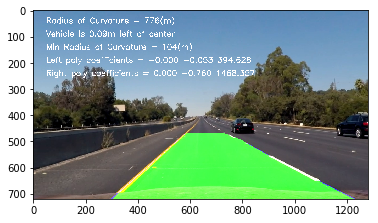

In [26]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'project_output_colour.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(image_pipeline) # NOTE: expects color images
%time output_clip.write_videofile(output, audio=False)

In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))